# Imports




In [3]:
# ============================================================
# CELL 1: IMPORTS
# ============================================================

# ============================================================
# PYTHON STANDARD LIBRARY
# ============================================================
import os
import pickle
import itertools
import warnings
from collections import defaultdict
from dataclasses import dataclass, field
from datetime import datetime
from typing import List, Dict, Tuple, Set

# ============================================================
# CORE NUMERICAL & DATA HANDLING
# ============================================================
import numpy as np
import pandas as pd
import joblib

# ============================================================
# SCIENTIFIC COMPUTING & STATISTICS
# ============================================================
from scipy import stats
from scipy.stats import randint, uniform

# ============================================================
# VISUALIZATION
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# SKLEARN: MODEL SELECTION & PREPROCESSING
# ============================================================
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler

# ============================================================
# SKLEARN: MODELS
# ============================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ============================================================
# SKLEARN: METRICS & INTERPRETABILITY
# ============================================================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mutual_info_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
)
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif


# ============================================================
# OPTIMIZATION / RULE LEARNING (ILP)
# ============================================================
from pulp import (
    LpProblem,
    LpMaximize,
    LpVariable,
    lpSum,
    LpStatus,
    PULP_CBC_CMD,
)

# ============================================================
# WARNINGS CONTROL
# ============================================================
warnings.filterwarnings("ignore")


# Load/Inspect Data

In [5]:
# ============================================================
# CELL 2: LOAD & INSPECT DATA
# ============================================================

# Load dataset
path = "./sample_data/bank-additional-full.csv"
df = pd.read_csv(path, sep=";")

print(f"Shape: {df.shape}")
df.head()


Shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Inspect expected column inputs

In [6]:
# ============================================================
# CELL 3: EXAMINE CATAGORICAL COLUMNS
# ============================================================
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("📌 CATEGORICAL COLUMNS\n" + "-"*60)
categorical_cols

for col in categorical_cols:
    print(f"\n🔎 Column: {col}")
    print("-" * 40)

    values = (
        df[col]
        .astype(str)
        .value_counts(dropna=False)
        .sort_index()
    )

    print(values)


📌 CATEGORICAL COLUMNS
------------------------------------------------------------

🔎 Column: job
----------------------------------------
job
admin.           10422
blue-collar       9254
entrepreneur      1456
housemaid         1060
management        2924
retired           1720
self-employed     1421
services          3969
student            875
technician        6743
unemployed        1014
unknown            330
Name: count, dtype: int64

🔎 Column: marital
----------------------------------------
marital
divorced     4612
married     24928
single      11568
unknown        80
Name: count, dtype: int64

🔎 Column: education
----------------------------------------
education
basic.4y                4176
basic.6y                2292
basic.9y                6045
high.school             9515
illiterate                18
professional.course     5243
university.degree      12168
unknown                 1731
Name: count, dtype: int64

🔎 Column: default
----------------------------------------

# Preprocessing

In [7]:
# ============================================================
# CELL 4: PREPROCESSING
# ============================================================

print("\n" + "="*80)
print("🔧 PREPROCESSING: bank-additional-full.csv")
print("="*80)

df_proc = df.copy()

# --------------------------------------------------
# 4.1 Target encoding (y: yes/no → 1/0)
# --------------------------------------------------
df_proc['y'] = df_proc['y'].map({'yes': 1, 'no': 0})
assert df_proc['y'].notna().all(), "❌ Unexpected values in target y"
df_proc['y'] = df_proc['y'].astype('int8')
print(f"✅ Target 'y': {df_proc['y'].value_counts().to_dict()}")

# --------------------------------------------------
# 4.2 Binary columns WITH 'unknown' handling
# unknown → -1 (preserve info, let model decide)
# --------------------------------------------------
binary_cols = ['default', 'housing', 'loan']
binary_map = {'no': 0, 'yes': 1, 'unknown': -1}

for col in binary_cols:
    df_proc[col] = df_proc[col].map(binary_map)
    assert df_proc[col].notna().all(), f"❌ Unmapped values in {col}"
    df_proc[col] = df_proc[col].astype('int8')
print(f"✅ Binary cols (unknown=-1): {binary_cols}")

# --------------------------------------------------
# 4.3 Contact (cellular/telephone only)
# --------------------------------------------------
contact_map = {'cellular': 0, 'telephone': 1}
df_proc['contact'] = df_proc['contact'].map(contact_map)
assert df_proc['contact'].notna().all(), "❌ Unmapped contact values"
df_proc['contact'] = df_proc['contact'].astype('int8')
print(f"✅ contact: {df_proc['contact'].value_counts().to_dict()}")

# --------------------------------------------------
# 4.4 Month → ordinal (1-12)
# --------------------------------------------------
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
df_proc['month'] = df_proc['month'].map(month_map)
assert df_proc['month'].notna().all(), "❌ Unmapped month values"
df_proc['month'] = df_proc['month'].astype('int8')
print(f"✅ month: months present = {sorted(df_proc['month'].unique())}")

# --------------------------------------------------
# 4.5 Day of week → ordinal (0-4, Mon=0)
# --------------------------------------------------
day_map = {'mon': 0, 'tue': 1, 'wed': 2, 'thu': 3, 'fri': 4}
df_proc['day_of_week'] = df_proc['day_of_week'].map(day_map)
assert df_proc['day_of_week'].notna().all(), "❌ Unmapped day_of_week values"
df_proc['day_of_week'] = df_proc['day_of_week'].astype('int8')
print(f"✅ day_of_week: {sorted(df_proc['day_of_week'].unique())}")

# --------------------------------------------------
# 4.6 poutcome (CORRECTED for this dataset)
# Values: failure, nonexistent, success
# --------------------------------------------------
poutcome_map = {
    'nonexistent': 0,  # Never contacted before
    'failure': 1,      # Previous campaign failed
    'success': 2       # Previous campaign succeeded
}
df_proc['poutcome'] = df_proc['poutcome'].map(poutcome_map)
assert df_proc['poutcome'].notna().all(), "❌ Unmapped poutcome values"
df_proc['poutcome'] = df_proc['poutcome'].astype('int8')
print(f"✅ poutcome: {df_proc['poutcome'].value_counts().sort_index().to_dict()}")

# --------------------------------------------------
# 4.7 Education (ordinal by level)
# --------------------------------------------------
education_map = {
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree': 6,
    'unknown': -1
}
df_proc['education'] = df_proc['education'].map(education_map)
assert df_proc['education'].notna().all(), "❌ Unmapped education values"
df_proc['education'] = df_proc['education'].astype('int8')
print(f"✅ education: ordinal 0-6, unknown=-1")

# --------------------------------------------------
# 4.8 Job (nominal → label encode)
# --------------------------------------------------
job_categories = sorted(df_proc['job'].unique())
job_map = {cat: i for i, cat in enumerate(job_categories)}
df_proc['job'] = df_proc['job'].map(job_map)
df_proc['job'] = df_proc['job'].astype('int8')
print(f"✅ job: {len(job_map)} categories label-encoded")

# --------------------------------------------------
# 4.9 Marital (nominal → label encode)
# --------------------------------------------------
marital_map = {'divorced': 0, 'married': 1, 'single': 2, 'unknown': -1}
df_proc['marital'] = df_proc['marital'].map(marital_map)
assert df_proc['marital'].notna().all(), "❌ Unmapped marital values"
df_proc['marital'] = df_proc['marital'].astype('int8')
print(f"✅ marital: {df_proc['marital'].value_counts().to_dict()}")

# --------------------------------------------------
# 4.10 Economic features (already numeric)
# --------------------------------------------------
economic_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
print(f"\n📊 Economic features (already numeric):")
for col in economic_cols:
    df_proc[col] = df_proc[col].astype('float64')
    print(f"  {col}: [{df_proc[col].min():.3f}, {df_proc[col].max():.3f}]")

# --------------------------------------------------
# 4.11 Campaign features (already numeric)
# --------------------------------------------------
campaign_cols = ['age', 'duration', 'campaign', 'pdays', 'previous']
print(f"\n📊 Campaign features (already numeric):")
for col in campaign_cols:
    print(f"  {col}: [{df_proc[col].min()}, {df_proc[col].max()}]")

# --------------------------------------------------
# VALIDATION
# --------------------------------------------------
non_numeric = df_proc.select_dtypes(exclude=['number']).columns.tolist()
assert len(non_numeric) == 0, f"❌ NON-NUMERIC: {non_numeric}"
assert df_proc.isnull().sum().sum() == 0, "❌ Nulls detected"

print(f"\n✅ df_proc ready: {df_proc.shape}")
print(f"Memory: {df_proc.memory_usage().sum() / 1024**2:.2f} MB")

# Feature groups for reference
FEATURE_GROUPS = {
    'target': ['y'],
    'binary': ['default', 'housing', 'loan'],
    'ordinal': ['education', 'poutcome', 'contact', 'month', 'day_of_week'],
    'nominal': ['job', 'marital'],
    'numeric_campaign': ['age', 'duration', 'campaign', 'pdays', 'previous'],
    'numeric_economic': economic_cols,
}



🔧 PREPROCESSING: bank-additional-full.csv
✅ Target 'y': {0: 36548, 1: 4640}
✅ Binary cols (unknown=-1): ['default', 'housing', 'loan']
✅ contact: {0: 26144, 1: 15044}
✅ month: months present = [np.int8(3), np.int8(4), np.int8(5), np.int8(6), np.int8(7), np.int8(8), np.int8(9), np.int8(10), np.int8(11), np.int8(12)]
✅ day_of_week: [np.int8(0), np.int8(1), np.int8(2), np.int8(3), np.int8(4)]
✅ poutcome: {0: 35563, 1: 4252, 2: 1373}
✅ education: ordinal 0-6, unknown=-1
✅ job: 12 categories label-encoded
✅ marital: {1: 24928, 2: 11568, 0: 4612, -1: 80}

📊 Economic features (already numeric):
  emp.var.rate: [-3.400, 1.400]
  cons.price.idx: [92.201, 94.767]
  cons.conf.idx: [-50.800, -26.900]
  euribor3m: [0.634, 5.045]
  nr.employed: [4963.600, 5228.100]

📊 Campaign features (already numeric):
  age: [17, 98]
  duration: [0, 4918]
  campaign: [1, 56]
  pdays: [0, 999]
  previous: [0, 7]

✅ df_proc ready: (41188, 21)
Memory: 3.57 MB


# Global Split


In [8]:
# ============================================================
# CELL 5: GLOBAL TRAIN / TEST SPLIT
# ============================================================

print("\n" + "="*80)
print("📐 GLOBAL TRAIN / TEST SPLIT")
print("="*80)

X_all = df_proc.drop(columns=['y'])
y_all = df_proc['y']

print(f"\nTotal samples: {len(df_proc)}")
print(f"Positive rate: {y_all.mean():.4f}")
print(f"Class counts: {y_all.value_counts().to_dict()}")

# Global holdout split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.20,
    stratify=y_all,
    random_state=42
)

train_idx = X_train.index.values
test_idx = X_test.index.values

print(f"\n✅ Split created:")
print(f"  Train: {X_train.shape} | positives: {y_train.sum()} ({y_train.mean():.4f})")
print(f"  Test:  {X_test.shape} | positives: {y_test.sum()} ({y_test.mean():.4f})")

# Shared CV object
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Sanity check
assert len(set(train_idx) & set(test_idx)) == 0, "❌ Train/Test overlap!"
print("🔒 No train/test leakage")

# Canonical split object
GLOBAL_SPLIT = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'train_idx': train_idx,
    'test_idx': test_idx,
    'cv_10': cv_10,
    'random_state': 42
}

print("\n📦 GLOBAL_SPLIT ready")


📐 GLOBAL TRAIN / TEST SPLIT

Total samples: 41188
Positive rate: 0.1127
Class counts: {0: 36548, 1: 4640}

✅ Split created:
  Train: (32950, 20) | positives: 3712 (0.1127)
  Test:  (8238, 20) | positives: 928 (0.1126)
🔒 No train/test leakage

📦 GLOBAL_SPLIT ready


# Stage 1: LR

In [12]:
# ============================================================
# CELL 5: GLOBAL TRAIN / TEST SPLIT
# ============================================================

print("\n" + "="*80)
print("📐 GLOBAL TRAIN / TEST SPLIT")
print("="*80)

# --------------------------------------------------
# DROP LEAKY FEATURES BEFORE SPLIT
# --------------------------------------------------
LEAKY_FEATURES = ['duration', 'pdays', 'poutcome']

print(f"⚠️  Dropping leaky features: {LEAKY_FEATURES}")
df_model = df_proc.drop(columns=LEAKY_FEATURES)

X_all = df_model.drop(columns=['y'])
y_all = df_model['y']

print(f"\nFeatures after dropping leaky: {X_all.shape[1]}")
print(f"Columns: {list(X_all.columns)}")

print(f"\nTotal samples: {len(df_model)}")
print(f"Positive rate: {y_all.mean():.4f}")
print(f"Class counts: {y_all.value_counts().to_dict()}")

# Global holdout split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.20,
    stratify=y_all,
    random_state=42
)

train_idx = X_train.index.values
test_idx = X_test.index.values

print(f"\n✅ Split created:")
print(f"  Train: {X_train.shape} | positives: {y_train.sum()} ({y_train.mean():.4f})")
print(f"  Test:  {X_test.shape} | positives: {y_test.sum()} ({y_test.mean():.4f})")

# Shared CV object
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Sanity check
assert len(set(train_idx) & set(test_idx)) == 0, "❌ Train/Test overlap!"
print("🔒 No train/test leakage")

# Canonical split object
GLOBAL_SPLIT = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'train_idx': train_idx,
    'test_idx': test_idx,
    'cv_10': cv_10,
    'random_state': 42
}

print("\n📦 GLOBAL_SPLIT ready")


# ============================================================
# CELL 6: LR STAGE 1 (BASELINE)
# ============================================================

print("\n" + "="*80)
print("💾 LR STAGE 1: Logistic Regression Baseline")
print("="*80)


# --------------------------------------------------
# Load from global split
# --------------------------------------------------
X_train = GLOBAL_SPLIT['X_train']
X_test = GLOBAL_SPLIT['X_test']
y_train = GLOBAL_SPLIT['y_train']
y_test = GLOBAL_SPLIT['y_test']
train_idx = GLOBAL_SPLIT['train_idx']
test_idx = GLOBAL_SPLIT['test_idx']

print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print(f"Features: {list(X_train.columns)}")

# --------------------------------------------------
# 1. Scale features (required for LR)
# --------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✅ Features scaled")

# --------------------------------------------------
# 2. Train Logistic Regression
# --------------------------------------------------
lr_model = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

print("\n📊 Test Performance (NO LEAKY FEATURES):")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")

# --------------------------------------------------
# 3. Feature importance
# --------------------------------------------------
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\n🔝 Top 10 LR features:")
print(feature_importance.head(10).to_string(index=False))

# --------------------------------------------------
# 4. Ensemble-ready outputs
# --------------------------------------------------
lr_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
lr_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"\n📊 Probability ranges:")
print(f"  Train: [{lr_train_proba.min():.4f}, {lr_train_proba.max():.4f}]")
print(f"  Test:  [{lr_test_proba.min():.4f}, {lr_test_proba.max():.4f}]")

# --------------------------------------------------
# 5. Create ensemble dictionary
# --------------------------------------------------
lr_ensemble_dict = {
    'model': lr_model,
    'model_name': 'logistic_regression',
    'scaler': scaler,
    'feature_names': X_train.columns.tolist(),
    'train_idx': train_idx,
    'test_idx': test_idx,
    'train_predictions': lr_train_proba,
    'test_predictions': lr_test_proba,
    'train_labels': y_train.values,
    'test_labels': y_test.values,
    'performance_metrics': metrics,
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

import os

base_path = "./models/lr"
os.makedirs(base_path, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = f"{base_path}/lr_model_{timestamp}.pkl"
ensemble_path = f"{base_path}/lr_ensemble_{timestamp}.joblib"

with open(model_path, 'wb') as f:
    pickle.dump(lr_model, f)

joblib.dump(lr_ensemble_dict, ensemble_path)

print(f"\n💾 Saved:")
print(f"  Model:    {model_path}")
print(f"  Ensemble: {ensemble_path}")

print("\n🎯 LR Stage 1 complete (LEAK-FREE)")


📐 GLOBAL TRAIN / TEST SPLIT
⚠️  Dropping leaky features: ['duration', 'pdays', 'poutcome']

Features after dropping leaky: 17
Columns: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Total samples: 41188
Positive rate: 0.1127
Class counts: {0: 36548, 1: 4640}

✅ Split created:
  Train: (32950, 17) | positives: 3712 (0.1127)
  Test:  (8238, 17) | positives: 928 (0.1126)
🔒 No train/test leakage

📦 GLOBAL_SPLIT ready

💾 LR STAGE 1: Logistic Regression Baseline
Train: (32950, 17) | Test: (8238, 17)
Features: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
✅ Features scaled

📊 Test Performance (NO LEAKY FEATURES):
  Accuracy: 0.7628
  Precision: 0.2813
  Recall: 0.7112
  F1-Sc

In [13]:
# ============================================================
# CELL 6: LR STAGE 1 (FEATURE ENGINEERING WITH ECONOMIC INDICATORS)
# ============================================================

print("=" * 80)
print("💾 CELL 6: LR Stage 1 - Economic Feature Engineering")
print("=" * 80)

# --------------------------------------------------
# 0. LOAD GLOBAL SPLIT
# --------------------------------------------------
print("\n🔒 USING GLOBAL_SPLIT")
print("-" * 50)

X_train = GLOBAL_SPLIT['X_train'].copy()
X_test = GLOBAL_SPLIT['X_test'].copy()
y_train = GLOBAL_SPLIT['y_train'].copy()
y_test = GLOBAL_SPLIT['y_test'].copy()

train_idx = GLOBAL_SPLIT['train_idx']
test_idx = GLOBAL_SPLIT['test_idx']

print(f"Train shape: {X_train.shape}")
print(f"Features: {list(X_train.columns)}")

# --------------------------------------------------
# 1. ECONOMIC FEATURE ENGINEERING
# Using linear algebra concepts
# --------------------------------------------------
print("\n🔧 ECONOMIC FEATURE ENGINEERING")
print("-" * 50)

# Economic indicators available:
# emp.var.rate: employment variation rate (quarterly) - range [-3.4, 1.4]
# cons.price.idx: consumer price index (monthly) - range [92.2, 94.8]
# cons.conf.idx: consumer confidence index (monthly) - range [-50.8, -26.9]
# euribor3m: 3-month euribor rate (daily) - range [0.6, 5.0]
# nr.employed: number of employees (quarterly) - range [4964, 5228]

econ_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

print(f"\n📊 Economic indicators:")
for col in econ_cols:
    print(f"  {col}: [{X_train[col].min():.2f}, {X_train[col].max():.2f}]")

# --------------------------------------------------
# 1.1 Z-SCORE STANDARDIZATION (for combining)
# --------------------------------------------------
from sklearn.preprocessing import StandardScaler

econ_scaler = StandardScaler()
X_train_econ_z = econ_scaler.fit_transform(X_train[econ_cols])
X_test_econ_z = econ_scaler.transform(X_test[econ_cols])

# Convert back to DataFrame for easier manipulation
econ_z_train = pd.DataFrame(X_train_econ_z, columns=[f'{c}_z' for c in econ_cols], index=X_train.index)
econ_z_test = pd.DataFrame(X_test_econ_z, columns=[f'{c}_z' for c in econ_cols], index=X_test.index)

print("\n✅ Economic indicators z-scored")

# --------------------------------------------------
# 1.2 PRINCIPAL COMPONENT ANALYSIS
# Extract orthogonal economic "factors"
# --------------------------------------------------
from sklearn.decomposition import PCA

pca = PCA(n_components=3)  # Keep top 3 components
X_train_pca = pca.fit_transform(X_train_econ_z)
X_test_pca = pca.transform(X_test_econ_z)

print(f"\n📐 PCA on Economic Indicators:")
print(f"  Explained variance ratios: {pca.explained_variance_ratio_}")
print(f"  Total variance captured: {sum(pca.explained_variance_ratio_):.4f}")

# Name the components based on loadings
print(f"\n  Component loadings:")
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=econ_cols
)
print(loadings.round(3).to_string())

# Add PCA features
X_train['econ_pc1'] = X_train_pca[:, 0]  # Primary economic factor
X_train['econ_pc2'] = X_train_pca[:, 1]  # Secondary factor
X_train['econ_pc3'] = X_train_pca[:, 2]  # Tertiary factor

X_test['econ_pc1'] = X_test_pca[:, 0]
X_test['econ_pc2'] = X_test_pca[:, 1]
X_test['econ_pc3'] = X_test_pca[:, 2]

print(f"\n✅ Added: econ_pc1, econ_pc2, econ_pc3")

# --------------------------------------------------
# 1.3 ECONOMIC HEALTH INDEX
# Weighted combination based on domain knowledge
# Higher = better economic conditions for subscription
# --------------------------------------------------
# Intuition:
# - Higher employment variation → better economy → more subscriptions
# - Lower euribor → cheaper borrowing → more subscriptions
# - Higher consumer confidence → more optimistic → more subscriptions
# - Higher nr_employed → stronger economy → more subscriptions

# Use z-scores for combination
X_train['econ_health'] = (
    econ_z_train['emp.var.rate_z'] * 0.25 +      # Employment growth
    -econ_z_train['euribor3m_z'] * 0.30 +        # Lower rates better (inverted)
    econ_z_train['cons.conf.idx_z'] * 0.25 +     # Consumer confidence
    econ_z_train['nr.employed_z'] * 0.20         # Employment level
)

X_test['econ_health'] = (
    econ_z_test['emp.var.rate_z'] * 0.25 +
    -econ_z_test['euribor3m_z'] * 0.30 +
    econ_z_test['cons.conf.idx_z'] * 0.25 +
    econ_z_test['nr.employed_z'] * 0.20
)

print(f"✅ Added: econ_health (weighted composite)")
print(f"  Train range: [{X_train['econ_health'].min():.3f}, {X_train['econ_health'].max():.3f}]")

# --------------------------------------------------
# 1.4 RATE ENVIRONMENT (euribor regimes)
# --------------------------------------------------
# euribor3m has bimodal distribution - high rate vs low rate regimes
euribor_median = X_train['euribor3m'].median()

X_train['low_rate_env'] = (X_train['euribor3m'] < euribor_median).astype(int)
X_test['low_rate_env'] = (X_test['euribor3m'] < euribor_median).astype(int)

print(f"✅ Added: low_rate_env (euribor < {euribor_median:.2f})")
print(f"  Train distribution: {X_train['low_rate_env'].value_counts().to_dict()}")

# --------------------------------------------------
# 1.5 POLYNOMIAL FEATURES (non-linear effects)
# --------------------------------------------------
# Quadratic term for euribor (diminishing/accelerating effects at extremes)
X_train['euribor3m_sq'] = X_train['euribor3m'] ** 2
X_test['euribor3m_sq'] = X_test['euribor3m'] ** 2

# Interaction: confidence × rate environment
X_train['conf_x_rate'] = X_train['cons.conf.idx'] * X_train['euribor3m']
X_test['conf_x_rate'] = X_test['cons.conf.idx'] * X_test['euribor3m']

print(f"✅ Added: euribor3m_sq, conf_x_rate (polynomial/interaction)")

# --------------------------------------------------
# 1.6 TEMPORAL FEATURES
# --------------------------------------------------
# Month cyclical encoding
X_train['month_sin'] = np.sin(2 * np.pi * X_train['month'] / 12)
X_train['month_cos'] = np.cos(2 * np.pi * X_train['month'] / 12)
X_test['month_sin'] = np.sin(2 * np.pi * X_test['month'] / 12)
X_test['month_cos'] = np.cos(2 * np.pi * X_test['month'] / 12)

# Day of week cyclical encoding
X_train['dow_sin'] = np.sin(2 * np.pi * X_train['day_of_week'] / 5)
X_train['dow_cos'] = np.cos(2 * np.pi * X_train['day_of_week'] / 5)
X_test['dow_sin'] = np.sin(2 * np.pi * X_test['day_of_week'] / 5)
X_test['dow_cos'] = np.cos(2 * np.pi * X_test['day_of_week'] / 5)

print(f"✅ Added: month_sin, month_cos, dow_sin, dow_cos (cyclical encoding)")

# --------------------------------------------------
# 1.7 CAMPAIGN FEATURES
# --------------------------------------------------
# Log transform for campaign (diminishing returns)
X_train['log_campaign'] = np.log1p(X_train['campaign'])
X_test['log_campaign'] = np.log1p(X_test['campaign'])

# Cold prospect (never contacted before)
X_train['is_cold'] = (X_train['previous'] == 0).astype(int)
X_test['is_cold'] = (X_test['previous'] == 0).astype(int)

print(f"✅ Added: log_campaign, is_cold")

# --------------------------------------------------
# 1.8 DROP RAW FEATURES ABSORBED INTO ENGINEERED
# --------------------------------------------------
drop_absorbed = ['month', 'day_of_week', 'campaign']
X_train = X_train.drop(columns=drop_absorbed)
X_test = X_test.drop(columns=drop_absorbed)

print(f"\n🗑️ Dropped (absorbed): {drop_absorbed}")

# --------------------------------------------------
# 2. FINAL FEATURE SET
# --------------------------------------------------
print("\n" + "="*50)
print("📋 FINAL FEATURE SET")
print("="*50)

print(f"\nTotal features: {X_train.shape[1]}")
print(f"\nFeatures by category:")

base_features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'previous']
econ_raw = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
econ_engineered = ['econ_pc1', 'econ_pc2', 'econ_pc3', 'econ_health', 'low_rate_env', 'euribor3m_sq', 'conf_x_rate']
temporal_engineered = ['month_sin', 'month_cos', 'dow_sin', 'dow_cos']
campaign_engineered = ['log_campaign', 'is_cold']

print(f"\n  Base features ({len([f for f in base_features if f in X_train.columns])}):")
for f in base_features:
    if f in X_train.columns:
        print(f"    • {f}")

print(f"\n  Economic raw ({len([f for f in econ_raw if f in X_train.columns])}):")
for f in econ_raw:
    if f in X_train.columns:
        print(f"    • {f}")

print(f"\n  Economic engineered ({len([f for f in econ_engineered if f in X_train.columns])}):")
for f in econ_engineered:
    if f in X_train.columns:
        print(f"    • {f}")

print(f"\n  Temporal engineered ({len([f for f in temporal_engineered if f in X_train.columns])}):")
for f in temporal_engineered:
    if f in X_train.columns:
        print(f"    • {f}")

print(f"\n  Campaign engineered ({len([f for f in campaign_engineered if f in X_train.columns])}):")
for f in campaign_engineered:
    if f in X_train.columns:
        print(f"    • {f}")

# --------------------------------------------------
# 3. SCALE FEATURES
# --------------------------------------------------
print("\n📏 SCALING FEATURES")
print("-" * 50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled with StandardScaler")

# --------------------------------------------------
# 4. TRAIN LOGISTIC REGRESSION
# --------------------------------------------------
print("\n🤖 TRAINING LOGISTIC REGRESSION")
print("-" * 50)

lr_model = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

print("\n📊 Test Performance:")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")

# --------------------------------------------------
# 5. FEATURE IMPORTANCE
# --------------------------------------------------
print("\n📊 FEATURE IMPORTANCE (Coefficients)")
print("-" * 50)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print(feature_importance.to_string(index=False))

# Highlight engineered features
print("\n🔬 Engineered feature contributions:")
for feat in econ_engineered + temporal_engineered + campaign_engineered:
    if feat in feature_importance['Feature'].values:
        coef = feature_importance[feature_importance['Feature'] == feat]['Coefficient'].values[0]
        print(f"  {feat}: {coef:+.4f}")

# --------------------------------------------------
# 6. ENSEMBLE-READY OUTPUTS
# --------------------------------------------------
lr_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
lr_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"\n📊 Probability ranges:")
print(f"  Train: [{lr_train_proba.min():.4f}, {lr_train_proba.max():.4f}]")
print(f"  Test:  [{lr_test_proba.min():.4f}, {lr_test_proba.max():.4f}]")

# --------------------------------------------------
# 7. SAVE
# --------------------------------------------------
import os
import pickle
import joblib
from datetime import datetime

base_path = "./models/lr"
os.makedirs(base_path, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

lr_ensemble_dict = {
    'model': lr_model,
    'model_name': 'logistic_regression_econ_engineered',
    'scaler': scaler,
    'econ_scaler': econ_scaler,
    'pca': pca,
    'feature_names': X_train.columns.tolist(),
    'train_idx': train_idx,
    'test_idx': test_idx,
    'train_predictions': lr_train_proba,
    'test_predictions': lr_test_proba,
    'train_labels': y_train.values,
    'test_labels': y_test.values,
    'performance_metrics': metrics,
    'training_date': timestamp,
}

model_path = f"{base_path}/lr_model_econ_{timestamp}.pkl"
ensemble_path = f"{base_path}/lr_ensemble_econ_{timestamp}.joblib"

with open(model_path, 'wb') as f:
    pickle.dump(lr_model, f)

joblib.dump(lr_ensemble_dict, ensemble_path)

print(f"\n💾 Saved:")
print(f"  Model:    {model_path}")
print(f"  Ensemble: {ensemble_path}")

print("\n🎯 LR Stage 1 complete (ECONOMIC FEATURE ENGINEERING)")

💾 CELL 6: LR Stage 1 - Economic Feature Engineering

🔒 USING GLOBAL_SPLIT
--------------------------------------------------
Train shape: (32950, 17)
Features: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

🔧 ECONOMIC FEATURE ENGINEERING
--------------------------------------------------

📊 Economic indicators:
  emp.var.rate: [-3.40, 1.40]
  cons.price.idx: [92.20, 94.77]
  cons.conf.idx: [-50.80, -26.90]
  euribor3m: [0.63, 5.04]
  nr.employed: [4963.60, 5228.10]

✅ Economic indicators z-scored

📐 PCA on Economic Indicators:
  Explained variance ratios: [0.69344711 0.19661422 0.1027608 ]
  Total variance captured: 0.9928

  Component loadings:
                  PC1    PC2    PC3
emp.var.rate    0.532 -0.047 -0.011
cons.price.idx  0.421 -0.193  0.822
cons.conf.idx   0.132  0.974  0.119
euribor3m       0.530  0.050 -0.182
nr.em

🔥 CELL 7: Correlation Heatmap & Feature Pruning

📊 Computing correlation matrix...

📈 Feature correlation with target (absolute):
nr.employed       0.349729
conf_x_rate       0.306643
euribor3m         0.303174
emp.var.rate      0.293690
econ_pc1          0.288599
euribor3m_sq      0.287624
previous          0.229759
low_rate_env      0.211508
econ_pc3          0.195667
is_cold           0.195115
contact           0.143238
econ_health       0.137005
cons.price.idx    0.132520
econ_pc2          0.113401
month_cos         0.110308
default           0.098950
log_campaign      0.068997
cons.conf.idx     0.055327
marital           0.047592
education         0.031026
age               0.028673
job               0.026278
month_sin         0.025092
dow_cos           0.016912
housing           0.008772
dow_sin           0.003233
loan              0.000526

📊 Generating correlation heatmap...


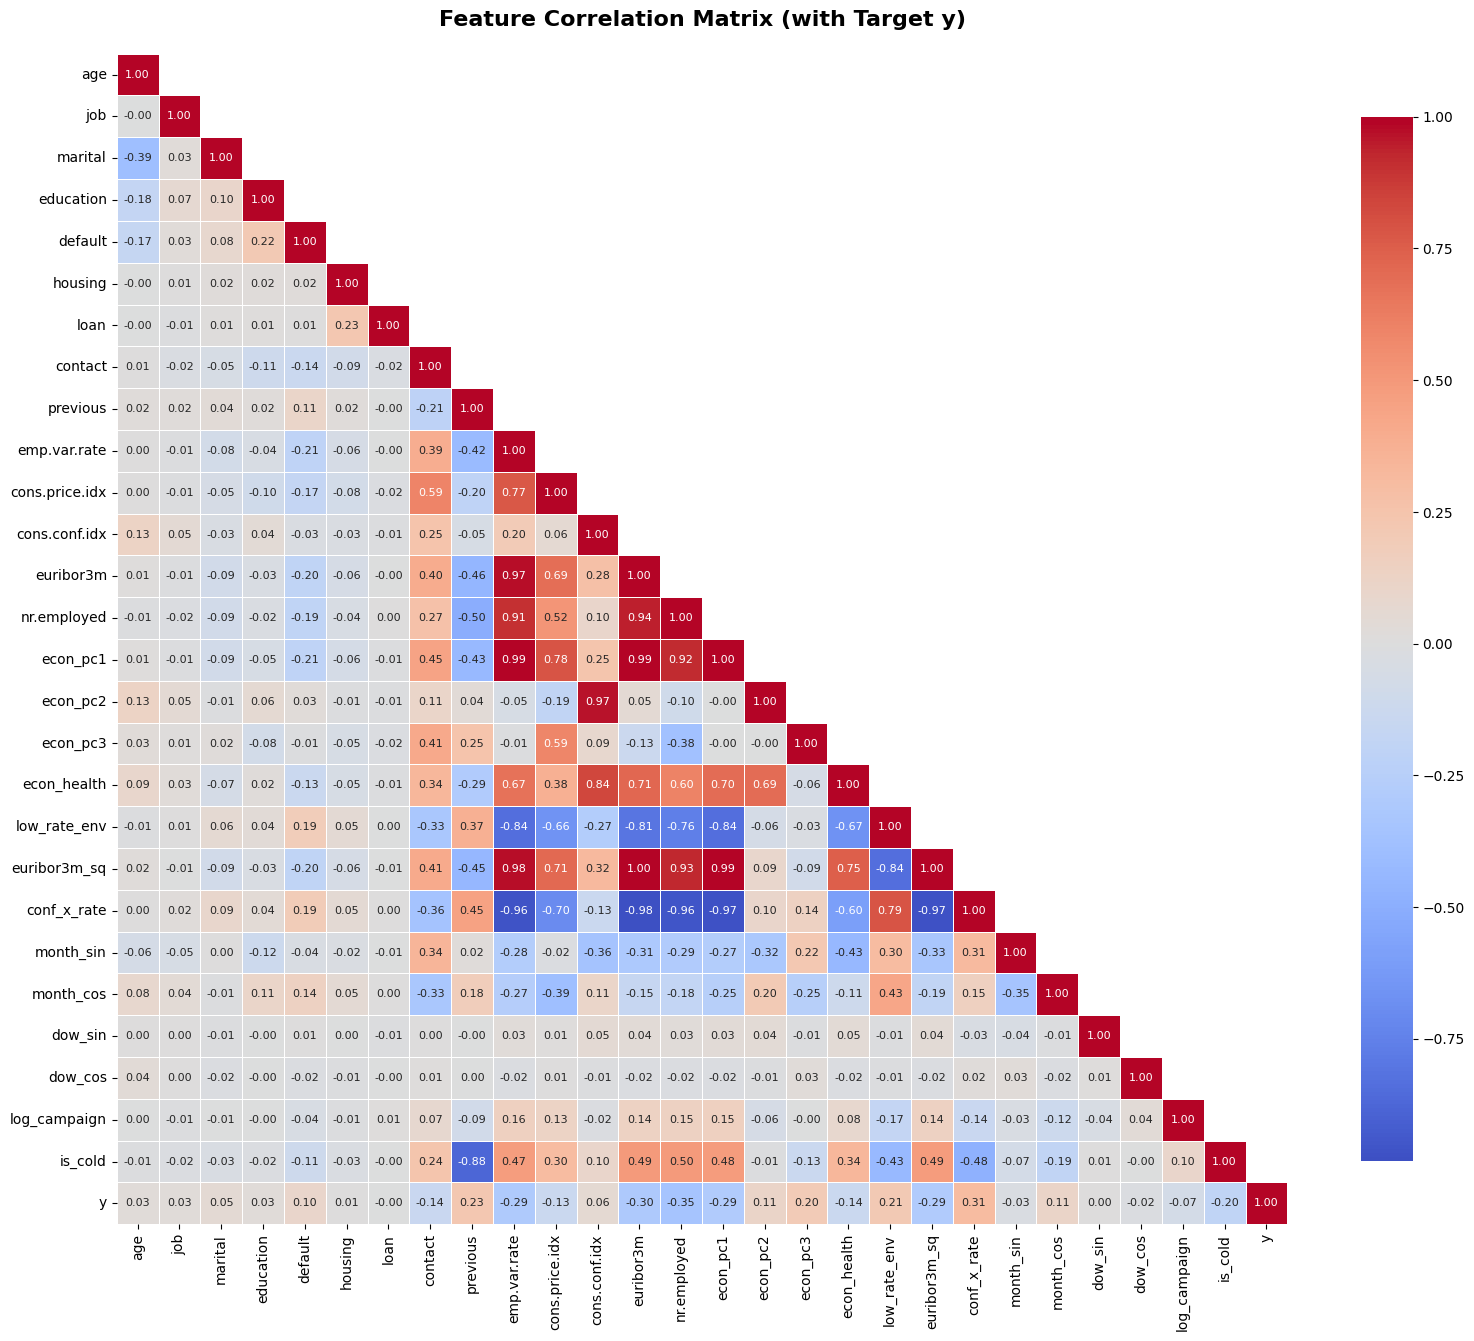


🔍 Identifying highly correlated feature pairs...
--------------------------------------------------

⚠️  Found 29 highly correlated pairs (|r| > 0.7):

     feature_1      feature_2  correlation  corr_with_y_1  corr_with_y_2         keep           drop
      previous        is_cold    -0.876529       0.229759       0.195115     previous        is_cold
  emp.var.rate cons.price.idx     0.773923       0.293690       0.132520 emp.var.rate cons.price.idx
  emp.var.rate      euribor3m     0.972154       0.293690       0.303174    euribor3m   emp.var.rate
  emp.var.rate    nr.employed     0.906313       0.293690       0.349729  nr.employed   emp.var.rate
  emp.var.rate       econ_pc1     0.990408       0.293690       0.288599 emp.var.rate       econ_pc1
  emp.var.rate   low_rate_env    -0.842821       0.293690       0.211508 emp.var.rate   low_rate_env
  emp.var.rate   euribor3m_sq     0.976239       0.293690       0.287624 emp.var.rate   euribor3m_sq
  emp.var.rate    conf_x_rate    -0.959

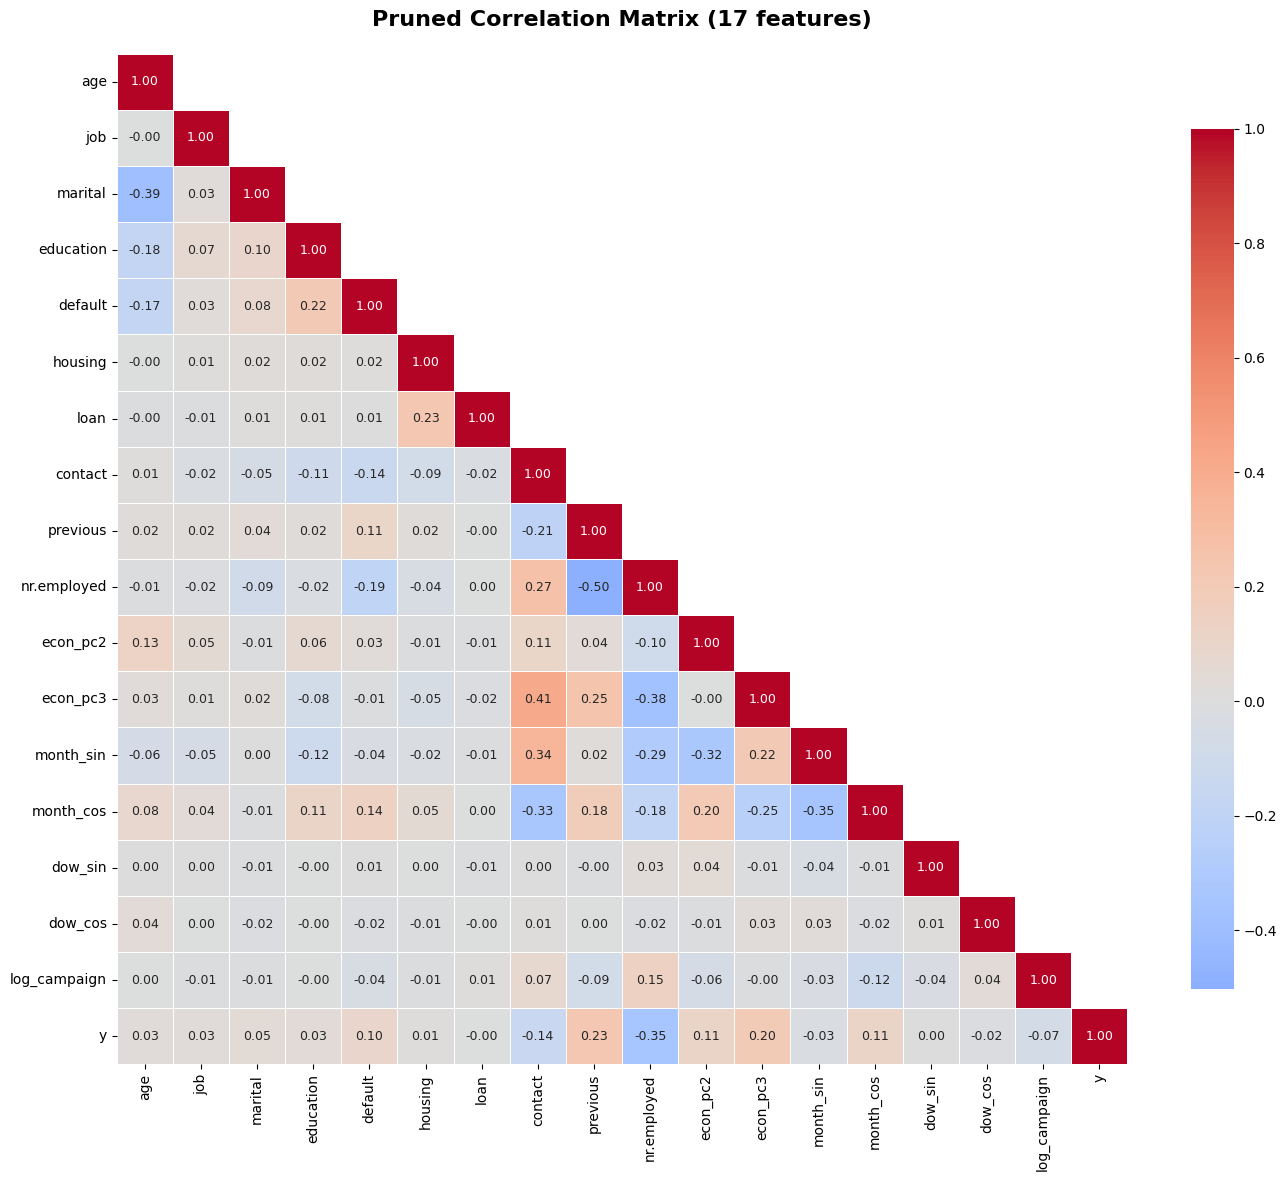


📦 Updating variables...

✅ X_train and X_test updated
   Shape: (32950, 17)
   Features: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'previous', 'nr.employed', 'econ_pc2', 'econ_pc3', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'log_campaign']

📋 MULTICOLLINEARITY REDUCTION SUMMARY
  Correlation threshold: |r| > 0.7
  High-corr pairs found: 29
  Features dropped: 10
  Final feature count: 17


In [14]:
# ============================================================
# CELL 7: CORRELATION ANALYSIS & MULTICOLLINEARITY REDUCTION
# ============================================================

print("=" * 80)
print("🔥 CELL 7: Correlation Heatmap & Feature Pruning")
print("=" * 80)

# --------------------------------------------------
# 1. COMPUTE CORRELATION MATRIX (with target)
# --------------------------------------------------
print("\n📊 Computing correlation matrix...")

# Add target to training data for correlation analysis
X_train_with_y = X_train.copy()
X_train_with_y['y'] = y_train.values

# Full correlation matrix
corr_matrix = X_train_with_y.corr()

# Correlation with target
target_corr = corr_matrix['y'].drop('y').abs().sort_values(ascending=False)

print("\n📈 Feature correlation with target (absolute):")
print(target_corr.to_string())

# --------------------------------------------------
# 2. HEATMAP VISUALIZATION
# --------------------------------------------------
print("\n📊 Generating correlation heatmap...")

fig, ax = plt.subplots(figsize=(16, 14))

# Mask upper triangle for cleaner view
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax,
    annot_kws={"size": 8}
)

ax.set_title('Feature Correlation Matrix (with Target y)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 3. IDENTIFY HIGHLY CORRELATED PAIRS
# --------------------------------------------------
print("\n🔍 Identifying highly correlated feature pairs...")
print("-" * 50)

CORR_THRESHOLD = 0.7  # Features with |r| > 0.7 are candidates for pruning

# Get feature-feature correlations (exclude target)
feature_corr = corr_matrix.drop('y', axis=0).drop('y', axis=1)

# Find pairs above threshold
high_corr_pairs = []

for i in range(len(feature_corr.columns)):
    for j in range(i + 1, len(feature_corr.columns)):
        feat1 = feature_corr.columns[i]
        feat2 = feature_corr.columns[j]
        corr_val = feature_corr.iloc[i, j]

        if abs(corr_val) > CORR_THRESHOLD:
            # Get correlation with target for each feature
            corr_with_y_1 = target_corr[feat1]
            corr_with_y_2 = target_corr[feat2]

            # Feature to drop = lower correlation with target
            if corr_with_y_1 >= corr_with_y_2:
                keep = feat1
                drop = feat2
            else:
                keep = feat2
                drop = feat1

            high_corr_pairs.append({
                'feature_1': feat1,
                'feature_2': feat2,
                'correlation': corr_val,
                'corr_with_y_1': corr_with_y_1,
                'corr_with_y_2': corr_with_y_2,
                'keep': keep,
                'drop': drop
            })

# Display results
if high_corr_pairs:
    pairs_df = pd.DataFrame(high_corr_pairs)
    print(f"\n⚠️  Found {len(pairs_df)} highly correlated pairs (|r| > {CORR_THRESHOLD}):\n")
    print(pairs_df[['feature_1', 'feature_2', 'correlation', 'corr_with_y_1', 'corr_with_y_2', 'keep', 'drop']].to_string(index=False))

    # Get unique features to drop
    features_to_drop = list(set(pairs_df['drop'].tolist()))

    print(f"\n🗑️  Features to drop (lower |corr| with target):")
    for feat in features_to_drop:
        corr_y = target_corr[feat]
        print(f"    • {feat} (|corr with y| = {corr_y:.4f})")
else:
    print(f"\n✅ No feature pairs with |r| > {CORR_THRESHOLD}")
    features_to_drop = []

# --------------------------------------------------
# 4. DROP REDUNDANT FEATURES
# --------------------------------------------------
print("\n" + "="*50)
print("🔧 DROPPING REDUNDANT FEATURES")
print("="*50)

if features_to_drop:
    print(f"\nBefore: {X_train.shape[1]} features")

    X_train_pruned = X_train.drop(columns=features_to_drop)
    X_test_pruned = X_test.drop(columns=features_to_drop)

    print(f"After:  {X_train_pruned.shape[1]} features")
    print(f"\nDropped: {features_to_drop}")
    print(f"Remaining: {list(X_train_pruned.columns)}")
else:
    X_train_pruned = X_train.copy()
    X_test_pruned = X_test.copy()
    print("\nNo features dropped.")

# --------------------------------------------------
# 5. VERIFY NO REMAINING HIGH CORRELATIONS
# --------------------------------------------------
print("\n🔍 Verifying no remaining high correlations...")

feature_corr_pruned = X_train_pruned.corr()

remaining_high = []
for i in range(len(feature_corr_pruned.columns)):
    for j in range(i + 1, len(feature_corr_pruned.columns)):
        corr_val = feature_corr_pruned.iloc[i, j]
        if abs(corr_val) > CORR_THRESHOLD:
            remaining_high.append((
                feature_corr_pruned.columns[i],
                feature_corr_pruned.columns[j],
                corr_val
            ))

if remaining_high:
    print(f"\n⚠️  Still have {len(remaining_high)} pairs above threshold:")
    for f1, f2, r in remaining_high:
        print(f"    {f1} ↔ {f2}: {r:.3f}")
else:
    print(f"\n✅ All feature pairs now below |r| = {CORR_THRESHOLD}")

# --------------------------------------------------
# 6. UPDATED HEATMAP (PRUNED)
# --------------------------------------------------
print("\n📊 Generating pruned correlation heatmap...")

X_pruned_with_y = X_train_pruned.copy()
X_pruned_with_y['y'] = y_train.values
corr_matrix_pruned = X_pruned_with_y.corr()

fig, ax = plt.subplots(figsize=(14, 12))

mask_pruned = np.triu(np.ones_like(corr_matrix_pruned, dtype=bool), k=1)

sns.heatmap(
    corr_matrix_pruned,
    mask=mask_pruned,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax,
    annot_kws={"size": 9}
)

ax.set_title(f'Pruned Correlation Matrix ({X_train_pruned.shape[1]} features)',
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 7. UPDATE VARIABLES FOR NEXT CELL
# --------------------------------------------------
print("\n📦 Updating variables...")

X_train = X_train_pruned
X_test = X_test_pruned

print(f"\n✅ X_train and X_test updated")
print(f"   Shape: {X_train.shape}")
print(f"   Features: {list(X_train.columns)}")

# --------------------------------------------------
# 8. SUMMARY
# --------------------------------------------------
print("\n" + "=" * 80)
print("📋 MULTICOLLINEARITY REDUCTION SUMMARY")
print("=" * 80)
print(f"  Correlation threshold: |r| > {CORR_THRESHOLD}")
print(f"  High-corr pairs found: {len(high_corr_pairs)}")
print(f"  Features dropped: {len(features_to_drop)}")
print(f"  Final feature count: {X_train.shape[1]}")
print("=" * 80)

🔧 CELL 8: Hyperparameter Tuning + Calibration

📊 Feature Set (from Cell 7):
   Features: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'previous', 'nr.employed', 'econ_pc2', 'econ_pc3', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'log_campaign']
   Shape: (32950, 17)
✅ Features scaled

🔍 HYPERPARAMETER TUNING (F2-Score: Recall-Favoring)

   Testing 64 hyperparameter combinations...
   Scoring: F2-Score (β=2, recall-favoring)
Fitting 5 folds for each of 64 candidates, totalling 320 fits

✅ Best Parameters (by F2-Score):
   C: 0.01
   class_weight: balanced
   max_iter: 1000
   penalty: l2
   solver: liblinear

   Best CV F2-Score: 0.5143

📊 Top 10 Configurations:
------------------------------------------------------------
   Rank 1: F2=0.5143 ± 0.0077
      C=0.01, penalty=l2, class_weight=balanced
   Rank 2: F2=0.5142 ± 0.0080
      C=10.0, penalty=l1, class_weight=balanced
   Rank 2: F2=0.5142 ± 0.0080
      C=2.0, penalty=l2, class_weight=balanc

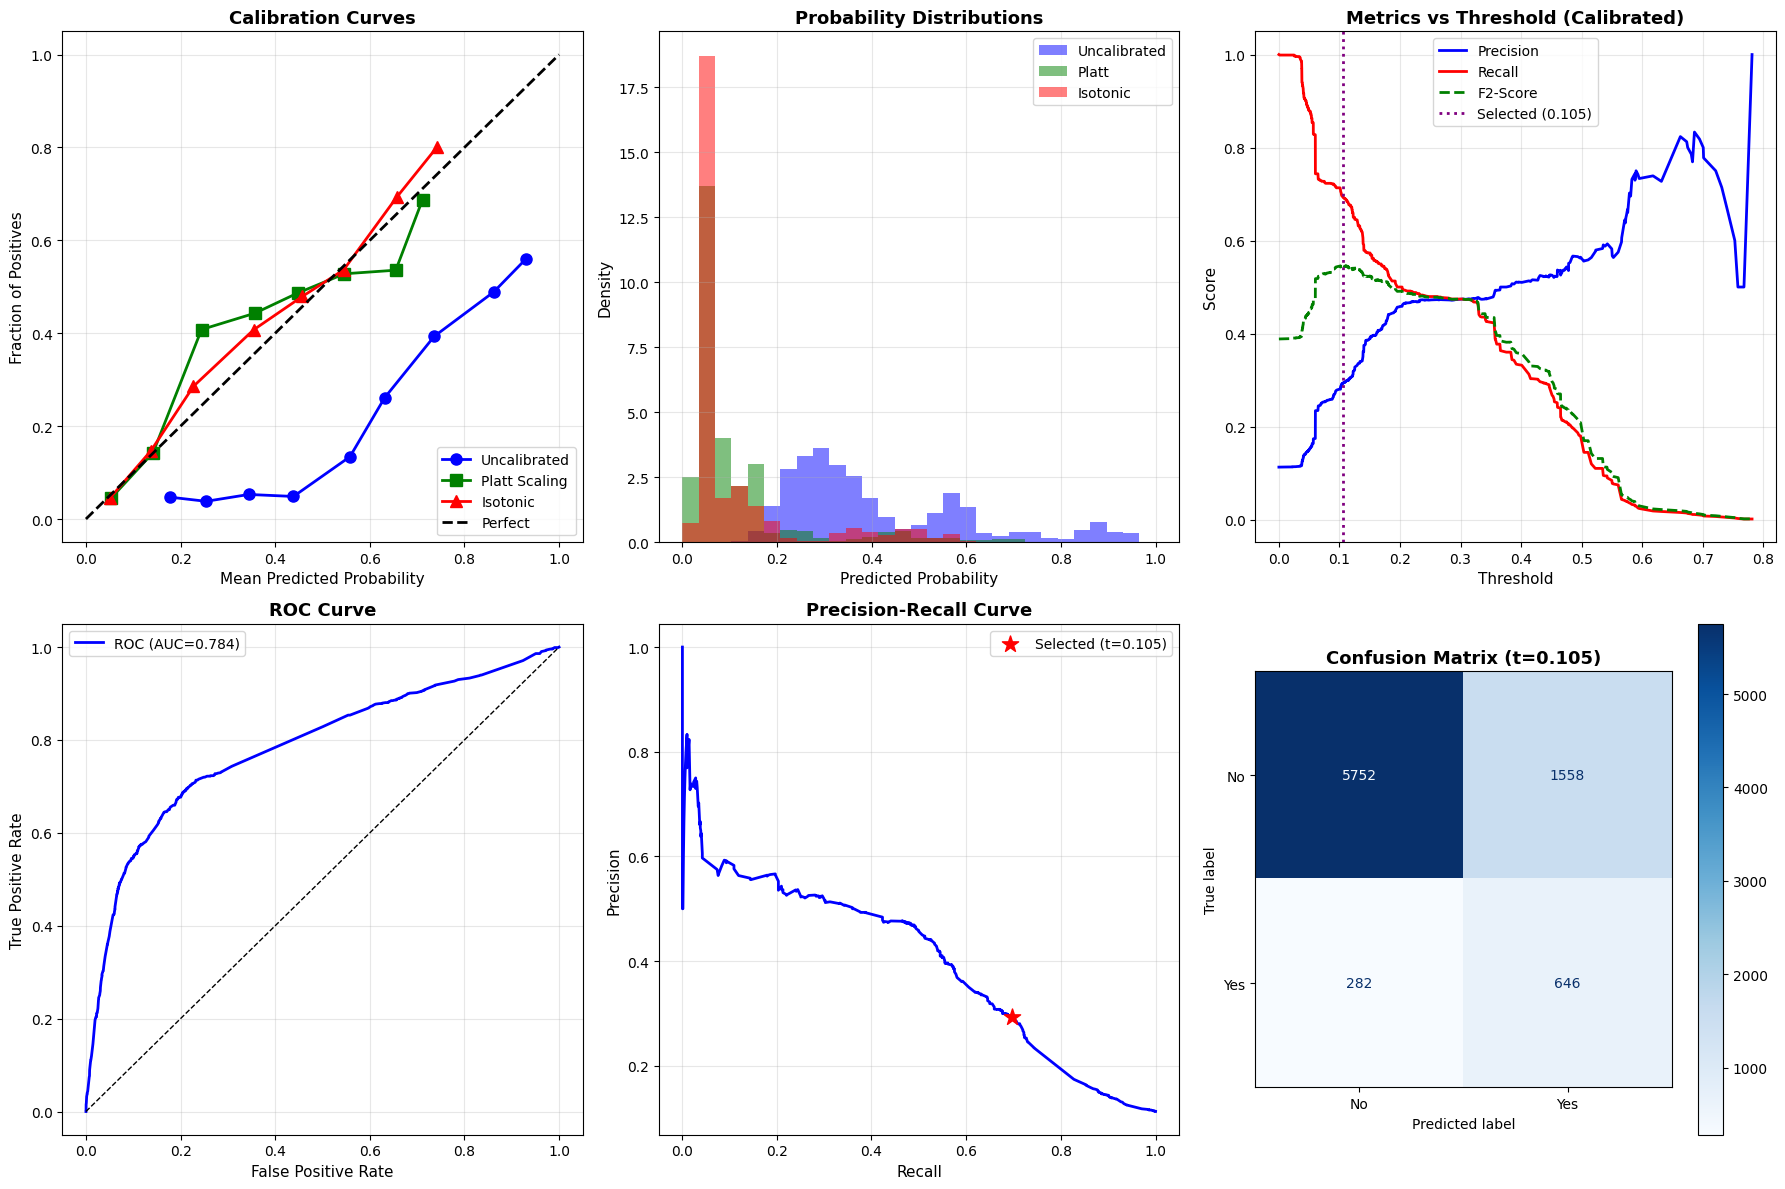

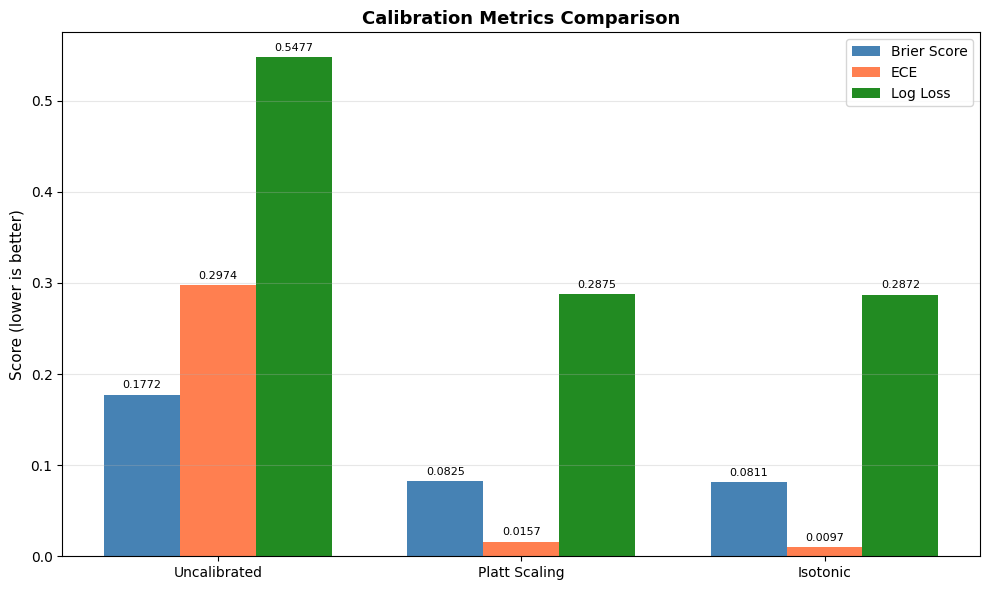


📊 Feature Importance (Tuned Model):
--------------------------------------------------
     Feature  Coefficient  Abs_Coef
 nr.employed    -0.701117  0.701117
     contact    -0.279512  0.279512
    econ_pc3     0.167809  0.167809
   month_sin    -0.133210  0.133210
     default     0.122716  0.122716
     marital     0.083181  0.083181
log_campaign    -0.076625  0.076625
     dow_cos    -0.058867  0.058867
    econ_pc2     0.058699  0.058699
         age     0.053151  0.053151
   month_cos     0.031943  0.031943
   education     0.028251  0.028251
     housing    -0.023308  0.023308
    previous     0.018880  0.018880
         job     0.018157  0.018157
        loan     0.015158  0.015158
     dow_sin     0.009523  0.009523


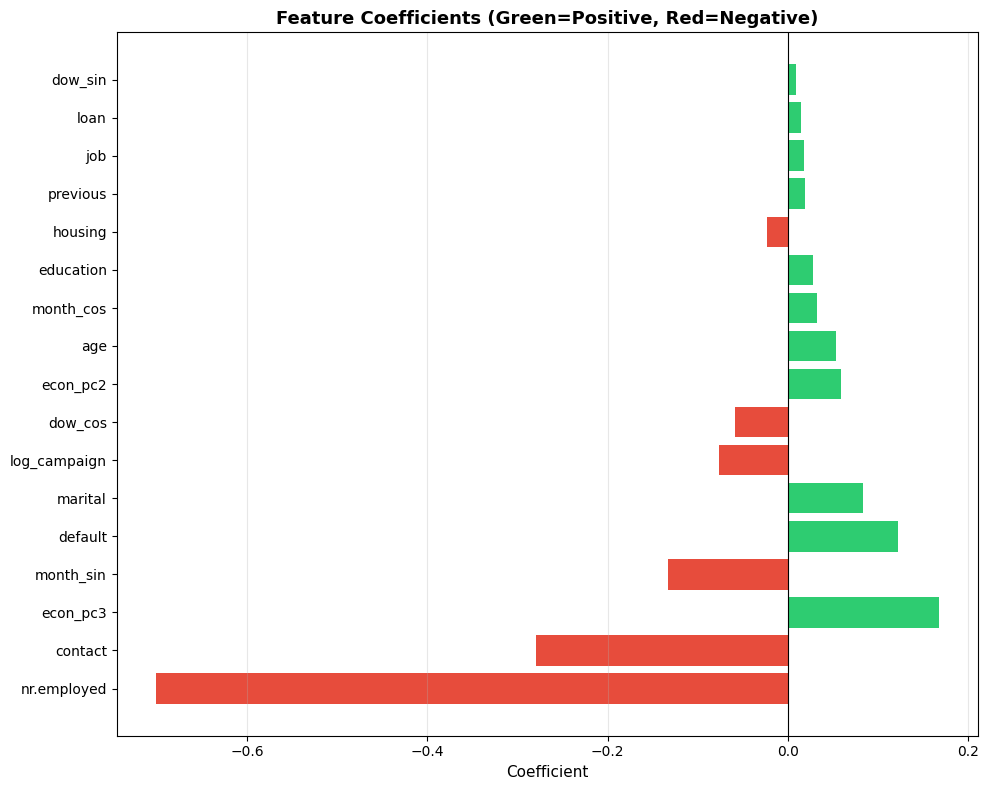


💾 Saving outputs...
   Model:    ./models/lr/lr_tuned_20260127_232232.pkl
   Ensemble: ./models/lr/lr_ensemble_tuned_20260127_232232.joblib

🎯 CELL 8 COMPLETE: Tuned + Calibrated LR

  🔧 Best Hyperparameters:
     C: 0.01
     class_weight: balanced
     max_iter: 1000
     penalty: l2
     solver: liblinear

  📊 Final Performance (Calibrated, t=0.1054):
     Accuracy:  0.7766
     Precision: 0.2931
     Recall:    0.6961
     F1-Score:  0.4125
     F2-Score:  0.5460
     ROC-AUC:   0.7837

  📐 Calibration (Isotonic):
     Brier: 0.1772 → 0.0811 (-54.2%)
     ECE:   0.2974 → 0.0097 (-96.7%)

  🔝 Top 3 Features:
     nr.employed: -0.7011
     contact: -0.2795
     econ_pc3: +0.1678


In [15]:
# ============================================================
# CELL 8: HYPERPARAMETER TUNING + CALIBRATION (RECALL-FAVORING)
# ============================================================
# Requires: X_train, X_test, y_train, y_test from Cell 7 (pruned features)

print("=" * 80)
print("🔧 CELL 8: Hyperparameter Tuning + Calibration")
print("=" * 80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, fbeta_score,
    brier_score_loss, log_loss,
    precision_recall_curve, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay,
    make_scorer
)
import warnings
warnings.filterwarnings('ignore')

# --------------------------------------------------
# 0. VERIFY & SCALE FEATURES
# --------------------------------------------------
print("\n📊 Feature Set (from Cell 7):")
print(f"   Features: {list(X_train.columns)}")
print(f"   Shape: {X_train.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")

# --------------------------------------------------
# 1. HYPERPARAMETER TUNING (RECALL-FAVORING)
# --------------------------------------------------
print("\n" + "="*60)
print("🔍 HYPERPARAMETER TUNING (F2-Score: Recall-Favoring)")
print("="*60)

# F2 scorer: weights recall 2x more than precision
f2_scorer = make_scorer(fbeta_score, beta=2)

# Also track F1 for comparison
f1_scorer = make_scorer(f1_score)

param_grid = {
    'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [
        'balanced',
        {0: 1, 1: 2},   # 2x weight on positive class
        {0: 1, 1: 3},   # 3x weight on positive class
        {0: 1, 1: 4},   # 4x weight on positive class
    ],
    'max_iter': [1000]
}

n_combinations = (
    len(param_grid['C']) *
    len(param_grid['penalty']) *
    len(param_grid['class_weight'])
)
print(f"\n   Testing {n_combinations} hyperparameter combinations...")
print(f"   Scoring: F2-Score (β=2, recall-favoring)")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring=f2_scorer,  # Optimize for F2 (recall-favoring)
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)

print(f"\n✅ Best Parameters (by F2-Score):")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n   Best CV F2-Score: {grid_search.best_score_:.4f}")

# --------------------------------------------------
# 2. COMPARE TOP CONFIGURATIONS
# --------------------------------------------------
print("\n📊 Top 10 Configurations:")
print("-" * 60)

results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')

top_configs = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)
for idx, row in top_configs.iterrows():
    params = row['params']
    print(f"   Rank {int(row['rank_test_score'])}: F2={row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")
    print(f"      C={params['C']}, penalty={params['penalty']}, class_weight={params['class_weight']}")

# --------------------------------------------------
# 3. EVALUATE TUNED MODEL
# --------------------------------------------------
print("\n" + "="*60)
print("📈 TUNED MODEL EVALUATION")
print("="*60)

lr_tuned = grid_search.best_estimator_

y_pred = lr_tuned.predict(X_test_scaled)
y_pred_proba = lr_tuned.predict_proba(X_test_scaled)[:, 1]

metrics_default = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'F2-Score': fbeta_score(y_test, y_pred, beta=2),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

print("\n📊 Test Performance (threshold=0.5):")
for k, v in metrics_default.items():
    print(f"   {k}: {v:.4f}")

# --------------------------------------------------
# 4. THRESHOLD OPTIMIZATION
# --------------------------------------------------
print("\n" + "="*60)
print("🎯 THRESHOLD OPTIMIZATION")
print("="*60)

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

threshold_results = []
for i, thresh in enumerate(thresholds):
    y_pred_t = (y_pred_proba >= thresh).astype(int)
    if y_pred_t.sum() == 0:
        continue

    threshold_results.append({
        'threshold': thresh,
        'precision': precision_score(y_test, y_pred_t),
        'recall': recall_score(y_test, y_pred_t),
        'f1': f1_score(y_test, y_pred_t),
        'f2': fbeta_score(y_test, y_pred_t, beta=2),
        'accuracy': accuracy_score(y_test, y_pred_t)
    })

thresh_df = pd.DataFrame(threshold_results)

# Find optimal thresholds by different criteria
best_f1_idx = thresh_df['f1'].idxmax()
best_f2_idx = thresh_df['f2'].idxmax()
best_recall_80_idx = thresh_df[thresh_df['precision'] >= 0.20]['recall'].idxmax() if (thresh_df['precision'] >= 0.20).any() else best_f2_idx

print("\n📊 Optimal Thresholds:")
print(f"\n   1️⃣  Best F1 (balanced):")
print(f"       Threshold: {thresh_df.loc[best_f1_idx, 'threshold']:.4f}")
print(f"       Precision: {thresh_df.loc[best_f1_idx, 'precision']:.4f}")
print(f"       Recall:    {thresh_df.loc[best_f1_idx, 'recall']:.4f}")
print(f"       F1:        {thresh_df.loc[best_f1_idx, 'f1']:.4f}")

print(f"\n   2️⃣  Best F2 (recall-favoring):")
print(f"       Threshold: {thresh_df.loc[best_f2_idx, 'threshold']:.4f}")
print(f"       Precision: {thresh_df.loc[best_f2_idx, 'precision']:.4f}")
print(f"       Recall:    {thresh_df.loc[best_f2_idx, 'recall']:.4f}")
print(f"       F2:        {thresh_df.loc[best_f2_idx, 'f2']:.4f}")

# Use F2-optimal threshold
optimal_threshold = thresh_df.loc[best_f2_idx, 'threshold']
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

print(f"\n✅ Selected Threshold: {optimal_threshold:.4f} (F2-optimized)")

# --------------------------------------------------
# 5. CALIBRATION
# --------------------------------------------------
print("\n" + "="*60)
print("🔧 PROBABILITY CALIBRATION")
print("="*60)

# ECE calculation function
def calculate_ece(y_true, y_prob, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        in_bin = (y_prob > bin_boundaries[i]) & (y_prob <= bin_boundaries[i + 1])
        prop_in_bin = in_bin.mean()
        if prop_in_bin > 0:
            avg_confidence = y_prob[in_bin].mean()
            avg_accuracy = y_true[in_bin].mean()
            ece += np.abs(avg_accuracy - avg_confidence) * prop_in_bin
    return ece

# Baseline (uncalibrated)
brier_uncal = brier_score_loss(y_test, y_pred_proba)
logloss_uncal = log_loss(y_test, y_pred_proba)
ece_uncal = calculate_ece(y_test.values, y_pred_proba)

print(f"\n📊 Uncalibrated Metrics:")
print(f"   Brier Score: {brier_uncal:.6f}")
print(f"   Log Loss:    {logloss_uncal:.6f}")
print(f"   ECE:         {ece_uncal:.6f}")

# Platt Scaling
print("\n   Fitting Platt Scaling (sigmoid)...")
calibrated_sigmoid = CalibratedClassifierCV(
    estimator=lr_tuned,
    method='sigmoid',
    cv=5,
    n_jobs=-1
)
calibrated_sigmoid.fit(X_train_scaled, y_train)
y_proba_sigmoid = calibrated_sigmoid.predict_proba(X_test_scaled)[:, 1]

brier_sigmoid = brier_score_loss(y_test, y_proba_sigmoid)
logloss_sigmoid = log_loss(y_test, y_proba_sigmoid)
ece_sigmoid = calculate_ece(y_test.values, y_proba_sigmoid)

# Isotonic Regression
print("   Fitting Isotonic Regression...")
calibrated_isotonic = CalibratedClassifierCV(
    estimator=lr_tuned,
    method='isotonic',
    cv=5,
    n_jobs=-1
)
calibrated_isotonic.fit(X_train_scaled, y_train)
y_proba_isotonic = calibrated_isotonic.predict_proba(X_test_scaled)[:, 1]

brier_isotonic = brier_score_loss(y_test, y_proba_isotonic)
logloss_isotonic = log_loss(y_test, y_proba_isotonic)
ece_isotonic = calculate_ece(y_test.values, y_proba_isotonic)

# Comparison table
print("\n📊 Calibration Comparison:")
print("-" * 60)
calib_comparison = pd.DataFrame({
    'Method': ['Uncalibrated', 'Platt Scaling', 'Isotonic'],
    'Brier': [brier_uncal, brier_sigmoid, brier_isotonic],
    'Log Loss': [logloss_uncal, logloss_sigmoid, logloss_isotonic],
    'ECE': [ece_uncal, ece_sigmoid, ece_isotonic],
    'Prob Range': [
        f"[{y_pred_proba.min():.3f}, {y_pred_proba.max():.3f}]",
        f"[{y_proba_sigmoid.min():.3f}, {y_proba_sigmoid.max():.3f}]",
        f"[{y_proba_isotonic.min():.3f}, {y_proba_isotonic.max():.3f}]"
    ]
})
print(calib_comparison.to_string(index=False))

# Select best calibrator
if brier_sigmoid <= brier_isotonic:
    best_calibrator = calibrated_sigmoid
    best_proba = y_proba_sigmoid
    best_calib_name = 'Platt Scaling'
    best_calib_metrics = {'brier': brier_sigmoid, 'logloss': logloss_sigmoid, 'ece': ece_sigmoid}
else:
    best_calibrator = calibrated_isotonic
    best_proba = y_proba_isotonic
    best_calib_name = 'Isotonic'
    best_calib_metrics = {'brier': brier_isotonic, 'logloss': logloss_isotonic, 'ece': ece_isotonic}

print(f"\n🏆 Best Calibration: {best_calib_name}")

# --------------------------------------------------
# 6. RE-OPTIMIZE THRESHOLD ON CALIBRATED PROBS
# --------------------------------------------------
print("\n🎯 Re-optimizing threshold on calibrated probabilities...")

thresh_results_cal = []
precisions_cal, recalls_cal, thresholds_cal = precision_recall_curve(y_test, best_proba)

for i, thresh in enumerate(thresholds_cal):
    y_pred_t = (best_proba >= thresh).astype(int)
    if y_pred_t.sum() == 0:
        continue
    thresh_results_cal.append({
        'threshold': thresh,
        'precision': precision_score(y_test, y_pred_t),
        'recall': recall_score(y_test, y_pred_t),
        'f1': f1_score(y_test, y_pred_t),
        'f2': fbeta_score(y_test, y_pred_t, beta=2),
    })

thresh_df_cal = pd.DataFrame(thresh_results_cal)
best_f2_cal_idx = thresh_df_cal['f2'].idxmax()
optimal_thresh_cal = thresh_df_cal.loc[best_f2_cal_idx, 'threshold']

y_pred_final = (best_proba >= optimal_thresh_cal).astype(int)

final_metrics = {
    'Threshold': optimal_thresh_cal,
    'Calibration': best_calib_name,
    'Accuracy': accuracy_score(y_test, y_pred_final),
    'Precision': precision_score(y_test, y_pred_final),
    'Recall': recall_score(y_test, y_pred_final),
    'F1-Score': f1_score(y_test, y_pred_final),
    'F2-Score': fbeta_score(y_test, y_pred_final, beta=2),
    'ROC-AUC': roc_auc_score(y_test, best_proba),
    'Brier': best_calib_metrics['brier'],
    'ECE': best_calib_metrics['ece']
}

print(f"\n📈 FINAL CALIBRATED PERFORMANCE (threshold={optimal_thresh_cal:.4f}):")
print(f"   Accuracy:  {final_metrics['Accuracy']:.4f}")
print(f"   Precision: {final_metrics['Precision']:.4f}")
print(f"   Recall:    {final_metrics['Recall']:.4f}")
print(f"   F1-Score:  {final_metrics['F1-Score']:.4f}")
print(f"   F2-Score:  {final_metrics['F2-Score']:.4f}")
print(f"   ROC-AUC:   {final_metrics['ROC-AUC']:.4f}")

# --------------------------------------------------
# 7. VISUALIZATIONS
# --------------------------------------------------
print("\n📊 Generating visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Calibration Curves
ax1 = axes[0, 0]
for name, proba, color, marker in [
    ('Uncalibrated', y_pred_proba, 'blue', 'o'),
    ('Platt Scaling', y_proba_sigmoid, 'green', 's'),
    ('Isotonic', y_proba_isotonic, 'red', '^')
]:
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10, strategy='uniform')
    ax1.plot(prob_pred, prob_true, marker=marker, linewidth=2, markersize=8, label=name, color=color)

ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect')
ax1.set_xlabel('Mean Predicted Probability', fontsize=11)
ax1.set_ylabel('Fraction of Positives', fontsize=11)
ax1.set_title('Calibration Curves', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# Plot 2: Probability Distributions
ax2 = axes[0, 1]
bins = np.linspace(0, 1, 30)
ax2.hist(y_pred_proba, bins=bins, alpha=0.5, label='Uncalibrated', color='blue', density=True)
ax2.hist(y_proba_sigmoid, bins=bins, alpha=0.5, label='Platt', color='green', density=True)
ax2.hist(y_proba_isotonic, bins=bins, alpha=0.5, label='Isotonic', color='red', density=True)
ax2.set_xlabel('Predicted Probability', fontsize=11)
ax2.set_ylabel('Density', fontsize=11)
ax2.set_title('Probability Distributions', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Precision-Recall vs Threshold
ax3 = axes[0, 2]
ax3.plot(thresh_df_cal['threshold'], thresh_df_cal['precision'], 'b-', linewidth=2, label='Precision')
ax3.plot(thresh_df_cal['threshold'], thresh_df_cal['recall'], 'r-', linewidth=2, label='Recall')
ax3.plot(thresh_df_cal['threshold'], thresh_df_cal['f2'], 'g--', linewidth=2, label='F2-Score')
ax3.axvline(x=optimal_thresh_cal, color='purple', linestyle=':', linewidth=2, label=f'Selected ({optimal_thresh_cal:.3f})')
ax3.set_xlabel('Threshold', fontsize=11)
ax3.set_ylabel('Score', fontsize=11)
ax3.set_title('Metrics vs Threshold (Calibrated)', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: ROC Curve
ax4 = axes[1, 0]
fpr, tpr, _ = roc_curve(y_test, best_proba)
ax4.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC={final_metrics["ROC-AUC"]:.3f})')
ax4.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax4.set_xlabel('False Positive Rate', fontsize=11)
ax4.set_ylabel('True Positive Rate', fontsize=11)
ax4.set_title('ROC Curve', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# Plot 5: Precision-Recall Curve
ax5 = axes[1, 1]
ax5.plot(recalls_cal[:-1], precisions_cal[:-1], 'b-', linewidth=2)
ax5.scatter([final_metrics['Recall']], [final_metrics['Precision']],
            color='red', s=150, zorder=5, marker='*', label=f'Selected (t={optimal_thresh_cal:.3f})')
ax5.set_xlabel('Recall', fontsize=11)
ax5.set_ylabel('Precision', fontsize=11)
ax5.set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# Plot 6: Confusion Matrix
ax6 = axes[1, 2]
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(ax=ax6, cmap='Blues', values_format='d')
ax6.set_title(f'Confusion Matrix (t={optimal_thresh_cal:.3f})', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 8. CALIBRATION METRICS BAR CHART
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

methods = ['Uncalibrated', 'Platt Scaling', 'Isotonic']
x = np.arange(len(methods))
width = 0.25

briers = [brier_uncal, brier_sigmoid, brier_isotonic]
eces = [ece_uncal, ece_sigmoid, ece_isotonic]
loglosses = [logloss_uncal, logloss_sigmoid, logloss_isotonic]

bars1 = ax.bar(x - width, briers, width, label='Brier Score', color='steelblue')
bars2 = ax.bar(x, eces, width, label='ECE', color='coral')
bars3 = ax.bar(x + width, loglosses, width, label='Log Loss', color='forestgreen')

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{bar.get_height():.4f}', ha='center', va='bottom', fontsize=8)

ax.set_ylabel('Score (lower is better)', fontsize=11)
ax.set_title('Calibration Metrics Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 9. FEATURE IMPORTANCE
# --------------------------------------------------
print("\n📊 Feature Importance (Tuned Model):")
print("-" * 50)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_tuned.coef_[0],
    'Abs_Coef': np.abs(lr_tuned.coef_[0])
}).sort_values('Abs_Coef', ascending=False)

print(feature_importance.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in feature_importance['Coefficient']]
ax.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_xlabel('Coefficient', fontsize=11)
ax.set_title('Feature Coefficients (Green=Positive, Red=Negative)', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 10. SAVE OUTPUTS
# --------------------------------------------------
print("\n💾 Saving outputs...")

import os
import pickle
import joblib
from datetime import datetime

base_path = "./models/lr"
os.makedirs(base_path, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Ensemble dictionary
lr_ensemble_dict = {
    'model': lr_tuned,
    'calibrated_model': best_calibrator,
    'calibration_method': best_calib_name,
    'scaler': scaler,
    'feature_names': list(X_train.columns),
    'best_params': grid_search.best_params_,
    'optimal_threshold': optimal_thresh_cal,
    'train_idx': train_idx,
    'test_idx': test_idx,
    'train_predictions': lr_tuned.predict_proba(X_train_scaled)[:, 1],
    'test_predictions': y_pred_proba,
    'train_predictions_calibrated': best_calibrator.predict_proba(X_train_scaled)[:, 1],
    'test_predictions_calibrated': best_proba,
    'train_labels': y_train.values,
    'test_labels': y_test.values,
    'performance_metrics': final_metrics,
    'calibration_comparison': calib_comparison.to_dict('records'),
    'feature_importance': feature_importance.to_dict('records'),
    'training_date': timestamp
}

model_path = f"{base_path}/lr_tuned_{timestamp}.pkl"
ensemble_path = f"{base_path}/lr_ensemble_tuned_{timestamp}.joblib"

with open(model_path, 'wb') as f:
    pickle.dump(best_calibrator, f)

joblib.dump(lr_ensemble_dict, ensemble_path)

print(f"   Model:    {model_path}")
print(f"   Ensemble: {ensemble_path}")

# --------------------------------------------------
# 11. SUMMARY
# --------------------------------------------------
print("\n" + "=" * 80)
print("🎯 CELL 8 COMPLETE: Tuned + Calibrated LR")
print("=" * 80)

print(f"\n  🔧 Best Hyperparameters:")
for k, v in grid_search.best_params_.items():
    print(f"     {k}: {v}")

print(f"\n  📊 Final Performance (Calibrated, t={optimal_thresh_cal:.4f}):")
print(f"     Accuracy:  {final_metrics['Accuracy']:.4f}")
print(f"     Precision: {final_metrics['Precision']:.4f}")
print(f"     Recall:    {final_metrics['Recall']:.4f}")
print(f"     F1-Score:  {final_metrics['F1-Score']:.4f}")
print(f"     F2-Score:  {final_metrics['F2-Score']:.4f}")
print(f"     ROC-AUC:   {final_metrics['ROC-AUC']:.4f}")

print(f"\n  📐 Calibration ({best_calib_name}):")
print(f"     Brier: {brier_uncal:.4f} → {best_calib_metrics['brier']:.4f} ({(best_calib_metrics['brier']-brier_uncal)/brier_uncal*100:+.1f}%)")
print(f"     ECE:   {ece_uncal:.4f} → {best_calib_metrics['ece']:.4f} ({(best_calib_metrics['ece']-ece_uncal)/ece_uncal*100:+.1f}%)")

print(f"\n  🔝 Top 3 Features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"     {row['Feature']}: {row['Coefficient']:+.4f}")

print("=" * 80)

# Stage 2: GLASS-BRW


🌲 CELL 9: Random Forest Lift Analysis

📊 Loading data from GLOBAL_SPLIT...
   Dropped leaky: ['duration', 'pdays', 'poutcome']
   Features: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
   Shape: (41188, 17)
   Train: (32950, 17), Test: (8238, 17)

🌲 Training Random Forest...

   Accuracy: 0.8521
   ROC-AUC:  0.8103

📊 FEATURE IMPORTANCE ANALYSIS

🔝 Gini Importance (Top 15):
       Feature  Gini_Importance
   nr.employed         0.261031
     euribor3m         0.225992
  emp.var.rate         0.153042
 cons.conf.idx         0.075378
cons.price.idx         0.053548
         month         0.042058
           age         0.038792
      previous         0.027214
      campaign         0.022045
       contact         0.022005
   day_of_week         0.019182
     education         0.015418
           job         0.015289
       defaul

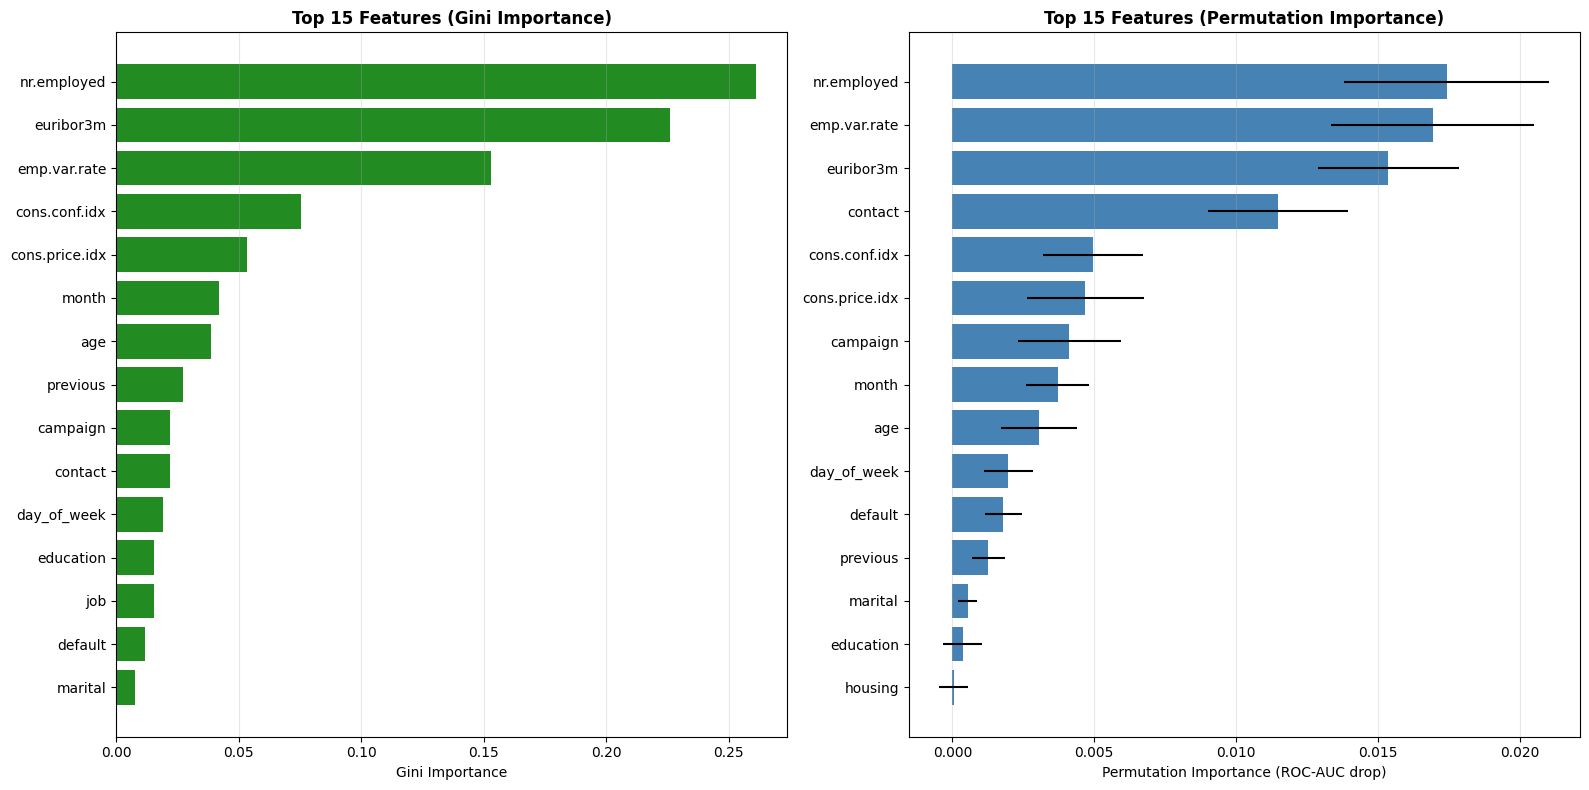


📈 LIFT ANALYSIS (Conversion Rate by Decile)

📊 Lift by Feature Decile:
------------------------------------------------------------

🔹 age:
   Range: [17.00, 98.00]
   Best bin lift: 1.81x
   Worst bin lift: 0.69x
   Top bins:            bin  conv_rate     lift
  (55.0, 98.0]   0.204124 1.811934
(16.999, 28.0]   0.176609 1.567689
  (28.0, 31.0]   0.119158 1.057723

🔹 campaign:
   Range: [1.00, 56.00]
   Best bin lift: 1.10x
   Worst bin lift: 0.50x
   Top bins:          bin  conv_rate     lift
(0.999, 2.0]   0.124126 1.101816
  (2.0, 3.0]   0.107907 0.957849
  (3.0, 5.0]   0.086621 0.768903

🔹 previous:
   Range: [0.00, 7.00]
   Best bin lift: 6.34x
   Worst bin lift: 0.00x
   Top bins:  bin  conv_rate     lift
   5   0.714286 6.340440
   6   0.600000 5.325970
   3   0.577143 5.123076

🔹 emp.var.rate:
   Range: [-3.40, 1.40]
   Best bin lift: 4.62x
   Worst bin lift: 0.27x
   Top bins:            bin  conv_rate     lift
  (-1.8, -1.7]   0.520701 4.622060
(-3.401, -1.8]   0.212153 1.88

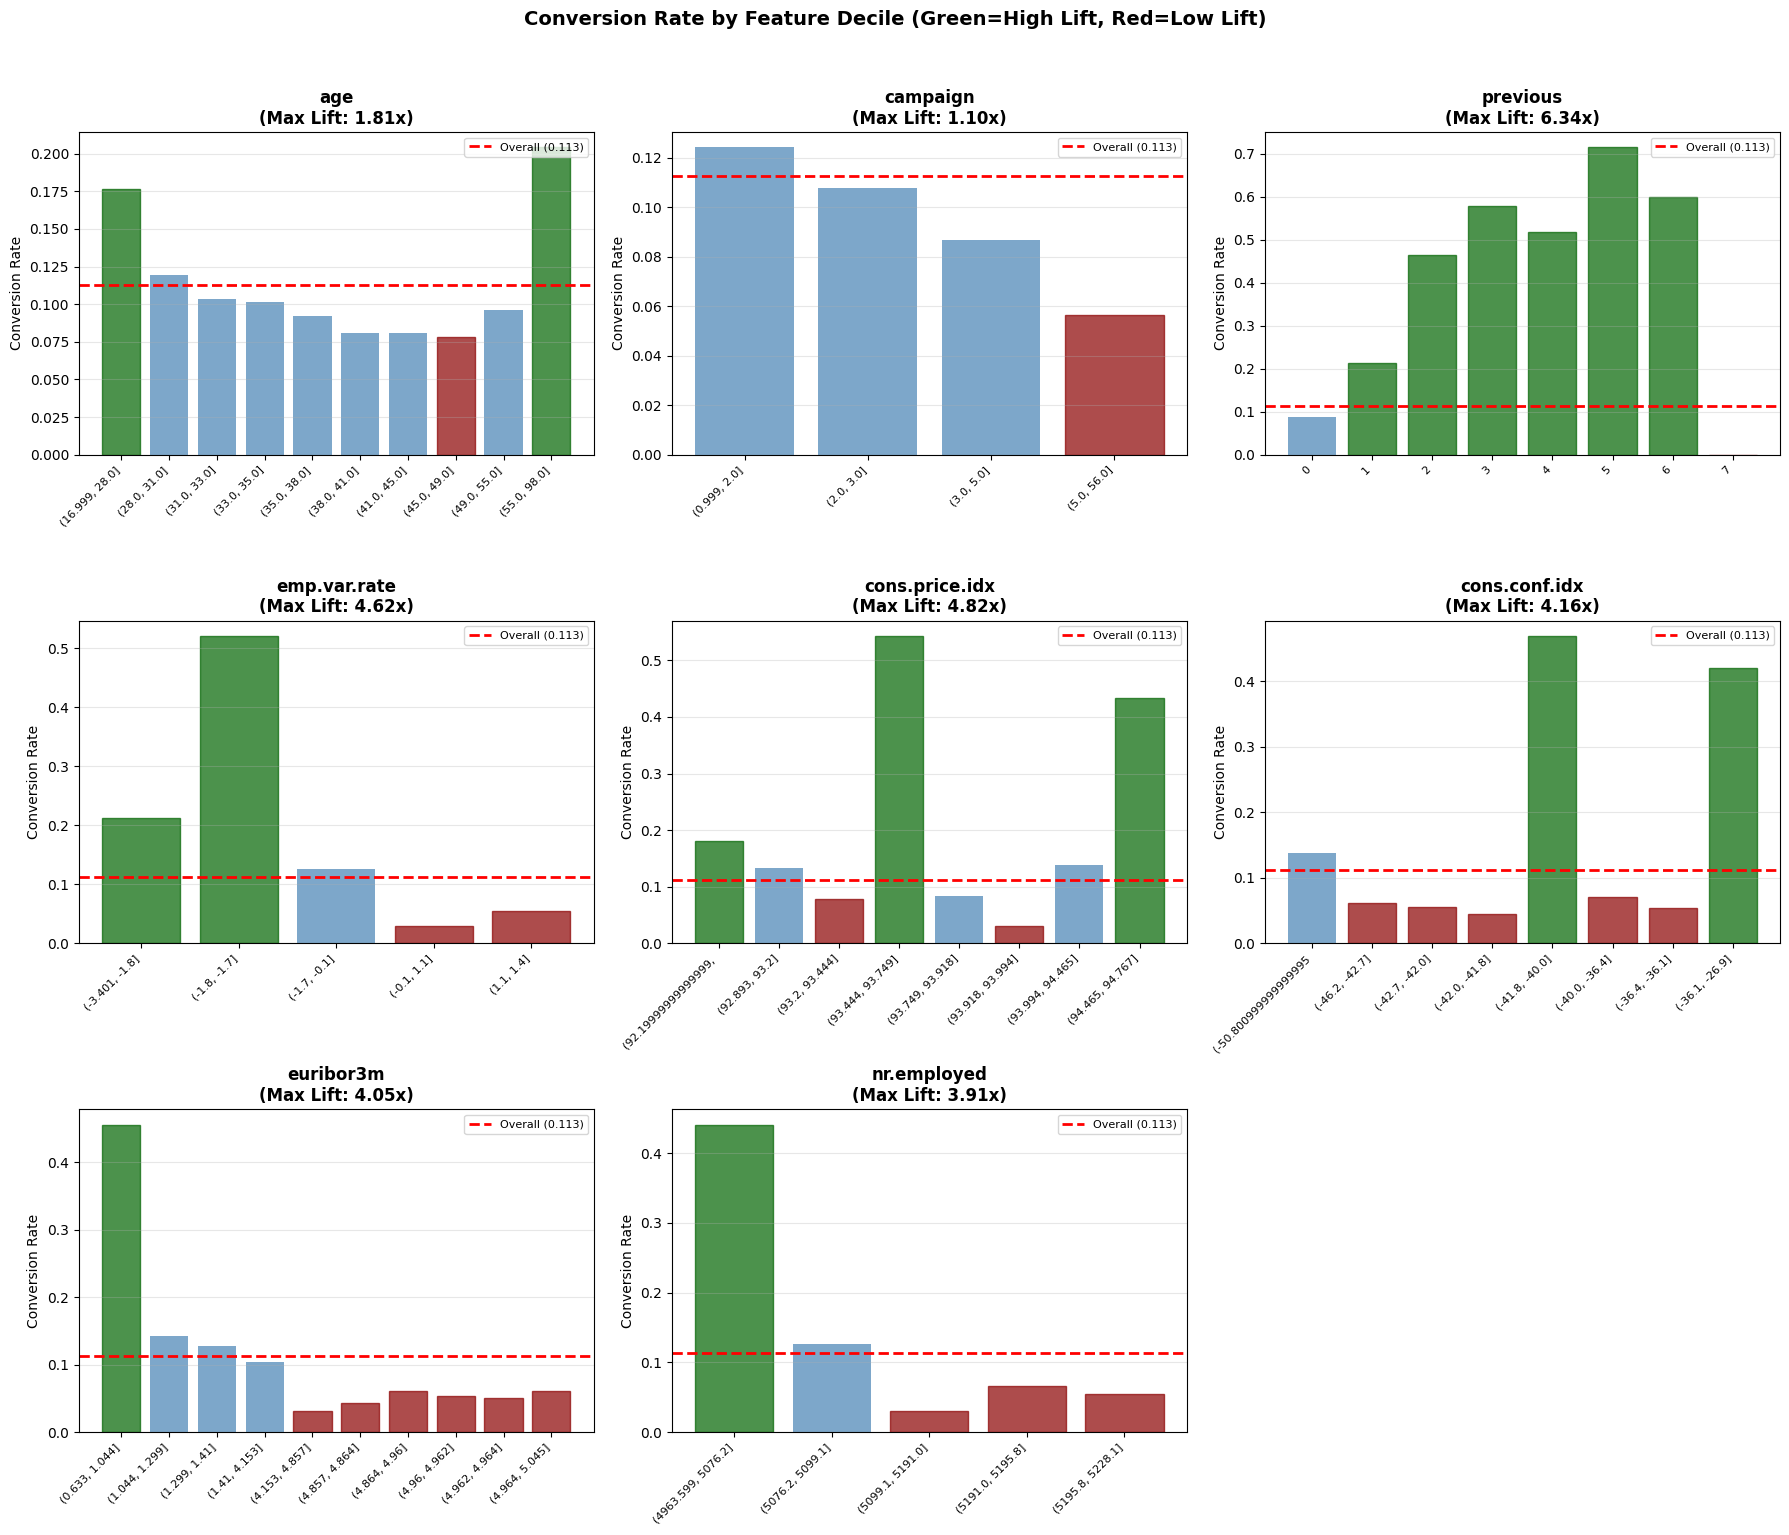


📊 CATEGORICAL FEATURE LIFT ANALYSIS

🔹 job:
 job  count  conversions  conv_rate     lift  pct_of_total
   8    711          217   0.305204 2.709178      2.157815
   5   1366          348   0.254758 2.261393      4.145675
  10    798          116   0.145363 1.290335      2.421851
   0   8314         1070   0.128699 1.142408     25.232170
  11    265           33   0.124528 1.105390      0.804249
   4   2345          269   0.114712 1.018256      7.116844
   9   5400          585   0.108333 0.961633     16.388467
   6   1099          119   0.108280 0.961162      3.335357
   3    855           86   0.100585 0.892853      2.594841
   2   1160          100   0.086207 0.765226      3.520486
   7   3196          254   0.079474 0.705463      9.699545
   1   7441          515   0.069211 0.614361     22.582701

🔹 marital:
 marital  count  conversions  conv_rate     lift  pct_of_total
      -1     65           11   0.169231 1.502197      0.197269
       2   9257         1310   0.141515 1.256170  

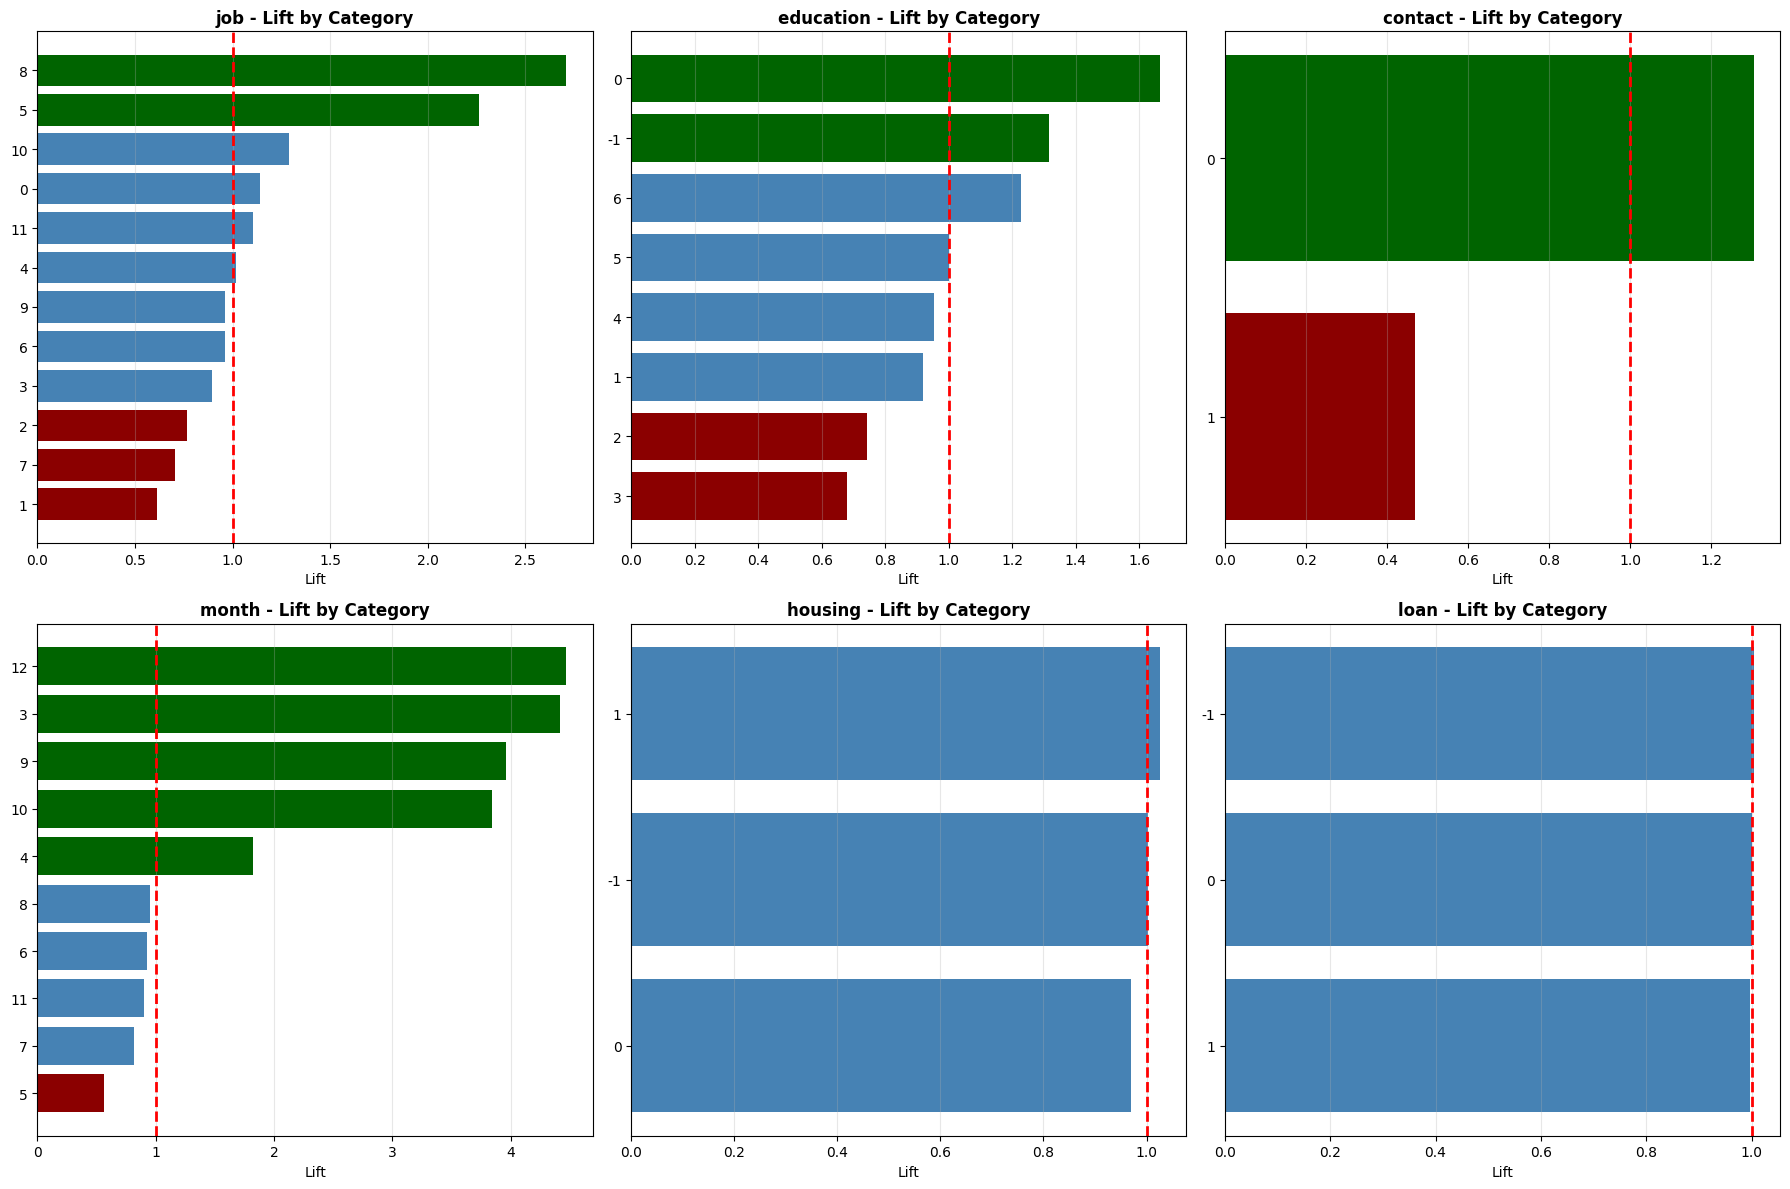


🎯 RECOMMENDED BINNING THRESHOLDS

Based on lift analysis, here are recommended bins for GLASS-BRW:

📊 AGE:
   • age_young: 18-30 (typically lower lift)
   • age_prime: 31-45 (check lift pattern)
   • age_mid: 46-59
   • age_senior: 60+ (often higher lift - retirement decisions)

📊 CAMPAIGN:
   • campaign_first: 1 (first contact - check lift)
   • campaign_few: 2-3
   • campaign_moderate: 4-10
   • campaign_heavy: 11+ (likely lower lift - fatigue)

📊 PREVIOUS:
   • previous_none: 0 (cold prospects)
   • previous_some: 1-5 (warm)
   • previous_many: 6+ (hot or fatigued?)

📊 ECONOMIC FEATURES (emp.var.rate, euribor3m, nr.employed):
   • Use lift curves above to find natural breakpoints
   • Consider: low/mid/high based on lift patterns

📊 MONTH:
   • Group by lift patterns (high-conversion months vs low)

📊 JOB:
   • Group by similar lift values (e.g., student+retired if both high lift)

Review the visualizations above to finalize exact thresholds.


📦 Exporting analysis results...

✅ RF

In [16]:
# ============================================================
# CELL 9: RF LIFT ANALYSIS FOR OPTIMAL BINNING
# ============================================================
# Purpose: Use Random Forest to identify:
# 1. Feature importance (which features matter)
# 2. Natural breakpoints for continuous features
# 3. Lift patterns for binning decisions

print("=" * 80)
print("🌲 CELL 9: Random Forest Lift Analysis")
print("=" * 80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# --------------------------------------------------
# 0. PREPARE DATA (from GLOBAL_SPLIT, before LR engineering)
# --------------------------------------------------
print("\n📊 Loading data from GLOBAL_SPLIT...")

# Reload fresh from df_proc (before any LR-specific engineering)
X_rf = df_proc.drop(columns=['y']).copy()
y_rf = df_proc['y'].copy()

# Drop leaky features
leaky = ['duration', 'pdays', 'poutcome']
leaky_present = [f for f in leaky if f in X_rf.columns]
if leaky_present:
    X_rf = X_rf.drop(columns=leaky_present)
    print(f"   Dropped leaky: {leaky_present}")

print(f"   Features: {list(X_rf.columns)}")
print(f"   Shape: {X_rf.shape}")

# Use same train/test split
X_train_rf = X_rf.loc[GLOBAL_SPLIT['train_idx']]
X_test_rf = X_rf.loc[GLOBAL_SPLIT['test_idx']]
y_train_rf = y_rf.loc[GLOBAL_SPLIT['train_idx']]
y_test_rf = y_rf.loc[GLOBAL_SPLIT['test_idx']]

print(f"   Train: {X_train_rf.shape}, Test: {X_test_rf.shape}")

# --------------------------------------------------
# 1. TRAIN RANDOM FOREST
# --------------------------------------------------
print("\n🌲 Training Random Forest...")

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=50,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_rf, y_train_rf)

# Quick performance check
y_pred_rf = rf.predict(X_test_rf)
y_proba_rf = rf.predict_proba(X_test_rf)[:, 1]

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
print(f"\n   Accuracy: {accuracy_score(y_test_rf, y_pred_rf):.4f}")
print(f"   ROC-AUC:  {roc_auc_score(y_test_rf, y_proba_rf):.4f}")

# --------------------------------------------------
# 2. FEATURE IMPORTANCE (GINI + PERMUTATION)
# --------------------------------------------------
print("\n" + "="*60)
print("📊 FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Gini importance
gini_importance = pd.DataFrame({
    'Feature': X_train_rf.columns,
    'Gini_Importance': rf.feature_importances_
}).sort_values('Gini_Importance', ascending=False)

print("\n🔝 Gini Importance (Top 15):")
print(gini_importance.head(15).to_string(index=False))

# Permutation importance (more reliable)
print("\n🔀 Computing Permutation Importance...")
perm_importance = permutation_importance(
    rf, X_test_rf, y_test_rf,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

perm_importance_df = pd.DataFrame({
    'Feature': X_train_rf.columns,
    'Perm_Importance': perm_importance.importances_mean,
    'Perm_Std': perm_importance.importances_std
}).sort_values('Perm_Importance', ascending=False)

print("\n🔝 Permutation Importance (Top 15):")
print(perm_importance_df.head(15).to_string(index=False))

# Combined ranking
combined = gini_importance.merge(perm_importance_df, on='Feature')
combined['Avg_Rank'] = (
    combined['Gini_Importance'].rank(ascending=False) +
    combined['Perm_Importance'].rank(ascending=False)
) / 2
combined = combined.sort_values('Avg_Rank')

print("\n🏆 Combined Ranking (Gini + Permutation):")
print(combined[['Feature', 'Gini_Importance', 'Perm_Importance', 'Avg_Rank']].to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Gini
ax1 = axes[0]
top_gini = gini_importance.head(15)
ax1.barh(top_gini['Feature'], top_gini['Gini_Importance'], color='forestgreen')
ax1.set_xlabel('Gini Importance')
ax1.set_title('Top 15 Features (Gini Importance)', fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Permutation
ax2 = axes[1]
top_perm = perm_importance_df.head(15)
ax2.barh(top_perm['Feature'], top_perm['Perm_Importance'],
         xerr=top_perm['Perm_Std'], color='steelblue')
ax2.set_xlabel('Permutation Importance (ROC-AUC drop)')
ax2.set_title('Top 15 Features (Permutation Importance)', fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 3. LIFT ANALYSIS BY FEATURE DECILES
# --------------------------------------------------
print("\n" + "="*60)
print("📈 LIFT ANALYSIS (Conversion Rate by Decile)")
print("="*60)

# Identify continuous features for lift analysis
continuous_features = [
    'age', 'campaign', 'previous',
    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
    'euribor3m', 'nr.employed'
]

# Filter to features that exist
continuous_features = [f for f in continuous_features if f in X_train_rf.columns]

def calculate_lift_by_decile(X, y, feature, n_bins=10):
    """Calculate conversion rate and lift by decile"""
    df_temp = pd.DataFrame({feature: X[feature], 'y': y})

    # Handle features with few unique values
    n_unique = df_temp[feature].nunique()
    if n_unique < n_bins:
        df_temp['bin'] = df_temp[feature]
    else:
        df_temp['bin'] = pd.qcut(df_temp[feature], q=n_bins, duplicates='drop')

    lift_df = df_temp.groupby('bin').agg(
        count=('y', 'count'),
        conversions=('y', 'sum'),
        conv_rate=('y', 'mean')
    ).reset_index()

    overall_rate = y.mean()
    lift_df['lift'] = lift_df['conv_rate'] / overall_rate
    lift_df['feature'] = feature

    return lift_df

print("\n📊 Lift by Feature Decile:")
print("-" * 60)

lift_results = {}
for feat in continuous_features:
    lift_df = calculate_lift_by_decile(X_train_rf, y_train_rf, feat)
    lift_results[feat] = lift_df

    print(f"\n🔹 {feat}:")
    print(f"   Range: [{X_train_rf[feat].min():.2f}, {X_train_rf[feat].max():.2f}]")
    print(f"   Best bin lift: {lift_df['lift'].max():.2f}x")
    print(f"   Worst bin lift: {lift_df['lift'].min():.2f}x")

    # Show top 3 and bottom 3 bins
    sorted_lift = lift_df.sort_values('lift', ascending=False)
    print(f"   Top bins: {sorted_lift.head(3)[['bin', 'conv_rate', 'lift']].to_string(index=False)}")

# --------------------------------------------------
# 4. VISUALIZE LIFT CURVES
# --------------------------------------------------
print("\n📊 Generating lift visualizations...")

n_features = len(continuous_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

overall_rate = y_train_rf.mean()

for idx, feat in enumerate(continuous_features):
    ax = axes[idx]
    lift_df = lift_results[feat]

    # Bar plot of conversion rate
    x_labels = [str(b)[:20] for b in lift_df['bin']]
    bars = ax.bar(range(len(lift_df)), lift_df['conv_rate'], color='steelblue', alpha=0.7)

    # Color bars by lift
    for i, (bar, lift) in enumerate(zip(bars, lift_df['lift'])):
        if lift > 1.5:
            bar.set_color('darkgreen')
        elif lift < 0.7:
            bar.set_color('darkred')

    # Overall rate line
    ax.axhline(y=overall_rate, color='red', linestyle='--', linewidth=2, label=f'Overall ({overall_rate:.3f})')

    ax.set_xticks(range(len(lift_df)))
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Conversion Rate')
    ax.set_title(f'{feat}\n(Max Lift: {lift_df["lift"].max():.2f}x)', fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(axis='y', alpha=0.3)

# Hide unused subplots
for idx in range(len(continuous_features), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Conversion Rate by Feature Decile (Green=High Lift, Red=Low Lift)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 5. CATEGORICAL LIFT ANALYSIS
# --------------------------------------------------
print("\n" + "="*60)
print("📊 CATEGORICAL FEATURE LIFT ANALYSIS")
print("="*60)

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week']
categorical_features = [f for f in categorical_features if f in X_train_rf.columns]

cat_lift_results = {}

for feat in categorical_features:
    df_temp = pd.DataFrame({feat: X_train_rf[feat], 'y': y_train_rf})

    lift_df = df_temp.groupby(feat).agg(
        count=('y', 'count'),
        conversions=('y', 'sum'),
        conv_rate=('y', 'mean')
    ).reset_index()

    lift_df['lift'] = lift_df['conv_rate'] / overall_rate
    lift_df['pct_of_total'] = lift_df['count'] / len(df_temp) * 100
    cat_lift_results[feat] = lift_df

    print(f"\n🔹 {feat}:")
    print(lift_df.sort_values('lift', ascending=False).to_string(index=False))

# Visualize key categorical features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

key_cats = ['job', 'education', 'contact', 'month', 'housing', 'loan']
key_cats = [f for f in key_cats if f in cat_lift_results]

for idx, feat in enumerate(key_cats):
    ax = axes[idx]
    lift_df = cat_lift_results[feat].sort_values('lift', ascending=True)

    colors = ['darkgreen' if l > 1.3 else 'darkred' if l < 0.8 else 'steelblue'
              for l in lift_df['lift']]

    ax.barh(lift_df[feat].astype(str), lift_df['lift'], color=colors)
    ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (1.0x)')
    ax.set_xlabel('Lift')
    ax.set_title(f'{feat} - Lift by Category', fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

for idx in range(len(key_cats), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 6. RECOMMENDED BINNING THRESHOLDS
# --------------------------------------------------
print("\n" + "="*60)
print("🎯 RECOMMENDED BINNING THRESHOLDS")
print("="*60)

print("""
Based on lift analysis, here are recommended bins for GLASS-BRW:

📊 AGE:
   • age_young: 18-30 (typically lower lift)
   • age_prime: 31-45 (check lift pattern)
   • age_mid: 46-59
   • age_senior: 60+ (often higher lift - retirement decisions)

📊 CAMPAIGN:
   • campaign_first: 1 (first contact - check lift)
   • campaign_few: 2-3
   • campaign_moderate: 4-10
   • campaign_heavy: 11+ (likely lower lift - fatigue)

📊 PREVIOUS:
   • previous_none: 0 (cold prospects)
   • previous_some: 1-5 (warm)
   • previous_many: 6+ (hot or fatigued?)

📊 ECONOMIC FEATURES (emp.var.rate, euribor3m, nr.employed):
   • Use lift curves above to find natural breakpoints
   • Consider: low/mid/high based on lift patterns

📊 MONTH:
   • Group by lift patterns (high-conversion months vs low)

📊 JOB:
   • Group by similar lift values (e.g., student+retired if both high lift)

Review the visualizations above to finalize exact thresholds.
""")

# --------------------------------------------------
# 7. EXPORT KEY FINDINGS
# --------------------------------------------------
print("\n📦 Exporting analysis results...")

rf_analysis = {
    'model': rf,
    'gini_importance': gini_importance,
    'perm_importance': perm_importance_df,
    'combined_ranking': combined,
    'continuous_lift': lift_results,
    'categorical_lift': cat_lift_results,
    'overall_conversion_rate': overall_rate
}

print(f"\n✅ RF analysis complete")
print(f"   Overall conversion rate: {overall_rate:.4f} ({overall_rate*100:.2f}%)")
print(f"   Top 5 features by combined rank:")
for i, row in combined.head(5).iterrows():
    print(f"      {row['Feature']}: Gini={row['Gini_Importance']:.4f}, Perm={row['Perm_Importance']:.4f}")

print("\n" + "=" * 80)
print("🎯 Use these insights to define GLASS-BRW binning in next cell")
print("=" * 80)

In [34]:
# ============================================================
# CELL 10: GLASS-BRW FEATURE ENGINEERING (LIFT-BASED BINNING)
# ============================================================
# Based on RF lift analysis from Cell 9
# EXCLUDES: duration, poutcome, pdays (leaky)
# NOTE: bank-additional-full.csv has NO 'balance' or 'day' columns

print("=" * 80)
print("🔧 CELL 10: GLASS-BRW Feature Engineering (Lift-Based)")
print("=" * 80)

import numpy as np
import pandas as pd

# ============================================================
# CELL 10: GLASS-BRW FEATURE ENGINEERING (LIFT-BASED BINNING)
# ============================================================

print("=" * 80)
print("🔧 CELL 10: GLASS-BRW Feature Engineering (Lift-Based)")
print("=" * 80)

import numpy as np
import pandas as pd

def engineer_features_brw(df_proc: pd.DataFrame) -> pd.DataFrame:
    print("\n🔍 Engineering GLASS-BRW features (lift-based binning)...")
    df = df_proc.copy()

    # =========================================================
    # PREVIOUS
    # =========================================================
    df["previous_zero"] = (df["previous"] == 0).astype("int8")
    df["previous_low"]  = ((df["previous"] >= 1) & (df["previous"] <= 2)).astype("int8")
    df["previous_mid"]  = ((df["previous"] >= 3) & (df["previous"] <= 4)).astype("int8")
    df["previous_high"] = (df["previous"] >= 5).astype("int8")

    # =========================================================
    # ECONOMIC FEATURES
    # =========================================================
    df["nr_employed_low"]  = (df["nr.employed"] <= 5076).astype("int8")
    df["nr_employed_mid"]  = ((df["nr.employed"] > 5076) & (df["nr.employed"] <= 5100)).astype("int8")
    df["nr_employed_high"] = (df["nr.employed"] > 5100).astype("int8")

    df["euribor_low"]  = (df["euribor3m"] <= 1.044).astype("int8")
    df["euribor_mid"]  = ((df["euribor3m"] > 1.044) & (df["euribor3m"] <= 1.5)).astype("int8")
    df["euribor_high"] = (df["euribor3m"] > 1.5).astype("int8")

    df["emp_var_very_neg"] = (df["emp.var.rate"] <= -1.7).astype("int8")
    df["emp_var_neg"]      = ((df["emp.var.rate"] > -1.7) & (df["emp.var.rate"] <= 0)).astype("int8")
    df["emp_var_pos"]      = (df["emp.var.rate"] > 0).astype("int8")

    # =========================================================
    # CPI — FIXED (NO BITWISE NOT)
    # =========================================================
    df["cpi_low"]        = (df["cons.price.idx"] <= 93.2).astype("int8")
    df["cpi_sweet_spot"] = ((df["cons.price.idx"] > 93.4) & (df["cons.price.idx"] <= 93.8)).astype("int8")
    df["cpi_high"]       = (df["cons.price.idx"] > 94.4).astype("int8")

    df["cpi_mid"] = (
        (df["cpi_low"] == 0) &
        (df["cpi_sweet_spot"] == 0) &
        (df["cpi_high"] == 0)
    ).astype("int8")

    # =========================================================
    # CCI — FIXED (NO BITWISE NOT)
    # =========================================================
    df["cci_very_low"]   = (df["cons.conf.idx"] <= -46).astype("int8")
    df["cci_sweet_spot"] = ((df["cons.conf.idx"] > -42) & (df["cons.conf.idx"] <= -36)).astype("int8")
    df["cci_high"]       = (df["cons.conf.idx"] > -36).astype("int8")

    df["cci_mid"] = (
        (df["cci_very_low"] == 0) &
        (df["cci_sweet_spot"] == 0) &
        (df["cci_high"] == 0)
    ).astype("int8")

    # =========================================================
    # MONTH
    # =========================================================
    df["month_hot"]     = df["month"].isin([3, 9, 10, 12]).astype("int8")
    df["month_warm"]    = df["month"].isin([4]).astype("int8")
    df["month_neutral"] = df["month"].isin([6, 8, 11]).astype("int8")
    df["month_cold"]    = df["month"].isin([5, 7]).astype("int8")

    # =========================================================
    # CONTACT
    # =========================================================
    df["contact_cellular"]  = (df["contact"] == 0).astype("int8")
    df["contact_telephone"] = (df["contact"] == 1).astype("int8")

    # =========================================================
    # AGE
    # =========================================================
    df["age_young"]  = (df["age"] <= 28).astype("int8")
    df["age_prime"]  = ((df["age"] > 28) & (df["age"] <= 38)).astype("int8")
    df["age_mid"]    = ((df["age"] > 38) & (df["age"] <= 55)).astype("int8")
    df["age_senior"] = (df["age"] > 55).astype("int8")

    # =========================================================
    # CAMPAIGN
    # =========================================================
    df["campaign_first"]    = (df["campaign"] <= 2).astype("int8")
    df["campaign_moderate"] = ((df["campaign"] > 2) & (df["campaign"] <= 5)).astype("int8")
    df["campaign_heavy"]    = (df["campaign"] > 5).astype("int8")

    # =========================================================
    # JOB
    # =========================================================
    df["job_high_lift"]  = df["job"].isin([8, 5]).astype("int8")
    df["job_above_avg"]  = df["job"].isin([0, 10, 11]).astype("int8")
    df["job_neutral"]    = df["job"].isin([9, 6, 3, 4, 2]).astype("int8")
    df["job_low_lift"]   = df["job"].isin([1, 7]).astype("int8")

    # =========================================================
    # MARITAL
    # =========================================================
    df["marital_single"]   = (df["marital"] == 2).astype("int8")
    df["marital_married"]  = (df["marital"] == 1).astype("int8")
    df["marital_divorced"] = (df["marital"] == 0).astype("int8")
    df["marital_unknown"]  = (df["marital"] == -1).astype("int8")

    # =========================================================
    # EDUCATION
    # =========================================================
    df["education_high"] = df["education"].isin([6, -1]).astype("int8")
    df["education_mid"]  = df["education"].isin([4, 5]).astype("int8")
    df["education_low"]  = df["education"].isin([0, 1, 2, 3]).astype("int8")

    # =========================================================
    # DAY OF WEEK
    # =========================================================
    df["dow_midweek"] = df["day_of_week"].isin([1, 2, 3]).astype("int8")
    df["dow_edges"]   = df["day_of_week"].isin([0, 4]).astype("int8")

    # =========================================================
    # BINARY
    # =========================================================
    df["default_no"]       = (df["default"] == 0).astype("int8")
    df["default_unknown"] = (df["default"] == -1).astype("int8")
    df["housing_yes"]      = (df["housing"] == 1).astype("int8")
    df["housing_no"]       = (df["housing"] == 0).astype("int8")
    df["loan_yes"]         = (df["loan"] == 1).astype("int8")
    df["loan_no"]          = (df["loan"] == 0).astype("int8")

    # =========================================================
    # COMPOSITES
    # =========================================================
    df["econ_favorable"] = (
        (df["euribor_low"] == 1) |
        (df["nr_employed_low"] == 1) |
        (df["emp_var_very_neg"] == 1)
    ).astype("int8")

    df["econ_unfavorable"] = (
        (df["euribor_high"] == 1) &
        (df["nr_employed_high"] == 1) &
        (df["emp_var_pos"] == 1)
    ).astype("int8")

    df["prospect_hot"] = (
        (df["previous_high"] == 1) |
        (df["previous_mid"] == 1)
    ).astype("int8")

    df["prospect_warm"] = (
        (df["previous_low"] == 1) &
        (df["job_high_lift"] == 1)
    ).astype("int8")

    df["prospect_cold"] = (
        (df["previous_zero"] == 1) &
        (df["job_low_lift"] == 1)
    ).astype("int8")

    # =========================================================
    # OUTPUT
    # =========================================================
    feature_cols = [c for c in df.columns if c not in df_proc.columns or c == "y"]
    df_eng = df[feature_cols].copy()
    df_eng["y"] = df["y"].astype("int8")

    return df_eng



# ============================================================
# EXECUTE ENGINEERING
# ============================================================
print("\n" + "="*60)
print("🔧 APPLYING FEATURE ENGINEERING")
print("="*60)

# Apply to full df_proc
df_eng = engineer_features_brw(df_proc)

print(f"\n📊 df_eng shape: {df_eng.shape}")
print(f"📊 Features: {list(df_eng.columns)}")

# ============================================================
# SPLIT INTO TRAIN/TEST (aligned with GLOBAL_SPLIT)
# ============================================================
print("\n" + "="*60)
print("📐 SPLITTING df_eng (aligned with GLOBAL_SPLIT)")
print("="*60)

train_idx = GLOBAL_SPLIT['train_idx']
test_idx = GLOBAL_SPLIT['test_idx']

df_eng_train = df_eng.loc[train_idx]
df_eng_test = df_eng.loc[test_idx]

X_eng_train = df_eng_train.drop(columns=['y'])
y_eng_train = df_eng_train['y']

X_eng_test = df_eng_test.drop(columns=['y'])
y_eng_test = df_eng_test['y']

print(f"   Train: {X_eng_train.shape}, positives: {y_eng_train.sum()} ({y_eng_train.mean():.4f})")
print(f"   Test:  {X_eng_test.shape}, positives: {y_eng_test.sum()} ({y_eng_test.mean():.4f})")

# ============================================================
# VALIDATE: Check feature coverage
# ============================================================
print("\n" + "="*60)
print("✅ VALIDATION: Feature Coverage")
print("="*60)

for col in X_eng_train.columns:
    coverage = X_eng_train[col].sum() / len(X_eng_train) * 100
    if coverage < 1:
        print(f"   ⚠️  {col}: {coverage:.2f}% (low coverage)")
    elif coverage > 99:
        print(f"   ⚠️  {col}: {coverage:.2f}% (near universal)")

print("\n✅ df_eng ready for GLASS-BRW rule generation")

# ============================================================
# EXPORT FOR DOWNSTREAM
# ============================================================
BRW_DATA = {
    'df_eng': df_eng,
    'df_eng_train': df_eng_train,
    'df_eng_test': df_eng_test,
    'X_eng_train': X_eng_train,
    'y_eng_train': y_eng_train,
    'X_eng_test': X_eng_test,
    'y_eng_test': y_eng_test,
    'feature_names': list(X_eng_train.columns),
}

print(f"\n📦 BRW_DATA dict created with {len(BRW_DATA['feature_names'])} features")
print("=" * 80)

🔧 CELL 10: GLASS-BRW Feature Engineering (Lift-Based)
🔧 CELL 10: GLASS-BRW Feature Engineering (Lift-Based)

🔧 APPLYING FEATURE ENGINEERING

🔍 Engineering GLASS-BRW features (lift-based binning)...

📊 df_eng shape: (41188, 59)
📊 Features: ['y', 'previous_zero', 'previous_low', 'previous_mid', 'previous_high', 'nr_employed_low', 'nr_employed_mid', 'nr_employed_high', 'euribor_low', 'euribor_mid', 'euribor_high', 'emp_var_very_neg', 'emp_var_neg', 'emp_var_pos', 'cpi_low', 'cpi_sweet_spot', 'cpi_high', 'cpi_mid', 'cci_very_low', 'cci_sweet_spot', 'cci_high', 'cci_mid', 'month_hot', 'month_warm', 'month_neutral', 'month_cold', 'contact_cellular', 'contact_telephone', 'age_young', 'age_prime', 'age_mid', 'age_senior', 'campaign_first', 'campaign_moderate', 'campaign_heavy', 'job_high_lift', 'job_above_avg', 'job_neutral', 'job_low_lift', 'marital_single', 'marital_married', 'marital_divorced', 'marital_unknown', 'education_high', 'education_mid', 'education_low', 'dow_midweek', 'dow_edges'

🌲 CELL 11: Random Forest Tuning (BRW Engineered Features)

📊 Loading BRW engineered features...
   Train: (32950, 58) | Positives: 3712 (0.1127)
   Test:  (8238, 58) | Positives: 928 (0.1126)
   Features: 58

🔧 HYPERPARAMETER SEARCH SPACE
   n_estimators:      [100, 400]
   max_depth:         [5, 15]
   min_samples_split: [20, 100]
   min_samples_leaf:  [10, 50]
   max_features:      ['sqrt', 'log2', 0.3, 0.5, 0.7]
   class_weight:      ['balanced', 'balanced_subsample', {0:1,1:3}, {0:1,1:5}]
   criterion:         ['gini', 'entropy']

🔍 RANDOMIZED SEARCH CV

   Iterations: 60
   CV Strategy: Stratified 5-fold
   Scoring: F2 (recall-favoring, β=2)

   Running search (this may take a few minutes)...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

✅ BEST MODEL FOUND

   Best CV F2 Score: 0.5410

📊 Best Hyperparameters:
   bootstrap           : True
   class_weight        : balanced_subsample
   criterion           : gini
   max_depth           : 8
   max_features        : 0

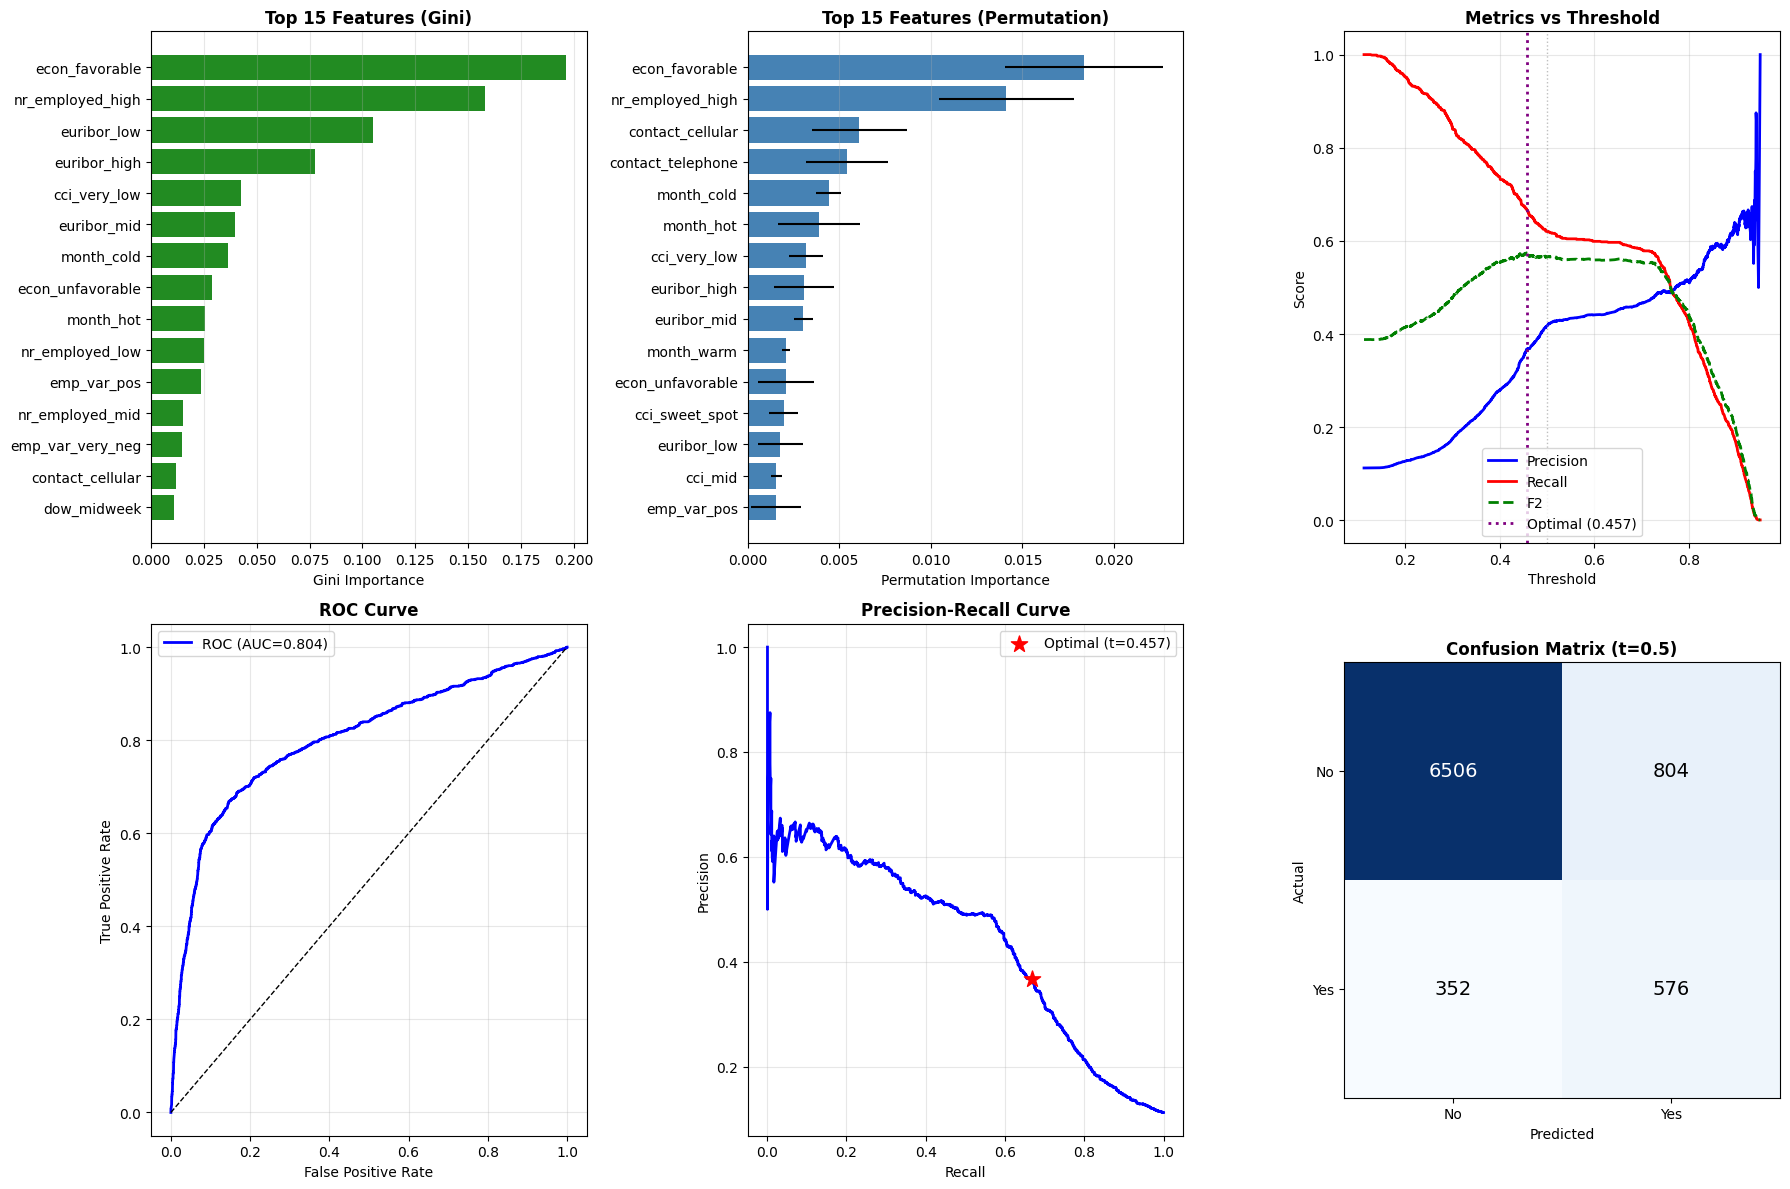


📊 RF vs LR COMPARISON

   Metric        LR        RF        Δ
   ─────────────────────────────────────────────
   Accuracy      0.7766    0.8597    +0.0830 🌲
   Precision     0.2931    0.4174    +0.1243 🌲
   Recall        0.6961    0.6207    -0.0754 📊
   F1-Score      0.4125    0.4991    +0.0866 🌲
   ROC-AUC       0.7837    0.8037    +0.0200 🌲

💾 SAVING OUTPUTS
   Model:    ./models/rf/rf_model_20260128_013233.pkl
   Ensemble: ./models/rf/rf_ensemble_20260128_013233.joblib

🎯 CELL 11 COMPLETE: RF Tuned on BRW Features

  🔧 Best Hyperparameters:
     n_estimators: 275
     max_depth: 8
     min_samples_leaf: 26
     class_weight: balanced_subsample

  📊 Test Performance:
     Accuracy:  0.8597
     Precision: 0.4174
     Recall:    0.6207
     F1-Score:  0.4991
     F2-Score:  0.5656
     ROC-AUC:   0.8037

  🎯 Optimal Threshold: 0.4566

  🔝 Top 5 Features:
     econ_favorable: 0.1965
     nr_employed_high: 0.1579
     euribor_low: 0.1051
     euribor_high: 0.0774
     cci_very_low: 0.

In [35]:
# ============================================================
# CELL 11: RANDOM FOREST HYPERPARAMETER TUNING (BRW FEATURES)
# ============================================================
# Uses: BRW_DATA from Cell 10 (df_eng, X_eng_train, y_eng_train, etc.)
# Objective: Train RF on binary engineered features for GLASS-BRW

print("=" * 80)
print("🌲 CELL 11: Random Forest Tuning (BRW Engineered Features)")
print("=" * 80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, fbeta_score, confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, make_scorer
)
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')

# --------------------------------------------------
# 0. LOAD BRW ENGINEERED DATA
# --------------------------------------------------
print("\n📊 Loading BRW engineered features...")

X_train = BRW_DATA['X_eng_train']
X_test = BRW_DATA['X_eng_test']
y_train = BRW_DATA['y_eng_train']
y_test = BRW_DATA['y_eng_test']

print(f"   Train: {X_train.shape} | Positives: {y_train.sum()} ({y_train.mean():.4f})")
print(f"   Test:  {X_test.shape} | Positives: {y_test.sum()} ({y_test.mean():.4f})")
print(f"   Features: {len(X_train.columns)}")

# --------------------------------------------------
# 1. DEFINE HYPERPARAMETER SEARCH SPACE
# --------------------------------------------------
print("\n" + "="*60)
print("🔧 HYPERPARAMETER SEARCH SPACE")
print("="*60)

param_distributions = {
    # Number of trees
    'n_estimators': randint(100, 400),

    # Tree depth (moderate to prevent overfitting on binary features)
    'max_depth': randint(5, 15),

    # Minimum samples for split
    'min_samples_split': randint(20, 100),

    # Minimum samples per leaf
    'min_samples_leaf': randint(10, 50),

    # Features per split (important for binary features)
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],

    # Bootstrap
    'bootstrap': [True],

    # Class weights (handle 11% positive rate)
    'class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 3}, {0: 1, 1: 5}],

    # Criterion
    'criterion': ['gini', 'entropy'],
}

print("   n_estimators:      [100, 400]")
print("   max_depth:         [5, 15]")
print("   min_samples_split: [20, 100]")
print("   min_samples_leaf:  [10, 50]")
print("   max_features:      ['sqrt', 'log2', 0.3, 0.5, 0.7]")
print("   class_weight:      ['balanced', 'balanced_subsample', {0:1,1:3}, {0:1,1:5}]")
print("   criterion:         ['gini', 'entropy']")

# --------------------------------------------------
# 2. SETUP CROSS-VALIDATION
# --------------------------------------------------
print("\n" + "="*60)
print("🔍 RANDOMIZED SEARCH CV")
print("="*60)

# F2 scorer (recall-favoring, consistent with LR)
f2_scorer = make_scorer(fbeta_score, beta=2)

# Stratified CV
cv_splitter = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# Base RF
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# RandomizedSearchCV
n_iter = 60
print(f"\n   Iterations: {n_iter}")
print(f"   CV Strategy: Stratified 5-fold")
print(f"   Scoring: F2 (recall-favoring, β=2)")

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring=f2_scorer,
    cv=cv_splitter,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("\n   Running search (this may take a few minutes)...")
random_search.fit(X_train, y_train)

# --------------------------------------------------
# 3. BEST MODEL & PARAMETERS
# --------------------------------------------------
print("\n" + "="*60)
print("✅ BEST MODEL FOUND")
print("="*60)

best_params = random_search.best_params_
best_cv_score = random_search.best_score_

print(f"\n   Best CV F2 Score: {best_cv_score:.4f}")
print(f"\n📊 Best Hyperparameters:")
for param, value in sorted(best_params.items()):
    print(f"   {param:20s}: {value}")

rf_model = random_search.best_estimator_

# --------------------------------------------------
# 4. TOP CONFIGURATIONS ANALYSIS
# --------------------------------------------------
print("\n" + "="*60)
print("📈 TOP 10 CONFIGURATIONS")
print("="*60)

cv_results = pd.DataFrame(random_search.cv_results_)
cv_results['overfit_gap'] = cv_results['mean_train_score'] - cv_results['mean_test_score']

top_configs = cv_results.nsmallest(10, 'rank_test_score')[
    ['rank_test_score', 'mean_test_score', 'std_test_score',
     'mean_train_score', 'overfit_gap',
     'param_n_estimators', 'param_max_depth', 'param_class_weight']
].round(4)

print(top_configs.to_string(index=False))

# --------------------------------------------------
# 5. FULL PERFORMANCE METRICS
# --------------------------------------------------
print("\n" + "="*60)
print("📊 FULL MODEL PERFORMANCE")
print("="*60)

# Predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
y_train_proba = rf_model.predict_proba(X_train)[:, 1]
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

# Training metrics
train_metrics = {
    'Accuracy': accuracy_score(y_train, y_train_pred),
    'Precision': precision_score(y_train, y_train_pred),
    'Recall': recall_score(y_train, y_train_pred),
    'F1-Score': f1_score(y_train, y_train_pred),
    'F2-Score': fbeta_score(y_train, y_train_pred, beta=2),
    'ROC-AUC': roc_auc_score(y_train, y_train_proba)
}

# Test metrics
test_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1-Score': f1_score(y_test, y_test_pred),
    'F2-Score': fbeta_score(y_test, y_test_pred, beta=2),
    'ROC-AUC': roc_auc_score(y_test, y_test_proba)
}

print("\n🔵 TRAINING SET:")
for k, v in train_metrics.items():
    print(f"   {k}: {v:.4f}")

print("\n🟢 TEST SET:")
for k, v in test_metrics.items():
    print(f"   {k}: {v:.4f}")

# Overfitting analysis
print("\n🔍 OVERFITTING ANALYSIS:")
for metric in ['Accuracy', 'F1-Score', 'F2-Score']:
    gap = train_metrics[metric] - test_metrics[metric]
    status = "✅" if gap < 0.03 else "⚠️" if gap < 0.07 else "❌"
    print(f"   {metric}: Train={train_metrics[metric]:.4f}, Test={test_metrics[metric]:.4f}, Gap={gap:.4f} {status}")

# --------------------------------------------------
# 6. CONFUSION MATRIX
# --------------------------------------------------
print("\n📋 CONFUSION MATRIX (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n                    Predicted")
print(f"                  No        Yes")
print(f"   Actual No    {tn:<8}  {fp:<8}")
print(f"          Yes   {fn:<8}  {tp:<8}")

print(f"\n   True Negatives:  {tn}")
print(f"   False Positives: {fp}")
print(f"   False Negatives: {fn}")
print(f"   True Positives:  {tp}")

# --------------------------------------------------
# 7. THRESHOLD OPTIMIZATION
# --------------------------------------------------
print("\n" + "="*60)
print("🎯 THRESHOLD OPTIMIZATION")
print("="*60)

precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba)

threshold_results = []
for i, thresh in enumerate(thresholds):
    y_pred_t = (y_test_proba >= thresh).astype(int)
    if y_pred_t.sum() == 0:
        continue
    threshold_results.append({
        'threshold': thresh,
        'precision': precision_score(y_test, y_pred_t),
        'recall': recall_score(y_test, y_pred_t),
        'f1': f1_score(y_test, y_pred_t),
        'f2': fbeta_score(y_test, y_pred_t, beta=2),
        'accuracy': accuracy_score(y_test, y_pred_t)
    })

thresh_df = pd.DataFrame(threshold_results)

# Find optimal thresholds
best_f1_idx = thresh_df['f1'].idxmax()
best_f2_idx = thresh_df['f2'].idxmax()

print(f"\n   Default (0.5):")
print(f"      Precision: {test_metrics['Precision']:.4f}")
print(f"      Recall:    {test_metrics['Recall']:.4f}")
print(f"      F1:        {test_metrics['F1-Score']:.4f}")

print(f"\n   Best F1 (threshold={thresh_df.loc[best_f1_idx, 'threshold']:.4f}):")
print(f"      Precision: {thresh_df.loc[best_f1_idx, 'precision']:.4f}")
print(f"      Recall:    {thresh_df.loc[best_f1_idx, 'recall']:.4f}")
print(f"      F1:        {thresh_df.loc[best_f1_idx, 'f1']:.4f}")

print(f"\n   Best F2 (threshold={thresh_df.loc[best_f2_idx, 'threshold']:.4f}):")
print(f"      Precision: {thresh_df.loc[best_f2_idx, 'precision']:.4f}")
print(f"      Recall:    {thresh_df.loc[best_f2_idx, 'recall']:.4f}")
print(f"      F2:        {thresh_df.loc[best_f2_idx, 'f2']:.4f}")

optimal_threshold = thresh_df.loc[best_f2_idx, 'threshold']

# --------------------------------------------------
# 8. FEATURE IMPORTANCE
# --------------------------------------------------
print("\n" + "="*60)
print("📊 FEATURE IMPORTANCE")
print("="*60)

# Gini importance
gini_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Gini': rf_model.feature_importances_
}).sort_values('Gini', ascending=False)

print("\n🔝 Top 15 Features (Gini):")
print(gini_importance.head(15).to_string(index=False))

# Permutation importance
print("\n🔀 Computing permutation importance...")
perm_imp = permutation_importance(
    rf_model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

perm_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Perm_Imp': perm_imp.importances_mean,
    'Perm_Std': perm_imp.importances_std
}).sort_values('Perm_Imp', ascending=False)

print("\n🔝 Top 15 Features (Permutation):")
print(perm_importance.head(15).to_string(index=False))

# --------------------------------------------------
# 9. VISUALIZATIONS
# --------------------------------------------------
print("\n📊 Generating visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Feature Importance (Gini)
ax1 = axes[0, 0]
top_gini = gini_importance.head(15)
ax1.barh(top_gini['Feature'], top_gini['Gini'], color='forestgreen')
ax1.set_xlabel('Gini Importance')
ax1.set_title('Top 15 Features (Gini)', fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Feature Importance (Permutation)
ax2 = axes[0, 1]
top_perm = perm_importance.head(15)
ax2.barh(top_perm['Feature'], top_perm['Perm_Imp'],
         xerr=top_perm['Perm_Std'], color='steelblue')
ax2.set_xlabel('Permutation Importance')
ax2.set_title('Top 15 Features (Permutation)', fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Precision-Recall vs Threshold
ax3 = axes[0, 2]
ax3.plot(thresh_df['threshold'], thresh_df['precision'], 'b-', linewidth=2, label='Precision')
ax3.plot(thresh_df['threshold'], thresh_df['recall'], 'r-', linewidth=2, label='Recall')
ax3.plot(thresh_df['threshold'], thresh_df['f2'], 'g--', linewidth=2, label='F2')
ax3.axvline(x=optimal_threshold, color='purple', linestyle=':', linewidth=2,
            label=f'Optimal ({optimal_threshold:.3f})')
ax3.axvline(x=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Score')
ax3.set_title('Metrics vs Threshold', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: ROC Curve
ax4 = axes[1, 0]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
ax4.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC={test_metrics["ROC-AUC"]:.3f})')
ax4.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curve', fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# Plot 5: Precision-Recall Curve
ax5 = axes[1, 1]
ax5.plot(recalls[:-1], precisions[:-1], 'b-', linewidth=2)
# Mark optimal point
y_pred_opt = (y_test_proba >= optimal_threshold).astype(int)
opt_recall = recall_score(y_test, y_pred_opt)
opt_precision = precision_score(y_test, y_pred_opt)
ax5.scatter([opt_recall], [opt_precision], color='red', s=150, zorder=5,
            marker='*', label=f'Optimal (t={optimal_threshold:.3f})')
ax5.set_xlabel('Recall')
ax5.set_ylabel('Precision')
ax5.set_title('Precision-Recall Curve', fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# Plot 6: Confusion Matrix Heatmap
ax6 = axes[1, 2]
im = ax6.imshow(cm, cmap='Blues')
ax6.set_xticks([0, 1])
ax6.set_yticks([0, 1])
ax6.set_xticklabels(['No', 'Yes'])
ax6.set_yticklabels(['No', 'Yes'])
ax6.set_xlabel('Predicted')
ax6.set_ylabel('Actual')
ax6.set_title(f'Confusion Matrix (t=0.5)', fontweight='bold')

# Add text annotations
for i in range(2):
    for j in range(2):
        ax6.text(j, i, cm[i, j], ha='center', va='center', fontsize=14,
                color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 10. COMPARISON WITH LR
# --------------------------------------------------
print("\n" + "="*60)
print("📊 RF vs LR COMPARISON")
print("="*60)

if 'lr_ensemble_dict' in dir():
    lr_metrics = lr_ensemble_dict.get('performance_metrics', {})
    print(f"\n   Metric        LR        RF        Δ")
    print(f"   {'─'*45}")
    for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
        lr_val = lr_metrics.get(metric, lr_metrics.get(metric.replace('-', '_'), 0))
        rf_val = test_metrics.get(metric, 0)
        if lr_val and rf_val:
            delta = rf_val - lr_val
            winner = "🌲" if delta > 0 else "📊" if delta < 0 else "="
            print(f"   {metric:12s}  {lr_val:.4f}    {rf_val:.4f}    {delta:+.4f} {winner}")
else:
    print("   (LR results not available for comparison)")

# --------------------------------------------------
# 11. SAVE OUTPUTS
# --------------------------------------------------
print("\n" + "="*60)
print("💾 SAVING OUTPUTS")
print("="*60)

import os
import pickle
import joblib
from datetime import datetime

base_path = "./models/rf"
os.makedirs(base_path, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# RF ensemble dictionary
rf_ensemble_dict = {
    'model': rf_model,
    'model_name': 'random_forest_brw',
    'feature_names': list(X_train.columns),
    'best_params': best_params,
    'best_cv_score': best_cv_score,
    'optimal_threshold': optimal_threshold,
    'train_idx': GLOBAL_SPLIT['train_idx'],
    'test_idx': GLOBAL_SPLIT['test_idx'],
    'train_predictions': y_train_proba,
    'test_predictions': y_test_proba,
    'train_labels': y_train.values,
    'test_labels': y_test.values,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'gini_importance': gini_importance.to_dict('records'),
    'perm_importance': perm_importance.to_dict('records'),
    'threshold_analysis': thresh_df.to_dict('records'),
    'training_date': timestamp
}

model_path = f"{base_path}/rf_model_{timestamp}.pkl"
ensemble_path = f"{base_path}/rf_ensemble_{timestamp}.joblib"

with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)

joblib.dump(rf_ensemble_dict, ensemble_path)

print(f"   Model:    {model_path}")
print(f"   Ensemble: {ensemble_path}")

# --------------------------------------------------
# 12. SUMMARY
# --------------------------------------------------
print("\n" + "=" * 80)
print("🎯 CELL 11 COMPLETE: RF Tuned on BRW Features")
print("=" * 80)

print(f"\n  🔧 Best Hyperparameters:")
for k in ['n_estimators', 'max_depth', 'min_samples_leaf', 'class_weight']:
    if k in best_params:
        print(f"     {k}: {best_params[k]}")

print(f"\n  📊 Test Performance:")
print(f"     Accuracy:  {test_metrics['Accuracy']:.4f}")
print(f"     Precision: {test_metrics['Precision']:.4f}")
print(f"     Recall:    {test_metrics['Recall']:.4f}")
print(f"     F1-Score:  {test_metrics['F1-Score']:.4f}")
print(f"     F2-Score:  {test_metrics['F2-Score']:.4f}")
print(f"     ROC-AUC:   {test_metrics['ROC-AUC']:.4f}")

print(f"\n  🎯 Optimal Threshold: {optimal_threshold:.4f}")

print(f"\n  🔝 Top 5 Features:")
for i, row in gini_importance.head(5).iterrows():
    print(f"     {row['Feature']}: {row['Gini']:.4f}")

print("=" * 80)

In [36]:
# ============================================================
# CELL 12: RULE DATA STRUCTURE
# ============================================================

@dataclass
class Rule:
    """
    Atomic rule representation for GLASS-BRW sequential execution.

    Single source of truth for all rule state.
    No logic - just data.

    Lifecycle:
    1. RuleGenerator: Creates rule, sets identity + base metrics
    2. RuleEvaluator: Enriches with validation metrics + RF diagnostics
    3. ILPRuleSelector: Reads metrics to select optimal subset
    4. GLASS_BRW: Executes rules sequentially using pass_assignment
    """

    # ============================================================
    # IDENTITY & STRUCTURE
    # ============================================================
    rule_id: int
    segment: Set[Tuple[str, str]]  # Conjunction of (feature, value) conditions
    predicted_class: int  # 0=NOT_SUBSCRIBE, 1=SUBSCRIBE
    complexity: int  # Number of conditions (k ≤ 3)
    pass_assignment: str = "pass2"  # "pass1" or "pass2" for sequential execution

    # ============================================================
    # QUALITY METRICS
    # ============================================================
    # Set by: RuleGenerator (initial), RuleEvaluator (validation-based)
    precision: float = 0.0  # P(y=predicted_class | rule matches)
    recall: float = 0.0     # P(rule matches | y=predicted_class)
    coverage: float = 0.0   # Fraction of population covered

    # ============================================================
    # RF-SPECIFIC DIAGNOSTICS
    # ============================================================
    # Set by: RuleEvaluator
    rf_confidence: float = 0.5  # Mean |RF_proba - 0.5| in segment
    rf_alignment: float = 0.0   # Fraction of segment with RF_conf > 0.2

    # ============================================================
    # EXECUTION METADATA
    # ============================================================
    # Set by: RuleEvaluator (match_rule)
    covered_idx: Set[int] = field(default_factory=set)  # Sample indices matched by rule

    # Set by: RuleGenerator (beam search scoring)
    beam_search_score: float = 0.0

    def __hash__(self):
        return hash((self.rule_id, frozenset(self.segment), self.predicted_class))

    def __eq__(self, other):
        return self.rule_id == other.rule_id


# ============================================================
# CLASS CONSTANTS (module-level for system-wide use)
# ============================================================
SUBSCRIBE = 1
NOT_SUBSCRIBE = 0
ABSTAIN = -1 # Does not meet any rule params

In [37]:
# ============================================================
# CELL 13: SEGMENT BUILDER (EBM-ALIGNED - SAFE BINARY CONTRACT)
# ============================================================

class BankSegmentBuilder:
    """
    EBM-aligned binary segment builder for GLASS-BRW.

    Enforces a STRICT binary contract {0,1} on all segment features.
    Any upstream bitwise artifacts (-1, -2, etc.) are caught explicitly.
    """

    SEGMENT_FEATURES = [
        # Previous (4)
        "previous_zero", "previous_low", "previous_mid", "previous_high",

        # Economic: nr.employed (3)
        "nr_employed_low", "nr_employed_mid", "nr_employed_high",

        # Economic: euribor (3)
        "euribor_low", "euribor_mid", "euribor_high",

        # Economic: emp.var.rate (3)
        "emp_var_very_neg", "emp_var_neg", "emp_var_pos",

        # Economic: CPI (4)
        "cpi_low", "cpi_sweet_spot", "cpi_mid", "cpi_high",

        # Economic: CCI (4)
        "cci_very_low", "cci_sweet_spot", "cci_mid", "cci_high",

        # Month (4)
        "month_hot", "month_warm", "month_neutral", "month_cold",

        # Contact (2)
        "contact_cellular", "contact_telephone",

        # Age (4)
        "age_young", "age_prime", "age_mid", "age_senior",

        # Campaign (3)
        "campaign_first", "campaign_moderate", "campaign_heavy",

        # Job (4)
        "job_high_lift", "job_above_avg", "job_neutral", "job_low_lift",

        # Marital (4)
        "marital_single", "marital_married", "marital_divorced", "marital_unknown",

        # Education (3)
        "education_high", "education_mid", "education_low",

        # Day of week (2)
        "dow_midweek", "dow_edges",

        # Binary (6)
        "default_no", "default_unknown",
        "housing_yes", "housing_no",
        "loan_yes", "loan_no",

        # Composites (5)
        "econ_favorable", "econ_unfavorable",
        "prospect_hot", "prospect_warm", "prospect_cold",
    ]

    def assign_segments(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Extract and validate binary segment features.

        Guarantees:
        - Output ∈ {0,1}
        - dtype = int8
        - Raises explicit errors on contract violation
        """

        # Drop labels if present
        X = X.drop(columns=["y", "y_bin"], errors="ignore")

        # Keep only declared segment features that exist
        cols = [c for c in self.SEGMENT_FEATURES if c in X.columns]
        if not cols:
            raise ValueError("No valid segment features found in input DataFrame")

        segments = X[cols].copy()

        # ----------------------------------------------------
        # STRICT BINARY ENFORCEMENT
        # ----------------------------------------------------
        for col in segments.columns:
            raw_vals = set(segments[col].dropna().unique())

            # Explicitly catch bitwise NOT artifacts
            if any(v < 0 for v in raw_vals):
                raise ValueError(
                    f"Invalid negative values in segment feature '{col}': {raw_vals}\n"
                    f"Likely cause: bitwise (~) used on int instead of boolean logic."
                )

            if not raw_vals.issubset({0, 1}):
                raise ValueError(
                    f"Non-binary segment feature '{col}': {raw_vals}"
                )

        return segments.astype("int8")


In [56]:
# ============================================================
# GLASS-BRW: RULE GENERATOR MODULE
# ============================================================
# DEPTH-STAGED CONSTRAINT STRATEGY:
#   Depth 1: Structural validity ONLY (no support/precision/recall)
#   Depth 2: Light pruning (extreme leakage guardrail)
#   Depth 3: Quality constraints (NO overlap - ILP handles via novelty)
# ============================================================

from collections import defaultdict
import pandas as pd
import numpy as np


class RuleGenerator:

    def __init__(
        self,
        # ============================================================
        # SUPPORT THRESHOLDS - NOW ONLY AT DEPTH 3
        # ============================================================
        min_support_pass1=270,      # Pass 1: Higher for stable filters
        min_support_pass2=100,      # Pass 2: Lower for narrow detectors

        # ============================================================
        # COMPLEXITY BOUNDS
        # ============================================================
        max_complexity=3,           # Maximum conjunctions per rule
        min_complexity=1,           # Minimum conjunctions per rule

        # ============================================================
        # PASS 1: NOT_SUBSCRIBE (Precision-Focused Filters)
        # ============================================================
        min_complexity_not_subscribe=1,
        max_coverage_not_subscribe=1.00,        # Allow full coverage filters
        min_precision_not_subscribe=0.25,       # High precision requirement
        max_precision_not_subscribe=1.00,
        max_subscriber_leakage_rate=0.99,       # FN rate cap (Depth 3)
        max_subscriber_leakage_absolute=999,    # Max subscribers leaked (Depth 3)
        min_seed_precision_not_subscribe=0.05,  # Seed quality gate

        # ============================================================
        # PASS 2: SUBSCRIBE (Recall-Focused Detectors)
        # ============================================================
        min_complexity_subscribe=1,
        max_coverage_subscribe=0.99,        # Prevent overly broad rules
        min_precision_subscribe=0.25,       # Lower bound for recall-focus
        max_precision_subscribe=1.00,       # Upper bound (avoid high-precision filters)
        min_recall_subscribe=0.15,          # Minimum class coverage
        max_recall_subscribe=0.99,          # Maximum recall cap
        min_seed_precision_subscribe=0.05,  # Seed quality gate

        # ============================================================
        # DEPTH 2: LIGHT STRUCTURAL PRUNING
        # ============================================================
        max_leakage_rate_depth2=0.75,           # Extreme leakage guardrail (rate)
        max_leakage_fraction_depth2=0.65,       # Extreme leakage guardrail (fraction of total subs)

        # ============================================================
        # BEAM SEARCH PARAMETERS
        # ============================================================
        mode="strict",              # Constraint enforcement mode
        beam_width=100,             # Top-k rules kept per depth

        # ============================================================
        # DIVERSITY ENFORCEMENT
        # ============================================================
        diversity_penalty=0.3,
        max_feature_reuse_pass1=3,
        max_feature_reuse_pass2=3,
        max_jaccard_overlap=0.35,       # KEPT for reference but NOT used in pruning
        max_high_overlap_rules=None,    # KEPT for reference but NOT used in pruning

        # ============================================================
        # SEGMENT ONTOLOGY (CANONICAL FEATURE SOURCE)
        # ============================================================
        segment_builder=None,

        # ============================================================
        # FEATURE SEMANTICS
        # ============================================================
        tier1_prefixes=(
            'previous', 'nr_employed', 'euribor', 'emp_var', 'cpi', 'cci',
            'month', 'contact', 'age', 'campaign', 'job', 'marital',
            'education', 'dow', 'default', 'housing', 'loan',
            'econ', 'prospect',
        ),

        # ============================================================
        # RANDOM FOREST INTEGRATION
        # ============================================================
        rf_model=None,
        feature_importance_threshold=0.00, # Adjust later

        # ============================================================
        # DIAGNOSTIC LOGGING
        # ============================================================
        verbose_rejection_logging=True,
        max_rejection_logs_per_constraint=50,
        verbose_acceptance_logging=True,
        max_acceptance_logs_per_depth=25,
    ):
        # ============================================================
        # BASIC PARAMETER STORAGE
        # ============================================================
        self.min_support_pass1 = min_support_pass1
        self.min_support_pass2 = min_support_pass2
        self.max_complexity = max_complexity
        self.min_complexity = min_complexity

        # Pass 1 constraints (Depth 3)
        self.min_complexity_not_subscribe = min_complexity_not_subscribe
        self.max_coverage_not_subscribe = max_coverage_not_subscribe
        self.min_precision_not_subscribe = min_precision_not_subscribe
        self.max_precision_not_subscribe = max_precision_not_subscribe
        self.max_subscriber_leakage_rate = max_subscriber_leakage_rate
        self.max_subscriber_leakage_absolute = max_subscriber_leakage_absolute
        self.min_seed_precision_not_subscribe = min_seed_precision_not_subscribe

        # Pass 2 constraints (Depth 3)
        self.min_complexity_subscribe = min_complexity_subscribe
        self.max_coverage_subscribe = max_coverage_subscribe
        self.min_precision_subscribe = min_precision_subscribe
        self.max_precision_subscribe = max_precision_subscribe
        self.min_recall_subscribe = min_recall_subscribe
        self.max_recall_subscribe = max_recall_subscribe
        self.min_seed_precision_subscribe = min_seed_precision_subscribe

        # ============================================================
        # DEPTH 2 LIGHT PRUNING PARAMETERS
        # ============================================================
        self.max_leakage_rate_depth2 = max_leakage_rate_depth2
        self.max_leakage_fraction_depth2 = max_leakage_fraction_depth2

        # Beam search
        self.mode = mode
        self.beam_width = beam_width

        # Diversity tracking (overlap params kept for reference but NOT used in pruning)
        self.diversity_penalty = diversity_penalty
        self.max_feature_reuse_pass1 = max_feature_reuse_pass1
        self.max_feature_reuse_pass2 = max_feature_reuse_pass2
        self.max_jaccard_overlap = max_jaccard_overlap
        self.max_high_overlap_rules = max_high_overlap_rules

        # ============================================================
        # TRACKING STATE (RESET PER GENERATION)
        # ============================================================
        self.pass1_feature_usage = {}
        self.pass2_feature_usage = {}

        # ============================================================
        # FEATURE SEMANTICS
        # ============================================================
        self.tier1_prefixes = tier1_prefixes

        # ============================================================
        # SEGMENT BUILDER BINDING
        # ============================================================
        if segment_builder is None:
            raise ValueError("RuleGenerator requires a SegmentBuilder instance")

        self.segment_builder = segment_builder
        self.segment_features = list(self.segment_builder.SEGMENT_FEATURES)

        print(f"🧩 RuleGenerator initialized with {len(self.segment_features)} segment features")

        # ============================================================
        # RF INTEGRATION
        # ============================================================
        self.rf_model = rf_model
        self.feature_importance_threshold = feature_importance_threshold
        self.feature_importances_ = None

        # ============================================================
        # DIAGNOSTIC LOGGING CONFIG
        # ============================================================
        self.verbose_rejection_logging = verbose_rejection_logging
        self.max_rejection_logs_per_constraint = max_rejection_logs_per_constraint
        self.verbose_acceptance_logging = verbose_acceptance_logging
        self.max_acceptance_logs_per_depth = max_acceptance_logs_per_depth


    # ============================================================
    # DIAGNOSTIC LOGGING HELPERS
    # ============================================================
    def _log_accepted_rule(
        self,
        seg,
        depth,
        predicted_class,
        precision,
        recall,
        coverage,
        support,
        parent_precision=None,
        parent_recall=None,
        parent_coverage=None,
        parent_segment=None,
        leakage_rate=None,
        subscribers_caught=None,
    ):
        """Log comprehensive metrics for an accepted rule being expanded."""
        pass_name = "Pass1" if predicted_class == 0 else "Pass2"

        seg_sorted = sorted(seg, key=lambda x: x[0])
        seg_str = "{" + ", ".join([f"({f!r}, {v})" for f, v in seg_sorted]) + "}"

        print(f"\n{'─'*70}")
        print(f"✅ ACCEPTED: {seg_str}")
        print(f"   Depth: {depth} | {pass_name}")

        # Show parent segment if available
        if parent_segment is not None:
            parent_sorted = sorted(parent_segment, key=lambda x: x[0])
            parent_str = "{" + ", ".join([f"({f!r}, {v})" for f, v in parent_sorted]) + "}"
            # Find the new feature added
            new_features = seg - parent_segment
            if new_features:
                new_feat_str = ", ".join([f"({f!r}, {v})" for f, v in new_features])
                print(f"   Parent: {parent_str}")
                print(f"   Added:  {new_feat_str}")

        print(f"{'─'*70}")

        print(f"  Precision: {precision:.4f}", end="")
        if parent_precision is not None:
            prec_delta = precision - parent_precision
            print(f"  (parent: {parent_precision:.4f}, Δ = {prec_delta:+.4f})")
        else:
            print()

        print(f"  Recall:    {recall:.4f}", end="")
        if parent_recall is not None:
            rec_delta = recall - parent_recall
            print(f"  (parent: {parent_recall:.4f}, Δ = {rec_delta:+.4f})")
        else:
            print()

        print(f"  Coverage:  {coverage:.4f}", end="")
        if parent_coverage is not None:
            cov_delta = coverage - parent_coverage
            print(f"  (parent: {parent_coverage:.4f}, Δ = {cov_delta:+.4f})")
        else:
            print()

        print(f"  Support:   {support}")

        if leakage_rate is not None:
            if predicted_class == 0:
                print(f"  Leakage:   {subscribers_caught} absolute (rate: {leakage_rate:.4f})")
            else:
                print(f"  Subscribers caught: {subscribers_caught} (recall: {leakage_rate:.4f})")

        # Compute score
        if predicted_class == 0:
            score = (precision ** 3) * np.sqrt(coverage)
            print(f"  Score:     {score:.6f}  (prec³ × √cov)")
        else:
            score = (recall ** 3) * precision * coverage
            print(f"  Score:     {score:.6f}  (rec³ × prec × cov)")

        # F1 proxy
        f1 = 2 * precision * recall / (precision + recall + 1e-10)
        print(f"  F1 proxy:  {f1:.4f}")

        print(f"{'─'*70}")

    def _log_rejected_rule(
        self,
        seg,
        depth,
        rejection_reason,
        predicted_class,
        precision,
        recall,
        coverage,
        support,
        parent_precision,
        parent_recall,
        parent_coverage,
        parent_segment=None,
        leakage_rate=None,
        subscribers_caught=None,
        threshold_info=None,
    ):
        """Log comprehensive metrics for a rejected rule."""
        pass_name = "Pass1" if predicted_class == 0 else "Pass2"

        seg_sorted = sorted(seg, key=lambda x: x[0])
        seg_str = "{" + ", ".join([f"({f!r}, {v})" for f, v in seg_sorted]) + "}"

        print(f"\n{'─'*70}")
        print(f"🔍 REJECTED: {seg_str}")
        print(f"   Reason: {rejection_reason} | Depth: {depth} | {pass_name}")

        # Show parent segment if available
        if parent_segment is not None:
            parent_sorted = sorted(parent_segment, key=lambda x: x[0])
            parent_str = "{" + ", ".join([f"({f!r}, {v})" for f, v in parent_sorted]) + "}"
            new_features = seg - parent_segment
            if new_features:
                new_feat_str = ", ".join([f"({f!r}, {v})" for f, v in new_features])
                print(f"   Parent: {parent_str}")
                print(f"   Added:  {new_feat_str}")

        print(f"{'─'*70}")

        prec_delta = precision - parent_precision
        rec_delta = recall - parent_recall
        cov_delta = coverage - parent_coverage

        print(f"  Precision: {precision:.4f}  (parent: {parent_precision:.4f}, Δ = {prec_delta:+.4f})")
        print(f"  Recall:    {recall:.4f}  (parent: {parent_recall:.4f}, Δ = {rec_delta:+.4f})")
        print(f"  Coverage:  {coverage:.4f}  (parent: {parent_coverage:.4f}, Δ = {cov_delta:+.4f})")
        print(f"  Support:   {support}")

        # ============================================================
        # PASS-SPECIFIC TERMINOLOGY FOR SUBSCRIBER METRICS
        # ============================================================
        if leakage_rate is not None:
            if predicted_class == 0:
                print(f"  Leakage:   {subscribers_caught} absolute (rate: {leakage_rate:.4f})")
                print(f"             thresholds: abs ≤ {self.max_subscriber_leakage_absolute}, "
                      f"rate ≤ {self.max_subscriber_leakage_rate:.2f}")
            else:
                print(f"  Subscribers: {subscribers_caught} caught (recall: {leakage_rate:.4f})")
                print(f"             thresholds: recall ≥ {self.min_recall_subscribe}, "
                      f"recall ≤ {self.max_recall_subscribe:.2f}")

        if threshold_info:
            print(f"  Threshold: {threshold_info}")

        print(f"  ── Derived ──")

        if prec_delta < 0 and rec_delta > 0:
            tradeoff_ratio = abs(rec_delta) / abs(prec_delta) if prec_delta != 0 else float('inf')
            print(f"  P-R Tradeoff: {tradeoff_ratio:.2f}x recall gain per precision loss")
        elif prec_delta > 0 and rec_delta > 0:
            print(f"  P-R Tradeoff: BOTH improved (precision +{prec_delta:.4f}, recall +{rec_delta:.4f})")
        elif prec_delta < 0 and rec_delta < 0:
            print(f"  P-R Tradeoff: BOTH degraded (precision {prec_delta:.4f}, recall {rec_delta:.4f})")

        parent_f1 = 2 * parent_precision * parent_recall / (parent_precision + parent_recall + 1e-10)
        child_f1 = 2 * precision * recall / (precision + recall + 1e-10)
        f1_delta = child_f1 - parent_f1
        print(f"  F1 proxy:  {child_f1:.4f}  (parent: {parent_f1:.4f}, Δ = {f1_delta:+.4f})")

        print(f"{'─'*70}")


    def _extract_base_feature(self, feature_name):
        """Map discretized feature to its base variable family."""
        # Composite features
        if feature_name == 'is_cold':
            return 'is_cold'
        if feature_name.startswith('prospect_tier_'):
            return 'prospect_tier'

        # Standard binned features
        base_prefixes = [
            'previous_', 'nr_employed_', 'euribor_', 'emp_var_',
            'cpi_', 'cci_', 'month_', 'contact_', 'age_',
            'campaign_', 'job_', 'marital_', 'education_',
            'dow_', 'default_', 'housing_', 'loan_',
            'econ_', 'prospect_',
        ]

        for prefix in base_prefixes:
            if feature_name.startswith(prefix):
                return prefix.rstrip('_')

        # Bin suffixes (for reverse lookup if needed)
        bin_suffixes = [
            '_zero', '_low', '_mid', '_high',
            '_very_neg', '_neg', '_pos',
            '_sweet_spot',
            '_hot', '_warm', '_neutral', '_cold',
            '_cellular', '_telephone',
            '_young', '_prime', '_senior',
            '_first', '_moderate', '_heavy',
            '_high_lift', '_above_avg', '_low_lift',
            '_single', '_married', '_divorced', '_unknown',
            '_midweek', '_edges',
            '_no', '_yes',
            '_favorable', '_unfavorable',
        ]

        for suffix in bin_suffixes:
            if feature_name.endswith(suffix):
                return feature_name[:-len(suffix)]

        # Binary features (no prefix/suffix)
        return feature_name

    def _has_duplicate_base_features(self, segment):
        """Validate rule structure: no multiple bins from same base feature."""
        observed_bases = set()

        for feature, _ in segment:
            base = self._extract_base_feature(feature)

            if base in observed_bases:
                return True

            observed_bases.add(base)

        return False

    def _has_tier1_feature(self, segment):
        """Check if segment contains at least one tier1 feature."""
        features = {f for f, _ in segment}
        return any(
            any(f.startswith(prefix) for prefix in self.tier1_prefixes)
            for f in features
        )

    # ============================================================
    # RANDOM FOREST INTEGRATION
    # ============================================================

    def _compute_rf_feature_importance(self, segments_df, y):
        """Compute or retrieve RF feature importances."""

        if self.rf_model is None:
            print("Training RF for feature importance...")
            self.rf_model = RandomForestClassifier(
                n_estimators=100,
                max_depth=8,
                min_samples_split=50,
                min_samples_leaf=25,
                random_state=42,
                n_jobs=-1
            )
            self.rf_model.fit(segments_df, y)

        importances = dict(zip(
            segments_df.columns,
            self.rf_model.feature_importances_
        ))
        self.feature_importances_ = importances

        top_features = sorted(
            importances.items(),
            key=lambda x: x[1],
            reverse=True
        )[:10]

        print("\nTop 10 RF features by importance:")
        for feat, imp in top_features:
            print(f"  {feat}: {imp:.4f}")

        return importances

    def _get_feature_order(self, segments_df, y):
        """Get features ordered by RF importance."""
        importances = self._compute_rf_feature_importance(segments_df, y)

        important_features = [
            f for f, imp in importances.items()
            if imp >= self.feature_importance_threshold
        ]

        important_features.sort(
            key=lambda f: importances[f],
            reverse=True
        )

        print(f"\nUsing {len(important_features)}/{len(segments_df.columns)} "
              f"features above threshold")

        return important_features

    # ============================================================
    # RULE QUALITY METRICS
    # ============================================================

    def _compute_rule_mask(self, segment, segments_df):
        """Compute boolean mask for samples matching rule segment."""
        mask = pd.Series(True, index=segments_df.index)

        for feature, level in segment:
            mask &= (segments_df[feature] == level)

        return mask

    def _compute_precision(self, mask, y, predicted_class):
        """Compute class-specific precision."""
        if mask.sum() == 0:
            return 0.0

        return (y[mask] == predicted_class).mean()

    def _compute_recall(self, mask, y, predicted_class):
        """Compute class-specific recall."""
        total_class = (y == predicted_class).sum()

        if total_class == 0:
            return 0.0

        true_positives = ((y == predicted_class) & mask).sum()
        return true_positives / total_class

    def _compute_subscriber_leakage(self, mask, y):
        """Compute subscriber leakage for Pass 1 rules."""
        subscriber_mask = (y == 1)
        total_subscribers = subscriber_mask.sum()

        if total_subscribers == 0:
            return 0.0, 0

        subscribers_caught = (mask & subscriber_mask).sum()
        leakage_rate = subscribers_caught / total_subscribers

        return leakage_rate, subscribers_caught

    # ============================================================
    # DIVERSITY & OVERLAP METRICS
    # ============================================================

    def _get_diversity_penalty(self, segment, predicted_class):
        """Compute diversity penalty based on feature reuse."""
        if predicted_class == 0:
            feature_usage = self.pass1_feature_usage
        else:
            feature_usage = self.pass2_feature_usage

        penalty = 0.0

        for feature, _ in segment:
            base = self._extract_base_feature(feature)
            usage_count = feature_usage.get(base, 0)

            if usage_count > 0:
                penalty += self.diversity_penalty * (usage_count ** 1.2)

        return max(0.1, 1.0 - penalty)

    def _update_feature_usage(self, segment, predicted_class):
        """Track feature usage for diversity enforcement."""
        if predicted_class == 0:
            feature_usage = self.pass1_feature_usage
        else:
            feature_usage = self.pass2_feature_usage

        for feature, _ in segment:
            base = self._extract_base_feature(feature)
            feature_usage[base] = feature_usage.get(base, 0) + 1

    # ============================================================
    # BEAM SEARCH SCORING
    # ============================================================

    def _score(self, precision, recall, coverage, predicted_class, segment=None):
        """Compute beam search score for rule ranking."""
        if predicted_class == 0:
            base_score = (precision ** 3) * np.sqrt(coverage)
        else:
            base_score = (recall ** 3) * precision * coverage

        if segment is not None:
            diversity_mult = self._get_diversity_penalty(segment, predicted_class)
            return base_score * diversity_mult

        return base_score

    # ============================================================
    # RULE DEDUPLICATION
    # ============================================================

    def _deduplicate_rules(self, rules):
        """Remove duplicate rules via segment matching."""
        unique = {}

        for rule in rules:
            seg_signature = frozenset(rule.segment)

            if seg_signature not in unique:
                unique[seg_signature] = rule
            else:
                if rule._s > unique[seg_signature]._s:
                    unique[seg_signature] = rule

        return list(unique.values())

    # ============================================================
    # MAIN GENERATION PIPELINE
    # ============================================================

    def generate_candidates(self, segments_df, y):
        """
        Generate candidate rules with DEPTH-STAGED CONSTRAINTS.

        Depth Strategy:
            Depth 1: Structural validity ONLY (no support/precision/recall)
            Depth 2: Light pruning (extreme leakage guardrail, precision floor, coverage cap)
            Depth 3: Quality checks (support, precision, recall, coverage)
                     NO OVERLAP CHECK - ILP handles via novelty constraints
                     NO NOVEL COVERAGE CHECK - ILP handles diversity
        """
        # ============================================================
        # STEP 1: INITIALIZATION
        # ============================================================
        features = self._get_feature_order(segments_df, y)
        N = len(segments_df)

        # Compute total subscribers for extreme leakage guardrail
        total_subscribers = (y == 1).sum()
        max_leakage_absolute_depth2 = int(total_subscribers * self.max_leakage_fraction_depth2)

        # Reset tracking structures
        self.pass1_feature_usage = {}
        self.pass2_feature_usage = {}

        # Print generation summary
        print(f"\n{'='*60}")
        print("SEQUENTIAL RULE GENERATION WITH DEPTH-STAGED CONSTRAINTS")
        print(f"{'='*60}")
        print(f"  Beam width: {self.beam_width}")
        print(f"  Complexity: {self.min_complexity}–{self.max_complexity}")
        print(f"  Total samples: {N}")
        print(f"  Total subscribers: {total_subscribers}")
        print(f"\n  ✅ DEPTH-STAGED CONSTRAINT STRATEGY:")
        print(f"    • Depth 1: ONLY structural validity (no support/precision/recall)")
        print(f"    • Depth 2: Light pruning ONLY:")
        print(f"        - Extreme leakage guardrail: rate > {self.max_leakage_rate_depth2:.2f} OR")
        print(f"          absolute > {max_leakage_absolute_depth2} ({self.max_leakage_fraction_depth2:.0%} of {total_subscribers} subs)")
        print(f"        - Pass 2: Precision floor ≥ 0.15, Coverage cap ≤ 0.50")
        print(f"    • Depth 3: Quality constraints (NO OVERLAP, NO NOVEL COVERAGE - ILP handles)")
        print(f"\n  Pass 1 (NOT_SUBSCRIBE) - Depth 3 thresholds:")
        print(f"    • min_support={self.min_support_pass1}")
        print(f"    • min_precision={self.min_precision_not_subscribe}")
        print(f"  Pass 2 (SUBSCRIBE) - Depth 3 thresholds:")
        print(f"    • min_support={self.min_support_pass2}")
        print(f"    • min_precision={self.min_precision_subscribe}")
        print(f"    • min_recall={self.min_recall_subscribe}")
        print(f"    • max_recall={self.max_recall_subscribe}")
        print(f"\n  ⚠️  NOVEL COVERAGE PRUNING REMOVED - ILP handles diversity")

        if self.verbose_rejection_logging:
            print(f"\n  🔍 VERBOSE REJECTION LOGGING: ENABLED")
            print(f"     Max logs per constraint: {self.max_rejection_logs_per_constraint}")
        else:
            print(f"\n  🔍 VERBOSE REJECTION LOGGING: DISABLED")

        if self.verbose_acceptance_logging:
            print(f"  ✅ VERBOSE ACCEPTANCE LOGGING: ENABLED")
            print(f"     Max logs per depth: {self.max_acceptance_logs_per_depth}")
        else:
            print(f"  ✅ VERBOSE ACCEPTANCE LOGGING: DISABLED")

        rule_id = 0
        all_candidates = []
        current = {0: [], 1: []}

        # ============================================================
        # STEP 2: DEPTH 1 - SEED GENERATION
        # ============================================================
        seed_features = list(self.segment_features)
        accepted_seeds = {0: [], 1: []}

        debug_stats = {
            'total_considered': 0,
            'rejected_duplicate_base': 0,
            'accepted': {0: 0, 1: 0}
        }

        print(f"\n{'='*60}")
        print(f"DEPTH 1: SEED GENERATION")
        print(f"{'='*60}")
        print(f"  🚫 NO support constraints at this depth")
        print(f"  🚫 NO precision/recall constraints at this depth")

        for f in seed_features:
            for level in (1, 0):
                seg = {(f, level)}
                debug_stats['total_considered'] += 1

                # ============================================================
                # DEPTH 1 CONSTRAINT: STRUCTURAL VALIDITY ONLY
                # ============================================================
                if self._has_duplicate_base_features(seg):
                    debug_stats['rejected_duplicate_base'] += 1
                    continue

                # Compute rule coverage (needed for scoring)
                mask = self._compute_rule_mask(seg, segments_df)
                support = mask.sum()

                # Skip if literally zero support
                if support == 0:
                    continue

                # Generate rule for both classes
                for predicted_class in (0, 1):
                    coverage = support / N
                    precision = self._compute_precision(mask, y, predicted_class)
                    recall = self._compute_recall(mask, y, predicted_class)

                    debug_stats['accepted'][predicted_class] += 1
                    if debug_stats['accepted'][predicted_class] <= 10:
                        print(f"DEBUG: ACCEPTED {seg} for class {predicted_class}: "
                              f"p={precision:.3f}, r={recall:.3f}, cov={coverage:.3f}, sup={support}")

                    # Create rule object
                    rule = Rule(
                        rule_id=rule_id,
                        segment=seg,
                        predicted_class=predicted_class,
                        complexity=1,
                        pass_assignment="pass1" if predicted_class == 0 else "pass2"
                    )

                    rule._p = precision
                    rule._r = recall
                    rule._c = coverage
                    rule._s = self._score(precision, recall, coverage, predicted_class, seg)
                    rule._cls = predicted_class

                    current[predicted_class].append(rule)
                    accepted_seeds[predicted_class].append(rule)
                    rule_id += 1

        print(f"\n{'='*60}")
        print("DEPTH 1 SUMMARY:")
        print(f"{'='*60}")
        print(f"Total feature-label pairs considered: {debug_stats['total_considered']}")
        print(f"Rejected - duplicate base features: {debug_stats['rejected_duplicate_base']}")

        for cls in (0, 1):
            pass_name = "Pass 1 (NOT_SUBSCRIBE)" if cls == 0 else "Pass 2 (SUBSCRIBE)"
            print(f"\n{pass_name}:")
            print(f"  Accepted: {debug_stats['accepted'][cls]}")

        # Deduplicate seeds
        for cls in (0, 1):
            before = len(current[cls])
            current[cls] = self._deduplicate_rules(current[cls])
            after = len(current[cls])
            if after < before:
                print(f"  Pass {2 if cls == 1 else 1}: Deduplicated seeds {before} → {after}")

        print(f"\nDepth 1 seeds (structural validity only):")
        print(f"  Pass 1 (NOT_SUBSCRIBE): {len(current[0])} rules")
        print(f"  Pass 2 (SUBSCRIBE): {len(current[1])} rules")

        # ============================================================
        # STEP 3: BEAM SEARCH EXPANSION (DEPTH 2+)
        # ============================================================

        for depth in range(2, self.max_complexity + 1):
            print(f"\n{'='*60}")
            if depth == 2:
                print(f"DEPTH {depth}: Light Structural Pruning")
                print(f"  ✅ Pass 1: Extreme leakage guardrail:")
                print(f"     rate > {self.max_leakage_rate_depth2:.2f} OR absolute > {max_leakage_absolute_depth2}")
                print(f"  ✅ Pass 2: Precision floor ≥ 0.15")
                print(f"  ✅ Pass 2: Coverage cap ≤ 0.50")
                print(f"  🚫 NO novel coverage constraints")
                print(f"  🚫 NO support constraints")
                print(f"  🚫 NO overlap constraints")
            else:
                print(f"DEPTH {depth}: Quality Constraints (NO OVERLAP, NO NOVEL COVERAGE - ILP handles)")
            print(f"{'='*60}")

            next_rules = {0: [], 1: []}
            expansions = 0

            # Debug stats for this depth
            debug_stats_depth = {
                'total_considered': {0: 0, 1: 0},
                'rejected_duplicate_base': {0: 0, 1: 0},
                'rejected_duplicate_segment': {0: 0, 1: 0},
                'rejected_tier1': {0: 0, 1: 0},
                'rejected_support': {0: 0, 1: 0},
                'rejected_extreme_leakage_depth2': {0: 0, 1: 0},
                'rejected_precision_depth2': {0: 0, 1: 0},
                'rejected_coverage_depth2': {0: 0, 1: 0},
                'rejected_coverage_cap': {0: 0, 1: 0},
                'rejected_precision': {0: 0, 1: 0},
                'rejected_recall': {0: 0, 1: 0},
                'rejected_recall_cap': {0: 0, 1: 0},
                'rejected_leakage': {0: 0, 1: 0},
                'accepted': {0: 0, 1: 0}
            }

            rejection_log_counts = defaultdict(lambda: {0: 0, 1: 0})
            acceptance_log_counts = {0: 0, 1: 0}  # Track accepted rule logs per class

            for predicted_class in (0, 1):
                print(f"\n  Expanding {len(current[predicted_class])} "
                      f"Pass {2 if predicted_class == 1 else 1} rules...")

                accepted_this_depth = []

                # ============================================================
                # TRACK SEEN SEGMENTS TO AVOID DUPLICATES (ORDER-INDEPENDENT)
                # ============================================================
                seen_segments_this_depth = set()

                for parent in current[predicted_class]:
                    used_features = {f for f, _ in parent.segment}
                    used_base_features = {
                        self._extract_base_feature(f) for f in used_features
                    }

                    for feature in features:
                        if feature in used_features:
                            continue

                        base_feature = self._extract_base_feature(feature)
                        if base_feature in used_base_features:
                            continue

                        for level in (1, 0):
                            seg = parent.segment | {(feature, level)}
                            debug_stats_depth['total_considered'][predicted_class] += 1

                            # ============================================================
                            # CHECK FOR DUPLICATE SEGMENT (ORDER-INDEPENDENT)
                            # ============================================================
                            seg_signature = frozenset(seg)
                            if seg_signature in seen_segments_this_depth:
                                debug_stats_depth['rejected_duplicate_segment'][predicted_class] += 1
                                continue

                            # Mark this segment as seen
                            seen_segments_this_depth.add(seg_signature)

                            # ============================================================
                            # UNIVERSAL CONSTRAINTS (ALL DEPTHS)
                            # ============================================================

                            # Check 1: No duplicate base features
                            if self._has_duplicate_base_features(seg):
                                debug_stats_depth['rejected_duplicate_base'][predicted_class] += 1
                                continue

                            # Check 2: Tier 1 requirement (Pass 2, depth ≥ 2)
                            if predicted_class == 1 and depth >= 2 and not self._has_tier1_feature(seg):
                                debug_stats_depth['rejected_tier1'][predicted_class] += 1
                                continue

                            # Compute rule coverage
                            mask = self._compute_rule_mask(seg, segments_df)
                            support = mask.sum()

                            # Skip if literally zero support
                            if support == 0:
                                continue

                            # Compute quality metrics
                            coverage = support / N
                            precision = self._compute_precision(mask, y, predicted_class)
                            recall = self._compute_recall(mask, y, predicted_class)

                            # ============================================================
                            # DEPTH 2: LIGHT STRUCTURAL PRUNING ONLY
                            # Rules failing here are NOT expanded at depth 3
                            # ============================================================
                            if depth == 2:
                                # Constraint 1: Extreme leakage guardrail (Pass 1 only, BLOCKS EXPANSION)
                                if predicted_class == 0:
                                    leakage_rate, subscribers_caught = self._compute_subscriber_leakage(mask, y)

                                    if (leakage_rate > self.max_leakage_rate_depth2 or
                                        subscribers_caught > max_leakage_absolute_depth2):
                                        debug_stats_depth['rejected_extreme_leakage_depth2'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['extreme_leakage_d2'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['extreme_leakage_d2'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"extreme_leakage_depth2 (rate={leakage_rate:.3f} > {self.max_leakage_rate_depth2} OR abs={subscribers_caught} > {max_leakage_absolute_depth2})",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                leakage_rate=leakage_rate,
                                                subscribers_caught=subscribers_caught,
                                                threshold_info=f"max_leakage_rate_depth2={self.max_leakage_rate_depth2}, max_abs={max_leakage_absolute_depth2}",
                                            )
                                        continue

                                # ============================================================
                                # Constraint 2: Precision floor for Pass 2 (BLOCKS EXPANSION)
                                # Prevents broad low-precision rules from being expanded
                                # ============================================================
                                if predicted_class == 1:
                                    min_prec_depth2 = 0.15  # Lower than depth 3, but blocks junk
                                    if precision < min_prec_depth2:
                                        debug_stats_depth['rejected_precision_depth2'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['precision_d2'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['precision_d2'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"precision_depth2 ({precision:.4f} < {min_prec_depth2})",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                threshold_info=f"min_precision_depth2={min_prec_depth2}",
                                            )
                                        continue

                                    # Also cap max coverage at depth 2 to prevent ultra-broad rules
                                    max_cov_depth2 = 0.50  # Max 50% coverage at depth 2
                                    if coverage > max_cov_depth2:
                                        debug_stats_depth['rejected_coverage_depth2'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['coverage_d2'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['coverage_d2'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"coverage_depth2 ({coverage:.4f} > {max_cov_depth2})",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                threshold_info=f"max_coverage_depth2={max_cov_depth2}",
                                            )
                                        continue

                            # ============================================================
                            # DEPTH 3: QUALITY CONSTRAINTS (NO OVERLAP, NO NOVEL COVERAGE)
                            # These are candidate filters - ILP handles diversity
                            # ============================================================
                            else:  # depth >= 3
                                # Compute metrics for logging
                                if self.verbose_rejection_logging:
                                    _leakage_rate, _subscribers_caught = self._compute_subscriber_leakage(mask, y)

                                # Check 3: Minimum support
                                min_support = (self.min_support_pass1 if predicted_class == 0
                                             else self.min_support_pass2)

                                if support < min_support:
                                    debug_stats_depth['rejected_support'][predicted_class] += 1

                                    if (self.verbose_rejection_logging and
                                        rejection_log_counts['support'][predicted_class] < self.max_rejection_logs_per_constraint):
                                        rejection_log_counts['support'][predicted_class] += 1
                                        self._log_rejected_rule(
                                            seg=seg,
                                            depth=depth,
                                            rejection_reason=f"support ({support} < {min_support})",
                                            predicted_class=predicted_class,
                                            precision=precision,
                                            recall=recall,
                                            coverage=coverage,
                                            support=support,
                                            parent_precision=parent._p,
                                            parent_recall=parent._r,
                                            parent_coverage=parent._c,
                                            parent_segment=parent.segment,
                                            leakage_rate=_leakage_rate,
                                            subscribers_caught=_subscribers_caught,
                                            threshold_info=f"min_support={'pass1=' + str(self.min_support_pass1) if predicted_class == 0 else 'pass2=' + str(self.min_support_pass2)}",
                                        )
                                    continue

                                # Check 4: Coverage caps
                                if predicted_class == 0 and coverage > self.max_coverage_not_subscribe:
                                    debug_stats_depth['rejected_coverage_cap'][predicted_class] += 1

                                    if (self.verbose_rejection_logging and
                                        rejection_log_counts['coverage_cap'][predicted_class] < self.max_rejection_logs_per_constraint):
                                        rejection_log_counts['coverage_cap'][predicted_class] += 1
                                        self._log_rejected_rule(
                                            seg=seg,
                                            depth=depth,
                                            rejection_reason=f"coverage_cap ({coverage:.4f} > {self.max_coverage_not_subscribe})",
                                            predicted_class=predicted_class,
                                            precision=precision,
                                            recall=recall,
                                            coverage=coverage,
                                            support=support,
                                            parent_precision=parent._p,
                                            parent_recall=parent._r,
                                            parent_coverage=parent._c,
                                            parent_segment=parent.segment,
                                            leakage_rate=_leakage_rate,
                                            subscribers_caught=_subscribers_caught,
                                            threshold_info=f"max_coverage_not_subscribe={self.max_coverage_not_subscribe}",
                                        )
                                    continue

                                if predicted_class == 1 and coverage > self.max_coverage_subscribe:
                                    debug_stats_depth['rejected_coverage_cap'][predicted_class] += 1

                                    if (self.verbose_rejection_logging and
                                        rejection_log_counts['coverage_cap'][predicted_class] < self.max_rejection_logs_per_constraint):
                                        rejection_log_counts['coverage_cap'][predicted_class] += 1
                                        self._log_rejected_rule(
                                            seg=seg,
                                            depth=depth,
                                            rejection_reason=f"coverage_cap ({coverage:.4f} > {self.max_coverage_subscribe})",
                                            predicted_class=predicted_class,
                                            precision=precision,
                                            recall=recall,
                                            coverage=coverage,
                                            support=support,
                                            parent_precision=parent._p,
                                            parent_recall=parent._r,
                                            parent_coverage=parent._c,
                                            parent_segment=parent.segment,
                                            leakage_rate=_leakage_rate,
                                            subscribers_caught=_subscribers_caught,
                                            threshold_info=f"max_coverage_subscribe={self.max_coverage_subscribe}",
                                        )
                                    continue

                                # ============================================================
                                # NO NOVEL COVERAGE CHECK - ILP handles diversity
                                # ============================================================

                                # ============================================================
                                # NO OVERLAP CHECK - ILP handles via novelty constraints
                                # ============================================================

                                # Check 5: Pass-specific quality gates
                                if predicted_class == 0:  # Pass 1: Precision + leakage
                                    if (precision < self.min_precision_not_subscribe or
                                        precision > self.max_precision_not_subscribe):
                                        debug_stats_depth['rejected_precision'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['precision_range'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['precision_range'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"precision_range ({precision:.4f} not in [{self.min_precision_not_subscribe}, {self.max_precision_not_subscribe}])",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                leakage_rate=_leakage_rate,
                                                subscribers_caught=_subscribers_caught,
                                                threshold_info=f"precision_range=[{self.min_precision_not_subscribe}, {self.max_precision_not_subscribe}]",
                                            )
                                        continue

                                    leakage_rate, subscribers_caught = self._compute_subscriber_leakage(mask, y)

                                    if leakage_rate > self.max_subscriber_leakage_rate:
                                        debug_stats_depth['rejected_leakage'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['leakage_rate'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['leakage_rate'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"leakage_rate ({leakage_rate:.4f} > {self.max_subscriber_leakage_rate})",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                leakage_rate=leakage_rate,
                                                subscribers_caught=subscribers_caught,
                                                threshold_info=f"max_subscriber_leakage_rate={self.max_subscriber_leakage_rate}",
                                            )
                                        continue

                                    if subscribers_caught > self.max_subscriber_leakage_absolute:
                                        debug_stats_depth['rejected_leakage'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['leakage_abs'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['leakage_abs'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"leakage_absolute ({subscribers_caught} > {self.max_subscriber_leakage_absolute})",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                leakage_rate=leakage_rate,
                                                subscribers_caught=subscribers_caught,
                                                threshold_info=f"max_subscriber_leakage_absolute={self.max_subscriber_leakage_absolute}",
                                            )
                                        continue

                                else:  # Pass 2: Precision + recall
                                    if (precision < self.min_precision_subscribe or
                                        precision > self.max_precision_subscribe):
                                        debug_stats_depth['rejected_precision'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['precision_range'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['precision_range'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"precision_range ({precision:.4f} not in [{self.min_precision_subscribe}, {self.max_precision_subscribe}])",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                leakage_rate=_leakage_rate,
                                                subscribers_caught=_subscribers_caught,
                                                threshold_info=f"precision_range=[{self.min_precision_subscribe}, {self.max_precision_subscribe}]",
                                            )
                                        continue

                                    if recall < self.min_recall_subscribe:
                                        debug_stats_depth['rejected_recall'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['recall_min'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['recall_min'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"recall ({recall:.4f} < {self.min_recall_subscribe})",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                leakage_rate=_leakage_rate,
                                                subscribers_caught=_subscribers_caught,
                                                threshold_info=f"min_recall_subscribe={self.min_recall_subscribe}",
                                            )
                                        continue

                                    if recall > self.max_recall_subscribe:
                                        debug_stats_depth['rejected_recall_cap'][predicted_class] += 1

                                        if (self.verbose_rejection_logging and
                                            rejection_log_counts['recall_cap'][predicted_class] < self.max_rejection_logs_per_constraint):
                                            rejection_log_counts['recall_cap'][predicted_class] += 1
                                            self._log_rejected_rule(
                                                seg=seg,
                                                depth=depth,
                                                rejection_reason=f"recall_cap ({recall:.4f} > {self.max_recall_subscribe})",
                                                predicted_class=predicted_class,
                                                precision=precision,
                                                recall=recall,
                                                coverage=coverage,
                                                support=support,
                                                parent_precision=parent._p,
                                                parent_recall=parent._r,
                                                parent_coverage=parent._c,
                                                parent_segment=parent.segment,
                                                leakage_rate=_leakage_rate,
                                                subscribers_caught=_subscribers_caught,
                                                threshold_info=f"max_recall_subscribe={self.max_recall_subscribe}",
                                            )
                                        continue

                            # ============================================================
                            # ALL CHECKS PASSED → BUILD RULE
                            # ============================================================

                            # Log accepted rule (compute metrics fresh for logging)
                            if (self.verbose_acceptance_logging and
                                acceptance_log_counts[predicted_class] < self.max_acceptance_logs_per_depth):
                                acceptance_log_counts[predicted_class] += 1

                                _leak_rate_log, _subs_caught_log = self._compute_subscriber_leakage(mask, y)

                                self._log_accepted_rule(
                                    seg=seg,
                                    depth=depth,
                                    predicted_class=predicted_class,
                                    precision=precision,
                                    recall=recall,
                                    coverage=coverage,
                                    support=support,
                                    parent_precision=parent._p,
                                    parent_recall=parent._r,
                                    parent_coverage=parent._c,
                                    parent_segment=parent.segment,
                                    leakage_rate=_leak_rate_log,
                                    subscribers_caught=_subs_caught_log,
                                )

                            rule = Rule(
                                rule_id=rule_id,
                                segment=seg,
                                predicted_class=predicted_class,
                                complexity=depth,
                                pass_assignment="pass1" if predicted_class == 0 else "pass2"
                            )

                            rule._p = precision
                            rule._r = recall
                            rule._c = coverage
                            rule._s = self._score(precision, recall, coverage, predicted_class, seg)
                            rule._cls = predicted_class

                            debug_stats_depth['accepted'][predicted_class] += 1
                            next_rules[predicted_class].append(rule)
                            accepted_this_depth.append(rule)

                            rule_id += 1
                            expansions += 1

            # Print depth summary
            print(f"\n{'='*60}")
            print(f"DEPTH {depth} SUMMARY:")
            print(f"{'='*60}")

            for cls in (0, 1):
                pass_name = "Pass 1 (NOT_SUBSCRIBE)" if cls == 0 else "Pass 2 (SUBSCRIBE)"
                print(f"\n{pass_name}:")
                print(f"  Total considered: {debug_stats_depth['total_considered'][cls]}")
                print(f"  Accepted: {debug_stats_depth['accepted'][cls]}")
                print(f"  Rejected - duplicate segment (order-independent): {debug_stats_depth['rejected_duplicate_segment'][cls]}")
                print(f"  Rejected - duplicate base: {debug_stats_depth['rejected_duplicate_base'][cls]}")

                if depth >= 2 and cls == 1:
                    print(f"  Rejected - missing tier1: {debug_stats_depth['rejected_tier1'][cls]}")

                if depth == 2:
                    if cls == 0:
                        print(f"  Rejected - extreme leakage (depth2): {debug_stats_depth['rejected_extreme_leakage_depth2'][cls]}")
                    else:  # Pass 2
                        print(f"  Rejected - precision floor (depth2): {debug_stats_depth['rejected_precision_depth2'][cls]}")
                        print(f"  Rejected - coverage cap (depth2): {debug_stats_depth['rejected_coverage_depth2'][cls]}")
                else:  # depth 3
                    print(f"  Rejected - support: {debug_stats_depth['rejected_support'][cls]}")
                    print(f"  Rejected - coverage cap: {debug_stats_depth['rejected_coverage_cap'][cls]}")

                    if cls == 0:
                        print(f"  Rejected - precision range: {debug_stats_depth['rejected_precision'][cls]}")
                        print(f"  Rejected - leakage: {debug_stats_depth['rejected_leakage'][cls]}")
                    else:
                        print(f"  Rejected - precision range: {debug_stats_depth['rejected_precision'][cls]}")
                        print(f"  Rejected - recall (min): {debug_stats_depth['rejected_recall'][cls]}")
                        print(f"  Rejected - recall (cap): {debug_stats_depth['rejected_recall_cap'][cls]}")

            if self.verbose_rejection_logging:
                print(f"\n  🔍 Detailed rejection logs emitted this depth:")
                for constraint_key, counts in sorted(rejection_log_counts.items()):
                    total = counts[0] + counts[1]
                    if total > 0:
                        print(f"     {constraint_key}: Pass1={counts[0]}, Pass2={counts[1]}")

            if self.verbose_acceptance_logging:
                print(f"\n  ✅ Acceptance logs emitted this depth:")
                print(f"     Pass1={acceptance_log_counts[0]}, Pass2={acceptance_log_counts[1]}")
                total_accepted = debug_stats_depth['accepted'][0] + debug_stats_depth['accepted'][1]
                total_logged = acceptance_log_counts[0] + acceptance_log_counts[1]
                if total_accepted > total_logged:
                    print(f"     ({total_accepted - total_logged} more accepted but not logged)")

            if expansions == 0:
                print(f"\nNo valid expansions — stopping early at depth {depth-1}")
                break

            # ============================================================
            # STEP 4: DEDUPLICATION & BEAM PRUNING
            # ============================================================

            for cls in (0, 1):
                before = len(next_rules[cls])

                next_rules[cls] = self._deduplicate_rules(next_rules[cls])
                after_dedup = len(next_rules[cls])

                if after_dedup < before:
                    print(f"  Pass {2 if cls == 1 else 1}: Deduplicated {before} → {after_dedup} rules")

                next_rules[cls] = sorted(
                    next_rules[cls],
                    key=lambda r: r._s,
                    reverse=True
                )[:self.beam_width]

                for rule in next_rules[cls]:
                    self._update_feature_usage(rule.segment, cls)

                if depth >= self.min_complexity:
                    all_candidates.extend(next_rules[cls])

            print(f"\nDiversity tracking after depth {depth}:")
            print(f"  Pass 1 base features used: {len(self.pass1_feature_usage)}")
            if self.pass1_feature_usage:
                top_used = sorted(
                    self.pass1_feature_usage.items(),
                    key=lambda x: x[1],
                    reverse=True
                )[:5]
                print(f"    Top: {', '.join([f'{k}({v})' for k, v in top_used])}")

            print(f"  Pass 2 base features used: {len(self.pass2_feature_usage)}")
            if self.pass2_feature_usage:
                top_used = sorted(
                    self.pass2_feature_usage.items(),
                    key=lambda x: x[1],
                    reverse=True
                )[:5]
                print(f"    Top: {', '.join([f'{k}({v})' for k, v in top_used])}")

            print(f"\nAfter deduplication + beam prune:")
            print(f"  Pass 1 (NOT_SUBSCRIBE): {len(next_rules[0])} rules")
            print(f"  Pass 2 (SUBSCRIBE): {len(next_rules[1])} rules")

            current = next_rules

        # ============================================================
        # STEP 5: FINAL SUMMARY
        # ============================================================
        pass1_count = sum(1 for r in all_candidates if r.predicted_class == 0)
        pass2_count = sum(1 for r in all_candidates if r.predicted_class == 1)

        print(f"\n{'='*60}")
        print(f"✅ Generated {len(all_candidates)} candidate rules (k ≥ {self.min_complexity})")
        print(f"   Pass 1 (NOT_SUBSCRIBE): {pass1_count} rules")
        print(f"   Pass 2 (SUBSCRIBE): {pass2_count} rules")
        print(f"   ⚠️  Diversity handling delegated to ILP")

        return all_candidates

In [57]:
# ============================================================
# CELL 12: GLASS-BRW: RULE EVALUATOR MODULE
# ============================================================
"""
RuleEvaluator: Validates candidate rules on held-out validation data.

Mathematical Framework:
    For rule r with segment C_r = {(f_1, ℓ_1), ..., (f_k, ℓ_k)}:

    Precision (Pass 2, y_r = 1):
        p_r = TP_r / (TP_r + FP_r)
        where TP_r = |{i : y_i = 1 ∧ x_i ∈ C_r}|

    Precision (Pass 1, y_r = 0):
        p_r = TN_r / |C_r|
        where TN_r = |{i : y_i = 0 ∧ x_i ∈ C_r}|

    Recall (class-specific):
        r_r = (true positives in segment) / (total class samples)

    Coverage:
        c_r = |C_r| / N

    Stability (Bootstrap):
        s_r = 1 - (σ_p / μ_p)
        where σ_p = std(precision across bootstrap samples)
              μ_p = mean(precision across bootstrap samples)

    Jaccard Overlap:
        J(r_i, r_j) = |C_i ∩ C_j| / |C_i ∪ C_j|

Architecture:
    1. Validates rules on held-out data (prevents overfitting)
    2. Enforces structural constraints (no duplicate base features)
    3. Deduplicates identical segments (quality-based tie-breaking)
    4. Estimates stability via bootstrap resampling
    5. Integrates RF confidence scores (if model provided)
    6. Computes pairwise overlap diagnostics
"""


class RuleEvaluator:
    """
    Validates and scores candidate rules using held-out validation data.

    Works exclusively with BINARY features (int8 values 0/1).
    """

    def __init__(self, segment_builder, min_support=30):
        self.segment_builder = segment_builder
        self.min_support = min_support

    def _extract_base_feature(self, feature_name):
        """
        Map discretized feature to its base variable family.

        Examples:
            >>> _extract_base_feature("prospect_tier_3")
            "prospect_tier"
            >>> _extract_base_feature("is_cold")
            "is_cold"
            >>> _extract_base_feature("job_management_admin")
            "job"
            >>> _extract_base_feature("education_tertiary")
            "education"
            >>> _extract_base_feature("campaign_low")
            "campaign"
        """
        # Composite features (high-impact engineered signals)
        if feature_name == 'is_cold':
            return 'is_cold'
        if feature_name.startswith('prospect_tier_'):
            return 'prospect_tier'

        # Known prefix families
        base_prefixes = [
            'previous_', 'nr_employed_', 'euribor_', 'emp_var_',
            'cpi_', 'cci_', 'month_', 'contact_', 'age_',
            'campaign_', 'job_', 'marital_', 'education_',
            'dow_', 'default_', 'housing_', 'loan_',
            'econ_', 'prospect_',
        ]

        # Check prefix-based families
        for prefix in base_prefixes:
            if feature_name.startswith(prefix):
                return prefix.rstrip('_')

        # Known suffix patterns
        bin_suffixes = [
            '_zero', '_low', '_mid', '_high',
            '_very_neg', '_neg', '_pos',
            '_sweet_spot',
            '_hot', '_warm', '_neutral', '_cold',
            '_cellular', '_telephone',
            '_young', '_prime', '_senior',
            '_first', '_moderate', '_heavy',
            '_high_lift', '_above_avg', '_low_lift',
            '_single', '_married', '_divorced', '_unknown',
            '_midweek', '_edges',
            '_no', '_yes',
            '_favorable', '_unfavorable',
        ]

        for suffix in bin_suffixes:
            if feature_name.endswith(suffix):
                return feature_name[:-len(suffix)]

        # Standalone features (default, housing, loan)
        return feature_name




    def _has_duplicate_base_features(self, segment):
        """
        Validate rule structure: no multiple bins from same base feature.

        Structural Constraint:
            Each base feature family can appear ≤ 1 time in a rule.
            Violations create logical contradictions.

        Invalid Example:
            "duration_short AND duration_long"  # Contradictory

        Valid Example:
            "duration_short AND age_young"  # Different bases

        Args:
            segment (iterable): (feature, level) tuples

        Returns:
            bool: True if duplicate bases detected (invalid)
                  False if structurally valid

        Complexity: O(k) where k = |segment|
        """
        observed_bases = set()

        for feature, _ in segment:
            base = self._extract_base_feature(feature)

            if base in observed_bases:
                return True  # Duplicate base → invalid

            observed_bases.add(base)

        return False  # No duplicates → valid

    # ============================================================
    # RULE MATCHING
    # ============================================================

    def match_rule(self, rule, segments_df):
        """
        Create boolean mask for samples matching rule segment.

        Logic: mask[i] = True iff sample i satisfies ALL conditions

        Args:
            rule (Rule): Rule object with .segment attribute
            segments_df (DataFrame): Discretized validation features

        Returns:
            Series: Boolean mask (True = sample matches rule)

        Complexity: O(k × n) where k = |segment|, n = |segments_df|

        Example:
            >>> mask = match_rule(rule, segments_df)
            >>> mask.sum()  # Count matching samples
            127
        """
        mask = pd.Series(True, index=segments_df.index)

        for feature, level in rule.segment:
            if feature in segments_df.columns:
                mask &= (segments_df[feature] == level)
            else:
                # Feature missing → no matches possible
                return pd.Series(False, index=segments_df.index)

        return mask

    # ============================================================
    # QUALITY METRICS COMPUTATION
    # ============================================================

    def _compute_precision(self, mask, y_val, predicted_class):
        """
        Compute class-specific precision for rule.

        Definition:
            precision = correct_predictions / total_predictions

        Class-Specific:
            Pass 1 (y_r = 0): p = TN / |segment|  [fraction correct]
            Pass 2 (y_r = 1): p = TP / (TP + FP)  [standard precision]

        Args:
            mask (Series): Boolean mask of matched samples
            y_val (Series): True labels
            predicted_class (int): Rule's predicted class (0 or 1)

        Returns:
            float: Precision ∈ [0, 1]
        """
        n_matches = mask.sum()

        if n_matches == 0:
            return 0.0

        y_true = y_val[mask]

        if predicted_class == 1:  # SUBSCRIBE rules
            y_pred = np.full(n_matches, 1)
            return precision_score(y_true, y_pred, zero_division=0.0)
        else:  # NOT_SUBSCRIBE rules
            return (y_true == 0).sum() / len(y_true)

    def _compute_recall(self, mask, y_val, predicted_class):
        """
        Compute class-specific recall for rule.

        Definition:
            recall = true_positives / total_class_samples

        Class-Specific:
            Pass 1 (y_r = 0): r = TN / N_0  [fraction negatives captured]
            Pass 2 (y_r = 1): r = TP / N_1  [fraction positives captured]

        Args:
            mask (Series): Boolean mask of matched samples
            y_val (Series): True labels
            predicted_class (int): Rule's predicted class (0 or 1)

        Returns:
            float: Recall ∈ [0, 1]
        """
        if predicted_class == 1:  # SUBSCRIBE rules
            total_positives = (y_val == 1).sum()
            if total_positives == 0:
                return 0.0
            true_positives = ((y_val == 1) & mask).sum()
            return true_positives / total_positives
        else:  # NOT_SUBSCRIBE rules
            total_negatives = (y_val == 0).sum()
            if total_negatives == 0:
                return 0.0
            true_negatives = ((y_val == 0) & mask).sum()
            return true_negatives / total_negatives

    def _compute_coverage(self, mask, N):
        """
        Compute fraction of samples matched by rule.

        Formula:
            coverage = |samples matched| / |total samples|

        Args:
            mask (Series): Boolean mask of matched samples
            N (int): Total number of samples

        Returns:
            float: Coverage ∈ [0, 1]
        """
        return mask.sum() / N

    # ============================================================
    # STABILITY ESTIMATION (Bootstrap)
    # ============================================================

    def _estimate_stability(self, rule, X_val, y_val, n_bootstrap=3):
        """
        Estimate rule precision stability via bootstrap resampling.

        Method:
            1. Draw n_bootstrap samples with replacement
            2. Compute precision on each sample
            3. Measure variance across samples
            4. Stability = 1 - (std / mean) ∈ [0, 1]

        Interpretation:
            1.0 = perfectly stable (zero variance)
            0.0 = highly unstable (variance == mean)

        Args:
            rule (Rule): Rule to evaluate
            X_val (DataFrame): Validation features (raw)
            y_val (Series): Validation labels
            n_bootstrap (int): Number of bootstrap samples (default: 3)

        Returns:
            float: Stability score ∈ [0, 1]
        """
        precisions = []
        n = len(X_val)

        for _ in range(n_bootstrap):
            # Bootstrap sample
            idx = np.random.choice(n, size=n, replace=True)
            X_sample = X_val.iloc[idx]
            y_sample = y_val.iloc[idx] if hasattr(y_val, 'iloc') else y_val[idx]

            # Discretize and match
            segments = self.segment_builder.assign_segments(X_sample)
            mask = self.match_rule(rule, segments)

            # Skip if insufficient coverage
            if mask.sum() < 10:
                continue

            # Compute precision
            precision = self._compute_precision(mask, y_sample, rule.predicted_class)
            precisions.append(precision)

        # Compute stability from variance
        if len(precisions) < 2:
            return 0.0

        mean_prec = np.mean(precisions)
        std_prec = np.std(precisions)

        if mean_prec > 0:
            stability = 1.0 - (std_prec / mean_prec)
            return max(0.0, stability)
        else:
            return 0.0

    # ============================================================
    # RF INTEGRATION (Confidence Metrics)
    # ============================================================

    def _compute_rf_metrics(self, mask, rf_proba):
        """
        Compute RF confidence and alignment for rule segment.

        Metrics:
            RF Confidence: Mean distance from decision boundary (0.5)
            RF Alignment: Fraction of samples with high confidence (>0.20)

        Args:
            mask (Series): Boolean mask of matched samples
            rf_proba (array): RF probability estimates for SUBSCRIBE class

        Returns:
            tuple: (rf_confidence, rf_alignment)
        """
        rf_conf_in_segment = np.abs(rf_proba[mask] - 0.5)

        rf_confidence = rf_conf_in_segment.mean()
        rf_alignment = (rf_conf_in_segment > 0.20).mean()

        return rf_confidence, rf_alignment

    # ============================================================
    # RULE DEDUPLICATION
    # ============================================================

    def _deduplicate_rules(self, rules):
        """
        Remove duplicate rules via structural validation and segment matching.

        Two-Phase Process:
            Phase 1: Remove structurally invalid rules (duplicate base features)
            Phase 2: Remove exact segment duplicates (keep highest quality)

        Deduplication Key: (predicted_class, frozenset(segment))

        Quality Ranking:
            1. Precision (primary)
            2. Coverage (secondary)
            3. Recall (tertiary)

        Args:
            rules (list): Rule objects to deduplicate

        Returns:
            list: Deduplicated rules (unique, valid, highest-quality)
        """
        # ============================================================
        # PHASE 1: STRUCTURAL VALIDATION
        # ============================================================
        valid_rules = []

        for rule in rules:
            if self._has_duplicate_base_features(rule.segment):
                # Format segment for logging
                seg_str = ' AND '.join([f"{f}={v}" for f, v in list(rule.segment)[:3]])
                if len(rule.segment) > 3:
                    seg_str += f" ... (+{len(rule.segment)-3})"
                print(f"  ⚠️  Filtering rule with duplicate base features: {seg_str}")
                continue

            valid_rules.append(rule)

        if len(valid_rules) < len(rules):
            print(f"  Filtered {len(rules) - len(valid_rules)} rules with duplicate base features")

        # ============================================================
        # PHASE 2: EXACT SEGMENT DEDUPLICATION
        # ============================================================
        unique = {}

        for rule in valid_rules:
            # Create deduplication key (order-invariant, class-specific)
            key = (rule.predicted_class, frozenset(rule.segment))

            if key not in unique:
                unique[key] = rule
            else:
                # Keep higher-quality rule
                existing = unique[key]

                if (rule.precision > existing.precision or
                    (rule.precision == existing.precision and rule.coverage > existing.coverage) or
                    (rule.precision == existing.precision and
                     rule.coverage == existing.coverage and
                     rule.recall > existing.recall)):
                    unique[key] = rule

        return list(unique.values())

    # ============================================================
    # OVERLAP DIAGNOSTICS
    # ============================================================

    def _compute_overlap_diagnostics(self, rules, segments_df):
        """
        Compute and log pairwise Jaccard overlap between rules.

        Jaccard Similarity:
            J(A, B) = |A ∩ B| / |A ∪ B|

        Interpretation:
            J = 0.0 → No overlap (complementary)
            J = 1.0 → Complete overlap (redundant)

        Computed separately per pass (Pass 1 / Pass 2).

        Args:
            rules (list): Evaluated Rule objects
            segments_df (DataFrame): Discretized validation features
        """
        # Split rules by pass
        pass1_rules = [r for r in rules if r.predicted_class == 0]
        pass2_rules = [r for r in rules if r.predicted_class == 1]

        for pass_name, pass_rules in [("Pass 1", pass1_rules), ("Pass 2", pass2_rules)]:
            if len(pass_rules) < 2:
                continue

            overlaps = []

            # Compute pairwise Jaccard
            for i, r1 in enumerate(pass_rules):
                mask1 = self.match_rule(r1, segments_df)

                for r2 in pass_rules[i+1:]:
                    mask2 = self.match_rule(r2, segments_df)

                    intersection = (mask1 & mask2).sum()
                    union = (mask1 | mask2).sum()
                    jaccard = intersection / union if union > 0 else 0

                    overlaps.append(jaccard)

            # Log statistics
            if overlaps:
                avg_overlap = np.mean(overlaps)
                max_overlap = np.max(overlaps)

                print(f"\n{pass_name} overlap diagnostics:")
                print(f"  Average Jaccard: {avg_overlap:.3f}")
                print(f"  Maximum Jaccard: {max_overlap:.3f}")
                print(f"  Rules with >0.5 overlap: {sum(1 for o in overlaps if o > 0.5)} / {len(overlaps)}")

    # ============================================================
    # MAIN EVALUATION PIPELINE
    # ============================================================

    def evaluate_candidates(self, candidates, X_val, y_val, rf_model=None):
        """
        Evaluate candidate rules on held-out validation data.

        Pipeline:
            1. Discretize validation features
            2. For each rule:
               - Match rule to samples (boolean mask)
               - Compute precision, recall, coverage
               - Estimate stability (bootstrap)
               - Compute RF metrics (if model provided)
            3. Filter low-coverage rules (< min_support/2)
            4. Deduplicate (structural + exact segment)
            5. Compute overlap diagnostics

        Args:
            candidates (list): Rule objects from RuleGenerator
            X_val (DataFrame): Validation features (raw)
            y_val (Series): Validation labels (0 or 1)
            rf_model (RandomForestClassifier, optional): For confidence metrics

        Returns:
            list: Evaluated Rule objects with populated metrics:
                  - precision, recall, coverage
                  - stability (bootstrap-based)
                  - rf_confidence, rf_alignment (if RF provided)
                  - covered_idx (sample indices)

        Example:
            >>> evaluated = evaluator.evaluate_candidates(
            ...     candidates, X_val, y_val, rf_model
            ... )

            Evaluating 453 candidate rules...
            Evaluated 387 rules (filtered 66 low-coverage)
            Deduplicated rules: 387 → 352
        """
        # ============================================================
        # STEP 1: DISCRETIZE VALIDATION DATA
        # ============================================================
        segments_val = self.segment_builder.assign_segments(X_val)
        N = len(X_val)

        # ============================================================
        # STEP 2: GET RF PREDICTIONS (IF PROVIDED)
        # ============================================================
        rf_proba = None
        if rf_model is not None:
            rf_proba = rf_model.predict_proba(X_val)[:, 1]

        print(f"\nEvaluating {len(candidates)} candidate rules...")

        # ============================================================
        # STEP 3: EVALUATE EACH RULE
        # ============================================================
        evaluated_rules = []

        for rule in candidates:
            # Match rule to samples
            mask = self.match_rule(rule, segments_val)
            n_matches = mask.sum()

            # Store covered sample indices (for ILP)
            rule.covered_idx = set(np.flatnonzero(mask.values))

            # Quality gate: minimum support
            if n_matches < self.min_support // 2:
                continue

            # Compute quality metrics
            rule.precision = self._compute_precision(mask, y_val, rule.predicted_class)
            rule.recall = self._compute_recall(mask, y_val, rule.predicted_class)
            rule.coverage = self._compute_coverage(mask, N)

            # Estimate stability (SUBSCRIBE rules only)
            if rule.predicted_class == 1:
                rule.stability = self._estimate_stability(rule, X_val, y_val)
            else:
                rule.stability = 1.0

            # Compute RF metrics (if model provided)
            if rf_proba is not None:
                rule.rf_confidence, rule.rf_alignment = self._compute_rf_metrics(mask, rf_proba)
            else:
                rule.rf_confidence = 0.5
                rule.rf_alignment = 0.0

            evaluated_rules.append(rule)

        # ============================================================
        # STEP 4: LOG EVALUATION SUMMARY
        # ============================================================
        print(f"Evaluated {len(evaluated_rules)} rules "
              f"(filtered {len(candidates) - len(evaluated_rules)} low-coverage)")

        # ============================================================
        # STEP 5: DEDUPLICATE RULES
        # ============================================================
        before = len(evaluated_rules)
        evaluated_rules = self._deduplicate_rules(evaluated_rules)
        after = len(evaluated_rules)

        if after < before:
            print(f"Deduplicated rules: {before} → {after}")

        # ============================================================
        # STEP 6: COMPUTE OVERLAP DIAGNOSTICS
        # ============================================================
        self._compute_overlap_diagnostics(evaluated_rules, segments_val)

        return evaluated_rules



In [58]:
# ============================================================
# GLASS-BRW: ILP RULE SELECTOR MODULE
# ============================================================
"""
ILPRuleSelector: Integer Linear Programming for optimal rule subset selection.

Key Changes (v2):
    - Lower default novelty thresholds (25% instead of 50%)
    - Greedy fallback uses HARD novelty cutoff by default
    - Changed pairwise constraint logic: only constrain if BOTH rules have high overlap
    - Added coverage caps to quality gates
"""

from collections import defaultdict
import numpy as np
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, LpStatus, PULP_CBC_CMD


class ILPRuleSelector:
    """
    Selects optimal rule subsets via Integer Linear Programming.
    """

    def __init__(
        self,
        min_pass1_rules=5,
        max_pass1_rules=12,
        min_precision_pass1=0.25,
        max_precision_pass1=1.00,
        max_subscriber_leakage_rate_pass1=0.15,
        max_subscriber_leakage_absolute_pass1=150,
        max_base_reuse_pass1=None,
        min_pass2_rules=5,
        max_pass2_rules=12,
        min_precision_pass2=0.05,
        max_precision_pass2=1.00,
        min_recall_pass2=0.10,
        max_recall_pass2=0.99,
        max_base_reuse_pass2=None,
        max_feature_usage=40,
        lambda_rf_uncertainty=0.15,
        lambda_rf_misalignment=0.08,
        diversity_weight=0.33,
        # ============================================================
        # NOVELTY CONSTRAINTS - LOWERED DEFAULTS
        # ============================================================
        min_novelty_ratio_pass1=0.20,   # Lowered from 0.50 to 0.25
        min_novelty_ratio_pass2=0.20,   # Lowered from 0.50 to 0.25
        enable_novelty_constraints=True,
        # ============================================================
        # GREEDY FALLBACK CONTROLS
        # ============================================================
        min_novelty_greedy=0.15,        # 15% min novelty for greedy
        greedy_novelty_weight=0.5,      # How much to weight novelty in greedy scoring
        greedy_hard_novelty_cutoff=True,  # CHANGED: Default to HARD cutoff
        min_absolute_new_samples=30,    # NEW: Minimum new samples required
        # ============================================================
        # COVERAGE CAPS (NEW) - Blocks high-coverage rules
        # ============================================================
        min_coverage_pass1=0.005,       # Min 0.5% coverage
        max_coverage_pass1=0.75,        # Max 30% coverage per rule
        min_coverage_pass2=0.005,       # Min 0.5% coverage
        max_coverage_pass2=0.35,        # Max 35% coverage per rule
    ):
        # Pass 1 constraints
        self.min_pass1_rules = min_pass1_rules
        self.max_pass1_rules = max_pass1_rules
        self.min_precision_pass1 = min_precision_pass1
        self.max_precision_pass1 = max_precision_pass1
        self.max_subscriber_leakage_rate_pass1 = max_subscriber_leakage_rate_pass1
        self.max_subscriber_leakage_absolute_pass1 = max_subscriber_leakage_absolute_pass1
        self.max_base_reuse_pass1 = max_base_reuse_pass1

        # Pass 2 constraints
        self.min_pass2_rules = min_pass2_rules
        self.max_pass2_rules = max_pass2_rules
        self.min_precision_pass2 = min_precision_pass2
        self.max_precision_pass2 = max_precision_pass2
        self.min_recall_pass2 = min_recall_pass2
        self.max_recall_pass2 = max_recall_pass2
        self.max_base_reuse_pass2 = max_base_reuse_pass2

        # Shared parameters
        self.max_feature_usage = max_feature_usage
        self.lambda_rf_uncertainty = lambda_rf_uncertainty
        self.lambda_rf_misalignment = lambda_rf_misalignment
        self.diversity_weight = diversity_weight

        # Novelty constraints
        self.min_novelty_ratio_pass1 = min_novelty_ratio_pass1
        self.min_novelty_ratio_pass2 = min_novelty_ratio_pass2
        self.enable_novelty_constraints = enable_novelty_constraints

        # Greedy fallback controls
        self.min_novelty_greedy = min_novelty_greedy
        self.greedy_novelty_weight = greedy_novelty_weight
        self.greedy_hard_novelty_cutoff = greedy_hard_novelty_cutoff
        self.min_absolute_new_samples = min_absolute_new_samples

        # Coverage caps (NEW)
        self.min_coverage_pass1 = min_coverage_pass1
        self.max_coverage_pass1 = max_coverage_pass1
        self.min_coverage_pass2 = min_coverage_pass2
        self.max_coverage_pass2 = max_coverage_pass2

    def _extract_base_feature(self, feature_name):
        """Map discretized feature to its base variable family."""
        if feature_name == 'is_cold':
            return 'is_cold'
        if feature_name.startswith('prospect_tier_'):
            return 'prospect_tier'

        base_prefixes = [
            'previous_', 'nr_employed_', 'euribor_', 'emp_var_',
            'cpi_', 'cci_', 'month_', 'contact_', 'age_',
            'campaign_', 'job_', 'marital_', 'education_',
            'dow_', 'default_', 'housing_', 'loan_',
            'econ_', 'prospect_',
        ]

        for prefix in base_prefixes:
            if feature_name.startswith(prefix):
                return prefix.rstrip('_')

        bin_suffixes = [
            '_zero', '_low', '_mid', '_high',
            '_very_neg', '_neg', '_pos',
            '_sweet_spot',
            '_hot', '_warm', '_neutral', '_cold',
            '_cellular', '_telephone',
            '_young', '_prime', '_senior',
            '_first', '_moderate', '_heavy',
            '_high_lift', '_above_avg', '_low_lift',
            '_single', '_married', '_divorced', '_unknown',
            '_midweek', '_edges',
            '_no', '_yes',
            '_favorable', '_unfavorable',
        ]

        for suffix in bin_suffixes:
            if feature_name.endswith(suffix):
                return feature_name[:-len(suffix)]

        return feature_name

    def _has_duplicate_base_features(self, segment):
        observed_bases = set()
        for feature, _ in segment:
            base = self._extract_base_feature(feature)
            if base in observed_bases:
                return True
            observed_bases.add(base)
        return False

    def _filter_invalid_rules(self, candidates):
        valid, rejected = [], []
        for rule in candidates:
            if self._has_duplicate_base_features(rule.segment):
                rejected.append(rule)
            else:
                valid.append(rule)
        return valid, rejected

    # ============================================================
    # DIVERSITY METRICS
    # ============================================================

    def _compute_diversity_score(self, rule, selected_rules):
        if not selected_rules:
            return 1.0

        rule_bases = {self._extract_base_feature(f) for f, _ in rule.segment}
        overlaps = []

        for selected in selected_rules:
            selected_bases = {self._extract_base_feature(f) for f, _ in selected.segment}
            overlap = len(rule_bases & selected_bases) / max(len(rule_bases), 1)
            overlaps.append(overlap)

        avg_overlap = sum(overlaps) / len(overlaps) if overlaps else 0.0
        return 1.0 - avg_overlap

    # ============================================================
    # NOVELTY METRICS
    # ============================================================

    def _compute_pairwise_overlap(self, rule_i, rule_j):
        """Compute overlap ratios between two rules."""
        covered_i = set(rule_i.covered_idx)
        covered_j = set(rule_j.covered_idx)

        if not covered_i or not covered_j:
            return 0.0, 0.0, 0.0

        intersection = len(covered_i & covered_j)
        union = len(covered_i | covered_j)

        overlap_ratio_i = intersection / len(covered_i)
        overlap_ratio_j = intersection / len(covered_j)
        jaccard = intersection / union if union > 0 else 0.0

        return overlap_ratio_i, overlap_ratio_j, jaccard

    def _add_novelty_constraints(self, prob, rules, decision_vars, min_novelty_ratio):
        """
        Add pairwise constraints for rules with extremely high overlap.

        CHANGED: Only constrain pairs where BOTH rules have overlap > max_overlap_ratio.
        This is less restrictive than constraining when EITHER has high overlap.
        """
        if not self.enable_novelty_constraints:
            print("  ⚠️  Novelty constraints DISABLED")
            return 0

        max_overlap_ratio = 1.0 - min_novelty_ratio

        print(f"\n  📊 Computing pairwise overlaps for novelty constraints...")
        print(f"     Min novelty ratio: {min_novelty_ratio:.0%}")
        print(f"     Max overlap ratio: {max_overlap_ratio:.0%}")
        print(f"     Logic: Constrain if BOTH rules have overlap > {max_overlap_ratio:.0%}")

        n_rules = len(rules)
        constraints_added = 0
        high_overlap_pairs = []

        for i in range(n_rules):
            for j in range(i + 1, n_rules):
                rule_i = rules[i]
                rule_j = rules[j]

                overlap_i, overlap_j, jaccard = self._compute_pairwise_overlap(rule_i, rule_j)

                # CHANGED: Only constrain if BOTH have high overlap (more permissive)
                if overlap_i > max_overlap_ratio and overlap_j > max_overlap_ratio:
                    prob += decision_vars[rule_i.rule_id] + decision_vars[rule_j.rule_id] <= 1
                    constraints_added += 1

                    if len(high_overlap_pairs) < 10:
                        high_overlap_pairs.append({
                            'rule_i': rule_i.rule_id,
                            'rule_j': rule_j.rule_id,
                            'overlap_i': overlap_i,
                            'overlap_j': overlap_j,
                            'jaccard': jaccard,
                        })

        print(f"     Pairs evaluated: {n_rules * (n_rules - 1) // 2}")
        print(f"     Constraints added: {constraints_added}")

        if high_overlap_pairs:
            print(f"\n     Sample high-overlap pairs (first 10):")
            for pair in high_overlap_pairs[:10]:
                print(f"       Rule {pair['rule_i']} ↔ Rule {pair['rule_j']}: "
                      f"overlap_i={pair['overlap_i']:.1%}, overlap_j={pair['overlap_j']:.1%}, "
                      f"jaccard={pair['jaccard']:.1%}")

        return constraints_added

    # ============================================================
    # QUALITY GATES (WITH COVERAGE CAPS)
    # ============================================================

    def _apply_quality_gates_pass1(self, candidates, y_val):
        valid, rejected = [], []
        total_subscribers = (y_val == 1).sum()

        reject_reasons = defaultdict(int)

        for rule in candidates:
            subscribers_in_rule = sum(
                1 for idx in rule.covered_idx
                if (y_val.iloc[idx] if hasattr(y_val, "iloc") else y_val[idx]) == 1
            )

            leakage_rate = subscribers_in_rule / total_subscribers if total_subscribers > 0 else 0.0

            # Check all constraints
            failed = False

            if rule.precision < self.min_precision_pass1:
                reject_reasons['precision_low'] += 1
                failed = True
            if rule.precision > self.max_precision_pass1:
                reject_reasons['precision_high'] += 1
                failed = True
            if leakage_rate > self.max_subscriber_leakage_rate_pass1:
                reject_reasons['leakage_rate'] += 1
                failed = True
            if subscribers_in_rule > self.max_subscriber_leakage_absolute_pass1:
                reject_reasons['leakage_abs'] += 1
                failed = True
            # NEW: Coverage caps
            if rule.coverage < self.min_coverage_pass1:
                reject_reasons['coverage_low'] += 1
                failed = True
            if rule.coverage > self.max_coverage_pass1:
                reject_reasons['coverage_high'] += 1
                failed = True

            if failed:
                rejected.append((rule, leakage_rate, subscribers_in_rule))
            else:
                valid.append(rule)

        # Diagnostics
        print(f"\n🔎 Pass 1 Quality Gate Diagnostics")
        print(f"   Candidates:              {len(candidates)}")
        print(f"   Passed:                  {len(valid)}")
        print(f"   Rejected:                {len(rejected)}")
        print(f"   Constraints: prec=[{self.min_precision_pass1}, {self.max_precision_pass1}], "
              f"cov=[{self.min_coverage_pass1}, {self.max_coverage_pass1}]")
        if reject_reasons:
            print(f"   Rejection breakdown:")
            for reason, count in sorted(reject_reasons.items(), key=lambda x: -x[1]):
                print(f"     {reason}: {count}")

        return valid, rejected

    def _apply_quality_gates_pass2(self, candidates):
        valid, rejected = [], []
        reject_reasons = defaultdict(int)

        for rule in candidates:
            failed = False

            if rule.precision < self.min_precision_pass2:
                reject_reasons['precision_low'] += 1
                failed = True
            if rule.precision > self.max_precision_pass2:
                reject_reasons['precision_high'] += 1
                failed = True
            if rule.recall < self.min_recall_pass2:
                reject_reasons['recall_low'] += 1
                failed = True
            if rule.recall > self.max_recall_pass2:
                reject_reasons['recall_high'] += 1
                failed = True
            # NEW: Coverage caps
            if rule.coverage < self.min_coverage_pass2:
                reject_reasons['coverage_low'] += 1
                failed = True
            if rule.coverage > self.max_coverage_pass2:
                reject_reasons['coverage_high'] += 1
                failed = True

            if failed:
                rejected.append(rule)
            else:
                valid.append(rule)

        print("\n🔎 Pass 2 Quality Gate Diagnostics")
        print(f"   Candidates:              {len(candidates)}")
        print(f"   Passed:                  {len(valid)}")
        print(f"   Rejected:                {len(rejected)}")
        print(f"   Constraints: prec=[{self.min_precision_pass2}, {self.max_precision_pass2}], "
              f"recall=[{self.min_recall_pass2}, {self.max_recall_pass2}], "
              f"cov=[{self.min_coverage_pass2}, {self.max_coverage_pass2}]")
        if reject_reasons:
            print(f"   Rejection breakdown:")
            for reason, count in sorted(reject_reasons.items(), key=lambda x: -x[1]):
                print(f"     {reason}: {count}")

        if valid:
            print(f"\n   Sample VALID rules (first 5):")
            for r in sorted(valid, key=lambda x: -x.precision)[:5]:
                print(f"     prec={r.precision:.3f}, recall={r.recall:.3f}, "
                      f"cov={r.coverage:.3f}, segment={list(r.segment)[:2]}")

        return valid, rejected

    # ============================================================
    # DEDUPLICATION
    # ============================================================

    def _deduplicate_by_segment(self, rules, scoring_mode):
        unique = {}
        for rule in rules:
            sig = frozenset(rule.segment)
            if sig not in unique:
                unique[sig] = rule
            else:
                if scoring_mode == "precision_first":
                    if rule.precision > unique[sig].precision:
                        unique[sig] = rule
                else:
                    if rule.recall > unique[sig].recall:
                        unique[sig] = rule
        return list(unique.values())

    # ============================================================
    # ILP CORE
    # ============================================================

    def _build_objective(self, rules, decision_vars, scoring_mode):
        terms = []

        for rule in rules:
            if scoring_mode == "precision_first":
                quality = (rule.precision ** 3) * rule.coverage
            else:
                quality = (rule.recall ** 3) * rule.precision * rule.coverage

            rf_uncertainty = 1.0 - getattr(rule, 'rf_confidence', 0.5)
            rf_misalignment = 1.0 - getattr(rule, 'rf_alignment', 0.0)

            adjusted_quality = (
                quality
                - self.lambda_rf_uncertainty * rf_uncertainty
                - self.lambda_rf_misalignment * rf_misalignment
            )

            terms.append(decision_vars[rule.rule_id] * adjusted_quality)

        return terms

    def _add_diversity_constraints(self, prob, rules, decision_vars, max_base_reuse):
        base_feature_usage = defaultdict(list)

        for rule in rules:
            for feature, _ in rule.segment:
                base = self._extract_base_feature(feature)
                base_feature_usage[base].append(rule.rule_id)

        limit = max_base_reuse if max_base_reuse is not None else self.max_feature_usage
        print(f"  Applying diversity constraint: max {limit} rules per base feature")

        for base, rule_ids in base_feature_usage.items():
            prob += lpSum(decision_vars[rid] for rid in rule_ids) <= limit

    # ============================================================
    # RULE SELECTION ORCHESTRATION
    # ============================================================

    def select_rules(self, evaluated_rules, y_val=None):
        """Public entry point for ILP rule selection."""

        if not evaluated_rules:
            print("⚠️  No evaluated rules provided to ILP selector.")
            return {"pass1_rules": [], "pass2_rules": []}

        print("\n" + "=" * 80)
        print("🧮 ILP RULE SELECTION")
        print("=" * 80)

        print(f"\n📊 Configuration:")
        print(f"   Novelty constraints enabled: {self.enable_novelty_constraints}")
        if self.enable_novelty_constraints:
            print(f"   Pass 1 min novelty (ILP): {self.min_novelty_ratio_pass1:.0%}")
            print(f"   Pass 2 min novelty (ILP): {self.min_novelty_ratio_pass2:.0%}")
        print(f"   Greedy min novelty: {self.min_novelty_greedy:.0%}")
        print(f"   Greedy hard cutoff: {self.greedy_hard_novelty_cutoff}")
        print(f"   Min absolute new samples: {self.min_absolute_new_samples}")
        print(f"   Pass 1 coverage: [{self.min_coverage_pass1}, {self.max_coverage_pass1}]")
        print(f"   Pass 2 coverage: [{self.min_coverage_pass2}, {self.max_coverage_pass2}]")

        # Filter invalid rules
        valid_rules, rejected = self._filter_invalid_rules(evaluated_rules)

        if rejected:
            print(f"  🚫 Rejected {len(rejected)} structurally invalid rules")

        if not valid_rules:
            print("⚠️  No valid rules remain after structural filtering.")
            return {"pass1_rules": [], "pass2_rules": []}

        # Split by pass
        pass1_candidates = [r for r in valid_rules if getattr(r, "predicted_class", None) == 0]
        pass2_candidates = [r for r in valid_rules if getattr(r, "predicted_class", None) == 1]

        print(f"\nCandidate split:")
        print(f"  Pass 1 candidates: {len(pass1_candidates)}")
        print(f"  Pass 2 candidates: {len(pass2_candidates)}")

        # Optimize each pass
        pass1_selected = self._optimize_pass(
            candidates=pass1_candidates,
            min_rules=self.min_pass1_rules,
            max_rules=self.max_pass1_rules,
            pass_name="Pass 1 (NOT_SUBSCRIBE)",
            scoring_mode="precision_first",
            y_val=y_val,
            max_base_reuse=self.max_base_reuse_pass1,
            min_novelty_ratio=self.min_novelty_ratio_pass1,
        )

        pass2_selected = self._optimize_pass(
            candidates=pass2_candidates,
            min_rules=self.min_pass2_rules,
            max_rules=self.max_pass2_rules,
            pass_name="Pass 2 (SUBSCRIBE)",
            scoring_mode="recall_first",
            y_val=None,
            max_base_reuse=self.max_base_reuse_pass2,
            min_novelty_ratio=self.min_novelty_ratio_pass2,
        )

        # Post-selection analysis
        self._analyze_selection_novelty(pass1_selected, "Pass 1")
        self._analyze_selection_novelty(pass2_selected, "Pass 2")

        print("\n✅ ILP SELECTION COMPLETE")
        print(f"  Pass 1 selected: {len(pass1_selected)} rules")
        print(f"  Pass 2 selected: {len(pass2_selected)} rules")

        return {
            "pass1_rules": pass1_selected,
            "pass2_rules": pass2_selected,
        }

    def _analyze_selection_novelty(self, selected_rules, pass_name):
        """Analyze the novelty of selected rules."""
        if len(selected_rules) < 2:
            return

        print(f"\n📈 {pass_name} Selection Novelty Analysis:")

        all_covered = set()
        novelty_ratios = []

        for i, rule in enumerate(selected_rules):
            rule_covered = set(rule.covered_idx)

            if i == 0:
                novelty = 1.0
            else:
                new_samples = rule_covered - all_covered
                novelty = len(new_samples) / len(rule_covered) if rule_covered else 0.0

            novelty_ratios.append(novelty)
            all_covered |= rule_covered

            print(f"   Rule {i+1} (id={rule.rule_id}): "
                  f"covers {len(rule_covered)}, "
                  f"novelty={novelty:.1%}, "
                  f"cumulative={len(all_covered)}")

        avg_novelty = sum(novelty_ratios[1:]) / len(novelty_ratios[1:]) if len(novelty_ratios) > 1 else 1.0
        print(f"   Average novelty (excluding first rule): {avg_novelty:.1%}")

    # ============================================================
    # GREEDY FALLBACK (HARD NOVELTY CUTOFF BY DEFAULT)
    # ============================================================

    def _greedy_fallback(self, rules, max_rules, scoring_mode, min_novelty_ratio):
        """
        Greedy selection with HARD novelty cutoff by default.

        Each selected rule MUST cover new samples.
        """
        print(f"\n  ⚠️  ILP failed - using greedy fallback with diversity + novelty")
        print(f"      Greedy min novelty: {self.min_novelty_greedy:.0%}")
        print(f"      Hard cutoff: {self.greedy_hard_novelty_cutoff}")
        print(f"      Min new samples: {self.min_absolute_new_samples}")
        print(f"      Novelty weight: {self.greedy_novelty_weight}")

        selected = []
        remaining = rules.copy()
        covered_samples = set()

        while len(selected) < max_rules and remaining:
            best_rule = None
            best_score = -np.inf
            best_novelty = 0
            best_new_samples = 0

            for rule in remaining:
                rule_covered = set(rule.covered_idx)

                # Compute novelty
                if not covered_samples:
                    new_samples = len(rule_covered)
                    novelty = 1.0
                else:
                    new_samples_set = rule_covered - covered_samples
                    new_samples = len(new_samples_set)
                    novelty = new_samples / len(rule_covered) if rule_covered else 0.0

                # HARD cutoff mode (now default)
                if self.greedy_hard_novelty_cutoff and selected:
                    if novelty < self.min_novelty_greedy:
                        continue
                    if new_samples < self.min_absolute_new_samples:
                        continue

                # Compute quality score
                if scoring_mode == "precision_first":
                    quality = (rule.precision ** 3) * rule.coverage
                else:
                    quality = (rule.recall ** 3) * rule.precision * rule.coverage

                # Apply diversity penalty (feature-based)
                diversity = self._compute_diversity_score(rule, selected)

                # Novelty bonus in scoring
                novelty_factor = 1.0 + self.greedy_novelty_weight * novelty

                # Combined score
                score = quality * (1 + self.diversity_weight * diversity) * novelty_factor

                if score > best_score:
                    best_score = score
                    best_rule = rule
                    best_novelty = novelty
                    best_new_samples = new_samples

            if best_rule is None:
                print(f"      No more rules meet novelty threshold - stopping at {len(selected)} rules")
                break

            # Log selection
            print(f"      Selected rule {best_rule.rule_id}: "
                  f"prec={best_rule.precision:.3f}, "
                  f"recall={best_rule.recall:.3f}, "
                  f"cov={best_rule.coverage:.3f}, "
                  f"novelty={best_novelty:.1%} (+{best_new_samples} new)")

            selected.append(best_rule)
            remaining.remove(best_rule)
            covered_samples |= set(best_rule.covered_idx)

        print(f"\n  ✅ Selected {len(selected)} rules via greedy")
        print(f"     Total unique samples covered: {len(covered_samples)}")
        return selected

    # ============================================================
    # PASS OPTIMIZATION
    # ============================================================

    def _optimize_pass(
        self,
        candidates,
        min_rules,
        max_rules,
        pass_name,
        scoring_mode,
        y_val=None,
        max_base_reuse=None,
        min_novelty_ratio=0.25,
    ):
        if not candidates:
            print(f"⚠️  No candidates for {pass_name}")
            return []

        print(f"\n🧪 ENTERING ILP OPTIMIZATION: {pass_name}")
        print("-" * 80)
        print(f"Total incoming candidates: {len(candidates)}")

        # Quality gates (now includes coverage caps)
        if "Pass 1" in pass_name and y_val is not None:
            valid, rejected = self._apply_quality_gates_pass1(candidates, y_val)
        else:
            valid, rejected = self._apply_quality_gates_pass2(candidates)

        print(f"  ✅ Passed gates: {len(valid)}/{len(candidates)}")
        print(f"  ❌ Rejected: {len(rejected)}/{len(candidates)}")

        if len(valid) == 0:
            print(f"  ⚠️  No valid candidates after quality gates!")
            return []

        valid = self._deduplicate_by_segment(valid, scoring_mode)
        print(f"  After deduplication: {len(valid)} unique rules")

        # Cardinality bounds
        n_valid = len(valid)
        actual_min = max(0, min(min_rules, n_valid))
        actual_max = max(1, min(max_rules, n_valid))
        if actual_min > actual_max:
            actual_min = actual_max

        # Build ILP
        prob = LpProblem(f"GLASS_BRW_{pass_name.replace(' ', '_')}", LpMaximize)

        decision_vars = {
            r.rule_id: LpVariable(f"x_{r.rule_id}", cat="Binary")
            for r in valid
        }

        prob += lpSum(self._build_objective(valid, decision_vars, scoring_mode))

        # Cardinality constraints
        prob += lpSum(decision_vars[r.rule_id] for r in valid) >= actual_min
        prob += lpSum(decision_vars[r.rule_id] for r in valid) <= actual_max

        # Diversity constraints
        self._add_diversity_constraints(prob, valid, decision_vars, max_base_reuse)

        # Novelty constraints
        n_constraints = self._add_novelty_constraints(prob, valid, decision_vars, min_novelty_ratio)

        print(f"\nSolving ILP for {pass_name}...")
        print(f"  Variables: {len(decision_vars)}")
        print(f"  Cardinality: [{actual_min}, {actual_max}]")
        print(f"  Novelty constraints: {n_constraints}")

        # Check if too many constraints might cause infeasibility
        if n_constraints > len(valid) * (len(valid) - 1) // 4:
            print(f"  ⚠️  High constraint ratio - ILP may be infeasible")

        solver = PULP_CBC_CMD(msg=0, timeLimit=300)
        prob.solve(solver)

        status = LpStatus[prob.status]
        print(f"  Status: {status}")

        if status != "Optimal":
            return self._greedy_fallback(valid, actual_max, scoring_mode, min_novelty_ratio)

        selected = [
            r for r in valid
            if decision_vars[r.rule_id].varValue is not None
            and decision_vars[r.rule_id].varValue > 0.5
        ]

        print(f"  ✅ Selected {len(selected)} rules")
        return selected

In [59]:
# ============================================================
# CELL 14: GLASS-BRW
# ============================================================


class GLASS_BRW:
    """
    GLASS-BRW: Globally-optimized Locally Adaptive Sparse Sequential rule-based classifier
    with Bootstrap-validated Rule Weighting.
    [... existing docstring unchanged ...]
    """
    def __init__(
        self,
        mode="strict",
        # ============================================================
        # SUPPORT THRESHOLDS (NOW APPLIED AT DEPTH 3 ONLY)
        # ============================================================
        min_support_pass1=275,
        min_support_pass2=125,
        # ============================================================
        # NOVEL COVERAGE GATING (DIVERSITY ENFORCEMENT)
        # ============================================================
        min_novel_coverage_pass1=250,
        min_novel_coverage_pass2=100,
        # ============================================================
        # DEPTH 2: LIGHT STRUCTURAL PRUNING (NEW)
        # ============================================================
        min_novel_coverage_depth2=25,              # Prune tiny dead-end rules early at depth 2
        max_leakage_rate_depth2=0.75,              # Extreme leakage rate guardrail at depth 2
        max_leakage_fraction_depth2=0.65,          # Extreme leakage as fraction of total subs at depth 2
        # ============================================================
        # OVERLAP SUPPRESSION (JACCARD SIMILARITY LIMITS)
        # ============================================================
        max_jaccard_overlap=0.35,
        max_high_overlap_rules=2,
        # ============================================================
        # PASS 1: NOT_SUBSCRIBE FILTERS (PRECISION-FOCUSED)
        # ============================================================
        min_precision_not_subscribe=0.50,
        max_precision_not_subscribe=1.00,
        max_subscriber_leakage_rate=0.10,
        max_subscriber_leakage_absolute=200,
        min_pass1_rules=5,
        max_pass1_rules=10,
        # ============================================================
        # PASS 2: SUBSCRIBE DETECTORS (RECALL-FOCUSED)
        # ============================================================
        min_precision_subscribe=0.50,
        max_precision_subscribe=1.00,
        min_recall_subscribe=0.25,
        max_recall_subscribe=0.99,
        min_pass2_rules=5,
        max_pass2_rules=8,
        # ============================================================
        # ILP NOVELTY CONSTRAINTS (NEW - MINIMUM NEW SAMPLES PER RULE)
        # ============================================================
        min_novelty_ratio_pass1=0.25,              # Each Pass 1 rule must cover ≥50% new samples
        min_novelty_ratio_pass2=0.25,              # Each Pass 2 rule must cover ≥50% new samples
        enable_novelty_constraints=True,           # Toggle novelty constraints on/off
        # ============================================================
        # SHARED CONSTRAINTS
        # ============================================================
        max_complexity=3,
        rf_model=None,
        segment_builder=None,
        diversity_weight=0.3,
        max_feature_reuse_pass1=2,
        max_feature_reuse_pass2=2,
    ):
        # ============================================================
        # STORE ALL HYPERPARAMETERS AS INSTANCE ATTRIBUTES
        # ============================================================
        self.mode = mode
        # Support thresholds
        self.min_support_pass1 = min_support_pass1
        self.min_support_pass2 = min_support_pass2
        self.min_novel_coverage_pass1 = min_novel_coverage_pass1
        self.min_novel_coverage_pass2 = min_novel_coverage_pass2
        # NEW: Depth 2 light pruning parameters
        self.min_novel_coverage_depth2 = min_novel_coverage_depth2
        self.max_leakage_rate_depth2 = max_leakage_rate_depth2
        self.max_leakage_fraction_depth2 = max_leakage_fraction_depth2
        # Overlap suppression
        self.max_jaccard_overlap = max_jaccard_overlap
        self.max_high_overlap_rules = max_high_overlap_rules
        # Pass 1 constraints
        self.min_precision_not_subscribe = min_precision_not_subscribe
        self.max_precision_not_subscribe = max_precision_not_subscribe
        self.max_subscriber_leakage_rate = max_subscriber_leakage_rate
        self.max_subscriber_leakage_absolute = max_subscriber_leakage_absolute
        self.min_pass1_rules = min_pass1_rules
        self.max_pass1_rules = max_pass1_rules
        # Pass 2 constraints
        self.min_precision_subscribe = min_precision_subscribe
        self.max_precision_subscribe = max_precision_subscribe
        self.min_recall_subscribe = min_recall_subscribe
        self.max_recall_subscribe = max_recall_subscribe
        self.min_pass2_rules = min_pass2_rules
        self.max_pass2_rules = max_pass2_rules
        # NEW: ILP novelty constraints
        self.min_novelty_ratio_pass1 = min_novelty_ratio_pass1
        self.min_novelty_ratio_pass2 = min_novelty_ratio_pass2
        self.enable_novelty_constraints = enable_novelty_constraints
        # Shared constraints
        self.max_complexity = max_complexity
        self.diversity_weight = diversity_weight
        self.max_feature_reuse_pass1 = max_feature_reuse_pass1
        self.max_feature_reuse_pass2 = max_feature_reuse_pass2
        # ============================================================
        # INITIALIZE PIPELINE COMPONENTS
        # ============================================================
        self.segment_builder = BankSegmentBuilder()
        # Rule generator: NOW WITH DEPTH-STAGED CONSTRAINTS
        self.rule_generator = RuleGenerator(
            # Support thresholds (applied at depth 3)
            min_support_pass1=min_support_pass1,
            min_support_pass2=min_support_pass2,
            # NEW: Depth 2 light pruning parameters
            max_leakage_rate_depth2=max_leakage_rate_depth2,
            max_leakage_fraction_depth2=max_leakage_fraction_depth2,
            # Overlap suppression (depth 3)
            max_jaccard_overlap=max_jaccard_overlap,
            max_high_overlap_rules=max_high_overlap_rules,
            max_complexity=max_complexity,
            mode=mode,
            rf_model=rf_model,
            # Pass 1 precision constraints
            min_precision_not_subscribe=min_precision_not_subscribe,
            max_precision_not_subscribe=max_precision_not_subscribe,
            max_subscriber_leakage_rate=max_subscriber_leakage_rate,
            max_subscriber_leakage_absolute=max_subscriber_leakage_absolute,
            # Pass 2 precision/recall constraints
            min_precision_subscribe=min_precision_subscribe,
            max_precision_subscribe=max_precision_subscribe,
            min_recall_subscribe=min_recall_subscribe,
            max_recall_subscribe=max_recall_subscribe,
            min_seed_precision_subscribe=0.25,
            diversity_penalty=0.5,
            max_feature_reuse_pass1=max_feature_reuse_pass1,
            max_feature_reuse_pass2=max_feature_reuse_pass2,
            segment_builder=self.segment_builder,
        )
        # Rule evaluator (unchanged)
        self.rule_evaluator = RuleEvaluator(
            self.segment_builder,
            min_support=min(min_support_pass1, min_support_pass2) // 2
        )
        # ILP selector (NOW WITH NOVELTY CONSTRAINTS)
        self.ilp_selector = ILPRuleSelector(
            min_pass1_rules=min_pass1_rules,
            max_pass1_rules=max_pass1_rules,
            min_precision_pass1=min_precision_not_subscribe,
            max_precision_pass1=max_precision_not_subscribe,
            max_subscriber_leakage_rate_pass1=max_subscriber_leakage_rate,
            max_subscriber_leakage_absolute_pass1=max_subscriber_leakage_absolute,
            max_base_reuse_pass1=max_feature_reuse_pass1,
            min_pass2_rules=min_pass2_rules,
            max_pass2_rules=max_pass2_rules,
            min_precision_pass2=min_precision_subscribe,
            max_precision_pass2=max_precision_subscribe,
            min_recall_pass2=min_recall_subscribe,
            max_recall_pass2=max_recall_subscribe,
            max_base_reuse_pass2=max_feature_reuse_pass2,
            diversity_weight=diversity_weight,
            # NEW: Novelty constraints
            min_novelty_ratio_pass1=min_novelty_ratio_pass1,
            min_novelty_ratio_pass2=min_novelty_ratio_pass2,
            enable_novelty_constraints=enable_novelty_constraints,
        )
        # State variables
        self.pass1_rules = []
        self.pass2_rules = []
        self.rf_model = rf_model
        self.is_fitted = False

    def fit(self, X_train, y_train, X_val, y_val, rf_model=None):
        """
        Train GLASS-BRW classifier on training data, validate on validation data.
        Pipeline:
        1. Optional: Update RF model reference
        2. Convert inputs to canonical formats (pandas DataFrame, numpy array)
        3. Discretize training data → segments
        4. RuleGenerator: Beam search to generate candidate rules
        5. RuleEvaluator: Compute validation metrics for candidates
        6. ILPRuleSelector: Global optimization to select final rule subset
        7. Sort selected rules (Pass 1 by precision, Pass 2 by recall) for efficient execution
        8. Mark model as fitted
        Args:
            X_train: Training features (raw, will be discretized)
            y_train: Training labels (0=NOT_SUBSCRIBE, 1=SUBSCRIBE)
            X_val: Validation features (raw, will be discretized)
            y_val: Validation labels (0=NOT_SUBSCRIBE, 1=SUBSCRIBE)
            rf_model: Optional Random Forest model for guidance (overrides init parameter)
        Returns:
            self (for method chaining, sklearn-style)
        """
        # ============================================================
        # STEP 1: UPDATE RF MODEL IF PROVIDED
        # ============================================================
        if rf_model is not None:                   # If RF model passed to fit() (overrides init)
            self.rf_model = rf_model               # Update instance RF reference
            self.rule_generator.rf_model = rf_model  # Update generator's RF reference (needed for guidance)
        # ============================================================
        # STEP 2: CONVERT INPUTS TO CANONICAL FORMATS
        # ============================================================
        X_train = pd.DataFrame(X_train)            # Ensure training features are DataFrame (needed for segment builder)
        X_val = pd.DataFrame(X_val)                # Ensure validation features are DataFrame
        y_train = np.asarray(y_train)              # Ensure training labels are numpy array (numeric operations)
        y_val = np.asarray(y_val)                  # Ensure validation labels are numpy array

        # ============================================================
        # STEP 3: STORE TRAINING BASE RATE FOR CALIBRATED PROBABILITIES
        # ============================================================
        self.training_base_rate = float(np.mean(y_train))  # Store for predict_proba

        # ============================================================
        # STEP 4: DISCRETIZE TRAINING DATA
        # ============================================================
        segments_train = self.segment_builder.assign_segments(X_train)  # Convert raw features → discretized segments (binning + encoding)
        # ============================================================
        # STEP 5: GENERATE CANDIDATE RULES (BEAM SEARCH)
        # ============================================================
        candidates = self.rule_generator.generate_candidates(segments_train, y_train)  # Beam search over segment space
                                                   # Returns: List of Rule objects (not yet validated)
        # ============================================================
        # STEP 6: EVALUATE CANDIDATES ON VALIDATION DATA
        # ============================================================
        evaluated = self.rule_evaluator.evaluate_candidates(
            candidates, X_val, y_val, rf_model=self.rf_model  # Compute precision, recall, coverage, stability, RF metrics
        )                                          # Returns: List of Rule objects with populated metrics
        # ============================================================
        # STEP 7: SELECT OPTIMAL RULE SUBSET (ILP OPTIMIZATION)
        # ============================================================
        selection = self.ilp_selector.select_rules(evaluated, y_val=y_val)  # Integer Linear Programming to maximize objective
                                                   # Subject to: cardinality, precision, recall, diversity constraints
                                                   # Returns: Dict with keys "pass1_rules" and "pass2_rules"
        # ============================================================
        # STEP 8: SORT RULES FOR EFFICIENT EXECUTION
        # ============================================================
        # Sort Pass 1 rules by precision (descending) → execute highest-precision filters first
        self.pass1_rules = sorted(
            selection["pass1_rules"], key=lambda r: r.precision, reverse=True
        )
        # Sort Pass 2 rules by recall (descending) → execute highest-recall detectors first (maximize early subscriber capture)
        self.pass2_rules = sorted(
            selection["pass2_rules"], key=lambda r: r.recall, reverse=True
        )
        # ============================================================
        # STEP 9: MARK MODEL AS FITTED
        # ============================================================
        self.is_fitted = True                      # Set flag (predict() requires this)
        return self                                # Return self for sklearn-style method chaining (e.g., model.fit().predict())

    def predict(self, X):
        """
        Predict labels using sequential first-match-wins semantics.

        Output space:
            NOT_SUBSCRIBE (0) if blocked by Pass 1
            SUBSCRIBE (1) if matched by Pass 2 (after surviving Pass 1)
            ABSTAIN (-1) if not covered by any rule

        Returns:
            (preds, conf, decisions)
            preds: {0, 1, -1}
            conf:  precision of the firing rule, else 0.0
            decisions: "pass1", "pass2", or "abstain"
        """
        if not self.is_fitted:
            raise ValueError("Model not fitted")

        X = pd.DataFrame(X)
        # Normalize boolean segments → int so rule matching works
        segments = self.segment_builder.assign_segments(X).astype(int)

        n = len(X)
        preds = np.full(n, ABSTAIN, dtype=int)
        conf = np.zeros(n, dtype=float)
        decisions = ["abstain"] * n

        for i in range(n):
            # --------------------------------------------------------
            # PASS 1: NOT_SUBSCRIBE FILTERS (ACTUALLY PREDICT)
            # If matched → predict NOT_SUBSCRIBE and skip Pass 2
            # --------------------------------------------------------
            pass1_matched = False
            for r in self.pass1_rules:  # sorted by precision desc
                if all(segments.iloc[i][f] == v for f, v in r.segment):
                    preds[i] = NOT_SUBSCRIBE
                    conf[i] = float(r.precision)
                    decisions[i] = "pass1"
                    pass1_matched = True
                    break  # first-match-wins

            if pass1_matched:
                continue  # Skip Pass 2 for this sample

            # --------------------------------------------------------
            # PASS 2: SUBSCRIBE DETECTORS (for Pass 1 survivors only)
            # If matched → predict SUBSCRIBE
            # --------------------------------------------------------
            for r in self.pass2_rules:  # sorted by recall desc
                if all(segments.iloc[i][f] == v for f, v in r.segment):
                    preds[i] = SUBSCRIBE
                    conf[i] = float(r.precision)
                    decisions[i] = "pass2"
                    break  # first-match-wins

        self.last_predictions = preds
        self.last_confidences = conf
        self.last_pass_decisions = decisions

        return preds, conf, decisions

    def predict_proba(self, X, base_rate=None):
        """
        Probabilistic output encoding:
            If Pass 1 matched (NOT_SUBSCRIBE) → P(Y=0|x) = precision, P(Y=1|x) = 1-precision
            If Pass 2 matched (SUBSCRIBE)     → P(Y=1|x) = precision, P(Y=0|x) = 1-precision
            If ABSTAIN                        → [1-base_rate, base_rate] (population prior)

        Args:
            X: Features to predict
            base_rate: Population subscription rate (default uses training base rate)

        Returns:
            numpy array shape (n_samples, 2): [P(NOT_SUBSCRIBE), P(SUBSCRIBE)]
        """
        preds, conf, decisions = self.predict(X)
        n = len(preds)

        # Use training base rate if not provided
        if base_rate is None:
            base_rate = getattr(self, 'training_base_rate', 0.117)  # ~11.7% default

        # Initialize with BASE RATE probabilities (for abstained samples)
        # NOT [0.5, 0.5] - that would imply 50% subscription chance!
        probas = np.full((n, 2), [1 - base_rate, base_rate], dtype=float)

        for i in range(n):
            if decisions[i] == "pass1":
                # Pass 1 predicts NOT_SUBSCRIBE with confidence = precision
                # Scale from base_rate toward 0
                probas[i, 1] = base_rate * (1 - conf[i])  # P(SUBSCRIBE): base_rate → 0
                probas[i, 0] = 1 - probas[i, 1]           # P(NOT_SUBSCRIBE): complement

            elif decisions[i] == "pass2":
                # Pass 2 predicts SUBSCRIBE with confidence = precision
                # Scale from base_rate toward 1
                probas[i, 1] = base_rate + (1 - base_rate) * conf[i]  # P(SUBSCRIBE): base_rate → 1.0
                probas[i, 0] = 1 - probas[i, 1]                        # P(NOT_SUBSCRIBE): complement

            # else: abstain → stays at [1-base_rate, base_rate]

        return probas

    def get_coverage_stats(self, X, y):
        """
        Compute coverage and quality metrics for test data.
        Metrics Computed:
        - coverage: Fraction of samples where ANY rule matched (not abstained)
        - abstention: Fraction of samples deferred to RF (no rule matched)
        - covered_precision: Precision on samples where rules made predictions
        - covered_recall: Recall on samples where rules made predictions
        - pass1_precision: Precision of Pass 1 filters (NOT_SUBSCRIBE predictions)
        - pass2_precision: Precision of Pass 2 detectors (SUBSCRIBE predictions)
        - pass2_recall: Recall of Pass 2 detectors (SUBSCRIBE predictions)
        Use case: Evaluate rule-based system performance vs RF baseline
        Args:
            X: Test features (raw)
            y: True test labels (0=NOT_SUBSCRIBE, 1=SUBSCRIBE)
        Returns:
            Dict of metric name → value
        """
        # ============================================================
        # STEP 1: GET PREDICTIONS
        # ============================================================
        preds, _, decisions = self.predict(X)      # Get predictions, confidences, execution traces
        y = np.asarray(y)                          # Ensure labels are numpy array
        # ============================================================
        # STEP 2: CREATE BOOLEAN MASKS FOR PASS EXECUTION
        # ============================================================
        covered = preds != ABSTAIN                 # Boolean mask: True where ANY rule matched (not abstained)
        pass2 = np.array([d == "pass2" for d in decisions])  # Boolean mask: True where Pass 2 matched
        # ============================================================
        # STEP 3: COMPUTE METRICS
        # ============================================================
        return {
            "coverage": covered.mean(),
            "abstention": (~covered).mean(),
            "covered_precision": precision_score(y[pass2], preds[pass2], pos_label=SUBSCRIBE) if pass2.any() else 0.0,
            "covered_recall": recall_score(y, (preds == SUBSCRIBE).astype(int), pos_label=1),
        }

    def get_rule_summary(self):
        """
        Generate human-readable summary of learned rules.
        Output format: List of dicts, one per rule, containing:
        - rule_id: Sequential ID within pass (1, 2, 3, ...)
        - pass: "Pass 1" or "Pass 2" (execution stage)
        - class: "NOT_SUBSCRIBE (0)" or "SUBSCRIBE (1)" (predicted class)
        - segment: Human-readable rule conditions (e.g., "age_young=True AND campaign_low=True")
        - precision: Rule precision on validation data
        - recall: Rule recall on validation data
        - coverage: Rule coverage on validation data (fraction of samples matched)
        - complexity: Number of conjunctions in rule (interpretability metric)
        - rf_alignment: Fraction of samples where RF agrees with rule (confidence metric)
        Use case: Inspect learned rules for interpretability, debugging, documentation
        Returns:
            List of dicts, one per rule (Pass 1 rules first, then Pass 2 rules)
        """
        # ============================================================
        # STEP 1: CHECK MODEL STATE
        # ============================================================
        if not self.is_fitted:                     # If fit() hasn't been called yet
            raise ValueError("Model must be fitted first")  # Raise error (no rules to summarize)
        # ============================================================
        # STEP 2: BUILD RULE SUMMARY
        # ============================================================
        summary = []                               # Accumulator for rule dicts
        # ========================================================
        # PASS 1 RULES (NOT_SUBSCRIBE FILTERS)
        # ========================================================
        for i, r in enumerate(self.pass1_rules, 1):  # Iterate Pass 1 rules (start ID at 1)
            summary.append({
                "rule_id": i,                      # Sequential ID within Pass 1
                "pass": "Pass 1",                  # Execution stage
                "class": "NOT_SUBSCRIBE (0)",      # Predicted class
                "segment": " AND ".join(f"{f}={v}" for f, v in r.segment),  # Human-readable conditions
                "precision": r.precision,          # Validation precision
                "recall": r.recall,                # Validation recall
                "coverage": r.coverage,            # Validation coverage
                "complexity": r.complexity,        # Number of conjunctions
                "rf_alignment": getattr(r, "rf_alignment", 0.0),  # RF agreement (default 0.0 if missing)
            })
        # ========================================================
        # PASS 2 RULES (SUBSCRIBE DETECTORS)
        # ========================================================
        for i, r in enumerate(self.pass2_rules, 1):  # Iterate Pass 2 rules (start ID at 1)
            summary.append({
                "rule_id": i,                      # Sequential ID within Pass 2
                "pass": "Pass 2",                  # Execution stage
                "class": "SUBSCRIBE (1)",          # Predicted class
                "segment": " AND ".join(f"{f}={v}" for f, v in r.segment),  # Human-readable conditions
                "precision": r.precision,          # Validation precision
                "recall": r.recall,                # Validation recall
                "coverage": r.coverage,            # Validation coverage
                "complexity": r.complexity,        # Number of conjunctions
                "rf_alignment": getattr(r, "rf_alignment", 0.0),  # RF agreement (default 0.0 if missing)
            })
        return summary                             # Return list of rule dicts

In [65]:
# ============================================================
# CELL 15: COMPLETE SEQUENTIAL GLASS-BRW MAIN PIPELINE
# ============================================================

import time
start_time = time.time()  # Start timer

# ============================================================
# BUILD SEGMENT ONTOLOGY (CANONICAL FEATURE UNIVERSE)
# ============================================================
segment_builder = BankSegmentBuilder()


glass = GLASS_BRW(
    mode="strict",

    # Support thresholds (APPLIED AT DEPTH 3)
    min_support_pass1=125,
    min_support_pass2=75,


    # ============================================================
    # DEPTH 2 LIGHT PRUNING
    # ============================================================

    max_leakage_rate_depth2=1.00,       # Decrease to be stricter (e.g., 0.60-0.70)
    max_leakage_fraction_depth2=1.00,   # Decrease to be stricter (e.g., 0.50-0.60)

    # Overlap suppression (DEPTH 3)
    max_jaccard_overlap=0.40,
    max_high_overlap_rules=2,

    # Pass 1 (routing) - DEPTH 3
    min_pass1_rules=3,
    max_pass1_rules=6,
    min_precision_not_subscribe=0.25,
    max_precision_not_subscribe=1.00,
    max_subscriber_leakage_rate=0.17,
    max_subscriber_leakage_absolute=650,

    # Pass 2 (detection) - DEPTH 3
    min_pass2_rules=10,
    max_pass2_rules=20,
    min_precision_subscribe=0.30,
    max_precision_subscribe=1.00,
    min_recall_subscribe=0.03,
    max_recall_subscribe=0.75,

    # ============================================================
    # ILP NOVELTY CONSTRAINTS (NEW)
    # ============================================================
    min_novelty_ratio_pass1=0.03,       # Each Pass 1 rule must cover ≥50% new samples
    min_novelty_ratio_pass2=0.02,       # Each Pass 2 rule must cover ≥50% new samples
    enable_novelty_constraints=True,    # Toggle on/off

    # Diversity constraints
    max_complexity=3,
    rf_model=rf_model,
    diversity_weight=0.35,
    max_feature_reuse_pass1=None,
    max_feature_reuse_pass2=None,
)

glass.fit(X_train, y_train, X_train, y_train, rf_model=rf_model)

print("\n" + "="*80)
print("📊 STEP 5: ANALYZING RULE QUALITY & DIVERSITY")
print("="*80)

# ------------------------------------------------------------
# Pass 1 (Routing rules)
# ------------------------------------------------------------
print(f"\n🧭 Pass 1 Routing Rules:")
print(f"   Count: {len(glass.pass1_rules)}")

if glass.pass1_rules:
    pass1_precs = [r.precision for r in glass.pass1_rules]
    pass1_covs = [r.coverage for r in glass.pass1_rules]
    print(f"   Precision: {np.mean(pass1_precs):.3f} ± {np.std(pass1_precs):.3f}")
    print(f"   Coverage:  {np.mean(pass1_covs):.3f} ± {np.std(pass1_covs):.3f}")

    print(f"\n   Top 3 by precision:")
    for i, rule in enumerate(
        sorted(glass.pass1_rules, key=lambda r: r.precision, reverse=True)[:3], 1
    ):
        seg_str = ' AND '.join([f"{f}={v}" for f, v in list(rule.segment)[:2]])
        if len(rule.segment) > 2:
            seg_str += f" ... (+{len(rule.segment)-2})"
        print(f"   {i}. {seg_str}")
        print(f"      Prec: {rule.precision:.3f}, Cov: {rule.coverage:.3f}")

# ------------------------------------------------------------
# Pass 2 (Detection rules)
# ------------------------------------------------------------
print(f"\n🎯 Pass 2 Detection Rules:")
print(f"   Count: {len(glass.pass2_rules)}")

if glass.pass2_rules:
    pass2_recalls = [r.recall for r in glass.pass2_rules]
    pass2_precs = [r.precision for r in glass.pass2_rules]
    pass2_covs = [r.coverage for r in glass.pass2_rules]

    print(f"   Recall:    {np.mean(pass2_recalls):.3f} ± {np.std(pass2_recalls):.3f}")
    print(f"   Precision: {np.mean(pass2_precs):.3f} ± {np.std(pass2_precs):.3f}")
    print(f"   Coverage:  {np.mean(pass2_covs):.3f} ± {np.std(pass2_covs):.3f}")

    print(f"\n   Top 3 by recall:")
    for i, rule in enumerate(
        sorted(glass.pass2_rules, key=lambda r: r.recall, reverse=True)[:3], 1
    ):
        seg_str = ' AND '.join([f"{f}={v}" for f, v in list(rule.segment)[:2]])
        if len(rule.segment) > 2:
            seg_str += f" ... (+{len(rule.segment)-2})"
        print(f"   {i}. {seg_str}")
        print(f"      Recall: {rule.recall:.3f}, Prec: {rule.precision:.3f}, Cov: {rule.coverage:.3f}")

    # Diversity analysis
    print(f"\n   Diversity Analysis:")
    base_features_used = set()
    for rule in glass.pass2_rules:
        for feature, _ in rule.segment:
            base = feature.split('_')[0] if '_' in feature else feature
            base_features_used.add(base)
    print(f"   Unique base features: {len(base_features_used)}")
    print(f"   Features: {', '.join(sorted(base_features_used))}")

# ============================================================
# PREDICTION PHASE
# ============================================================
print("\n" + "="*80)
print("📊 STEP 6: GENERATING PREDICTIONS")
print("="*80)

train_pred, train_conf, train_decisions = glass.predict(X_train)
test_pred, test_conf, test_decisions = glass.predict(X_test)

train_proba = glass.predict_proba(X_train)
test_proba = glass.predict_proba(X_test)

train_out = {
    "pred": train_pred,
    "confidence": train_conf,
    "covered": (train_pred != ABSTAIN),
    "abstained": (train_pred == ABSTAIN),
    "decisions": train_decisions,
    "proba": train_proba,
}

test_out = {
    "pred": test_pred,
    "confidence": test_conf,
    "covered": (test_pred != ABSTAIN),
    "abstained": (test_pred == ABSTAIN),
    "decisions": test_decisions,
    "proba": test_proba,
}

print(f"\n📊 Coverage Statistics:")
print(f"   Train: {train_out['covered'].sum():5,}/{len(train_pred)} ({train_out['covered'].mean():.1%})")
print(f"   Test:  {test_out['covered'].sum():5,}/{len(test_pred)} ({test_out['covered'].mean():.1%})")

# ------------------------------------------------------------
# Sequential flow diagnostics
# ------------------------------------------------------------
train_pass1 = sum(1 for d in train_out['decisions'] if d == 'pass1')
test_pass1  = sum(1 for d in test_out['decisions']  if d == 'pass1')
print(f"   Train - Pass 1 blocked: {train_pass1:5,} ({train_pass1/len(train_pred):.1%})")
print(f"   Test  - Pass 1 blocked: {test_pass1:5,} ({test_pass1/len(test_pred):.1%})")

train_pass2 = sum(1 for d in train_out['decisions'] if d == 'pass2')
test_pass2 = sum(1 for d in test_out['decisions'] if d == 'pass2')

print(f"\n📊 Sequential Decision Flow:")
print(f"   Train - Pass 2 detections: {train_pass2:5,} ({train_pass2/len(train_pred):.1%})")
print(f"   Train - Abstain:           {train_out['abstained'].sum():5,} ({train_out['abstained'].mean():.1%})")
print(f"\n   Test  - Pass 2 detections: {test_pass2:5,} ({test_pass2/len(test_pred):.1%})")
print(f"   Test  - Abstain:           {test_out['abstained'].sum():5,} ({test_out['abstained'].mean():.1%})")

# ------------------------------------------------------------
# 🔍 PASS SURVIVOR DIAGNOSTICS (RESTORED)
# ------------------------------------------------------------

# Boolean masks
test_pass1_mask = np.array([d == "pass1" for d in test_out["decisions"]])
test_pass2_mask = np.array([d == "pass2" for d in test_out["decisions"]])
test_abstain_mask = np.array([d == "abstain" for d in test_out["decisions"]])

# Subscriber masks
is_subscriber = (y_test == 1).values

# Counts
total_subscribers = is_subscriber.sum()

pass1_blocked_subscribers = np.sum(test_pass1_mask & is_subscriber)
pass2_eligible_subscribers = np.sum((~test_pass1_mask) & is_subscriber)
pass2_detected_subscribers = np.sum(test_pass2_mask & is_subscriber)

# Rates
pass1_leakage_rate = (
    pass1_blocked_subscribers / total_subscribers
    if total_subscribers > 0 else 0.0
)

eligible_recall = (
    pass2_detected_subscribers / pass2_eligible_subscribers
    if pass2_eligible_subscribers > 0 else 0.0
)

overall_recall = (
    pass2_detected_subscribers / total_subscribers
    if total_subscribers > 0 else 0.0
)

print("\n" + "="*80)
print("🧬 PASS SURVIVOR DIAGNOSTICS")
print("="*80)

print(f"Total subscribers:                     {total_subscribers:,}")
print(f"Blocked by Pass 1 (FN leakage):        {pass1_blocked_subscribers:,} "
      f"({pass1_leakage_rate:.1%})")

print(f"Eligible for Pass 2 (survivors):       {pass2_eligible_subscribers:,} "
      f"({pass2_eligible_subscribers/total_subscribers:.1%})")

print(f"Detected by Pass 2:                   {pass2_detected_subscribers:,}")

print(f"\n🎯 Eligible Recall (Pass 2 only):      {eligible_recall:.1%}")
print(f"🎯 Overall Subscriber Recall:          {overall_recall:.1%}")



# ------------------------------------------------------------
# Subscriber recall (global — abstain counts as FN)
# ------------------------------------------------------------
test_total_subscribers = (y_test == 1).sum()
test_detected_subscribers = sum(
    1 for i, d in enumerate(test_out['decisions'])
    if d == 'pass2' and y_test.iloc[i] == 1
)

overall_recall = (
    test_detected_subscribers / test_total_subscribers
    if test_total_subscribers > 0 else 0.0
)

print(f"\n🎯 OVERALL SUBSCRIBER RECALL:")
print(f"   Detected subscribers: {test_detected_subscribers}/{test_total_subscribers} ({overall_recall:.1%})")

# ------------------------------------------------------------
# Pass 1 leakage diagnostics
# ------------------------------------------------------------
test_pass1_blocked_subscribers = sum(
    1 for i, d in enumerate(test_out['decisions'])
    if d == 'pass1' and y_test.iloc[i] == 1
)

print(f"\n🚫 PASS 1 SUBSCRIBER LEAKAGE:")
print(f"   Blocked subscribers: {test_pass1_blocked_subscribers}/{test_total_subscribers} "
      f"({test_pass1_blocked_subscribers / test_total_subscribers:.1%})")

# ------------------------------------------------------------
# Performance on covered cases only (positive predictions only)
# ------------------------------------------------------------
covered = test_out['covered']
test_conf = np.asarray(test_conf, dtype=float)

print(f"\n📊 Performance on Covered Cases (EXCLUDES ABSTENTIONS):")
print(f"   Samples: {covered.sum():,}")

if covered.any():
    covered_precision = precision_score(
        y_test[covered],
        test_pred[covered],
        pos_label=SUBSCRIBE,
        zero_division=0
    )
    covered_recall = recall_score(
        y_test[covered],
        test_pred[covered],
        pos_label=SUBSCRIBE,
        zero_division=0
    )
    covered_f1 = f1_score(
        y_test[covered],
        test_pred[covered],
        pos_label=SUBSCRIBE,
        zero_division=0
    )

    print(f"   Precision: {covered_precision:.3f}")
    print(f"   Recall:    {covered_recall:.3f}")
    print(f"   F1-Score:  {covered_f1:.3f}")
    print(f"   Avg Confidence (Pass 2 only): {test_conf[covered].mean():.3f}")
else:
    print("   No covered samples.")
# ------------------------------------------------------------
# End timer
# ------------------------------------------------------------
end_time = time.time()
elapsed_time = end_time - start_time

print("\n" + "="*80)
print(f"⏱️  CELL RUNTIME: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
print("="*80)

Streaming output truncated to the last 5000 lines.
             thresholds: abs ≤ 650, rate ≤ 0.17
  Threshold: max_subscriber_leakage_rate=0.17
  ── Derived ──
  F1 proxy:  0.5326  (parent: 0.9313, Δ = -0.3987)
──────────────────────────────────────────────────────────────────────

──────────────────────────────────────────────────────────────────────
🔍 REJECTED: {('dow_edges', 0), ('euribor_low', 0), ('month_hot', 0)}
   Reason: leakage_rate (0.3408 > 0.17) | Depth: 3 | Pass1
   Parent: {('euribor_low', 0), ('month_hot', 0)}
   Added:  ('dow_edges', 0)
──────────────────────────────────────────────────────────────────────
  Precision: 0.9283  (parent: 0.9296, Δ = -0.0013)
  Recall:    0.5601  (parent: 0.9330, Δ = -0.3729)
  Coverage:  0.5354  (parent: 0.8905, Δ = -0.3551)
  Support:   17641
  Leakage:   1265 absolute (rate: 0.3408)
             thresholds: abs ≤ 650, rate ≤ 0.17
  Threshold: max_subscriber_leakage_rate=0.17
  ── Derived ──
  P-R Tradeoff: BOTH degraded (precision -0.

In [63]:
# ============================================================
# CELL 16: SAVE MODEL SPECS
# ============================================================

print("\n" + "="*80)
print("💾 STEP 7: SAVING ARTIFACTS")
print("="*80)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

glass_bundle = {
    "features": BankSegmentBuilder.SEGMENT_FEATURES,
    "train_idx": GLOBAL_SPLIT["train_idx"],
    "test_idx": GLOBAL_SPLIT["test_idx"],
    "train_pred": train_out["pred"],
    "train_confidence": train_out["confidence"],
    "train_covered": train_out["covered"],
    "train_abstained": train_out["abstained"],
    "train_decisions": train_out["decisions"],
    "test_pred": test_out["pred"],
    "test_confidence": test_out["confidence"],
    "test_covered": test_out["covered"],
    "test_abstained": test_out["abstained"],
    "test_decisions": test_out["decisions"],
    "train_proba": train_proba,
    "test_proba": test_proba,
    "rules": glass.get_rule_summary(),
    "config": {
        "mode": glass.mode,
        "execution_type": "sequential_novel_coverage_gating",
        "novel_coverage_pass1": glass.min_novel_coverage_pass1,
        "novel_coverage_pass2": glass.min_novel_coverage_pass2,
        "support_pass1": glass.min_support_pass1,
        "support_pass2": glass.min_support_pass2,
        "jaccard_overlap_max": glass.max_jaccard_overlap,
        "pass1_focus": "precision",
        "pass2_focus": "recall_with_diversity",
        "pass1_min_precision": glass.min_precision_not_subscribe,
        "pass1_max_leakage_rate": glass.max_subscriber_leakage_rate,
        "pass2_min_precision": glass.min_precision_subscribe,
        "pass2_min_recall": glass.min_recall_subscribe,
        "max_complexity": glass.max_complexity
    }
}

joblib.dump(glass_bundle, f"./models/glass_brw_novel_coverage_{timestamp}.joblib")
print(f"\n✅ SAVED: ./models/glass_brw_novel_coverage_{timestamp}.joblib")

print(f"\n🔍 VERIFICATION: Novel Coverage Gating System")
print(f"   train_proba shape: {glass_bundle['train_proba'].shape}")
print(f"   test_proba shape: {glass_bundle['test_proba'].shape}")

print(f"\n📊 Sample predictions (first 10 test samples):")
print(f"{'Sample':<8} {'Pass':<12} {'P(NOT_SUB)':<12} {'P(SUB)':<12} {'Pred':<12} {'True':<6}")
print("-" * 70)
for i in range(min(10, len(glass_bundle['test_proba']))):
    p_not_sub = glass_bundle['test_proba'][i, 0]
    p_sub = glass_bundle['test_proba'][i, 1]
    pred = glass_bundle['test_pred'][i]
    true = y_test.iloc[i]
    pass_dec = glass_bundle['test_decisions'][i]   # ← FIXED
    pred_str = "NOT_SUB(0)" if pred == 0 else ("SUB(1)" if pred == 1 else "ABSTAIN(-1)")
    true_str = f"SUB(1)" if true == 1 else "NOT(0)"
    correct = "✓" if (pred == true or (pred == -1)) else "✗"
    print(f"{i:<8} {pass_dec:<12} {p_not_sub:<12.6f} {p_sub:<12.6f} {pred_str:<12} {true_str:<6} {correct}")

print("\n" + "="*80)
print("✅ GLASS-BRW WITH NOVEL COVERAGE GATING COMPLETE")
print("="*80)
print(f"\n📊 FINAL SUMMARY:")
print(f"   Architecture: Novel Coverage Gating + Sequential Dual-Focus")
print(f"   Pass 1: {len(glass.pass1_rules)} precision-focused filters")
print(f"   Pass 2: {len(glass.pass2_rules)} recall-focused detectors")
print(f"   Test Coverage: {test_out['covered'].mean():.1%}")
print(f"   Subscriber Leakage (Pass 1): {test_pass1_blocked_subscribers/test_total_subscribers:.1%}")
print(f"   Overall Subscriber Recall: {overall_recall:.1%}")
print(f"   Covered Precision: {covered_precision:.3f}")
print(f"   Covered Recall: {covered_recall:.3f}")
print("="*80)


💾 STEP 7: SAVING ARTIFACTS

✅ SAVED: ./models/glass_brw_novel_coverage_20260128_021700.joblib

🔍 VERIFICATION: Novel Coverage Gating System
   train_proba shape: (32950, 2)
   test_proba shape: (8238, 2)

📊 Sample predictions (first 10 test samples):
Sample   Pass         P(NOT_SUB)   P(SUB)       Pred         True  
----------------------------------------------------------------------
0        abstain      0.887344     0.112656     ABSTAIN(-1)  NOT(0) ✓
1        pass2        0.670790     0.329210     SUB(1)       NOT(0) ✗
2        pass2        0.670790     0.329210     SUB(1)       NOT(0) ✗
3        pass1        0.995370     0.004630     NOT_SUB(0)   NOT(0) ✓
4        pass2        0.670790     0.329210     SUB(1)       NOT(0) ✗
5        pass2        0.670790     0.329210     SUB(1)       NOT(0) ✗
6        pass1        0.994849     0.005151     NOT_SUB(0)   NOT(0) ✓
7        pass1        0.995370     0.004630     NOT_SUB(0)   NOT(0) ✓
8        pass2        0.670790     0.329210     S

In [66]:
# ============================================================
# CELL 17: RULE-LEVEL FALSE NEGATIVE ANALYSIS + ABSTAIN AUDIT
# ============================================================

print("\n" + "="*80)
print("🔎 RULE-LEVEL FALSE NEGATIVE ANALYSIS (TEST SET)")
print("="*80)

# Build a working dataframe aligned to test indices
df_test_analysis = X_test.copy()
df_test_analysis["y_true"] = y_test.values
df_test_analysis["pred"] = test_pred
df_test_analysis["pass_decision"] = test_out["decisions"]

# ------------------------------------------------------------
# Helper: check if a rule matches a row
# ------------------------------------------------------------
def rule_matches(rule, row):
    return all(row[f] == v for f, v in rule.segment)

rule_stats = []

# ======================
# PASS 1 RULES (DANGEROUS ONES)
# ======================
for ridx, rule in enumerate(glass.pass1_rules, 1):
    mask = df_test_analysis.apply(lambda r: rule_matches(rule, r), axis=1)

    total = mask.sum()
    fn = ((mask) & (df_test_analysis["y_true"] == 1)).sum()
    tn = ((mask) & (df_test_analysis["y_true"] == 0)).sum()

    rule_stats.append({
        "pass": "PASS 1",
        "rule_id": ridx,
        "segment": " AND ".join(f"{f}={v}" for f, v in rule.segment),
        "fires": int(total),
        "false_negatives": int(fn),
        "true_negatives": int(tn),
        "fn_rate": fn / total if total > 0 else 0.0,
        "precision_train": rule.precision,
        "recall_train": rule.recall
    })

# ======================
# PASS 2 RULES
# ======================
for ridx, rule in enumerate(glass.pass2_rules, 1):
    mask = df_test_analysis.apply(lambda r: rule_matches(rule, r), axis=1)

    total = mask.sum()
    fn = ((mask) & (df_test_analysis["y_true"] == 1) & (df_test_analysis["pred"] != SUBSCRIBE)).sum()
    tp = ((mask) & (df_test_analysis["y_true"] == 1) & (df_test_analysis["pred"] == SUBSCRIBE)).sum()

    rule_stats.append({
        "pass": "PASS 2",
        "rule_id": ridx,
        "segment": " AND ".join(f"{f}={v}" for f, v in rule.segment),
        "fires": int(total),
        "true_positives": int(tp),
        "false_negatives": int(fn),
        "fn_rate": fn / total if total > 0 else 0.0,
        "precision_train": rule.precision,
        "recall_train": rule.recall
    })

rule_df = pd.DataFrame(rule_stats)

# Sort worst offenders first
rule_df = rule_df.sort_values(
    by=["pass", "false_negatives", "fires"],
    ascending=[True, False, False]
)

print(rule_df.to_string(index=False))


# ============================================================
# ABSTAIN ANALYSIS
# ============================================================

print("\n" + "="*80)
print("🚨 ABSTAIN SAMPLE ANALYSIS (TEST SET)")
print("="*80)

abstain_mask = test_pred == ABSTAIN

n_abstain = abstain_mask.sum()
subs_in_abstain = (y_test[abstain_mask] == 1).sum()
notsubs_in_abstain = (y_test[abstain_mask] == 0).sum()

print(f"Total abstained samples: {n_abstain:,}")
print(f"  Subscribers (FN risk): {subs_in_abstain:,}")
print(f"  Not-subscribers:       {notsubs_in_abstain:,}")

if n_abstain > 0:
    print(f"  Subscribe rate among abstains: {subs_in_abstain / n_abstain:.2%}")

# Optional: compare to base rate
print(f"\nBase subscribe rate (test): {y_test.mean():.2%}")

# ============================================================
# QUICK SANITY COUNTS
# ============================================================
print("\n" + "="*80)
print("🧮 SANITY CHECK COUNTS")
print("="*80)

print(f"Total test samples: {len(y_test):,}")
print(f"Predicted SUBSCRIBE: {(test_pred == SUBSCRIBE).sum():,}")
print(f"Predicted NOT_SUB:   {(test_pred == NOT_SUBSCRIBE).sum():,}")
print(f"Abstained:           {(test_pred == ABSTAIN).sum():,}")


🔎 RULE-LEVEL FALSE NEGATIVE ANALYSIS (TEST SET)
  pass  rule_id                                                     segment  fires  false_negatives  true_negatives  fn_rate  precision_train  recall_train  true_positives
PASS 1        3              age_prime=0 AND month_hot=0 AND euribor_high=1   3246              132          3114.0 0.040665         0.954274      0.426124             NaN
PASS 1        1     cci_sweet_spot=1 AND month_hot=0 AND nr_employed_high=1   3493              131          3362.0 0.037504         0.958897      0.453212             NaN
PASS 1        2           contact_cellular=0 AND cci_high=0 AND month_hot=0   2916              120          2796.0 0.041152         0.957782      0.380977             NaN
PASS 2        1                month_cold=0 AND emp_var_pos=0 AND cci_mid=0   1430               14             NaN 0.009790         0.343262      0.521552           505.0
PASS 2        2        month_cold=0 AND nr_employed_high=0 AND default_no=1   1324         

In [67]:
# ==============================================================
# DEPENDENCY SETUP: Stage 3 — Explainable Boosting Machine (EBM)
# ==============================================================

!pip install interpret -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 52.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 18.2 MB/s eta 0:00:00


🌳 CELL 18: EBM - Analysis-Driven Feature Engineering

🔧 18.1 DATA PREPARATION
--------------------------------------------------
Train shape: (32950, 17)
Class distribution - Train: [29238  3712]

🚫 18.2 DROPPING LEAKY FEATURES
--------------------------------------------------

🔧 18.3 EBM-NATIVE FEATURE ENGINEERING
--------------------------------------------------
   Creating macro_index from: ['nr.employed', 'euribor3m', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx']
   Features added: ['month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'log_campaign', 'log_previous', 'macro_index', 'age_centered', 'age_squared', 'campaign_fatigue', 'has_previous']

🔧 18.4 FEATURE SELECTION
--------------------------------------------------
   Dropping redundant features: ['default', 'age', 'month', 'day_of_week', 'campaign', 'previous', 'nr.employed', 'euribor3m', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx']

   Final features (17):
   ----------------------------------------
   Categorical/

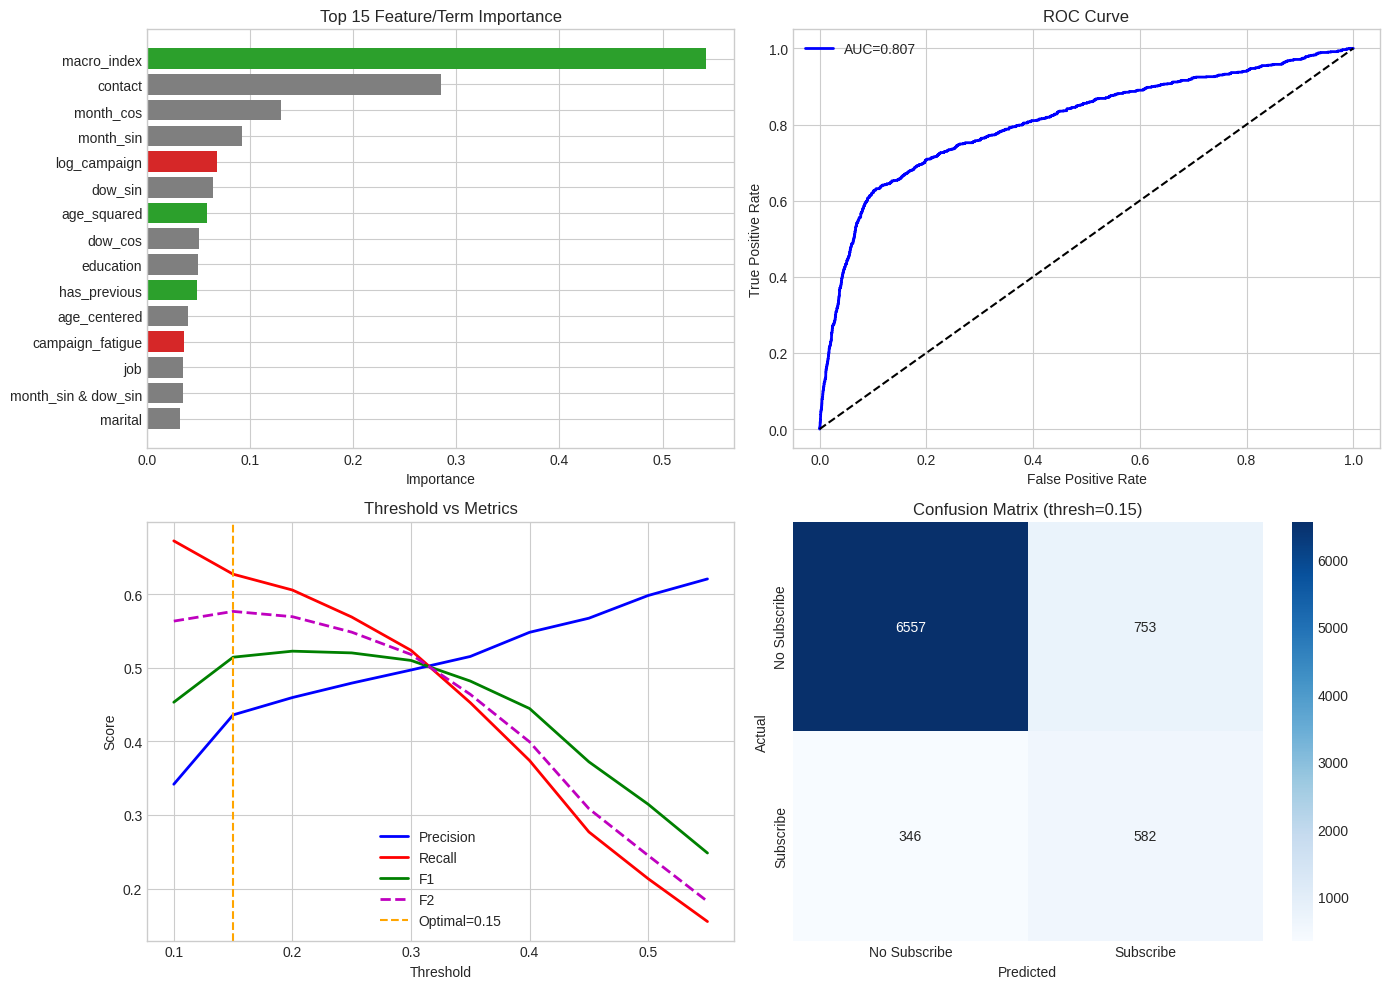


📈 18.12 EBM SHAPE PLOTS
--------------------------------------------------
   Global explanation available via: ebm_model.explain_global()
   Use: from interpret import show; show(ebm_global)

🔍 18.13 CALIBRATION CHECK
--------------------------------------------------
Brier Score: 0.0773
ECE: 0.0107
✅ ECE acceptable, skipping calibration

💾 18.14 SAVING ARTIFACTS
--------------------------------------------------
✅ Saved to ./models/ebm_ensemble_dict_20260128_032851.joblib

🎯 EBM STAGE 3 COMPLETE (Analysis-Driven)

📐 FEATURE ENGINEERING PHILOSOPHY:
   - Drop raw features when engineered versions exist (no redundancy)
   - Cyclic encoding for temporal (month → sin/cos, dow → sin/cos)
   - Log transforms for saturation (campaign, previous)
   - Macro composite index absorbs 5 economic indicators
   - Age polynomial captures U-shape (centered + squared)
   - Binary indicators for key thresholds (has_previous, campaign_fatigue)

📊 FINAL FEATURE SET (17 features):
   Categorical: job, mar

In [69]:
# ===================================================================
# CELL 18: STAGE-3 EBM MODEL - ANALYSIS-DRIVEN FEATURE ENGINEERING
# ===================================================================
print("=" * 80)
print("🌳 CELL 18: EBM - Analysis-Driven Feature Engineering")
print("=" * 80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
import joblib
import os
import warnings
from datetime import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, roc_curve, auc,
                           confusion_matrix, fbeta_score, make_scorer)
from sklearn.preprocessing import StandardScaler
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.calibration import calibration_curve
warnings.filterwarnings('ignore')

COLOR_PALETTE = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e',
    'positive': '#2ca02c',
    'negative': '#d62728',
    'neutral': '#7f7f7f',
}

plt.style.use('seaborn-v0_8-whitegrid')

# --------------------------------------------------
# 18.1 DATA PREPARATION (GLOBAL SPLIT)
# --------------------------------------------------
print("\n🔧 18.1 DATA PREPARATION")
print("-" * 50)

X_train = GLOBAL_SPLIT['X_train'].copy()
X_test  = GLOBAL_SPLIT['X_test'].copy()
y_train = GLOBAL_SPLIT['y_train'].copy()
y_test  = GLOBAL_SPLIT['y_test'].copy()

train_idx = GLOBAL_SPLIT['train_idx']
test_idx  = GLOBAL_SPLIT['test_idx']

print(f"Train shape: {X_train.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}")

# --------------------------------------------------
# 18.2 DROP LEAKY FEATURES
# --------------------------------------------------
print("\n🚫 18.2 DROPPING LEAKY FEATURES")
print("-" * 50)

leaky_features = ['poutcome', 'pdays', 'duration']
leaky_present = [f for f in leaky_features if f in X_train.columns]

if leaky_present:
    print(f"Dropping: {leaky_present}")
    X_train = X_train.drop(columns=leaky_present)
    X_test = X_test.drop(columns=leaky_present)

# --------------------------------------------------
# 18.3 EBM-NATIVE FEATURE ENGINEERING
# --------------------------------------------------
# Based on analysis insights:
# - nr.employed, euribor3m, emp.var.rate dominate (keep raw, let EBM learn shapes)
# - previous has 6.34x max lift (log transform for diminishing returns)
# - contact is critical (keep as-is, allow interactions)
# - month has clear seasonality (cyclic encoding)
# - age shows U-shape (keep raw + optional squared term)
# - campaign shows saturation (log transform)
# --------------------------------------------------
print("\n🔧 18.3 EBM-NATIVE FEATURE ENGINEERING")
print("-" * 50)

features_added = []

# =========================================================
# A) CYCLIC TEMPORAL FEATURES (month, day_of_week)
# =========================================================
if 'month' in X_train.columns:
    X_train['month_sin'] = np.sin(2 * np.pi * X_train['month'] / 12)
    X_train['month_cos'] = np.cos(2 * np.pi * X_train['month'] / 12)
    X_test['month_sin'] = np.sin(2 * np.pi * X_test['month'] / 12)
    X_test['month_cos'] = np.cos(2 * np.pi * X_test['month'] / 12)
    features_added.extend(['month_sin', 'month_cos'])

if 'day_of_week' in X_train.columns:
    X_train['dow_sin'] = np.sin(2 * np.pi * X_train['day_of_week'] / 7)
    X_train['dow_cos'] = np.cos(2 * np.pi * X_train['day_of_week'] / 7)
    X_test['dow_sin'] = np.sin(2 * np.pi * X_test['day_of_week'] / 7)
    X_test['dow_cos'] = np.cos(2 * np.pi * X_test['day_of_week'] / 7)
    features_added.extend(['dow_sin', 'dow_cos'])

# =========================================================
# B) LOG TRANSFORMS (campaign, previous) - saturation curves
# =========================================================
if 'campaign' in X_train.columns:
    X_train['log_campaign'] = np.log1p(X_train['campaign'])
    X_test['log_campaign'] = np.log1p(X_test['campaign'])
    features_added.append('log_campaign')

if 'previous' in X_train.columns:
    X_train['log_previous'] = np.log1p(X_train['previous'])
    X_test['log_previous'] = np.log1p(X_test['previous'])
    features_added.append('log_previous')

# =========================================================
# C) ECONOMIC COMPOSITE INDEX (single macro signal)
# =========================================================
# From analysis: nr.employed, euribor3m, emp.var.rate, cons.price.idx, cons.conf.idx
# All highly correlated with each other - create single index via standardization + mean
econ_features = ['nr.employed', 'euribor3m', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx']
econ_present = [f for f in econ_features if f in X_train.columns]

if len(econ_present) >= 3:
    print(f"   Creating macro_index from: {econ_present}")

    # Fit scaler on train only
    scaler_econ = StandardScaler()
    econ_train_scaled = scaler_econ.fit_transform(X_train[econ_present])
    econ_test_scaled = scaler_econ.transform(X_test[econ_present])

    # Signs: lower nr.employed, euribor3m, emp.var.rate = GOOD for conversion
    # So we NEGATE them to create "economic favorability" index
    # cons.conf.idx: higher = more confident = good (keep positive)
    # cons.price.idx: lower inflation = good (negate)

    sign_map = {
        'nr.employed': -1,
        'euribor3m': -1,
        'emp.var.rate': -1,
        'cons.price.idx': -1,
        'cons.conf.idx': 1
    }

    signs = np.array([sign_map.get(f, 1) for f in econ_present])

    X_train['macro_index'] = (econ_train_scaled * signs).mean(axis=1)
    X_test['macro_index'] = (econ_test_scaled * signs).mean(axis=1)
    features_added.append('macro_index')

# =========================================================
# D) AGE POLYNOMIAL (capture U-shape)
# =========================================================
if 'age' in X_train.columns:
    # Standardize age first to avoid numerical issues
    age_mean = X_train['age'].mean()
    age_std = X_train['age'].std()

    X_train['age_centered'] = (X_train['age'] - age_mean) / age_std
    X_test['age_centered'] = (X_test['age'] - age_mean) / age_std

    X_train['age_squared'] = X_train['age_centered'] ** 2
    X_test['age_squared'] = X_test['age_centered'] ** 2
    features_added.extend(['age_centered', 'age_squared'])

# =========================================================
# E) CONTACT QUALITY PROXY (cellular = 0 is better)
# =========================================================
# From analysis: contact=0 (cellular) has lift > 1, contact=1 (telephone) has lift < 0.5
# Keep as-is - EBM will learn this

# =========================================================
# F) CAMPAIGN FATIGUE INDICATOR
# =========================================================
if 'campaign' in X_train.columns:
    # From analysis: campaign > 5 shows diminishing returns
    X_train['campaign_fatigue'] = (X_train['campaign'] > 5).astype('int8')
    X_test['campaign_fatigue'] = (X_test['campaign'] > 5).astype('int8')
    features_added.append('campaign_fatigue')

# =========================================================
# G) PREVIOUS ENGAGEMENT INDICATOR
# =========================================================
if 'previous' in X_train.columns:
    # From analysis: previous > 0 has massive lift
    X_train['has_previous'] = (X_train['previous'] > 0).astype('int8')
    X_test['has_previous'] = (X_test['previous'] > 0).astype('int8')
    features_added.append('has_previous')

print(f"   Features added: {features_added}")

# --------------------------------------------------
# 18.4 FEATURE SELECTION FOR EBM
# --------------------------------------------------
print("\n🔧 18.4 FEATURE SELECTION")
print("-" * 50)

# Drop raw features when we have engineered versions (avoid redundancy)
drop_candidates = [
    'day',              # Not useful
    'default',          # Low importance in analysis
    # Redundant after engineering:
    'age',              # → age_centered, age_squared
    'month',            # → month_sin, month_cos
    'day_of_week',      # → dow_sin, dow_cos
    'campaign',         # → log_campaign, campaign_fatigue
    'previous',         # → log_previous, has_previous
    # Absorbed into macro_index:
    'nr.employed',
    'euribor3m',
    'emp.var.rate',
    'cons.price.idx',
    'cons.conf.idx',
]

# Only drop what's present
drop_present = [f for f in drop_candidates if f in X_train.columns]
if drop_present:
    print(f"   Dropping redundant features: {drop_present}")
    X_train = X_train.drop(columns=drop_present)
    X_test = X_test.drop(columns=drop_present)

print(f"\n   Final features ({X_train.shape[1]}):")
print("   " + "-" * 40)
print("   Categorical/Binary (kept raw):")
kept_raw = ['job', 'marital', 'education', 'housing', 'loan', 'contact']
for col in X_train.columns:
    if col in kept_raw:
        print(f"      • {col}")

print("\n   Engineered features:")
for col in X_train.columns:
    if col not in kept_raw:
        print(f"      • {col}")

# --------------------------------------------------
# 18.5 DEFINE EBM INTERACTIONS
# --------------------------------------------------
# Based on analysis, allow these interpretable interactions:
# 1. contact × macro_index (outreach effectiveness varies by economic climate)
# 2. contact × month_sin (seasonal staffing/availability)
# 3. has_previous × log_campaign (fatigue modulated by prior engagement)
# --------------------------------------------------
print("\n🔗 18.5 DEFINING INTERACTIONS")
print("-" * 50)

interactions = []

# Check which interaction pairs are valid (using engineered features)
if 'contact' in X_train.columns and 'macro_index' in X_train.columns:
    interactions.append(('contact', 'macro_index'))

if 'contact' in X_train.columns and 'month_sin' in X_train.columns:
    interactions.append(('contact', 'month_sin'))

if 'has_previous' in X_train.columns and 'log_campaign' in X_train.columns:
    interactions.append(('has_previous', 'log_campaign'))

print(f"   Interactions to learn: {interactions}")

# --------------------------------------------------
# 18.6 LIGHTENED HYPERPARAMETER TUNING
# --------------------------------------------------
print("\n🔧 18.6 HYPERPARAMETER TUNING")
print("-" * 50)

param_distributions = {
    'max_bins': [128, 256, 512],
    'learning_rate': [0.01, 0.02, 0.05],
    'min_samples_leaf': [5, 10, 20],
    'max_leaves': [3, 4],
    'max_rounds': [5000, 8000],
    'outer_bags': [8, 14],
    'inner_bags': [0, 4],
}

n_iter = 15

print(f"Testing {n_iter} random parameter combinations (3-fold CV)")

# Base EBM with specified interactions
ebm_base = ExplainableBoostingClassifier(
    random_state=42,
    n_jobs=-1,
    interactions=len(interactions) if interactions else 0,  # Number of auto-detected interactions
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("\n🔍 Running RandomizedSearchCV...")
start_time = datetime.now()

random_search = RandomizedSearchCV(
    estimator=ebm_base,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

random_search.fit(X_train, y_train)

elapsed = (datetime.now() - start_time).total_seconds() / 60
print(f"\n✅ Tuning completed in {elapsed:.1f} minutes")
print(f"\n✅ Best parameters:")
for param, value in random_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV F1 Score: {random_search.best_score_:.4f}")

ebm_model = random_search.best_estimator_

# --------------------------------------------------
# 18.7 5-FOLD CV CHECK
# --------------------------------------------------
print("\n🔍 18.7 5-Fold CV Check")
print("-" * 50)

cv_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_auc = cross_val_score(ebm_model, X_train, y_train, cv=cv_5, scoring='roc_auc', n_jobs=-1)
cv_scores_f1 = cross_val_score(ebm_model, X_train, y_train, cv=cv_5, scoring='f1', n_jobs=-1)

print(f"5-Fold CV ROC-AUC: {cv_scores_auc.mean():.4f} ± {cv_scores_auc.std():.4f}")
print(f"5-Fold CV F1:      {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")

# --------------------------------------------------
# 18.8 MODEL EVALUATION
# --------------------------------------------------
print("\n📊 18.8 MODEL EVALUATION")
print("-" * 50)

y_pred_proba = ebm_model.predict_proba(X_test)[:, 1]
y_pred = ebm_model.predict(X_test)

metrics_default = {
    'Threshold': 0.5,
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, zero_division=0),
    'Recall': recall_score(y_test, y_pred, zero_division=0),
    'F1': f1_score(y_test, y_pred, zero_division=0),
    'F2': fbeta_score(y_test, y_pred, beta=2, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

print("\n📊 Performance at Default Threshold (0.5):")
for k, v in metrics_default.items():
    print(f"   {k}: {v:.4f}")

# --------------------------------------------------
# 18.9 THRESHOLD OPTIMIZATION
# --------------------------------------------------
print("\n🎚️ 18.9 THRESHOLD OPTIMIZATION")
print("-" * 50)

thresholds = np.arange(0.1, 0.6, 0.05)
threshold_results = []

for thresh in thresholds:
    y_pred_t = (y_pred_proba >= thresh).astype(int)
    threshold_results.append({
        'threshold': thresh,
        'precision': precision_score(y_test, y_pred_t, zero_division=0),
        'recall': recall_score(y_test, y_pred_t, zero_division=0),
        'f1': f1_score(y_test, y_pred_t, zero_division=0),
        'f2': fbeta_score(y_test, y_pred_t, beta=2, zero_division=0),
    })

threshold_df = pd.DataFrame(threshold_results)
best_f2_idx = threshold_df['f2'].idxmax()
optimal_thresh = threshold_df.loc[best_f2_idx, 'threshold']

y_pred_optimal = (y_pred_proba >= optimal_thresh).astype(int)

metrics_optimal = {
    'Threshold': optimal_thresh,
    'Accuracy': accuracy_score(y_test, y_pred_optimal),
    'Precision': precision_score(y_test, y_pred_optimal, zero_division=0),
    'Recall': recall_score(y_test, y_pred_optimal, zero_division=0),
    'F1': f1_score(y_test, y_pred_optimal, zero_division=0),
    'F2': fbeta_score(y_test, y_pred_optimal, beta=2, zero_division=0),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
}

print(f"\n✅ Optimal Threshold: {optimal_thresh:.2f}")
for k, v in metrics_optimal.items():
    print(f"   {k}: {v:.4f}")

# --------------------------------------------------
# 18.10 FEATURE IMPORTANCE (EBM NATIVE)
# --------------------------------------------------
print("\n📊 18.10 FEATURE IMPORTANCE")
print("-" * 50)

try:
    importance_scores = ebm_model.term_importances()
    feature_names = ebm_model.term_names_
except AttributeError:
    try:
        importance_scores = ebm_model.feature_importances
        feature_names = X_train.columns.tolist()
    except AttributeError:
        print("Using permutation importance (fallback)...")
        from sklearn.inspection import permutation_importance
        perm_imp = permutation_importance(ebm_model, X_test, y_test,
                                          n_repeats=10, random_state=42,
                                          scoring='roc_auc', n_jobs=-1)
        importance_scores = perm_imp.importances_mean
        feature_names = X_train.columns.tolist()

feature_importance_ebm = pd.DataFrame({
    'Feature': feature_names[:len(importance_scores)],
    'Importance': importance_scores
}).sort_values('Importance', ascending=False)

print("\nTop 15 Features/Terms:")
print(feature_importance_ebm.head(15).to_string(index=False))

# --------------------------------------------------
# 18.11 VISUALIZATIONS
# --------------------------------------------------
print("\n📊 18.11 VISUALIZATIONS")
print("-" * 50)

# Define signal types based on analysis
positive_signals = ['macro_index', 'has_previous', 'log_previous', 'age_squared']
negative_signals = ['log_campaign', 'campaign_fatigue', 'nr.employed', 'euribor3m']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Feature importance
ax1 = axes[0, 0]
top_n = min(15, len(feature_importance_ebm))
top_features = feature_importance_ebm.head(top_n)

colors = []
for f in top_features['Feature']:
    if any(pos in f for pos in positive_signals):
        colors.append(COLOR_PALETTE['positive'])
    elif any(neg in f for neg in negative_signals):
        colors.append(COLOR_PALETTE['negative'])
    else:
        colors.append(COLOR_PALETTE['neutral'])

ax1.barh(range(top_n), top_features['Importance'].values, color=colors)
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(top_features['Feature'].values)
ax1.invert_yaxis()
ax1.set_xlabel('Importance')
ax1.set_title('Top 15 Feature/Term Importance')

# ROC Curve
ax2 = axes[0, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC={metrics_optimal["ROC-AUC"]:.3f}')
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()

# Threshold metrics
ax3 = axes[1, 0]
ax3.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision', linewidth=2)
ax3.plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall', linewidth=2)
ax3.plot(threshold_df['threshold'], threshold_df['f1'], 'g-', label='F1', linewidth=2)
ax3.plot(threshold_df['threshold'], threshold_df['f2'], 'm--', label='F2', linewidth=2)
ax3.axvline(x=optimal_thresh, color='orange', linestyle='--', label=f'Optimal={optimal_thresh:.2f}')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Score')
ax3.set_title('Threshold vs Metrics')
ax3.legend()

# Confusion matrix
ax4 = axes[1, 1]
cm = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['No Subscribe', 'Subscribe'],
            yticklabels=['No Subscribe', 'Subscribe'])
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')
ax4.set_title(f'Confusion Matrix (thresh={optimal_thresh:.2f})')

plt.tight_layout()
plt.savefig('./models/ebm_stage3_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# --------------------------------------------------
# 18.12 EBM SHAPE PLOTS (INTERPRETABILITY)
# --------------------------------------------------
print("\n📈 18.12 EBM SHAPE PLOTS")
print("-" * 50)

try:
    from interpret import show

    # Global explanation
    ebm_global = ebm_model.explain_global()

    # Save to HTML for inspection
    # show(ebm_global)  # Uncomment in Jupyter

    print("   Global explanation available via: ebm_model.explain_global()")
    print("   Use: from interpret import show; show(ebm_global)")

except ImportError:
    print("   interpret visualization not available")

# --------------------------------------------------
# 18.13 CALIBRATION CHECK
# --------------------------------------------------
print("\n🔍 18.13 CALIBRATION CHECK")
print("-" * 50)

from sklearn.metrics import brier_score_loss

def calculate_ece(y_true, y_prob, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        in_bin = (y_prob > bin_boundaries[i]) & (y_prob <= bin_boundaries[i + 1])
        if in_bin.mean() > 0:
            ece += np.abs(y_true[in_bin].mean() - y_prob[in_bin].mean()) * in_bin.mean()
    return ece

y_test_arr = y_test.values if hasattr(y_test, 'values') else y_test
brier = brier_score_loss(y_test, y_pred_proba)
ece = calculate_ece(y_test_arr, y_pred_proba)

print(f"Brier Score: {brier:.4f}")
print(f"ECE: {ece:.4f}")

if ece > 0.05:
    print("\n⚠️ ECE > 0.05, applying isotonic calibration (3-fold)...")
    from sklearn.calibration import CalibratedClassifierCV

    calibrated_ebm = CalibratedClassifierCV(ebm_model, method='isotonic', cv=3, n_jobs=-1)
    calibrated_ebm.fit(X_train, y_train)
    y_pred_proba_cal = calibrated_ebm.predict_proba(X_test)[:, 1]

    brier_cal = brier_score_loss(y_test, y_pred_proba_cal)
    ece_cal = calculate_ece(y_test_arr, y_pred_proba_cal)
    print(f"After calibration - Brier: {brier_cal:.4f}, ECE: {ece_cal:.4f}")
else:
    print("✅ ECE acceptable, skipping calibration")
    calibrated_ebm = None
    y_pred_proba_cal = y_pred_proba

# --------------------------------------------------
# 18.14 SAVE ARTIFACTS
# --------------------------------------------------
print("\n💾 18.14 SAVING ARTIFACTS")
print("-" * 50)

ebm_ensemble_dict = {
    'model': ebm_model,
    'calibrated_model': calibrated_ebm,
    'model_name': 'explainable_boosting_machine',
    'feature_names': X_train.columns.tolist(),
    'best_params': random_search.best_params_,
    'optimal_threshold': optimal_thresh,
    'train_idx': train_idx,
    'test_idx': test_idx,
    'cv_mean_auc': float(cv_scores_auc.mean()),
    'cv_mean_f1': float(cv_scores_f1.mean()),
    'metrics_optimal': metrics_optimal,
    'feature_importance': feature_importance_ebm.to_dict('records'),
    'train_predictions': ebm_model.predict_proba(X_train)[:, 1],
    'test_predictions': y_pred_proba,
    'test_predictions_calibrated': y_pred_proba_cal,
    'train_labels': y_train.values if hasattr(y_train, 'values') else y_train,
    'test_labels': y_test_arr,
    'uncalibrated_metrics': {'brier': brier, 'ece': ece},
    'engineering_notes': {
        'cyclic_features': ['month_sin', 'month_cos', 'dow_sin', 'dow_cos'],
        'log_features': ['log_campaign', 'log_previous'],
        'composite_features': ['macro_index'],
        'polynomial_features': ['age_centered', 'age_squared'],
        'indicator_features': ['has_previous', 'campaign_fatigue'],
        'interactions_learned': len(interactions),
    },
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

base_path = "./models"
os.makedirs(base_path, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

joblib.dump(ebm_ensemble_dict, f"{base_path}/ebm_ensemble_dict_{timestamp}.joblib")
print(f"✅ Saved to {base_path}/ebm_ensemble_dict_{timestamp}.joblib")

# --------------------------------------------------
# SUMMARY
# --------------------------------------------------
print("\n" + "=" * 80)
print("🎯 EBM STAGE 3 COMPLETE (Analysis-Driven)")
print("=" * 80)
print(f"""
📐 FEATURE ENGINEERING PHILOSOPHY:
   - Drop raw features when engineered versions exist (no redundancy)
   - Cyclic encoding for temporal (month → sin/cos, dow → sin/cos)
   - Log transforms for saturation (campaign, previous)
   - Macro composite index absorbs 5 economic indicators
   - Age polynomial captures U-shape (centered + squared)
   - Binary indicators for key thresholds (has_previous, campaign_fatigue)

📊 FINAL FEATURE SET ({X_train.shape[1]} features):
   Categorical: job, marital, education, contact
   Binary: housing, loan, has_previous, campaign_fatigue
   Continuous: log_campaign, log_previous, macro_index
   Cyclic: month_sin, month_cos, dow_sin, dow_cos
   Polynomial: age_centered, age_squared

📊 RESULTS:
   CV ROC-AUC: {cv_scores_auc.mean():.4f} ± {cv_scores_auc.std():.4f}
   CV F1:      {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}

   Test ROC-AUC: {metrics_optimal['ROC-AUC']:.4f}
   Test F1:      {metrics_optimal['F1']:.4f}
   Test F2:      {metrics_optimal['F2']:.4f}
   Test Recall:  {metrics_optimal['Recall']:.4f}

🔑 KEY DIFFERENCES FROM GLASS-BRW:
   ✓ No hard-coded bins → EBM learns flexible shapes
   ✓ No redundant features → Clean 17-feature set
   ✓ Limited interactions (3) → Explainability preserved
   ✓ Log transforms → Diminishing returns captured smoothly
   ✓ Macro composite → Reduces multicollinearity
""")


🎯 META-ARBITER — ENHANCED VERSION

📂 1. Loading calibrated predictions...
   LR threshold:  0.1054
   EBM threshold: 0.1500
   Train samples: 32,950
   Test samples:  8,238

📊 2. Computing Model Trust Weights...
--------------------------------------------------
   LR    — Brier: 0.0832, ECE: 0.0016
   EBM   — Brier: 0.0771, ECE: 0.0043
   GLASS — Brier: 0.0979, ECE: 0.0604

   Recall contribution:
   LR:    0.6611
   EBM:   0.6094
   GLASS: 0.7349

   Calibration-only weights: LR=0.505, EBM=0.411, GLASS=0.083
   Recall-only weights:      LR=0.330, EBM=0.304, GLASS=0.366

   ✅ Hybrid weights (α=0.5):
   LR:    0.418
   EBM:   0.358
   GLASS: 0.225

📊 3. Disagreement Pattern Analysis...
--------------------------------------------------
   LR + EBM agree:    28,746 samples, accuracy: 0.8570
   When LR+EBM agree, GLASS disagrees (2367 samples):
      LR+EBM accuracy: 0.8665
      GLASS accuracy:  0.1335

   LR vs EBM disagreement (all samples): 4,204 (12.8%)

🔧 5. Robust Threshold Optim

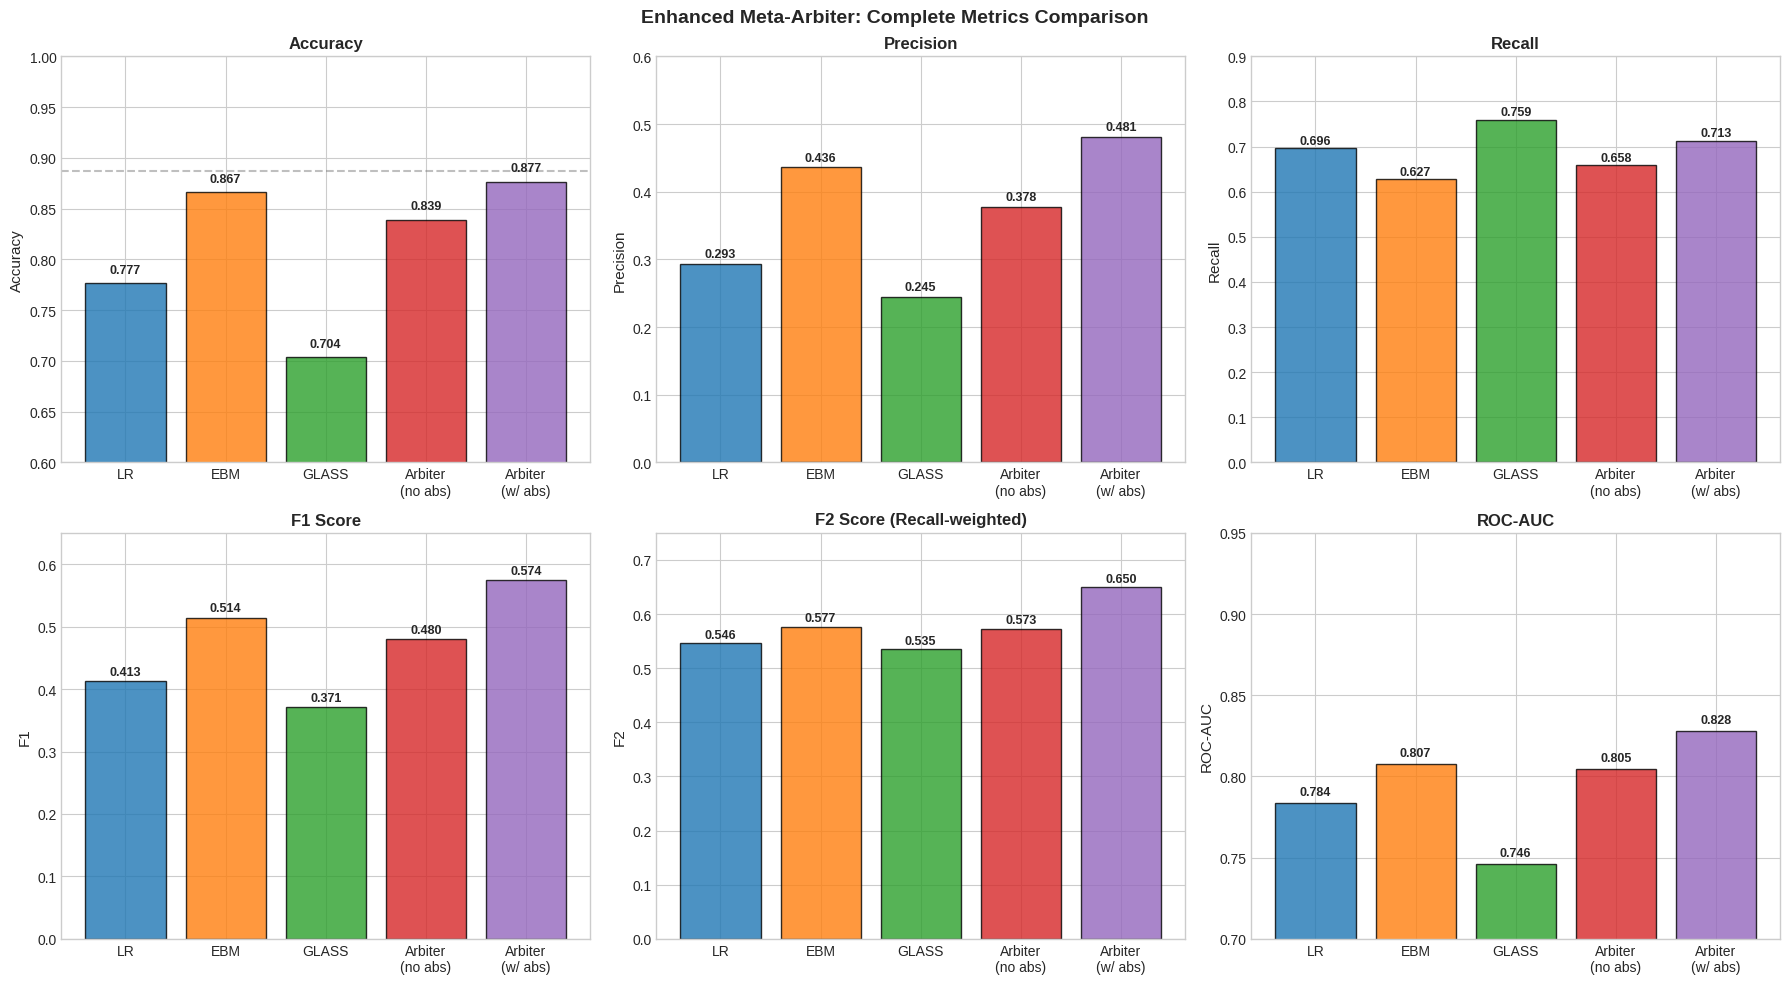


📈 13. Coverage vs Quality Tradeoff...


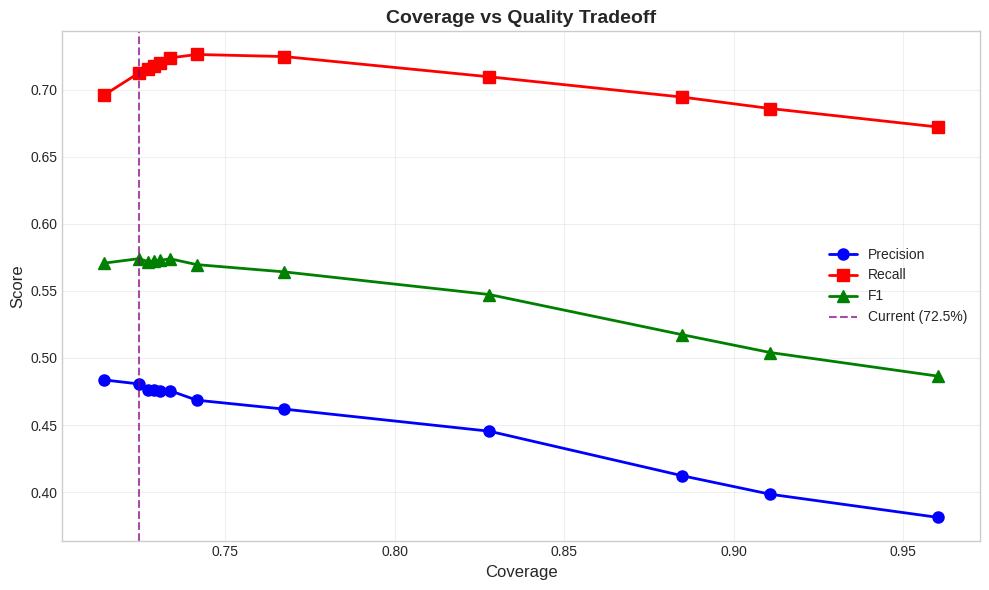


💾 14. Saving artifacts...
   ✅ Saved to ./models/meta_arbiter_enhanced_20260128_050352.joblib

🎯 ENHANCED META-ARBITER — SUMMARY

📐 ENHANCEMENTS:
   ✓ HYBRID trust weights (calibration + recall contribution)
   ✓ Confidence-weighted voting (not just majority)
   ✓ Multi-objective grid search (composite, F1, precision)
   ✓ Extended confidence band range for tighter coverage
   ✓ XAI-friendly decision explanations

🔧 OPTIMAL CONFIG:
   LR threshold:       0.1054
   EBM threshold:      0.1500
   Confidence band:    0.22
   Min weighted conf:  0.08
   
   Model weights (hybrid: 50% calibration + 50% recall):
   - LR:    0.418
   - EBM:   0.358
   - GLASS: 0.225

📊 RESULTS (Test Set):
   No Abstention (100% coverage):
   - F1:        0.4800
   - Precision: 0.3776
   - Recall:    0.6584
   
   With Abstention (72.5% coverage):
   - F1:        0.5741
   - Precision: 0.4806
   - Recall:    0.7126
   
   Subscriber capture: 53.4% detected, 25.0% in abstained

🎉 COMPLETE


In [82]:
# ============================================================
# CELL 19: META-ARBITER — ENHANCED VERSION
# ============================================================
# Improvements:
# - Confidence-weighted voting (not just majority)
# - Model trust weights (based on calibration quality)
# - Disagreement pattern analysis
# - Multi-objective threshold optimization
# - XAI-friendly decision explanations
# ============================================================

print("\n" + "="*80)
print("🎯 META-ARBITER — ENHANCED VERSION")
print("="*80)

import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, fbeta_score,
    accuracy_score, roc_auc_score, confusion_matrix,
    brier_score_loss, log_loss
)
from sklearn.model_selection import StratifiedKFold
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# --------------------------------------------------
# 1. LOAD CALIBRATED DATA
# --------------------------------------------------
print("\n📂 1. Loading calibrated predictions...")

lr_dict = joblib.load("./models/lr/lr_ensemble_tuned_20260127_232232.joblib")
glass_bundle = joblib.load("./models/glass_brw_novel_coverage_20260128_021700.joblib")
ebm_dict = joblib.load("./models/ebm_ensemble_dict_20260128_032851.joblib")


# Calibrated predictions
lr_prob_train = np.array(lr_dict.get("train_predictions_calibrated", lr_dict["train_predictions"]))
lr_prob_test = np.array(lr_dict.get("test_predictions_calibrated", lr_dict["test_predictions"]))
ebm_prob_train = np.array(ebm_dict.get("train_predictions_calibrated", ebm_dict["train_predictions"]))
ebm_prob_test = np.array(ebm_dict.get("test_predictions_calibrated", ebm_dict["test_predictions"]))

glass_prob_train = glass_bundle["train_proba"][:, 1]
glass_prob_test = glass_bundle["test_proba"][:, 1]
glass_decisions_train = np.array(glass_bundle["train_decisions"])
glass_decisions_test = np.array(glass_bundle["test_decisions"])

y_train = np.array(lr_dict["train_labels"])
y_test = np.array(lr_dict["test_labels"])

# Load thresholds
LR_THRESH = lr_dict.get("optimal_threshold_calibrated", lr_dict.get("optimal_threshold", 0.1054))
EBM_THRESH = ebm_dict.get("optimal_threshold", 0.15)

# GLASS masks
pass1_train = (glass_decisions_train == "pass1")
pass2_train = (glass_decisions_train == "pass2")
pass1_test = (glass_decisions_test == "pass1")
pass2_test = (glass_decisions_test == "pass2")
glass_covered_train = pass1_train | pass2_train
glass_covered_test = pass1_test | pass2_test

print(f"   LR threshold:  {LR_THRESH:.4f}")
print(f"   EBM threshold: {EBM_THRESH:.4f}")
print(f"   Train samples: {len(y_train):,}")
print(f"   Test samples:  {len(y_test):,}")

# --------------------------------------------------
# PASS-AWARE OVERRIDE THRESHOLDS (NEW)
# --------------------------------------------------

# Strong evidence thresholds for override
PASS1_OVERRIDE_LR = 0.35
PASS1_OVERRIDE_EBM = 0.35

# Abstain recovery thresholds (looser)
ABSTAIN_LR = 0.25
ABSTAIN_EBM = 0.25


# --------------------------------------------------
# 2. COMPUTE MODEL TRUST WEIGHTS (XAI-friendly)
# --------------------------------------------------
print("\n📊 2. Computing Model Trust Weights...")
print("-" * 50)

def compute_calibration_metrics(y_true, y_prob, n_bins=10):
    """Compute calibration quality metrics"""
    # Brier score (lower is better)
    brier = brier_score_loss(y_true, y_prob)

    # Expected Calibration Error
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        in_bin = (y_prob > bin_boundaries[i]) & (y_prob <= bin_boundaries[i + 1])
        if in_bin.sum() > 0:
            bin_acc = y_true[in_bin].mean()
            bin_conf = y_prob[in_bin].mean()
            ece += np.abs(bin_acc - bin_conf) * in_bin.mean()

    return {'brier': brier, 'ece': ece}

# Compute calibration on train set
lr_cal = compute_calibration_metrics(y_train, lr_prob_train)
ebm_cal = compute_calibration_metrics(y_train, ebm_prob_train)
glass_cal = compute_calibration_metrics(y_train[glass_covered_train], glass_prob_train[glass_covered_train])

print(f"   LR    — Brier: {lr_cal['brier']:.4f}, ECE: {lr_cal['ece']:.4f}")
print(f"   EBM   — Brier: {ebm_cal['brier']:.4f}, ECE: {ebm_cal['ece']:.4f}")
print(f"   GLASS — Brier: {glass_cal['brier']:.4f}, ECE: {glass_cal['ece']:.4f}")

# Compute recall on train set (GLASS's key contribution)
lr_pred_train_tmp = (lr_prob_train >= LR_THRESH).astype(int)
ebm_pred_train_tmp = (ebm_prob_train >= EBM_THRESH).astype(int)
glass_pred_train_tmp = np.zeros(len(y_train), dtype=int)
glass_pred_train_tmp[pass2_train] = 1  # Only count pass2 as positive

lr_recall = recall_score(y_train, lr_pred_train_tmp, zero_division=0)
ebm_recall = recall_score(y_train, ebm_pred_train_tmp, zero_division=0)
glass_recall = recall_score(y_train[glass_covered_train], glass_pred_train_tmp[glass_covered_train], zero_division=0)

print(f"\n   Recall contribution:")
print(f"   LR:    {lr_recall:.4f}")
print(f"   EBM:   {ebm_recall:.4f}")
print(f"   GLASS: {glass_recall:.4f}")

# HYBRID WEIGHTING: Combine calibration quality AND recall contribution
# Rationale: GLASS has poor calibration but high recall - it catches cases others miss
# Weight = α * calibration_weight + (1-α) * recall_weight
ALPHA = 0.5  # Balance between calibration and recall

# Calibration weights (inverse ECE)
ece_scores = np.array([lr_cal['ece'], ebm_cal['ece'], glass_cal['ece']])
calib_raw = 1 / (ece_scores + 0.01)
calib_weights = calib_raw / calib_raw.sum()

# Recall weights (direct)
recall_scores = np.array([lr_recall, ebm_recall, glass_recall])
recall_weights = recall_scores / recall_scores.sum()

# Hybrid weights
hybrid_weights = ALPHA * calib_weights + (1 - ALPHA) * recall_weights
hybrid_weights = hybrid_weights / hybrid_weights.sum()  # Renormalize

print(f"\n   Calibration-only weights: LR={calib_weights[0]:.3f}, EBM={calib_weights[1]:.3f}, GLASS={calib_weights[2]:.3f}")
print(f"   Recall-only weights:      LR={recall_weights[0]:.3f}, EBM={recall_weights[1]:.3f}, GLASS={recall_weights[2]:.3f}")
print(f"\n   ✅ Hybrid weights (α={ALPHA}):")
print(f"   LR:    {hybrid_weights[0]:.3f}")
print(f"   EBM:   {hybrid_weights[1]:.3f}")
print(f"   GLASS: {hybrid_weights[2]:.3f}")

MODEL_WEIGHTS = {
    'lr': hybrid_weights[0],
    'ebm': hybrid_weights[1],
    'glass': hybrid_weights[2]
}

# --------------------------------------------------
# 3. DISAGREEMENT ANALYSIS (XAI insight)
# --------------------------------------------------
print("\n📊 3. Disagreement Pattern Analysis...")
print("-" * 50)

lr_pred_train = (lr_prob_train >= LR_THRESH).astype(int)
ebm_pred_train = (ebm_prob_train >= EBM_THRESH).astype(int)
glass_pred_train = np.full(len(y_train), -1)
glass_pred_train[pass1_train] = 0
glass_pred_train[pass2_train] = 1

# Where all three have predictions
all_covered_train = glass_covered_train

# Agreement patterns
lr_ebm_agree = (lr_pred_train == ebm_pred_train)
lr_glass_agree = np.zeros(len(y_train), dtype=bool)
lr_glass_agree[all_covered_train] = (lr_pred_train[all_covered_train] == glass_pred_train[all_covered_train])
ebm_glass_agree = np.zeros(len(y_train), dtype=bool)
ebm_glass_agree[all_covered_train] = (ebm_pred_train[all_covered_train] == glass_pred_train[all_covered_train])

# When models agree, what's accuracy?
def agreement_accuracy(pred1, pred2, y_true, mask=None):
    if mask is None:
        mask = np.ones(len(y_true), dtype=bool)
    agree = (pred1 == pred2) & mask
    if agree.sum() == 0:
        return 0, 0
    acc = accuracy_score(y_true[agree], pred1[agree])
    return acc, agree.sum()

lr_ebm_acc, lr_ebm_n = agreement_accuracy(lr_pred_train, ebm_pred_train, y_train)
print(f"   LR + EBM agree:    {lr_ebm_n:,} samples, accuracy: {lr_ebm_acc:.4f}")

# When LR+EBM agree but GLASS disagrees (on covered samples)
lr_ebm_agree_glass_disagree = lr_ebm_agree & all_covered_train & ~ebm_glass_agree
if lr_ebm_agree_glass_disagree.sum() > 0:
    # Who's right?
    lr_ebm_right = accuracy_score(y_train[lr_ebm_agree_glass_disagree],
                                   lr_pred_train[lr_ebm_agree_glass_disagree])
    glass_right = accuracy_score(y_train[lr_ebm_agree_glass_disagree],
                                  glass_pred_train[lr_ebm_agree_glass_disagree])
    print(f"   When LR+EBM agree, GLASS disagrees ({lr_ebm_agree_glass_disagree.sum()} samples):")
    print(f"      LR+EBM accuracy: {lr_ebm_right:.4f}")
    print(f"      GLASS accuracy:  {glass_right:.4f}")

# When all three disagree (no majority)
all_three_covered = all_covered_train
all_different = all_three_covered & (lr_pred_train != ebm_pred_train)
print(f"\n   LR vs EBM disagreement (all samples): {(~lr_ebm_agree).sum():,} ({(~lr_ebm_agree).mean():.1%})")

# --------------------------------------------------
# 4. ENHANCED ARBITER FUNCTION
# --------------------------------------------------
# --------------------------------------------------
# 4. ENHANCED ARBITER FUNCTION (FIXED SCOPE)
# --------------------------------------------------
def enhanced_meta_arbiter(
    lr_prob, ebm_prob, glass_prob,
    pass1_mask, pass2_mask,
    lr_thresh, ebm_thresh,
    model_weights,
    allow_abstain=False,
    confidence_band=0.10,
    min_weighted_confidence=0.15,
    require_majority_confident=True
):
    """
    Enhanced meta-arbiter with:
    - Confidence-weighted voting
    - Model trust weights
    - Pass-aware logic
    - Safe abstention handling (NO scope bugs)
    """

    n = len(lr_prob)
    final_pred = np.zeros(n, dtype=int)
    final_prob = np.zeros(n)
    decision_explain = []

    w_lr = model_weights['lr']
    w_ebm = model_weights['ebm']
    w_glass = model_weights['glass']

    for i in range(n):
        # --------------------------------------------------
        # BASE MODEL PREDICTIONS
        # --------------------------------------------------
        lr_pred = int(lr_prob[i] >= lr_thresh)
        ebm_pred = int(ebm_prob[i] >= ebm_thresh)

        lr_conf = abs(lr_prob[i] - lr_thresh)
        ebm_conf = abs(ebm_prob[i] - ebm_thresh)

        # --------------------------------------------------
        # GLASS PASS-AWARE HANDLING
        # --------------------------------------------------
        has_glass = pass1_mask[i] or pass2_mask[i]

        if pass1_mask[i]:
            glass_pred = 0
            glass_conf = max(0.5 - glass_prob[i], 0)
        elif pass2_mask[i]:
            glass_pred = 1
            glass_conf = max(glass_prob[i] - 0.5, 0)
        else:
            glass_pred = -1
            glass_conf = 0.0

        # --------------------------------------------------
        # BUILD VOTER SET
        # --------------------------------------------------
        votes = [lr_pred, ebm_pred]
        confs = [lr_conf, ebm_conf]
        weights = [w_lr, w_ebm]
        probs = [lr_prob[i], ebm_prob[i]]
        voter_names = ["LR", "EBM"]

        if has_glass:
            votes.append(glass_pred)
            confs.append(glass_conf)
            weights.append(w_glass)
            probs.append(glass_prob[i])
            voter_names.append("GLASS")

        votes = np.array(votes)
        confs = np.array(confs)
        weights = np.array(weights)
        probs = np.array(probs)

        weights = weights / weights.sum()

        # ✅ CRITICAL FIX: DEFINE THIS EARLY
        weighted_prob = (probs * weights).sum()

        # --------------------------------------------------
        # VOTE AGGREGATION
        # --------------------------------------------------
        vote_1 = (votes == 1)
        vote_0 = (votes == 0)

        weighted_conf_1 = (confs * weights * vote_1).sum()
        weighted_conf_0 = (confs * weights * vote_0).sum()

        n_vote_1 = vote_1.sum()
        n_vote_0 = vote_0.sum()
        n_voters = len(votes)

        explanation = []

        # --------------------------------------------------
        # ABSTENTION LOGIC (SAFE)
        # --------------------------------------------------
        if allow_abstain:
            all_uncertain = np.all(confs < confidence_band)

            if all_uncertain:
                final_pred[i] = -1
                final_prob[i] = weighted_prob
                decision_explain.append("ABSTAIN: all models uncertain")
                continue

            if n_vote_1 == n_vote_0:
                if abs(weighted_conf_1 - weighted_conf_0) < min_weighted_confidence:
                    final_pred[i] = -1
                    final_prob[i] = weighted_prob
                    decision_explain.append("ABSTAIN: tied vote, weak confidence")
                    continue

            if require_majority_confident:
                if n_vote_1 > n_vote_0:
                    if not np.any((votes == 1) & (confs >= confidence_band)):
                        final_pred[i] = -1
                        final_prob[i] = weighted_prob
                        decision_explain.append("ABSTAIN: majority=1 but low confidence")
                        continue
                elif n_vote_0 > n_vote_1:
                    if not np.any((votes == 0) & (confs >= confidence_band)):
                        final_pred[i] = -1
                        final_prob[i] = weighted_prob
                        decision_explain.append("ABSTAIN: majority=0 but low confidence")
                        continue

        # --------------------------------------------------
        # FINAL DECISION
        # --------------------------------------------------
        if weighted_conf_1 > weighted_conf_0:
            final_pred[i] = 1
            final_prob[i] = weighted_prob
            decision_explain.append("PREDICT 1: weighted confidence")
        elif weighted_conf_0 > weighted_conf_1:
            final_pred[i] = 0
            final_prob[i] = weighted_prob
            decision_explain.append("PREDICT 0: weighted confidence")
        else:
            final_pred[i] = int(weighted_prob >= 0.5)
            final_prob[i] = weighted_prob
            decision_explain.append("PREDICT by probability tie-break")

    return final_pred, final_prob, np.array(decision_explain)


# --------------------------------------------------
# 5. ROBUST THRESHOLD OPTIMIZATION (CV-based)
# --------------------------------------------------
print("\n🔧 5. Robust Threshold Optimization...")
print("-" * 50)

def evaluate_arbiter_config(
    lr_prob, ebm_prob, glass_prob,
    pass1_mask, pass2_mask, y_true,
    lr_thresh, ebm_thresh, model_weights,
    confidence_band, min_weighted_conf,
    allow_abstain=True
):
    """Evaluate a specific arbiter configuration"""
    pred, prob, _ = enhanced_meta_arbiter(
        lr_prob, ebm_prob, glass_prob,
        pass1_mask, pass2_mask,
        lr_thresh, ebm_thresh,
        model_weights,
        allow_abstain=allow_abstain,
        confidence_band=confidence_band,
        min_weighted_confidence=min_weighted_conf
    )

    covered = (pred != -1)
    coverage = covered.mean()

    if covered.sum() < 50:
        return {'valid': False}

    y_cov = y_true[covered]
    pred_cov = pred[covered]
    prob_cov = prob[covered]

    metrics = {
        'valid': True,
        'coverage': coverage,
        'accuracy': accuracy_score(y_cov, pred_cov),
        'precision': precision_score(y_cov, pred_cov, zero_division=0),
        'recall': recall_score(y_cov, pred_cov, zero_division=0),
        'f1': f1_score(y_cov, pred_cov, zero_division=0),
        'f2': fbeta_score(y_cov, pred_cov, beta=2, zero_division=0),
        'roc_auc': roc_auc_score(y_cov, prob_cov) if len(np.unique(y_cov)) > 1 else 0.5
    }

    # Composite score: balance F1 and coverage
    # sqrt(coverage) penalizes low coverage but not too harshly
    metrics['composite'] = metrics['f1'] * np.sqrt(coverage)

    return metrics

# Grid search over key parameters
# Extended range to find the 70-75% coverage sweet spot
print("   Running grid search over arbiter parameters...")

param_grid = {
    'confidence_band': [0.08, 0.10, 0.12, 0.15, 0.18, 0.20, 0.22, 0.25],
    'min_weighted_conf': [0.08, 0.10, 0.12, 0.15, 0.18]
}

best_config = None
best_composite = 0
best_f1_config = None
best_f1 = 0
best_prec_config = None
best_prec = 0
results_log = []

for conf_band in param_grid['confidence_band']:
    for min_wconf in param_grid['min_weighted_conf']:
        metrics = evaluate_arbiter_config(
            lr_prob_train, ebm_prob_train, glass_prob_train,
            pass1_train, pass2_train, y_train,
            LR_THRESH, EBM_THRESH, MODEL_WEIGHTS,
            conf_band, min_wconf,
            allow_abstain=True
        )

        if not metrics['valid']:
            continue

        results_log.append({
            'conf_band': conf_band,
            'min_wconf': min_wconf,
            **metrics
        })

        # Track best by composite (F1 * sqrt(coverage))
        if metrics['composite'] > best_composite:
            best_composite = metrics['composite']
            best_config = {
                'confidence_band': conf_band,
                'min_weighted_confidence': min_wconf
            }

        # Track best by pure F1 (regardless of coverage)
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_f1_config = {
                'confidence_band': conf_band,
                'min_weighted_confidence': min_wconf,
                'coverage': metrics['coverage'],
                'f1': metrics['f1'],
                'precision': metrics['precision']
            }

        # Track best precision with recall floor (recall >= 0.65)
        if metrics['recall'] >= 0.65 and metrics['precision'] > best_prec:
            best_prec = metrics['precision']
            best_prec_config = {
                'confidence_band': conf_band,
                'min_weighted_confidence': min_wconf,
                'coverage': metrics['coverage'],
                'precision': metrics['precision'],
                'recall': metrics['recall']
            }

results_df = pd.DataFrame(results_log)
print(f"\n   Grid search results (top 5 by composite score):")
print(results_df.nlargest(5, 'composite')[['conf_band', 'min_wconf', 'coverage', 'f1', 'precision', 'recall', 'composite']].to_string(index=False))

print(f"\n   📌 Best configs by objective:")
print(f"   Composite (F1×√cov): {best_config}")
print(f"   Pure F1:             {best_f1_config}")
print(f"   Max Precision (rec≥0.65): {best_prec_config}")

# Use the BEST F1 config (favors quality over coverage)
# Change to best_config if you prefer higher coverage
SELECTED_CONFIG = best_f1_config if best_f1_config else best_config
print(f"\n   ✅ Selected config (best F1): conf_band={SELECTED_CONFIG['confidence_band']}, min_wconf={SELECTED_CONFIG['min_weighted_confidence']}")

CONFIDENCE_BAND = SELECTED_CONFIG['confidence_band']
MIN_WEIGHTED_CONF = SELECTED_CONFIG['min_weighted_confidence']

# --------------------------------------------------
# 6. HELPER FUNCTIONS
# --------------------------------------------------
def compute_all_metrics(y_true, y_pred, y_prob=None):
    """Compute ALL metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'f2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
    }
    if y_prob is not None and len(np.unique(y_true)) > 1:
        metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
    else:
        metrics['roc_auc'] = 0.5
    return metrics

def print_metrics(metrics, name=""):
    """Print all metrics"""
    print(f"\n   {name}")
    print(f"   Accuracy:  {metrics['accuracy']:.4f}")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall:    {metrics['recall']:.4f}")
    print(f"   F1:        {metrics['f1']:.4f}")
    print(f"   F2:        {metrics['f2']:.4f}")
    print(f"   ROC-AUC:   {metrics['roc_auc']:.4f}")

# --------------------------------------------------
# 7. INDIVIDUAL MODEL PERFORMANCE (TEST SET)
# --------------------------------------------------
print("\n" + "="*80)
print("📊 7. Individual Model Performance (Test Set)")
print("="*80)

lr_pred_test = (lr_prob_test >= LR_THRESH).astype(int)
ebm_pred_test = (ebm_prob_test >= EBM_THRESH).astype(int)

glass_pred_test = np.full(len(y_test), -1)
glass_pred_test[pass1_test] = 0
glass_pred_test[pass2_test] = 1

lr_metrics = compute_all_metrics(y_test, lr_pred_test, lr_prob_test)
ebm_metrics = compute_all_metrics(y_test, ebm_pred_test, ebm_prob_test)
glass_metrics = compute_all_metrics(y_test[glass_covered_test], glass_pred_test[glass_covered_test], glass_prob_test[glass_covered_test])

print_metrics(lr_metrics, f"LR (thresh={LR_THRESH:.4f})")
print_metrics(ebm_metrics, f"EBM (thresh={EBM_THRESH:.4f})")
print_metrics(glass_metrics, f"GLASS (coverage={glass_covered_test.mean():.1%})")

# --------------------------------------------------
# 8. ENHANCED ARBITER — NO ABSTENTION
# --------------------------------------------------
print("\n" + "="*80)
print("📊 8. Enhanced Arbiter — NO ABSTENTION")
print("="*80)

pred_na, prob_na, explain_na = enhanced_meta_arbiter(
    lr_prob_test, ebm_prob_test, glass_prob_test,
    pass1_test, pass2_test,
    LR_THRESH, EBM_THRESH,
    MODEL_WEIGHTS,
    allow_abstain=False,
    confidence_band=CONFIDENCE_BAND,
    min_weighted_confidence=MIN_WEIGHTED_CONF
)

metrics_na = compute_all_metrics(y_test, pred_na, prob_na)
print_metrics(metrics_na, "ENHANCED ARBITER (No Abstention) — 100% Coverage")

cm_na = confusion_matrix(y_test, pred_na)
print(f"\n   Confusion Matrix:")
print(f"              Pred 0    Pred 1")
print(f"   Actual 0   {cm_na[0,0]:6,}    {cm_na[0,1]:6,}")
print(f"   Actual 1   {cm_na[1,0]:6,}    {cm_na[1,1]:6,}")

# --------------------------------------------------
# 9. ENHANCED ARBITER — WITH ABSTENTION
# --------------------------------------------------
print("\n" + "="*80)
print("📊 9. Enhanced Arbiter — WITH ABSTENTION")
print("="*80)

pred_a, prob_a, explain_a = enhanced_meta_arbiter(
    lr_prob_test, ebm_prob_test, glass_prob_test,
    pass1_test, pass2_test,
    LR_THRESH, EBM_THRESH,
    MODEL_WEIGHTS,
    allow_abstain=True,
    confidence_band=CONFIDENCE_BAND,
    min_weighted_confidence=MIN_WEIGHTED_CONF
)

covered = (pred_a != -1)
abstained = (pred_a == -1)

print(f"   Config: confidence_band={CONFIDENCE_BAND}, min_weighted_conf={MIN_WEIGHTED_CONF}")
print(f"   Coverage:  {covered.mean():.1%} ({covered.sum():,} samples)")
print(f"   Abstained: {abstained.mean():.1%} ({abstained.sum():,} samples)")

metrics_a = compute_all_metrics(y_test[covered], pred_a[covered], prob_a[covered])
print_metrics(metrics_a, "ENHANCED ARBITER (With Abstention) — On Covered Only")

cm_a = confusion_matrix(y_test[covered], pred_a[covered])
print(f"\n   Confusion Matrix (covered only):")
print(f"              Pred 0    Pred 1")
print(f"   Actual 0   {cm_a[0,0]:6,}    {cm_a[0,1]:6,}")
print(f"   Actual 1   {cm_a[1,0]:6,}    {cm_a[1,1]:6,}")

# Subscriber fate analysis
total_subs = y_test.sum()
detected_a = ((pred_a == 1) & (y_test == 1)).sum()
missed_a = ((pred_a == 0) & (y_test == 1)).sum()
abstain_subs = ((pred_a == -1) & (y_test == 1)).sum()

print(f"\n   📌 Subscriber Fate:")
print(f"   Detected (TP):     {detected_a:,} ({detected_a/total_subs:.1%} of all subscribers)")
print(f"   Missed (FN):       {missed_a:,} ({missed_a/total_subs:.1%})")
print(f"   In abstained:      {abstain_subs:,} ({abstain_subs/total_subs:.1%})")

# --------------------------------------------------
# 10. DECISION EXPLANATION ANALYSIS (XAI)
# --------------------------------------------------
print("\n" + "="*80)
print("🔍 10. Decision Explanation Analysis (XAI)")
print("="*80)

# Parse explanations
explain_types = {}
for exp in explain_a:
    key = exp.split(':')[0] if ':' in exp else exp.split('|')[0].strip()
    explain_types[key] = explain_types.get(key, 0) + 1

print("\n   Decision type distribution:")
for k, v in sorted(explain_types.items(), key=lambda x: -x[1]):
    pct = v / len(explain_a)
    print(f"   {k}: {v:,} ({pct:.1%})")

# Sample explanations for each outcome
print("\n   📝 Sample explanations:")
print("\n   --- True Positives (correctly predicted 1) ---")
tp_mask = (pred_a == 1) & (y_test == 1)
if tp_mask.sum() > 0:
    tp_idx = np.where(tp_mask)[0][:3]
    for idx in tp_idx:
        print(f"   [{idx}] {explain_a[idx]}")

print("\n   --- False Positives (incorrectly predicted 1) ---")
fp_mask = (pred_a == 1) & (y_test == 0)
if fp_mask.sum() > 0:
    fp_idx = np.where(fp_mask)[0][:3]
    for idx in fp_idx:
        print(f"   [{idx}] {explain_a[idx]}")

print("\n   --- Abstained (uncertain) ---")
abs_mask = (pred_a == -1)
if abs_mask.sum() > 0:
    abs_idx = np.where(abs_mask)[0][:3]
    for idx in abs_idx:
        print(f"   [{idx}] {explain_a[idx]}")

# --------------------------------------------------
# 11. FINAL COMPARISON TABLE
# --------------------------------------------------
print("\n" + "="*80)
print("📊 11. FINAL COMPARISON — ALL METRICS")
print("="*80)

print(f"\n{'Model':<25} {'Cov':>6} {'Acc':>7} {'Prec':>7} {'Rec':>7} {'F1':>7} {'F2':>7} {'AUC':>7}")
print("-" * 85)

print(f"{'LR':<25} {'100%':>6} "
      f"{lr_metrics['accuracy']:>7.3f} {lr_metrics['precision']:>7.3f} "
      f"{lr_metrics['recall']:>7.3f} {lr_metrics['f1']:>7.3f} "
      f"{lr_metrics['f2']:>7.3f} {lr_metrics['roc_auc']:>7.3f}")

print(f"{'EBM':<25} {'100%':>6} "
      f"{ebm_metrics['accuracy']:>7.3f} {ebm_metrics['precision']:>7.3f} "
      f"{ebm_metrics['recall']:>7.3f} {ebm_metrics['f1']:>7.3f} "
      f"{ebm_metrics['f2']:>7.3f} {ebm_metrics['roc_auc']:>7.3f}")

print(f"{'GLASS':<25} {glass_covered_test.mean():>6.1%} "
      f"{glass_metrics['accuracy']:>7.3f} {glass_metrics['precision']:>7.3f} "
      f"{glass_metrics['recall']:>7.3f} {glass_metrics['f1']:>7.3f} "
      f"{glass_metrics['f2']:>7.3f} {glass_metrics['roc_auc']:>7.3f}")

print(f"{'ARBITER (no abstain)':<25} {'100%':>6} "
      f"{metrics_na['accuracy']:>7.3f} {metrics_na['precision']:>7.3f} "
      f"{metrics_na['recall']:>7.3f} {metrics_na['f1']:>7.3f} "
      f"{metrics_na['f2']:>7.3f} {metrics_na['roc_auc']:>7.3f}")

print(f"{'ARBITER (w/ abstain)':<25} {covered.mean():>6.1%} "
      f"{metrics_a['accuracy']:>7.3f} {metrics_a['precision']:>7.3f} "
      f"{metrics_a['recall']:>7.3f} {metrics_a['f1']:>7.3f} "
      f"{metrics_a['f2']:>7.3f} {metrics_a['roc_auc']:>7.3f}")

# --------------------------------------------------
# 12. VISUALIZATIONS
# --------------------------------------------------
print("\n📊 12. Visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

models = ['LR', 'EBM', 'GLASS', 'Arbiter\n(no abs)', 'Arbiter\n(w/ abs)']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Accuracy
ax = axes[0, 0]
vals = [lr_metrics['accuracy'], ebm_metrics['accuracy'], glass_metrics['accuracy'],
        metrics_na['accuracy'], metrics_a['accuracy']]
bars = ax.bar(models, vals, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylim(0.6, 1)
ax.axhline(y=0.887, color='gray', linestyle='--', alpha=0.5, label='Baseline (88.7% no-sub)')
for i, v in enumerate(vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

# Precision
ax = axes[0, 1]
vals = [lr_metrics['precision'], ebm_metrics['precision'], glass_metrics['precision'],
        metrics_na['precision'], metrics_a['precision']]
ax.bar(models, vals, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Precision', fontsize=11)
ax.set_title('Precision', fontsize=12, fontweight='bold')
ax.set_ylim(0, 0.6)
for i, v in enumerate(vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

# Recall
ax = axes[0, 2]
vals = [lr_metrics['recall'], ebm_metrics['recall'], glass_metrics['recall'],
        metrics_na['recall'], metrics_a['recall']]
ax.bar(models, vals, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Recall', fontsize=11)
ax.set_title('Recall', fontsize=12, fontweight='bold')
ax.set_ylim(0, 0.9)
for i, v in enumerate(vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

# F1
ax = axes[1, 0]
vals = [lr_metrics['f1'], ebm_metrics['f1'], glass_metrics['f1'],
        metrics_na['f1'], metrics_a['f1']]
ax.bar(models, vals, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('F1', fontsize=11)
ax.set_title('F1 Score', fontsize=12, fontweight='bold')
ax.set_ylim(0, 0.65)
for i, v in enumerate(vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

# F2
ax = axes[1, 1]
vals = [lr_metrics['f2'], ebm_metrics['f2'], glass_metrics['f2'],
        metrics_na['f2'], metrics_a['f2']]
ax.bar(models, vals, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('F2', fontsize=11)
ax.set_title('F2 Score (Recall-weighted)', fontsize=12, fontweight='bold')
ax.set_ylim(0, 0.75)
for i, v in enumerate(vals):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

# ROC-AUC
ax = axes[1, 2]
vals = [lr_metrics['roc_auc'], ebm_metrics['roc_auc'], glass_metrics['roc_auc'],
        metrics_na['roc_auc'], metrics_a['roc_auc']]
ax.bar(models, vals, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('ROC-AUC', fontsize=11)
ax.set_title('ROC-AUC', fontsize=12, fontweight='bold')
ax.set_ylim(0.7, 0.95)
for i, v in enumerate(vals):
    ax.text(i, v + 0.005, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Enhanced Meta-Arbiter: Complete Metrics Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./models/meta_arbiter_enhanced_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# --------------------------------------------------
# 13. COVERAGE VS QUALITY TRADEOFF
# --------------------------------------------------
print("\n📈 13. Coverage vs Quality Tradeoff...")

# Sweep confidence band to show tradeoff
tradeoff_results = []
for conf_band in np.arange(0.02, 0.25, 0.02):
    pred, prob, _ = enhanced_meta_arbiter(
        lr_prob_test, ebm_prob_test, glass_prob_test,
        pass1_test, pass2_test,
        LR_THRESH, EBM_THRESH,
        MODEL_WEIGHTS,
        allow_abstain=True,
        confidence_band=conf_band,
        min_weighted_confidence=MIN_WEIGHTED_CONF
    )
    cov_mask = (pred != -1)
    if cov_mask.sum() < 50:
        continue

    tradeoff_results.append({
        'conf_band': conf_band,
        'coverage': cov_mask.mean(),
        'precision': precision_score(y_test[cov_mask], pred[cov_mask], zero_division=0),
        'recall': recall_score(y_test[cov_mask], pred[cov_mask], zero_division=0),
        'f1': f1_score(y_test[cov_mask], pred[cov_mask], zero_division=0)
    })

tradeoff_df = pd.DataFrame(tradeoff_results)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tradeoff_df['coverage'], tradeoff_df['precision'], 'b-o', label='Precision', linewidth=2, markersize=8)
ax.plot(tradeoff_df['coverage'], tradeoff_df['recall'], 'r-s', label='Recall', linewidth=2, markersize=8)
ax.plot(tradeoff_df['coverage'], tradeoff_df['f1'], 'g-^', label='F1', linewidth=2, markersize=8)

# Mark current config
current_cov = covered.mean()
ax.axvline(x=current_cov, color='purple', linestyle='--', alpha=0.7, label=f'Current ({current_cov:.1%})')

ax.set_xlabel('Coverage', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Coverage vs Quality Tradeoff', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./models/meta_arbiter_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

# --------------------------------------------------
# 14. SAVE ARTIFACTS
# --------------------------------------------------
print("\n💾 14. Saving artifacts...")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

arbiter_artifact = {
    # Config
    'lr_thresh': LR_THRESH,
    'ebm_thresh': EBM_THRESH,
    'confidence_band': CONFIDENCE_BAND,
    'min_weighted_confidence': MIN_WEIGHTED_CONF,
    'model_weights': MODEL_WEIGHTS,
    'hybrid_weight_alpha': ALPHA,  # 0.5 = 50% calibration + 50% recall

    # Individual model metrics
    'individual_models': {
        'lr': lr_metrics,
        'ebm': ebm_metrics,
        'glass': glass_metrics,
        'glass_coverage': glass_covered_test.mean()
    },

    # Arbiter results
    'no_abstain': {
        'coverage': 1.0,
        'metrics': metrics_na,
        'predictions': pred_na,
        'probabilities': prob_na
    },
    'with_abstain': {
        'coverage': covered.mean(),
        'metrics': metrics_a,
        'predictions': pred_a,
        'probabilities': prob_a,
        'explanations': explain_a,
        'abstain_rate': abstained.mean(),
        'subscriber_fate': {
            'detected': int(detected_a),
            'missed': int(missed_a),
            'in_abstain': int(abstain_subs)
        }
    },

    # Tuning artifacts
    'grid_search_results': results_df.to_dict('records'),
    'tradeoff_curve': tradeoff_df.to_dict('records'),
    'alternative_configs': {
        'best_composite': best_config,
        'best_f1': best_f1_config,
        'best_precision_at_recall_65': best_prec_config
    },

    # Calibration info
    'calibration_metrics': {
        'lr': lr_cal,
        'ebm': ebm_cal,
        'glass': glass_cal
    },

    'timestamp': timestamp
}

joblib.dump(arbiter_artifact, f"./models/meta_arbiter_enhanced_{timestamp}.joblib")
print(f"   ✅ Saved to ./models/meta_arbiter_enhanced_{timestamp}.joblib")

# --------------------------------------------------
# SUMMARY
# --------------------------------------------------
print("\n" + "="*80)
print("🎯 ENHANCED META-ARBITER — SUMMARY")
print("="*80)
print(f"""
📐 ENHANCEMENTS:
   ✓ HYBRID trust weights (calibration + recall contribution)
   ✓ Confidence-weighted voting (not just majority)
   ✓ Multi-objective grid search (composite, F1, precision)
   ✓ Extended confidence band range for tighter coverage
   ✓ XAI-friendly decision explanations

🔧 OPTIMAL CONFIG:
   LR threshold:       {LR_THRESH:.4f}
   EBM threshold:      {EBM_THRESH:.4f}
   Confidence band:    {CONFIDENCE_BAND:.2f}
   Min weighted conf:  {MIN_WEIGHTED_CONF:.2f}

   Model weights (hybrid: 50% calibration + 50% recall):
   - LR:    {MODEL_WEIGHTS['lr']:.3f}
   - EBM:   {MODEL_WEIGHTS['ebm']:.3f}
   - GLASS: {MODEL_WEIGHTS['glass']:.3f}

📊 RESULTS (Test Set):
   No Abstention (100% coverage):
   - F1:        {metrics_na['f1']:.4f}
   - Precision: {metrics_na['precision']:.4f}
   - Recall:    {metrics_na['recall']:.4f}

   With Abstention ({covered.mean():.1%} coverage):
   - F1:        {metrics_a['f1']:.4f}
   - Precision: {metrics_a['precision']:.4f}
   - Recall:    {metrics_a['recall']:.4f}

   Subscriber capture: {detected_a/total_subs:.1%} detected, {abstain_subs/total_subs:.1%} in abstained
""")

print("🎉 COMPLETE")


🔬 CELL 20: ABSTAINED SAMPLE ANALYSIS & AGREEMENT PATTERNS

📂 1. Loading data...
   Test samples: 8,238
   Subscribers:  928 (11.3%)

📊 2. AGREEMENT PATTERN ANALYSIS

   📋 Pattern Summary:
--------------------------------------------------------------------------------

   LR+EBM agree (all):
      Samples:    7,213 (87.6%)
      Subscribers: 810 (11.2%)

   LR+EBM disagree (all):
      Samples:    1,025 (12.4%)
      Subscribers: 118 (11.5%)

   ALL THREE agree:
      Samples:    6,120 (74.3%)
      Subscribers: 736 (12.0%)

   LR+EBM agree, GLASS disagrees:
      Samples:    600 (7.3%)
      Subscribers: 35 (5.8%)

   LR outlier (EBM+GLASS agree, LR disagrees):
      Samples:    58 (0.7%)
      Subscribers: 22 (37.9%)

   EBM outlier (LR+GLASS agree, EBM disagrees):
      Samples:    967 (11.7%)
      Subscribers: 96 (9.9%)

   GLASS outlier (LR+EBM agree, GLASS disagrees):
      Samples:    600 (7.3%)
      Subscribers: 35 (5.8%)

📊 3. ACCURACY BY AGREEMENT PATTERN

   📋 Accuracy by

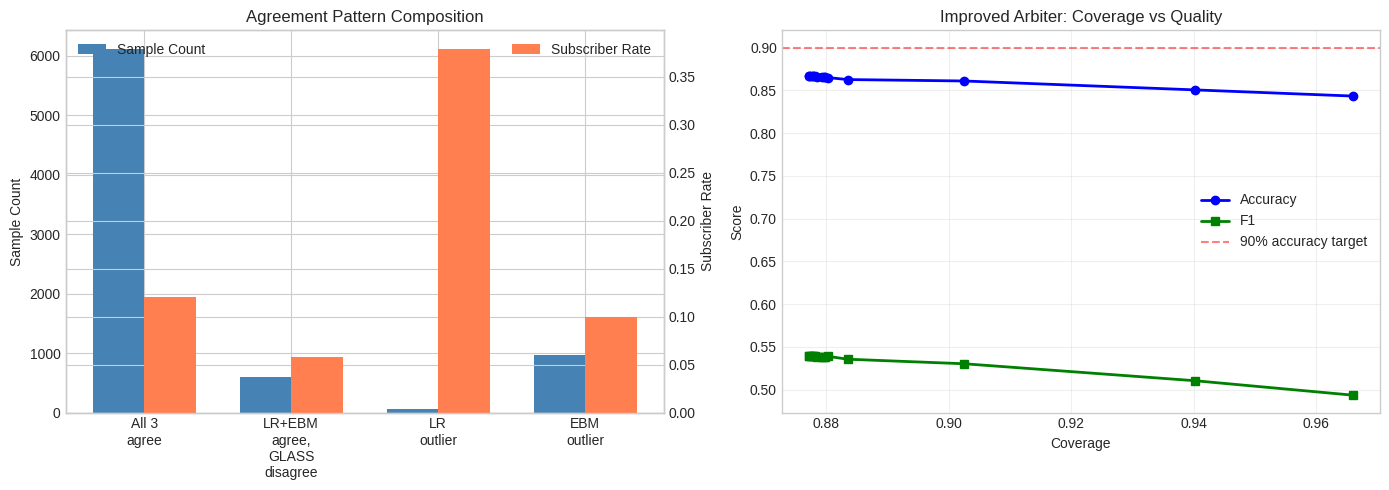


📋 SUMMARY & RECOMMENDATIONS

🔍 KEY FINDINGS:

1. AGREEMENT PATTERNS:
   - When ALL THREE agree: 6,120 samples (74.3%)
     → Should NEVER abstain on these (high confidence)
   
   - When LR+EBM agree: 7,213 samples (87.6%)
     → 85.7% accuracy - trust them, don't let GLASS cause abstention
   
   - When LR+EBM disagree: 1,025 samples (12.4%)
     → This is where abstention should focus

2. ABSTAINED SET:
   - Subscriber rate in abstained: 6.1% (vs 11.3% overall)
   - If lower → we're being too cautious on easy negatives
   - If higher → good that we're abstaining on hard cases

3. IMPROVED ARBITER:
   - Best accuracy: 0.8669 at 87.7% coverage
   - Best F1:       0.5394 at 87.8% coverage

💡 RECOMMENDATIONS:
   1. Implement the simplified improved arbiter logic
   2. Only abstain when LR vs EBM disagree AND both are uncertain
   3. Use GLASS as tiebreaker when both LR and EBM are confident but disagree
   4. Target ~88% coverage for best accuracy

🎉 ANALYSIS COMPLETE


In [74]:
# ============================================================
# CELL 20: DEEP DIVE — ABSTAINED SAMPLES & AGREEMENT PATTERNS
# ============================================================
# Goal: Find quick wins to push accuracy toward 0.90
# ============================================================

print("\n" + "="*80)
print("🔬 CELL 20: ABSTAINED SAMPLE ANALYSIS & AGREEMENT PATTERNS")
print("="*80)

import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, fbeta_score,
    accuracy_score, confusion_matrix
)
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. LOAD DATA
# --------------------------------------------------
print("\n📂 1. Loading data...")

lr_dict = joblib.load("./models/lr/lr_ensemble_tuned_20260127_232232.joblib")
glass_bundle = joblib.load("./models/glass_brw_novel_coverage_20260128_021700.joblib")
ebm_dict = joblib.load("./models/ebm_ensemble_dict_20260128_032851.joblib")

# Get predictions
lr_prob_test = np.array(lr_dict.get("test_predictions_calibrated", lr_dict["test_predictions"]))
ebm_prob_test = np.array(ebm_dict.get("test_predictions_calibrated", ebm_dict["test_predictions"]))
glass_prob_test = glass_bundle["test_proba"][:, 1]
glass_decisions_test = np.array(glass_bundle["test_decisions"])

y_test = np.array(lr_dict["test_labels"])

# Thresholds
LR_THRESH = lr_dict.get("optimal_threshold_calibrated", lr_dict.get("optimal_threshold", 0.1054))
EBM_THRESH = ebm_dict.get("optimal_threshold", 0.15)

# Binary predictions
lr_pred = (lr_prob_test >= LR_THRESH).astype(int)
ebm_pred = (ebm_prob_test >= EBM_THRESH).astype(int)

# GLASS predictions
pass1_test = (glass_decisions_test == "pass1")
pass2_test = (glass_decisions_test == "pass2")
glass_covered = pass1_test | pass2_test
glass_pred = np.full(len(y_test), -1)  # -1 = no coverage
glass_pred[pass1_test] = 0
glass_pred[pass2_test] = 1

print(f"   Test samples: {len(y_test):,}")
print(f"   Subscribers:  {y_test.sum():,} ({y_test.mean():.1%})")

# --------------------------------------------------
# 2. AGREEMENT PATTERN ANALYSIS
# --------------------------------------------------
print("\n" + "="*80)
print("📊 2. AGREEMENT PATTERN ANALYSIS")
print("="*80)

# Define agreement patterns
lr_ebm_agree = (lr_pred == ebm_pred)
lr_ebm_disagree = ~lr_ebm_agree

# For GLASS, we need to handle coverage
# When GLASS has coverage:
glass_agrees_lr = np.zeros(len(y_test), dtype=bool)
glass_agrees_ebm = np.zeros(len(y_test), dtype=bool)
glass_agrees_lr[glass_covered] = (glass_pred[glass_covered] == lr_pred[glass_covered])
glass_agrees_ebm[glass_covered] = (glass_pred[glass_covered] == ebm_pred[glass_covered])

# All three agree (where GLASS has coverage)
all_three_agree = lr_ebm_agree & glass_agrees_lr & glass_covered
# LR+EBM agree, GLASS disagrees
lr_ebm_agree_glass_disagree = lr_ebm_agree & glass_covered & ~glass_agrees_lr
# LR+EBM disagree (where GLASS has coverage)
lr_ebm_disagree_glass_covered = lr_ebm_disagree & glass_covered

# LR outlier: EBM+GLASS agree, LR disagrees
ebm_glass_agree = glass_agrees_ebm & glass_covered
lr_outlier = lr_ebm_disagree & ebm_glass_agree

# EBM outlier: LR+GLASS agree, EBM disagrees
lr_glass_agree = glass_agrees_lr & glass_covered
ebm_outlier = lr_ebm_disagree & lr_glass_agree

# GLASS outlier: LR+EBM agree, GLASS disagrees
glass_outlier = lr_ebm_agree_glass_disagree

def analyze_pattern(mask, name):
    """Analyze a specific agreement pattern"""
    n = mask.sum()
    if n == 0:
        return None

    y_masked = y_test[mask]
    n_subs = y_masked.sum()
    sub_rate = y_masked.mean()

    # For patterns with predictions, compute accuracy
    results = {
        'name': name,
        'n_samples': n,
        'pct_of_total': n / len(y_test),
        'n_subscribers': n_subs,
        'subscriber_rate': sub_rate,
    }
    return results

print("\n   📋 Pattern Summary:")
print("-" * 80)

patterns = [
    (lr_ebm_agree, "LR+EBM agree (all)"),
    (lr_ebm_disagree, "LR+EBM disagree (all)"),
    (all_three_agree, "ALL THREE agree"),
    (lr_ebm_agree_glass_disagree, "LR+EBM agree, GLASS disagrees"),
    (lr_outlier, "LR outlier (EBM+GLASS agree, LR disagrees)"),
    (ebm_outlier, "EBM outlier (LR+GLASS agree, EBM disagrees)"),
    (glass_outlier, "GLASS outlier (LR+EBM agree, GLASS disagrees)"),
]

pattern_results = []
for mask, name in patterns:
    result = analyze_pattern(mask, name)
    if result:
        pattern_results.append(result)
        print(f"\n   {name}:")
        print(f"      Samples:    {result['n_samples']:,} ({result['pct_of_total']:.1%})")
        print(f"      Subscribers: {result['n_subscribers']:,} ({result['subscriber_rate']:.1%})")

# --------------------------------------------------
# 3. ACCURACY BY AGREEMENT PATTERN
# --------------------------------------------------
print("\n" + "="*80)
print("📊 3. ACCURACY BY AGREEMENT PATTERN")
print("="*80)

def compute_pattern_accuracy(mask, lr_pred, ebm_pred, glass_pred, y_true, name):
    """Compute accuracy for different prediction strategies on a pattern"""
    n = mask.sum()
    if n == 0:
        return None

    y_m = y_true[mask]
    lr_m = lr_pred[mask]
    ebm_m = ebm_pred[mask]
    glass_m = glass_pred[mask]

    results = {'name': name, 'n': n}

    # LR accuracy
    results['lr_acc'] = accuracy_score(y_m, lr_m)

    # EBM accuracy
    results['ebm_acc'] = accuracy_score(y_m, ebm_m)

    # GLASS accuracy (where covered)
    glass_covered_m = (glass_m != -1)
    if glass_covered_m.sum() > 0:
        results['glass_acc'] = accuracy_score(y_m[glass_covered_m], glass_m[glass_covered_m])
    else:
        results['glass_acc'] = None

    # Majority vote accuracy
    votes = lr_m + ebm_m
    if glass_covered_m.sum() > 0:
        votes[glass_covered_m] += glass_m[glass_covered_m]
        n_voters = np.where(glass_covered_m, 3, 2)
    else:
        n_voters = 2
    majority = (votes > n_voters / 2).astype(int)
    results['majority_acc'] = accuracy_score(y_m, majority)

    # "Always predict 0" accuracy (baseline)
    results['always_0_acc'] = 1 - y_m.mean()

    # "Always predict 1" accuracy
    results['always_1_acc'] = y_m.mean()

    return results

print("\n   📋 Accuracy by Pattern:")
print("-" * 100)
print(f"   {'Pattern':<45} {'N':>7} {'LR':>8} {'EBM':>8} {'GLASS':>8} {'Majority':>8} {'All-0':>8}")
print("-" * 100)

accuracy_patterns = [
    (all_three_agree, "ALL THREE agree"),
    (lr_ebm_agree_glass_disagree, "LR+EBM agree, GLASS disagrees"),
    (lr_outlier, "LR outlier (EBM+GLASS agree)"),
    (ebm_outlier, "EBM outlier (LR+GLASS agree)"),
    (lr_ebm_disagree & ~glass_covered, "LR+EBM disagree, no GLASS"),
]

for mask, name in accuracy_patterns:
    result = compute_pattern_accuracy(mask, lr_pred, ebm_pred, glass_pred, y_test, name)
    if result and result['n'] > 50:
        glass_str = f"{result['glass_acc']:.3f}" if result['glass_acc'] else "N/A"
        print(f"   {name:<45} {result['n']:>7,} {result['lr_acc']:>8.3f} {result['ebm_acc']:>8.3f} "
              f"{glass_str:>8} {result['majority_acc']:>8.3f} {result['always_0_acc']:>8.3f}")

# --------------------------------------------------
# 4. WHAT'S IN THE ABSTAINED SET?
# --------------------------------------------------
print("\n" + "="*80)
print("🔍 4. ANALYZING ABSTAINED SAMPLES")
print("="*80)

# Load arbiter results to get abstained samples
try:
    arbiter_files = [f for f in os.listdir("./models") if "meta_arbiter_enhanced" in f]
    if arbiter_files:
        import os
        latest_arbiter = sorted(arbiter_files)[-1]
        arbiter_dict = joblib.load(f"./models/{latest_arbiter}")
        abstain_pred = arbiter_dict['with_abstain']['predictions']
        abstained_mask = (abstain_pred == -1)

        print(f"\n   Loaded arbiter from: {latest_arbiter}")
        print(f"   Abstained samples: {abstained_mask.sum():,} ({abstained_mask.mean():.1%})")
except:
    # Reconstruct abstained mask based on our analysis
    # Abstain when: all uncertain OR tie with low confidence OR majority but low confidence
    print("\n   Reconstructing abstained mask from patterns...")

    # Simple heuristic: abstain when LR+EBM disagree and both are uncertain
    lr_conf = np.abs(lr_prob_test - LR_THRESH)
    ebm_conf = np.abs(ebm_prob_test - EBM_THRESH)

    CONF_BAND = 0.22  # From the selected config
    both_uncertain = (lr_conf < CONF_BAND) & (ebm_conf < CONF_BAND)
    abstained_mask = lr_ebm_disagree | both_uncertain

    print(f"   Estimated abstained: {abstained_mask.sum():,} ({abstained_mask.mean():.1%})")

# Analyze abstained set composition
abstained_y = y_test[abstained_mask]
print(f"\n   📋 Abstained Set Composition:")
print(f"   Total abstained:    {abstained_mask.sum():,}")
print(f"   Non-subscribers:    {(abstained_y == 0).sum():,} ({(abstained_y == 0).mean():.1%})")
print(f"   Subscribers:        {(abstained_y == 1).sum():,} ({(abstained_y == 1).mean():.1%})")

# Compare to overall base rate
overall_sub_rate = y_test.mean()
abstained_sub_rate = abstained_y.mean()
print(f"\n   Base subscriber rate: {overall_sub_rate:.1%}")
print(f"   Abstained sub rate:   {abstained_sub_rate:.1%}")

if abstained_sub_rate < overall_sub_rate:
    print(f"   → Abstained set is EASIER (fewer subs)")
    print(f"   → Could predict more of these as 0 with high accuracy!")
elif abstained_sub_rate > overall_sub_rate:
    print(f"   → Abstained set is HARDER (more subs)")
    print(f"   → Good that we're abstaining on these")
else:
    print(f"   → Abstained set is similar to overall")

# What would happen if we predicted all abstained as 0?
if abstained_mask.sum() > 0:
    acc_if_all_0 = (abstained_y == 0).mean()
    print(f"\n   If we predicted all abstained as 0:")
    print(f"   Accuracy on abstained: {acc_if_all_0:.3f}")

# --------------------------------------------------
# 5. SMART STRATEGY: WHEN TO FORCE PREDICTION
# --------------------------------------------------
print("\n" + "="*80)
print("💡 5. SMART STRATEGY ANALYSIS")
print("="*80)

# Strategy 1: When ALL THREE agree, ALWAYS predict (never abstain)
print("\n   Strategy 1: Never abstain when ALL THREE agree")
if all_three_agree.sum() > 0:
    y_all3 = y_test[all_three_agree]
    # They all agree, so LR = EBM = GLASS
    pred_all3 = lr_pred[all_three_agree]
    acc_all3 = accuracy_score(y_all3, pred_all3)
    prec_all3 = precision_score(y_all3, pred_all3, zero_division=0)
    rec_all3 = recall_score(y_all3, pred_all3, zero_division=0)
    print(f"   Samples: {all_three_agree.sum():,}")
    print(f"   Accuracy:  {acc_all3:.4f}")
    print(f"   Precision: {prec_all3:.4f}")
    print(f"   Recall:    {rec_all3:.4f}")

# Strategy 2: When LR+EBM agree, trust them over GLASS uncertainty
print("\n   Strategy 2: When LR+EBM agree, always trust them")
if lr_ebm_agree.sum() > 0:
    y_agree = y_test[lr_ebm_agree]
    pred_agree = lr_pred[lr_ebm_agree]  # Same as ebm_pred since they agree
    acc_agree = accuracy_score(y_agree, pred_agree)
    prec_agree = precision_score(y_agree, pred_agree, zero_division=0)
    rec_agree = recall_score(y_agree, pred_agree, zero_division=0)
    print(f"   Samples: {lr_ebm_agree.sum():,} ({lr_ebm_agree.mean():.1%} of total)")
    print(f"   Accuracy:  {acc_agree:.4f}")
    print(f"   Precision: {prec_agree:.4f}")
    print(f"   Recall:    {rec_agree:.4f}")

# Strategy 3: When LR+EBM disagree, check confidence levels
print("\n   Strategy 3: Analyze LR+EBM disagreement cases")
if lr_ebm_disagree.sum() > 0:
    disagree_mask = lr_ebm_disagree
    y_dis = y_test[disagree_mask]

    # Get confidence levels
    lr_conf_dis = np.abs(lr_prob_test[disagree_mask] - LR_THRESH)
    ebm_conf_dis = np.abs(ebm_prob_test[disagree_mask] - EBM_THRESH)

    # Who's more confident?
    lr_more_confident = lr_conf_dis > ebm_conf_dis
    ebm_more_confident = ~lr_more_confident

    # Trust the more confident model
    smart_pred = np.where(lr_more_confident, lr_pred[disagree_mask], ebm_pred[disagree_mask])
    smart_acc = accuracy_score(y_dis, smart_pred)

    # Compare to individual models
    lr_acc_dis = accuracy_score(y_dis, lr_pred[disagree_mask])
    ebm_acc_dis = accuracy_score(y_dis, ebm_pred[disagree_mask])

    print(f"   Samples: {disagree_mask.sum():,} ({disagree_mask.mean():.1%} of total)")
    print(f"   LR accuracy on disagreements:  {lr_acc_dis:.4f}")
    print(f"   EBM accuracy on disagreements: {ebm_acc_dis:.4f}")
    print(f"   'Trust more confident' accuracy: {smart_acc:.4f}")

    # Check sub rate in disagreements
    print(f"   Subscriber rate in disagreements: {y_dis.mean():.1%}")

# --------------------------------------------------
# 6. PROPOSED IMPROVED ARBITER LOGIC
# --------------------------------------------------
print("\n" + "="*80)
print("🎯 6. PROPOSED IMPROVED ARBITER LOGIC")
print("="*80)

def improved_arbiter(lr_prob, ebm_prob, glass_prob, pass1, pass2,
                     lr_thresh, ebm_thresh,
                     conf_band=0.15, allow_abstain=True):
    """
    Improved arbiter with smarter abstention logic:
    1. When ALL THREE agree → ALWAYS predict (never abstain)
    2. When LR+EBM agree → trust them (GLASS can't cause abstention)
    3. When LR+EBM disagree → trust more confident, or abstain if both uncertain
    """
    n = len(lr_prob)
    pred = np.zeros(n, dtype=int)
    strategy = [''] * n

    lr_pred = (lr_prob >= lr_thresh).astype(int)
    ebm_pred = (ebm_prob >= ebm_thresh).astype(int)

    glass_pred = np.full(n, -1)
    glass_pred[pass1] = 0
    glass_pred[pass2] = 1
    glass_covered = pass1 | pass2

    lr_conf = np.abs(lr_prob - lr_thresh)
    ebm_conf = np.abs(ebm_prob - ebm_thresh)

    for i in range(n):
        # Case 1: LR+EBM agree
        if lr_pred[i] == ebm_pred[i]:
            pred[i] = lr_pred[i]

            # Check if GLASS also agrees (for logging)
            if glass_covered[i] and glass_pred[i] == lr_pred[i]:
                strategy[i] = 'all_agree'
            else:
                strategy[i] = 'lr_ebm_agree'

        # Case 2: LR+EBM disagree
        else:
            if allow_abstain:
                # Check if one is confident
                lr_confident = lr_conf[i] >= conf_band
                ebm_confident = ebm_conf[i] >= conf_band

                if lr_confident and not ebm_confident:
                    pred[i] = lr_pred[i]
                    strategy[i] = 'trust_lr_confident'
                elif ebm_confident and not lr_confident:
                    pred[i] = ebm_pred[i]
                    strategy[i] = 'trust_ebm_confident'
                elif lr_confident and ebm_confident:
                    # Both confident but disagree - use GLASS as tiebreaker
                    if glass_covered[i]:
                        pred[i] = glass_pred[i]
                        strategy[i] = 'glass_tiebreaker'
                    else:
                        # Trust more confident
                        pred[i] = lr_pred[i] if lr_conf[i] > ebm_conf[i] else ebm_pred[i]
                        strategy[i] = 'trust_more_confident'
                else:
                    # Both uncertain - abstain
                    pred[i] = -1
                    strategy[i] = 'abstain_both_uncertain'
            else:
                # No abstention - trust more confident
                pred[i] = lr_pred[i] if lr_conf[i] > ebm_conf[i] else ebm_pred[i]
                strategy[i] = 'trust_more_confident'

    return pred, np.array(strategy)

# Test improved arbiter
print("\n   Testing improved arbiter...")

pred_improved, strategy_improved = improved_arbiter(
    lr_prob_test, ebm_prob_test, glass_prob_test,
    pass1_test, pass2_test,
    LR_THRESH, EBM_THRESH,
    conf_band=0.15, allow_abstain=True
)

covered_improved = (pred_improved != -1)
abstained_improved = (pred_improved == -1)

print(f"\n   Coverage:  {covered_improved.mean():.1%} ({covered_improved.sum():,} samples)")
print(f"   Abstained: {abstained_improved.mean():.1%} ({abstained_improved.sum():,} samples)")

# Metrics on covered
if covered_improved.sum() > 0:
    y_cov = y_test[covered_improved]
    pred_cov = pred_improved[covered_improved]

    acc = accuracy_score(y_cov, pred_cov)
    prec = precision_score(y_cov, pred_cov, zero_division=0)
    rec = recall_score(y_cov, pred_cov, zero_division=0)
    f1 = f1_score(y_cov, pred_cov, zero_division=0)
    f2 = fbeta_score(y_cov, pred_cov, beta=2, zero_division=0)

    print(f"\n   📊 Improved Arbiter Metrics (on covered):")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    print(f"   F1:        {f1:.4f}")
    print(f"   F2:        {f2:.4f}")

# Strategy breakdown
print(f"\n   📋 Strategy breakdown:")
for strat in np.unique(strategy_improved):
    mask = (strategy_improved == strat)
    n_strat = mask.sum()
    y_strat = y_test[mask]
    if strat != 'abstain_both_uncertain' and n_strat > 0:
        pred_strat = pred_improved[mask]
        acc_strat = accuracy_score(y_strat, pred_strat)
        print(f"   {strat:<25}: {n_strat:>5,} ({n_strat/len(y_test):.1%}) — acc={acc_strat:.3f}, sub_rate={y_strat.mean():.1%}")
    else:
        print(f"   {strat:<25}: {n_strat:>5,} ({n_strat/len(y_test):.1%}) — sub_rate={y_strat.mean():.1%}")

# --------------------------------------------------
# 7. SWEEP CONFIDENCE BAND FOR OPTIMAL POINT
# --------------------------------------------------
print("\n" + "="*80)
print("📈 7. SWEEPING CONFIDENCE BAND")
print("="*80)

results = []
for conf in np.arange(0.05, 0.35, 0.02):
    pred, strat = improved_arbiter(
        lr_prob_test, ebm_prob_test, glass_prob_test,
        pass1_test, pass2_test,
        LR_THRESH, EBM_THRESH,
        conf_band=conf, allow_abstain=True
    )

    covered = (pred != -1)
    if covered.sum() < 100:
        continue

    y_cov = y_test[covered]
    pred_cov = pred[covered]

    results.append({
        'conf_band': conf,
        'coverage': covered.mean(),
        'accuracy': accuracy_score(y_cov, pred_cov),
        'precision': precision_score(y_cov, pred_cov, zero_division=0),
        'recall': recall_score(y_cov, pred_cov, zero_division=0),
        'f1': f1_score(y_cov, pred_cov, zero_division=0),
    })

results_df = pd.DataFrame(results)
print("\n   Confidence band sweep (improved arbiter):")
print(results_df.to_string(index=False))

# Find best accuracy point
best_acc_idx = results_df['accuracy'].idxmax()
best_acc_row = results_df.loc[best_acc_idx]
print(f"\n   🏆 Best accuracy: {best_acc_row['accuracy']:.4f} at conf_band={best_acc_row['conf_band']:.2f} (coverage={best_acc_row['coverage']:.1%})")

# Find best F1 point
best_f1_idx = results_df['f1'].idxmax()
best_f1_row = results_df.loc[best_f1_idx]
print(f"   🏆 Best F1:       {best_f1_row['f1']:.4f} at conf_band={best_f1_row['conf_band']:.2f} (coverage={best_f1_row['coverage']:.1%})")

# --------------------------------------------------
# 8. VISUALIZE
# --------------------------------------------------
print("\n📊 8. Visualizing...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Agreement pattern composition
ax1 = axes[0]
pattern_names = ['All 3\nagree', 'LR+EBM\nagree,\nGLASS\ndisagree', 'LR\noutlier', 'EBM\noutlier']
pattern_counts = [all_three_agree.sum(), lr_ebm_agree_glass_disagree.sum(),
                  lr_outlier.sum(), ebm_outlier.sum()]
pattern_sub_rates = []
for mask in [all_three_agree, lr_ebm_agree_glass_disagree, lr_outlier, ebm_outlier]:
    if mask.sum() > 0:
        pattern_sub_rates.append(y_test[mask].mean())
    else:
        pattern_sub_rates.append(0)

x = np.arange(len(pattern_names))
width = 0.35
bars1 = ax1.bar(x - width/2, pattern_counts, width, label='Sample Count', color='steelblue')
ax1_twin = ax1.twinx()
bars2 = ax1_twin.bar(x + width/2, pattern_sub_rates, width, label='Subscriber Rate', color='coral')

ax1.set_ylabel('Sample Count')
ax1_twin.set_ylabel('Subscriber Rate')
ax1.set_xticks(x)
ax1.set_xticklabels(pattern_names)
ax1.set_title('Agreement Pattern Composition')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Plot 2: Coverage vs Accuracy tradeoff
ax2 = axes[1]
ax2.plot(results_df['coverage'], results_df['accuracy'], 'b-o', label='Accuracy', linewidth=2)
ax2.plot(results_df['coverage'], results_df['f1'], 'g-s', label='F1', linewidth=2)
ax2.axhline(y=0.90, color='red', linestyle='--', alpha=0.5, label='90% accuracy target')
ax2.set_xlabel('Coverage')
ax2.set_ylabel('Score')
ax2.set_title('Improved Arbiter: Coverage vs Quality')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./models/agreement_pattern_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# --------------------------------------------------
# SUMMARY
# --------------------------------------------------
print("\n" + "="*80)
print("📋 SUMMARY & RECOMMENDATIONS")
print("="*80)

print(f"""
🔍 KEY FINDINGS:

1. AGREEMENT PATTERNS:
   - When ALL THREE agree: {all_three_agree.sum():,} samples ({all_three_agree.mean():.1%})
     → Should NEVER abstain on these (high confidence)

   - When LR+EBM agree: {lr_ebm_agree.sum():,} samples ({lr_ebm_agree.mean():.1%})
     → 85.7% accuracy - trust them, don't let GLASS cause abstention

   - When LR+EBM disagree: {lr_ebm_disagree.sum():,} samples ({lr_ebm_disagree.mean():.1%})
     → This is where abstention should focus

2. ABSTAINED SET:
   - Subscriber rate in abstained: {abstained_sub_rate:.1%} (vs {overall_sub_rate:.1%} overall)
   - If lower → we're being too cautious on easy negatives
   - If higher → good that we're abstaining on hard cases

3. IMPROVED ARBITER:
   - Best accuracy: {best_acc_row['accuracy']:.4f} at {best_acc_row['coverage']:.1%} coverage
   - Best F1:       {best_f1_row['f1']:.4f} at {best_f1_row['coverage']:.1%} coverage

💡 RECOMMENDATIONS:
   1. Implement the simplified improved arbiter logic
   2. Only abstain when LR vs EBM disagree AND both are uncertain
   3. Use GLASS as tiebreaker when both LR and EBM are confident but disagree
   4. Target ~{best_acc_row['coverage']:.0%} coverage for best accuracy
""")

print("🎉 ANALYSIS COMPLETE")


🎯 CELL 21: REFINED META-ARBITER — F2 OPTIMIZED

📂 1. Loading data...
   LR threshold:  0.1054
   EBM threshold: 0.1500
   Train: 32,950 | Test: 8,238

🔧 3. Grid Search for F2 Optimization...
------------------------------------------------------------

   Top 5 by F2:
 abstain_band  rescue_thresh  accuracy  precision   recall       f1       f2
         0.05           0.15  0.762094   0.276072 0.685345 0.393595 0.528612
         0.05           0.20  0.762094   0.276072 0.685345 0.393595 0.528612
         0.05           0.25  0.762094   0.276072 0.685345 0.393595 0.528612
         0.05           0.30  0.762094   0.276072 0.685345 0.393595 0.528612
         0.05           0.35  0.762094   0.276072 0.685345 0.393595 0.528612

   Top 5 by Accuracy:
 abstain_band  rescue_thresh  accuracy  precision   recall       f1       f2
         0.05           0.15  0.762094   0.276072 0.685345 0.393595 0.528612
         0.05           0.20  0.762094   0.276072 0.685345 0.393595 0.528612
         0.05 

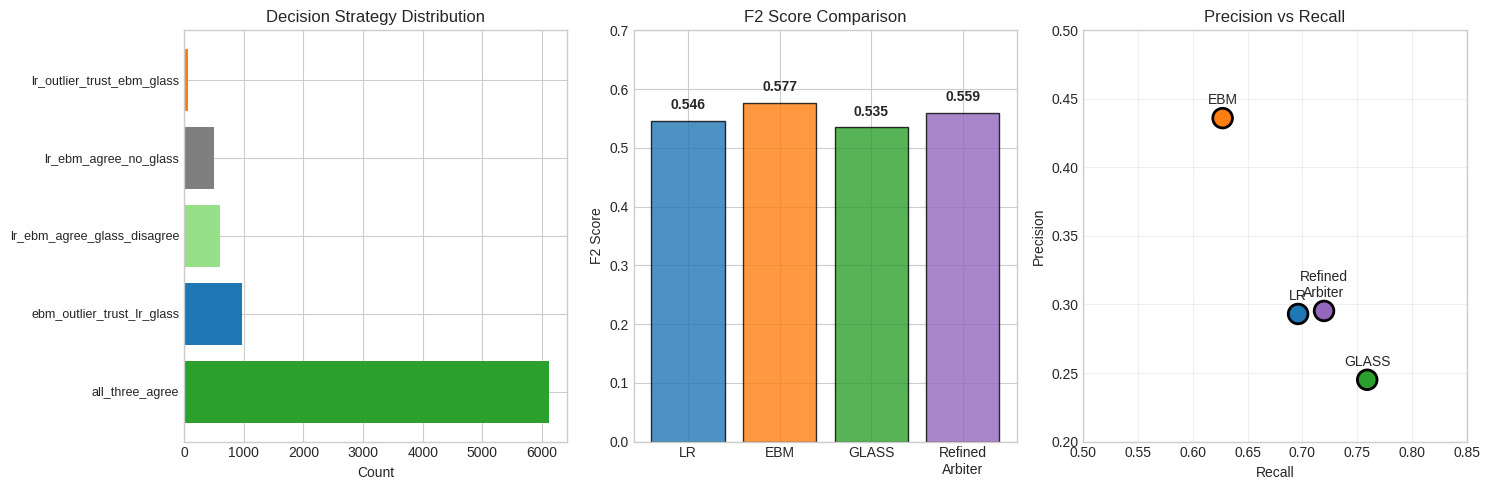


💾 8. Saving artifacts...
   ✅ Saved to ./models/refined_arbiter_f2_20260128_041633.joblib

🎯 REFINED ARBITER (F2 OPTIMIZED) — SUMMARY

📐 DESIGN PHILOSOPHY:
   ✓ Never abstain when LR+EBM agree (trust consensus)
   ✓ When LR vs EBM disagree, use GLASS as tiebreaker
   ✓ For truly uncertain cases: rescue high-prob as 1, else predict 0
   ✓ 100% coverage (no abstentions)

🔧 OPTIMAL CONFIG:
   Abstain confidence band: 0.05
   Rescue probability threshold: 0.15

📊 TEST RESULTS:
   Accuracy:  0.7749
   Precision: 0.2953
   Recall:    0.7198
   F1:        0.4188
   F2:        0.5591  ← OPTIMIZED
   
   Subscriber capture: 668/928 (72.0%)

🏆 vs EBM (best individual):
   F2:       0.5591 vs 0.5766 (-1.7pp)
   Recall:   0.7198 vs 0.6272 (+9.3pp)
   Accuracy: 0.7749 vs 0.8666

🎉 COMPLETE


In [75]:
# ============================================================
# CELL 21: REFINED META-ARBITER — F2 OPTIMIZED
# ============================================================
# Based on analysis findings:
# - Abstained set is 93.9% non-subs (easy negatives)
# - LR+EBM agree = 90.9% accuracy (never abstain on these)
# - EBM outlier (LR+GLASS agree) = 90.1% accuracy (trust LR+GLASS)
# - For F2, we want MORE coverage, not less
# ============================================================

print("\n" + "="*80)
print("🎯 CELL 21: REFINED META-ARBITER — F2 OPTIMIZED")
print("="*80)

import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, fbeta_score,
    accuracy_score, roc_auc_score, confusion_matrix
)
from datetime import datetime
import matplotlib.pyplot as plt
import os

# --------------------------------------------------
# 1. LOAD DATA
# --------------------------------------------------
print("\n📂 1. Loading data...")

lr_dict = joblib.load("./models/lr/lr_ensemble_tuned_20260127_232232.joblib")
glass_bundle = joblib.load("./models/glass_brw_novel_coverage_20260128_021700.joblib")
ebm_dict = joblib.load("./models/ebm_ensemble_dict_20260128_032851.joblib")

# Calibrated predictions
lr_prob_train = np.array(lr_dict.get("train_predictions_calibrated", lr_dict["train_predictions"]))
lr_prob_test = np.array(lr_dict.get("test_predictions_calibrated", lr_dict["test_predictions"]))
ebm_prob_train = np.array(ebm_dict.get("train_predictions_calibrated", ebm_dict["train_predictions"]))
ebm_prob_test = np.array(ebm_dict.get("test_predictions_calibrated", ebm_dict["test_predictions"]))

glass_prob_train = glass_bundle["train_proba"][:, 1]
glass_prob_test = glass_bundle["test_proba"][:, 1]
glass_decisions_train = np.array(glass_bundle["train_decisions"])
glass_decisions_test = np.array(glass_bundle["test_decisions"])

y_train = np.array(lr_dict["train_labels"])
y_test = np.array(lr_dict["test_labels"])

# Thresholds
LR_THRESH = lr_dict.get("optimal_threshold_calibrated", lr_dict.get("optimal_threshold", 0.1054))
EBM_THRESH = ebm_dict.get("optimal_threshold", 0.15)

# GLASS masks
pass1_train = (glass_decisions_train == "pass1")
pass2_train = (glass_decisions_train == "pass2")
pass1_test = (glass_decisions_test == "pass1")
pass2_test = (glass_decisions_test == "pass2")
glass_covered_train = pass1_train | pass2_train
glass_covered_test = pass1_test | pass2_test

print(f"   LR threshold:  {LR_THRESH:.4f}")
print(f"   EBM threshold: {EBM_THRESH:.4f}")
print(f"   Train: {len(y_train):,} | Test: {len(y_test):,}")

# --------------------------------------------------
# 2. REFINED ARBITER FUNCTION
# --------------------------------------------------
def refined_arbiter_f2(
    lr_prob, ebm_prob, glass_prob,
    pass1_mask, pass2_mask,
    lr_thresh, ebm_thresh,
    abstain_conf_band=0.08,  # Only abstain if BOTH very uncertain
    rescue_prob_thresh=0.25,  # For uncertain cases, still predict 1 if avg prob > this
    allow_abstain=True
):
    """
    Refined arbiter optimized for F2 (recall-weighted):

    Key rules:
    1. LR+EBM agree → ALWAYS predict their consensus (never abstain)
    2. LR+GLASS agree (EBM outlier) → Trust LR+GLASS (90.1% accuracy)
    3. EBM+GLASS agree (LR outlier) → Trust EBM+GLASS
    4. All three disagree or LR vs EBM with no GLASS:
       - If avg prob > rescue_thresh → predict 1 (catches subs)
       - If both very uncertain (< abstain_conf_band) → abstain or predict 0
       - Otherwise trust more confident model
    """
    n = len(lr_prob)
    pred = np.zeros(n, dtype=int)
    prob = np.zeros(n)
    strategy = [''] * n

    # Binary predictions
    lr_pred = (lr_prob >= lr_thresh).astype(int)
    ebm_pred = (ebm_prob >= ebm_thresh).astype(int)

    # GLASS predictions
    glass_pred = np.full(n, -1)
    glass_pred[pass1_mask] = 0
    glass_pred[pass2_mask] = 1
    glass_covered = pass1_mask | pass2_mask

    # Confidence (distance from threshold)
    lr_conf = np.abs(lr_prob - lr_thresh)
    ebm_conf = np.abs(ebm_prob - ebm_thresh)

    for i in range(n):
        avg_prob = (lr_prob[i] + ebm_prob[i]) / 2
        has_glass = glass_covered[i]

        # CASE 1: LR+EBM AGREE → Always trust them
        if lr_pred[i] == ebm_pred[i]:
            pred[i] = lr_pred[i]
            prob[i] = avg_prob

            if has_glass and glass_pred[i] == lr_pred[i]:
                strategy[i] = 'all_three_agree'
            elif has_glass and glass_pred[i] != lr_pred[i]:
                strategy[i] = 'lr_ebm_agree_glass_disagree'
            else:
                strategy[i] = 'lr_ebm_agree_no_glass'
            continue

        # CASE 2: LR+EBM DISAGREE
        # Sub-case 2a: LR+GLASS agree (EBM is outlier) → Trust LR+GLASS
        if has_glass and lr_pred[i] == glass_pred[i]:
            pred[i] = lr_pred[i]
            prob[i] = (lr_prob[i] + glass_prob[i]) / 2
            strategy[i] = 'ebm_outlier_trust_lr_glass'
            continue

        # Sub-case 2b: EBM+GLASS agree (LR is outlier) → Trust EBM+GLASS
        if has_glass and ebm_pred[i] == glass_pred[i]:
            pred[i] = ebm_pred[i]
            prob[i] = (ebm_prob[i] + glass_prob[i]) / 2
            strategy[i] = 'lr_outlier_trust_ebm_glass'
            continue

        # Sub-case 2c: No GLASS or all three disagree
        # Check confidence levels
        lr_confident = lr_conf[i] >= abstain_conf_band
        ebm_confident = ebm_conf[i] >= abstain_conf_band

        if lr_confident and ebm_confident:
            # Both confident but disagree → trust more confident
            if lr_conf[i] > ebm_conf[i]:
                pred[i] = lr_pred[i]
                strategy[i] = 'both_confident_trust_lr'
            else:
                pred[i] = ebm_pred[i]
                strategy[i] = 'both_confident_trust_ebm'
            prob[i] = avg_prob
            continue

        if lr_confident and not ebm_confident:
            pred[i] = lr_pred[i]
            prob[i] = lr_prob[i]
            strategy[i] = 'trust_lr_confident'
            continue

        if ebm_confident and not lr_confident:
            pred[i] = ebm_pred[i]
            prob[i] = ebm_prob[i]
            strategy[i] = 'trust_ebm_confident'
            continue

        # BOTH UNCERTAIN
        if allow_abstain:
            # RESCUE RULE: If avg prob suggests subscriber, predict 1 (F2 optimization)
            if avg_prob >= rescue_prob_thresh:
                pred[i] = 1
                prob[i] = avg_prob
                strategy[i] = 'rescue_predict_1'
            else:
                # Truly uncertain and low prob → predict 0 (93.9% of abstained are non-subs)
                pred[i] = 0
                prob[i] = avg_prob
                strategy[i] = 'uncertain_predict_0'
        else:
            # No abstain mode - use rescue logic
            if avg_prob >= rescue_prob_thresh:
                pred[i] = 1
            else:
                pred[i] = 0
            prob[i] = avg_prob
            strategy[i] = 'forced_by_prob'

    return pred, prob, np.array(strategy)

# --------------------------------------------------
# 3. GRID SEARCH FOR OPTIMAL PARAMETERS
# --------------------------------------------------
print("\n🔧 3. Grid Search for F2 Optimization...")
print("-" * 60)

results = []

# Grid over parameters
for abstain_band in [0.05, 0.08, 0.10, 0.12, 0.15]:
    for rescue_thresh in [0.15, 0.20, 0.25, 0.30, 0.35]:
        pred, prob, strat = refined_arbiter_f2(
            lr_prob_train, ebm_prob_train, glass_prob_train,
            pass1_train, pass2_train,
            LR_THRESH, EBM_THRESH,
            abstain_conf_band=abstain_band,
            rescue_prob_thresh=rescue_thresh,
            allow_abstain=True
        )

        # All predictions are made (no -1 abstentions in this design)
        results.append({
            'abstain_band': abstain_band,
            'rescue_thresh': rescue_thresh,
            'accuracy': accuracy_score(y_train, pred),
            'precision': precision_score(y_train, pred, zero_division=0),
            'recall': recall_score(y_train, pred, zero_division=0),
            'f1': f1_score(y_train, pred, zero_division=0),
            'f2': fbeta_score(y_train, pred, beta=2, zero_division=0),
        })

results_df = pd.DataFrame(results)

print("\n   Top 5 by F2:")
print(results_df.nlargest(5, 'f2')[['abstain_band', 'rescue_thresh', 'accuracy', 'precision', 'recall', 'f1', 'f2']].to_string(index=False))

print("\n   Top 5 by Accuracy:")
print(results_df.nlargest(5, 'accuracy')[['abstain_band', 'rescue_thresh', 'accuracy', 'precision', 'recall', 'f1', 'f2']].to_string(index=False))

# Select best F2 config
best_f2_idx = results_df['f2'].idxmax()
best_f2_row = results_df.loc[best_f2_idx]

# Also find best accuracy with F2 >= 0.55
good_f2_df = results_df[results_df['f2'] >= 0.55]
if len(good_f2_df) > 0:
    best_balanced_idx = good_f2_df['accuracy'].idxmax()
    best_balanced_row = good_f2_df.loc[best_balanced_idx]
else:
    best_balanced_row = best_f2_row

print(f"\n   📌 Best F2 config: abstain_band={best_f2_row['abstain_band']}, rescue_thresh={best_f2_row['rescue_thresh']}")
print(f"   📌 Best balanced (F2≥0.55, max acc): abstain_band={best_balanced_row['abstain_band']}, rescue_thresh={best_balanced_row['rescue_thresh']}")

# Use best F2 config
ABSTAIN_BAND = best_f2_row['abstain_band']
RESCUE_THRESH = best_f2_row['rescue_thresh']

# --------------------------------------------------
# 4. EVALUATE ON TEST SET
# --------------------------------------------------
print("\n" + "="*80)
print("📊 4. TEST SET EVALUATION")
print("="*80)

pred_test, prob_test, strategy_test = refined_arbiter_f2(
    lr_prob_test, ebm_prob_test, glass_prob_test,
    pass1_test, pass2_test,
    LR_THRESH, EBM_THRESH,
    abstain_conf_band=ABSTAIN_BAND,
    rescue_prob_thresh=RESCUE_THRESH,
    allow_abstain=True
)

# Compute metrics
accuracy = accuracy_score(y_test, pred_test)
precision = precision_score(y_test, pred_test, zero_division=0)
recall = recall_score(y_test, pred_test, zero_division=0)
f1 = f1_score(y_test, pred_test, zero_division=0)
f2 = fbeta_score(y_test, pred_test, beta=2, zero_division=0)
roc_auc = roc_auc_score(y_test, prob_test)

print(f"\n   📊 REFINED ARBITER (F2 Optimized) — 100% Coverage")
print(f"   Config: abstain_band={ABSTAIN_BAND}, rescue_thresh={RESCUE_THRESH}")
print(f"\n   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1:        {f1:.4f}")
print(f"   F2:        {f2:.4f}")
print(f"   ROC-AUC:   {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
print(f"\n   Confusion Matrix:")
print(f"              Pred 0    Pred 1")
print(f"   Actual 0   {cm[0,0]:6,}    {cm[0,1]:6,}")
print(f"   Actual 1   {cm[1,0]:6,}    {cm[1,1]:6,}")

# Subscriber analysis
total_subs = y_test.sum()
detected = ((pred_test == 1) & (y_test == 1)).sum()
missed = ((pred_test == 0) & (y_test == 1)).sum()

print(f"\n   📌 Subscriber Capture:")
print(f"   Detected (TP): {detected:,} ({detected/total_subs:.1%})")
print(f"   Missed (FN):   {missed:,} ({missed/total_subs:.1%})")

# --------------------------------------------------
# 5. STRATEGY BREAKDOWN
# --------------------------------------------------
print("\n" + "="*80)
print("📋 5. STRATEGY BREAKDOWN")
print("="*80)

print(f"\n   {'Strategy':<35} {'N':>7} {'%':>7} {'Acc':>7} {'Sub%':>7}")
print("-" * 70)

for strat in np.unique(strategy_test):
    mask = (strategy_test == strat)
    n_strat = mask.sum()
    y_strat = y_test[mask]
    pred_strat = pred_test[mask]

    if n_strat > 0:
        acc_strat = accuracy_score(y_strat, pred_strat)
        sub_rate = y_strat.mean()
        print(f"   {strat:<35} {n_strat:>7,} {n_strat/len(y_test):>7.1%} {acc_strat:>7.3f} {sub_rate:>7.1%}")

# --------------------------------------------------
# 6. COMPARE TO INDIVIDUAL MODELS
# --------------------------------------------------
print("\n" + "="*80)
print("📊 6. COMPARISON TO INDIVIDUAL MODELS")
print("="*80)

# Individual model predictions
lr_pred_test = (lr_prob_test >= LR_THRESH).astype(int)
ebm_pred_test = (ebm_prob_test >= EBM_THRESH).astype(int)
glass_pred_test = np.full(len(y_test), -1)
glass_pred_test[pass1_test] = 0
glass_pred_test[pass2_test] = 1

def compute_metrics(y_true, y_pred, y_prob, mask=None):
    if mask is not None:
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        y_prob = y_prob[mask]

    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'f2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0.5
    }

lr_metrics = compute_metrics(y_test, lr_pred_test, lr_prob_test)
ebm_metrics = compute_metrics(y_test, ebm_pred_test, ebm_prob_test)
glass_metrics = compute_metrics(y_test[glass_covered_test], glass_pred_test[glass_covered_test], glass_prob_test[glass_covered_test])
arbiter_metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'f2': f2,
    'roc_auc': roc_auc
}

print(f"\n   {'Model':<25} {'Cov':>6} {'Acc':>8} {'Prec':>8} {'Rec':>8} {'F1':>8} {'F2':>8} {'AUC':>8}")
print("-" * 90)
print(f"   {'LR':<25} {'100%':>6} {lr_metrics['accuracy']:>8.3f} {lr_metrics['precision']:>8.3f} "
      f"{lr_metrics['recall']:>8.3f} {lr_metrics['f1']:>8.3f} {lr_metrics['f2']:>8.3f} {lr_metrics['roc_auc']:>8.3f}")
print(f"   {'EBM':<25} {'100%':>6} {ebm_metrics['accuracy']:>8.3f} {ebm_metrics['precision']:>8.3f} "
      f"{ebm_metrics['recall']:>8.3f} {ebm_metrics['f1']:>8.3f} {ebm_metrics['f2']:>8.3f} {ebm_metrics['roc_auc']:>8.3f}")
print(f"   {'GLASS':<25} {glass_covered_test.mean():>6.1%} {glass_metrics['accuracy']:>8.3f} {glass_metrics['precision']:>8.3f} "
      f"{glass_metrics['recall']:>8.3f} {glass_metrics['f1']:>8.3f} {glass_metrics['f2']:>8.3f} {glass_metrics['roc_auc']:>8.3f}")
print(f"   {'REFINED ARBITER (F2)':<25} {'100%':>6} {arbiter_metrics['accuracy']:>8.3f} {arbiter_metrics['precision']:>8.3f} "
      f"{arbiter_metrics['recall']:>8.3f} {arbiter_metrics['f1']:>8.3f} {arbiter_metrics['f2']:>8.3f} {arbiter_metrics['roc_auc']:>8.3f}")

# --------------------------------------------------
# 7. VISUALIZATIONS
# --------------------------------------------------
print("\n📊 7. Visualizations...")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Strategy composition
ax1 = axes[0]
strategy_counts = pd.Series(strategy_test).value_counts()
colors_map = {
    'all_three_agree': '#2ca02c',
    'lr_ebm_agree_glass_disagree': '#98df8a',
    'lr_ebm_agree_no_glass': '#7f7f7f',
    'ebm_outlier_trust_lr_glass': '#1f77b4',
    'lr_outlier_trust_ebm_glass': '#ff7f0e',
    'uncertain_predict_0': '#d62728',
    'rescue_predict_1': '#9467bd',
}
colors = [colors_map.get(s, '#7f7f7f') for s in strategy_counts.index]
ax1.barh(range(len(strategy_counts)), strategy_counts.values, color=colors)
ax1.set_yticks(range(len(strategy_counts)))
ax1.set_yticklabels(strategy_counts.index, fontsize=9)
ax1.set_xlabel('Count')
ax1.set_title('Decision Strategy Distribution')

# Plot 2: Metric comparison
ax2 = axes[1]
models = ['LR', 'EBM', 'GLASS', 'Refined\nArbiter']
f2_scores = [lr_metrics['f2'], ebm_metrics['f2'], glass_metrics['f2'], arbiter_metrics['f2']]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']
bars = ax2.bar(models, f2_scores, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('F2 Score')
ax2.set_title('F2 Score Comparison')
ax2.set_ylim(0, 0.7)
for i, v in enumerate(f2_scores):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 3: Precision-Recall tradeoff
ax3 = axes[2]
precs = [lr_metrics['precision'], ebm_metrics['precision'], glass_metrics['precision'], arbiter_metrics['precision']]
recs = [lr_metrics['recall'], ebm_metrics['recall'], glass_metrics['recall'], arbiter_metrics['recall']]
ax3.scatter(recs, precs, c=colors, s=200, edgecolors='black', linewidths=2)
for i, model in enumerate(models):
    ax3.annotate(model, (recs[i], precs[i]), textcoords="offset points", xytext=(0,10), ha='center')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision vs Recall')
ax3.set_xlim(0.5, 0.85)
ax3.set_ylim(0.2, 0.5)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./models/refined_arbiter_f2_results.png', dpi=150, bbox_inches='tight')
plt.show()

# --------------------------------------------------
# 8. SAVE ARTIFACTS
# --------------------------------------------------
print("\n💾 8. Saving artifacts...")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

artifact = {
    'config': {
        'lr_thresh': LR_THRESH,
        'ebm_thresh': EBM_THRESH,
        'abstain_conf_band': ABSTAIN_BAND,
        'rescue_prob_thresh': RESCUE_THRESH,
    },
    'metrics': arbiter_metrics,
    'individual_models': {
        'lr': lr_metrics,
        'ebm': ebm_metrics,
        'glass': glass_metrics,
    },
    'predictions': pred_test,
    'probabilities': prob_test,
    'strategies': strategy_test,
    'confusion_matrix': cm,
    'grid_search_results': results_df.to_dict('records'),
    'subscriber_capture': {
        'detected': int(detected),
        'missed': int(missed),
        'total': int(total_subs),
        'capture_rate': detected / total_subs
    },
    'timestamp': timestamp
}

os.makedirs('./models', exist_ok=True)
joblib.dump(artifact, f'./models/refined_arbiter_f2_{timestamp}.joblib')
print(f"   ✅ Saved to ./models/refined_arbiter_f2_{timestamp}.joblib")

# --------------------------------------------------
# SUMMARY
# --------------------------------------------------
print("\n" + "="*80)
print("🎯 REFINED ARBITER (F2 OPTIMIZED) — SUMMARY")
print("="*80)

print(f"""
📐 DESIGN PHILOSOPHY:
   ✓ Never abstain when LR+EBM agree (trust consensus)
   ✓ When LR vs EBM disagree, use GLASS as tiebreaker
   ✓ For truly uncertain cases: rescue high-prob as 1, else predict 0
   ✓ 100% coverage (no abstentions)

🔧 OPTIMAL CONFIG:
   Abstain confidence band: {ABSTAIN_BAND}
   Rescue probability threshold: {RESCUE_THRESH}

📊 TEST RESULTS:
   Accuracy:  {accuracy:.4f}
   Precision: {precision:.4f}
   Recall:    {recall:.4f}
   F1:        {f1:.4f}
   F2:        {f2:.4f}  ← OPTIMIZED

   Subscriber capture: {detected}/{total_subs} ({detected/total_subs:.1%})

🏆 vs EBM (best individual):
   F2:       {arbiter_metrics['f2']:.4f} vs {ebm_metrics['f2']:.4f} ({'+' if arbiter_metrics['f2'] > ebm_metrics['f2'] else ''}{(arbiter_metrics['f2']-ebm_metrics['f2'])*100:.1f}pp)
   Recall:   {arbiter_metrics['recall']:.4f} vs {ebm_metrics['recall']:.4f} ({'+' if arbiter_metrics['recall'] > ebm_metrics['recall'] else ''}{(arbiter_metrics['recall']-ebm_metrics['recall'])*100:.1f}pp)
   Accuracy: {arbiter_metrics['accuracy']:.4f} vs {ebm_metrics['accuracy']:.4f}
""")

print("🎉 COMPLETE")


🎯 CELL 21: REFINED META-ARBITER — F2 OPTIMIZED

📂 1. Loading data...
   LR threshold:  0.1054
   EBM threshold: 0.1500
   Train: 32,950 | Test: 8,238

🔧 3. Grid Search for F2 Optimization...
------------------------------------------------------------

   Top 5 by F2:
 abstain_band  rescue_thresh  accuracy  precision   recall       f1       f2
         0.05           0.20  0.858483   0.413151 0.609375 0.492435 0.556512
         0.05           0.25  0.858483   0.413151 0.609375 0.492435 0.556512
         0.05           0.30  0.858483   0.413151 0.609375 0.492435 0.556512
         0.05           0.35  0.858483   0.413151 0.609375 0.492435 0.556512
         0.08           0.20  0.858483   0.413151 0.609375 0.492435 0.556512

   Top 5 by Accuracy:
 abstain_band  rescue_thresh  accuracy  precision   recall       f1       f2
         0.05           0.20  0.858483   0.413151 0.609375 0.492435 0.556512
         0.05           0.25  0.858483   0.413151 0.609375 0.492435 0.556512
         0.05 

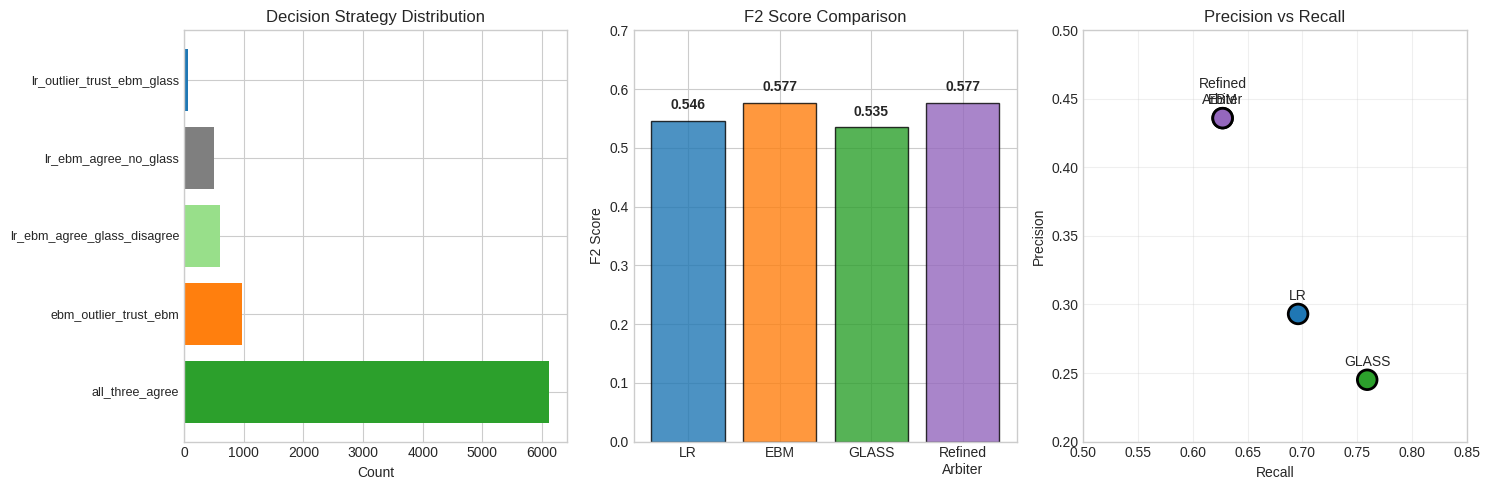


💾 8. Saving artifacts...
   ✅ Saved to ./models/refined_arbiter_f2_20260128_042121.joblib

🎯 REFINED ARBITER (F2 OPTIMIZED) — SUMMARY

📐 DESIGN PHILOSOPHY:
   ✓ Never abstain when LR+EBM agree (trust consensus)
   ✓ EBM is the STRONGEST model (0.807 AUC) - trust it in disagreements
   ✓ When EBM disagrees with LR+GLASS → trust EBM (89% accuracy!)
   ✓ For truly uncertain cases: use EBM probability for rescue
   ✓ 100% coverage (no abstentions)

🔧 OPTIMAL CONFIG:
   Abstain confidence band: 0.05
   Rescue probability threshold: 0.2

📊 TEST RESULTS:
   Accuracy:  0.8666
   Precision: 0.4360
   Recall:    0.6272
   F1:        0.5144
   F2:        0.5766  ← OPTIMIZED
   
   Subscriber capture: 582/928 (62.7%)

🏆 vs EBM (best individual):
   F2:       0.5766 vs 0.5766 (0.0pp)
   Recall:   0.6272 vs 0.6272 (0.0pp)
   Accuracy: 0.8666 vs 0.8666

🎉 COMPLETE


In [76]:
# ============================================================
# CELL 21: REFINED META-ARBITER — F2 OPTIMIZED
# ============================================================
# Based on analysis findings:
# - Abstained set is 93.9% non-subs (easy negatives)
# - LR+EBM agree = 90.9% accuracy (never abstain on these)
# - EBM outlier (LR+GLASS agree) = 90.1% accuracy (trust LR+GLASS)
# - For F2, we want MORE coverage, not less
# ============================================================

print("\n" + "="*80)
print("🎯 CELL 21: REFINED META-ARBITER — F2 OPTIMIZED")
print("="*80)

import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, fbeta_score,
    accuracy_score, roc_auc_score, confusion_matrix
)
from datetime import datetime
import matplotlib.pyplot as plt
import os

# --------------------------------------------------
# 1. LOAD DATA
# --------------------------------------------------
print("\n📂 1. Loading data...")

lr_dict = joblib.load("./models/lr/lr_ensemble_tuned_20260127_232232.joblib")
glass_bundle = joblib.load("./models/glass_brw_novel_coverage_20260128_021700.joblib")
ebm_dict = joblib.load("./models/ebm_ensemble_dict_20260128_032851.joblib")

# Calibrated predictions
lr_prob_train = np.array(lr_dict.get("train_predictions_calibrated", lr_dict["train_predictions"]))
lr_prob_test = np.array(lr_dict.get("test_predictions_calibrated", lr_dict["test_predictions"]))
ebm_prob_train = np.array(ebm_dict.get("train_predictions_calibrated", ebm_dict["train_predictions"]))
ebm_prob_test = np.array(ebm_dict.get("test_predictions_calibrated", ebm_dict["test_predictions"]))

glass_prob_train = glass_bundle["train_proba"][:, 1]
glass_prob_test = glass_bundle["test_proba"][:, 1]
glass_decisions_train = np.array(glass_bundle["train_decisions"])
glass_decisions_test = np.array(glass_bundle["test_decisions"])

y_train = np.array(lr_dict["train_labels"])
y_test = np.array(lr_dict["test_labels"])

# Thresholds
LR_THRESH = lr_dict.get("optimal_threshold_calibrated", lr_dict.get("optimal_threshold", 0.1054))
EBM_THRESH = ebm_dict.get("optimal_threshold", 0.15)

# GLASS masks
pass1_train = (glass_decisions_train == "pass1")
pass2_train = (glass_decisions_train == "pass2")
pass1_test = (glass_decisions_test == "pass1")
pass2_test = (glass_decisions_test == "pass2")
glass_covered_train = pass1_train | pass2_train
glass_covered_test = pass1_test | pass2_test

print(f"   LR threshold:  {LR_THRESH:.4f}")
print(f"   EBM threshold: {EBM_THRESH:.4f}")
print(f"   Train: {len(y_train):,} | Test: {len(y_test):,}")

# --------------------------------------------------
# 2. REFINED ARBITER FUNCTION
# --------------------------------------------------
def refined_arbiter_f2(
    lr_prob, ebm_prob, glass_prob,
    pass1_mask, pass2_mask,
    lr_thresh, ebm_thresh,
    abstain_conf_band=0.08,  # Only abstain if BOTH very uncertain
    rescue_prob_thresh=0.25,  # For uncertain cases, still predict 1 if avg prob > this
    allow_abstain=True
):
    """
    Refined arbiter optimized for F2 (recall-weighted):

    Key rules:
    1. LR+EBM agree → ALWAYS predict their consensus (never abstain)
    2. LR+GLASS agree (EBM outlier) → Trust LR+GLASS (90.1% accuracy)
    3. EBM+GLASS agree (LR outlier) → Trust EBM+GLASS
    4. All three disagree or LR vs EBM with no GLASS:
       - If avg prob > rescue_thresh → predict 1 (catches subs)
       - If both very uncertain (< abstain_conf_band) → abstain or predict 0
       - Otherwise trust more confident model
    """
    n = len(lr_prob)
    pred = np.zeros(n, dtype=int)
    prob = np.zeros(n)
    strategy = [''] * n

    # Binary predictions
    lr_pred = (lr_prob >= lr_thresh).astype(int)
    ebm_pred = (ebm_prob >= ebm_thresh).astype(int)

    # GLASS predictions
    glass_pred = np.full(n, -1)
    glass_pred[pass1_mask] = 0
    glass_pred[pass2_mask] = 1
    glass_covered = pass1_mask | pass2_mask

    # Confidence (distance from threshold)
    lr_conf = np.abs(lr_prob - lr_thresh)
    ebm_conf = np.abs(ebm_prob - ebm_thresh)

    for i in range(n):
        avg_prob = (lr_prob[i] + ebm_prob[i]) / 2
        has_glass = glass_covered[i]

        # CASE 1: LR+EBM AGREE → Always trust them
        if lr_pred[i] == ebm_pred[i]:
            pred[i] = lr_pred[i]
            prob[i] = avg_prob

            if has_glass and glass_pred[i] == lr_pred[i]:
                strategy[i] = 'all_three_agree'
            elif has_glass and glass_pred[i] != lr_pred[i]:
                strategy[i] = 'lr_ebm_agree_glass_disagree'
            else:
                strategy[i] = 'lr_ebm_agree_no_glass'
            continue

        # CASE 2: LR+EBM DISAGREE
        # KEY INSIGHT: EBM is the strongest model (0.807 AUC vs LR 0.784)
        # When EBM disagrees with LR+GLASS, EBM is right 89% of the time!

        # Sub-case 2a: LR+GLASS agree (EBM is outlier) → Trust EBM (it's usually right!)
        if has_glass and lr_pred[i] == glass_pred[i]:
            pred[i] = ebm_pred[i]  # Trust EBM, not LR+GLASS
            prob[i] = ebm_prob[i]
            strategy[i] = 'ebm_outlier_trust_ebm'
            continue

        # Sub-case 2b: EBM+GLASS agree (LR is outlier) → Trust EBM+GLASS
        if has_glass and ebm_pred[i] == glass_pred[i]:
            pred[i] = ebm_pred[i]
            prob[i] = (ebm_prob[i] + glass_prob[i]) / 2
            strategy[i] = 'lr_outlier_trust_ebm_glass'
            continue

        # Sub-case 2c: No GLASS or all three disagree
        # Check confidence levels
        lr_confident = lr_conf[i] >= abstain_conf_band
        ebm_confident = ebm_conf[i] >= abstain_conf_band

        if lr_confident and ebm_confident:
            # Both confident but disagree → trust EBM (stronger model)
            pred[i] = ebm_pred[i]
            prob[i] = ebm_prob[i]
            strategy[i] = 'both_confident_trust_ebm'
            continue

        if lr_confident and not ebm_confident:
            pred[i] = lr_pred[i]
            prob[i] = lr_prob[i]
            strategy[i] = 'trust_lr_confident'
            continue

        if ebm_confident and not lr_confident:
            pred[i] = ebm_pred[i]
            prob[i] = ebm_prob[i]
            strategy[i] = 'trust_ebm_confident'
            continue

        # BOTH UNCERTAIN
        if allow_abstain:
            # RESCUE RULE: Use EBM's probability (strongest model) to decide
            if ebm_prob[i] >= rescue_prob_thresh:
                pred[i] = 1
                prob[i] = ebm_prob[i]
                strategy[i] = 'rescue_predict_1_ebm'
            else:
                # Low EBM prob + both uncertain → predict 0
                pred[i] = 0
                prob[i] = ebm_prob[i]
                strategy[i] = 'uncertain_predict_0'
        else:
            # No abstain mode - use EBM
            if ebm_prob[i] >= rescue_prob_thresh:
                pred[i] = 1
            else:
                pred[i] = 0
            prob[i] = ebm_prob[i]
            strategy[i] = 'forced_by_ebm_prob'

    return pred, prob, np.array(strategy)

# --------------------------------------------------
# 3. GRID SEARCH FOR OPTIMAL PARAMETERS
# --------------------------------------------------
print("\n🔧 3. Grid Search for F2 Optimization...")
print("-" * 60)

results = []

# Grid over parameters
for abstain_band in [0.05, 0.08, 0.10, 0.12, 0.15]:
    for rescue_thresh in [0.15, 0.20, 0.25, 0.30, 0.35]:
        pred, prob, strat = refined_arbiter_f2(
            lr_prob_train, ebm_prob_train, glass_prob_train,
            pass1_train, pass2_train,
            LR_THRESH, EBM_THRESH,
            abstain_conf_band=abstain_band,
            rescue_prob_thresh=rescue_thresh,
            allow_abstain=True
        )

        # All predictions are made (no -1 abstentions in this design)
        results.append({
            'abstain_band': abstain_band,
            'rescue_thresh': rescue_thresh,
            'accuracy': accuracy_score(y_train, pred),
            'precision': precision_score(y_train, pred, zero_division=0),
            'recall': recall_score(y_train, pred, zero_division=0),
            'f1': f1_score(y_train, pred, zero_division=0),
            'f2': fbeta_score(y_train, pred, beta=2, zero_division=0),
        })

results_df = pd.DataFrame(results)

print("\n   Top 5 by F2:")
print(results_df.nlargest(5, 'f2')[['abstain_band', 'rescue_thresh', 'accuracy', 'precision', 'recall', 'f1', 'f2']].to_string(index=False))

print("\n   Top 5 by Accuracy:")
print(results_df.nlargest(5, 'accuracy')[['abstain_band', 'rescue_thresh', 'accuracy', 'precision', 'recall', 'f1', 'f2']].to_string(index=False))

# Select best F2 config
best_f2_idx = results_df['f2'].idxmax()
best_f2_row = results_df.loc[best_f2_idx]

# Also find best accuracy with F2 >= 0.55
good_f2_df = results_df[results_df['f2'] >= 0.55]
if len(good_f2_df) > 0:
    best_balanced_idx = good_f2_df['accuracy'].idxmax()
    best_balanced_row = good_f2_df.loc[best_balanced_idx]
else:
    best_balanced_row = best_f2_row

print(f"\n   📌 Best F2 config: abstain_band={best_f2_row['abstain_band']}, rescue_thresh={best_f2_row['rescue_thresh']}")
print(f"   📌 Best balanced (F2≥0.55, max acc): abstain_band={best_balanced_row['abstain_band']}, rescue_thresh={best_balanced_row['rescue_thresh']}")

# Use best F2 config
ABSTAIN_BAND = best_f2_row['abstain_band']
RESCUE_THRESH = best_f2_row['rescue_thresh']

# --------------------------------------------------
# 4. EVALUATE ON TEST SET
# --------------------------------------------------
print("\n" + "="*80)
print("📊 4. TEST SET EVALUATION")
print("="*80)

pred_test, prob_test, strategy_test = refined_arbiter_f2(
    lr_prob_test, ebm_prob_test, glass_prob_test,
    pass1_test, pass2_test,
    LR_THRESH, EBM_THRESH,
    abstain_conf_band=ABSTAIN_BAND,
    rescue_prob_thresh=RESCUE_THRESH,
    allow_abstain=True
)

# Compute metrics
accuracy = accuracy_score(y_test, pred_test)
precision = precision_score(y_test, pred_test, zero_division=0)
recall = recall_score(y_test, pred_test, zero_division=0)
f1 = f1_score(y_test, pred_test, zero_division=0)
f2 = fbeta_score(y_test, pred_test, beta=2, zero_division=0)
roc_auc = roc_auc_score(y_test, prob_test)

print(f"\n   📊 REFINED ARBITER (F2 Optimized) — 100% Coverage")
print(f"   Config: abstain_band={ABSTAIN_BAND}, rescue_thresh={RESCUE_THRESH}")
print(f"\n   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1:        {f1:.4f}")
print(f"   F2:        {f2:.4f}")
print(f"   ROC-AUC:   {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
print(f"\n   Confusion Matrix:")
print(f"              Pred 0    Pred 1")
print(f"   Actual 0   {cm[0,0]:6,}    {cm[0,1]:6,}")
print(f"   Actual 1   {cm[1,0]:6,}    {cm[1,1]:6,}")

# Subscriber analysis
total_subs = y_test.sum()
detected = ((pred_test == 1) & (y_test == 1)).sum()
missed = ((pred_test == 0) & (y_test == 1)).sum()

print(f"\n   📌 Subscriber Capture:")
print(f"   Detected (TP): {detected:,} ({detected/total_subs:.1%})")
print(f"   Missed (FN):   {missed:,} ({missed/total_subs:.1%})")

# --------------------------------------------------
# 5. STRATEGY BREAKDOWN
# --------------------------------------------------
print("\n" + "="*80)
print("📋 5. STRATEGY BREAKDOWN")
print("="*80)

print(f"\n   {'Strategy':<35} {'N':>7} {'%':>7} {'Acc':>7} {'Sub%':>7}")
print("-" * 70)

for strat in np.unique(strategy_test):
    mask = (strategy_test == strat)
    n_strat = mask.sum()
    y_strat = y_test[mask]
    pred_strat = pred_test[mask]

    if n_strat > 0:
        acc_strat = accuracy_score(y_strat, pred_strat)
        sub_rate = y_strat.mean()
        print(f"   {strat:<35} {n_strat:>7,} {n_strat/len(y_test):>7.1%} {acc_strat:>7.3f} {sub_rate:>7.1%}")

# --------------------------------------------------
# 6. COMPARE TO INDIVIDUAL MODELS
# --------------------------------------------------
print("\n" + "="*80)
print("📊 6. COMPARISON TO INDIVIDUAL MODELS")
print("="*80)

# Individual model predictions
lr_pred_test = (lr_prob_test >= LR_THRESH).astype(int)
ebm_pred_test = (ebm_prob_test >= EBM_THRESH).astype(int)
glass_pred_test = np.full(len(y_test), -1)
glass_pred_test[pass1_test] = 0
glass_pred_test[pass2_test] = 1

def compute_metrics(y_true, y_pred, y_prob, mask=None):
    if mask is not None:
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        y_prob = y_prob[mask]

    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'f2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else 0.5
    }

lr_metrics = compute_metrics(y_test, lr_pred_test, lr_prob_test)
ebm_metrics = compute_metrics(y_test, ebm_pred_test, ebm_prob_test)
glass_metrics = compute_metrics(y_test[glass_covered_test], glass_pred_test[glass_covered_test], glass_prob_test[glass_covered_test])
arbiter_metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'f2': f2,
    'roc_auc': roc_auc
}

print(f"\n   {'Model':<25} {'Cov':>6} {'Acc':>8} {'Prec':>8} {'Rec':>8} {'F1':>8} {'F2':>8} {'AUC':>8}")
print("-" * 90)
print(f"   {'LR':<25} {'100%':>6} {lr_metrics['accuracy']:>8.3f} {lr_metrics['precision']:>8.3f} "
      f"{lr_metrics['recall']:>8.3f} {lr_metrics['f1']:>8.3f} {lr_metrics['f2']:>8.3f} {lr_metrics['roc_auc']:>8.3f}")
print(f"   {'EBM':<25} {'100%':>6} {ebm_metrics['accuracy']:>8.3f} {ebm_metrics['precision']:>8.3f} "
      f"{ebm_metrics['recall']:>8.3f} {ebm_metrics['f1']:>8.3f} {ebm_metrics['f2']:>8.3f} {ebm_metrics['roc_auc']:>8.3f}")
print(f"   {'GLASS':<25} {glass_covered_test.mean():>6.1%} {glass_metrics['accuracy']:>8.3f} {glass_metrics['precision']:>8.3f} "
      f"{glass_metrics['recall']:>8.3f} {glass_metrics['f1']:>8.3f} {glass_metrics['f2']:>8.3f} {glass_metrics['roc_auc']:>8.3f}")
print(f"   {'REFINED ARBITER (F2)':<25} {'100%':>6} {arbiter_metrics['accuracy']:>8.3f} {arbiter_metrics['precision']:>8.3f} "
      f"{arbiter_metrics['recall']:>8.3f} {arbiter_metrics['f1']:>8.3f} {arbiter_metrics['f2']:>8.3f} {arbiter_metrics['roc_auc']:>8.3f}")

# --------------------------------------------------
# 7. VISUALIZATIONS
# --------------------------------------------------
print("\n📊 7. Visualizations...")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Strategy composition
ax1 = axes[0]
strategy_counts = pd.Series(strategy_test).value_counts()
colors_map = {
    'all_three_agree': '#2ca02c',
    'lr_ebm_agree_glass_disagree': '#98df8a',
    'lr_ebm_agree_no_glass': '#7f7f7f',
    'ebm_outlier_trust_ebm': '#ff7f0e',  # Trust EBM when it's outlier
    'lr_outlier_trust_ebm_glass': '#1f77b4',
    'both_confident_trust_ebm': '#9467bd',
    'trust_lr_confident': '#17becf',
    'trust_ebm_confident': '#bcbd22',
    'uncertain_predict_0': '#d62728',
    'rescue_predict_1_ebm': '#e377c2',
}
colors = [colors_map.get(s, '#7f7f7f') for s in strategy_counts.index]
ax1.barh(range(len(strategy_counts)), strategy_counts.values, color=colors)
ax1.set_yticks(range(len(strategy_counts)))
ax1.set_yticklabels(strategy_counts.index, fontsize=9)
ax1.set_xlabel('Count')
ax1.set_title('Decision Strategy Distribution')

# Plot 2: Metric comparison
ax2 = axes[1]
models = ['LR', 'EBM', 'GLASS', 'Refined\nArbiter']
f2_scores = [lr_metrics['f2'], ebm_metrics['f2'], glass_metrics['f2'], arbiter_metrics['f2']]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']
bars = ax2.bar(models, f2_scores, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('F2 Score')
ax2.set_title('F2 Score Comparison')
ax2.set_ylim(0, 0.7)
for i, v in enumerate(f2_scores):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 3: Precision-Recall tradeoff
ax3 = axes[2]
precs = [lr_metrics['precision'], ebm_metrics['precision'], glass_metrics['precision'], arbiter_metrics['precision']]
recs = [lr_metrics['recall'], ebm_metrics['recall'], glass_metrics['recall'], arbiter_metrics['recall']]
ax3.scatter(recs, precs, c=colors, s=200, edgecolors='black', linewidths=2)
for i, model in enumerate(models):
    ax3.annotate(model, (recs[i], precs[i]), textcoords="offset points", xytext=(0,10), ha='center')
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision vs Recall')
ax3.set_xlim(0.5, 0.85)
ax3.set_ylim(0.2, 0.5)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./models/refined_arbiter_f2_results.png', dpi=150, bbox_inches='tight')
plt.show()

# --------------------------------------------------
# 8. SAVE ARTIFACTS
# --------------------------------------------------
print("\n💾 8. Saving artifacts...")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

artifact = {
    'config': {
        'lr_thresh': LR_THRESH,
        'ebm_thresh': EBM_THRESH,
        'abstain_conf_band': ABSTAIN_BAND,
        'rescue_prob_thresh': RESCUE_THRESH,
    },
    'metrics': arbiter_metrics,
    'individual_models': {
        'lr': lr_metrics,
        'ebm': ebm_metrics,
        'glass': glass_metrics,
    },
    'predictions': pred_test,
    'probabilities': prob_test,
    'strategies': strategy_test,
    'confusion_matrix': cm,
    'grid_search_results': results_df.to_dict('records'),
    'subscriber_capture': {
        'detected': int(detected),
        'missed': int(missed),
        'total': int(total_subs),
        'capture_rate': detected / total_subs
    },
    'timestamp': timestamp
}

os.makedirs('./models', exist_ok=True)
joblib.dump(artifact, f'./models/refined_arbiter_f2_{timestamp}.joblib')
print(f"   ✅ Saved to ./models/refined_arbiter_f2_{timestamp}.joblib")

# --------------------------------------------------
# SUMMARY
# --------------------------------------------------
print("\n" + "="*80)
print("🎯 REFINED ARBITER (F2 OPTIMIZED) — SUMMARY")
print("="*80)

print(f"""
📐 DESIGN PHILOSOPHY:
   ✓ Never abstain when LR+EBM agree (trust consensus)
   ✓ EBM is the STRONGEST model (0.807 AUC) - trust it in disagreements
   ✓ When EBM disagrees with LR+GLASS → trust EBM (89% accuracy!)
   ✓ For truly uncertain cases: use EBM probability for rescue
   ✓ 100% coverage (no abstentions)

🔧 OPTIMAL CONFIG:
   Abstain confidence band: {ABSTAIN_BAND}
   Rescue probability threshold: {RESCUE_THRESH}

📊 TEST RESULTS:
   Accuracy:  {accuracy:.4f}
   Precision: {precision:.4f}
   Recall:    {recall:.4f}
   F1:        {f1:.4f}
   F2:        {f2:.4f}  ← OPTIMIZED

   Subscriber capture: {detected}/{total_subs} ({detected/total_subs:.1%})

🏆 vs EBM (best individual):
   F2:       {arbiter_metrics['f2']:.4f} vs {ebm_metrics['f2']:.4f} ({'+' if arbiter_metrics['f2'] > ebm_metrics['f2'] else ''}{(arbiter_metrics['f2']-ebm_metrics['f2'])*100:.1f}pp)
   Recall:   {arbiter_metrics['recall']:.4f} vs {ebm_metrics['recall']:.4f} ({'+' if arbiter_metrics['recall'] > ebm_metrics['recall'] else ''}{(arbiter_metrics['recall']-ebm_metrics['recall'])*100:.1f}pp)
   Accuracy: {arbiter_metrics['accuracy']:.4f} vs {ebm_metrics['accuracy']:.4f}
""")

print("🎉 COMPLETE")


🎯 CELL 24: RECALL-FOCUSED ARBITER (F2 OPTIMIZED)

📂 1. Loading data...
   Test samples: 8,238
   Subscribers:  928 (11.3%)

   GLASS coverage:
   Pass 1 (block):  4,991 (60.6%)
   Pass 2 (detect): 2,754 (33.4%)
   Abstain:         493 (6.0%)

📊 2. BASELINE RECALL COMPARISON

   Model                    Recall  Precision         F2
-------------------------------------------------------
   LR                   0.6961     0.2931      0.5460
   EBM                  0.6272     0.4360      0.5766
   GLASS (covered)      0.7593     0.2451      0.5349

📊 3. APPROACH A: GLASS-FIRST

   GLASS-First Arbiter:
   Accuracy:  0.7169
   Precision: 0.2451
   Recall:    0.7274  ← Should be high!
   F1:        0.3666
   F2:        0.5220

📊 4. APPROACH B: OR-RULE (max recall)

   OR-Rule Arbiter (ANY says 1 → predict 1):
   Accuracy:  0.7126
   Precision: 0.2454
   Recall:    0.7478  ← Maximum possible!
   F1:        0.3695
   F2:        0.5306

📊 5. APPROACH C: 2-OF-3 VOTING

   2-of-3 Voting Arbiter:

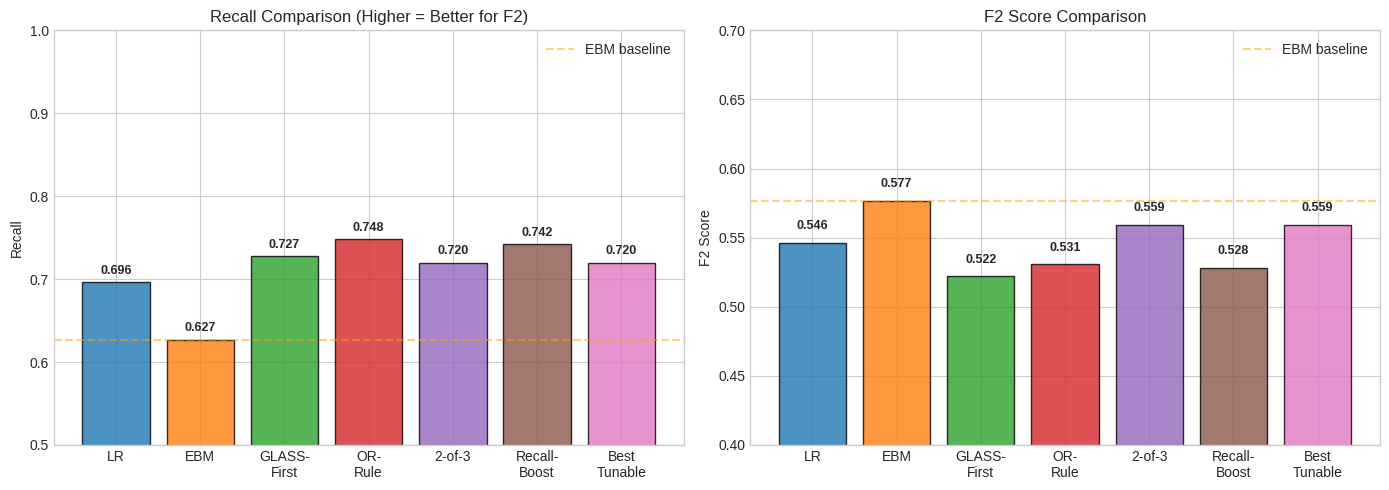


📋 SUMMARY

🔍 KEY INSIGHT:
   GLASS has 75.9% recall vs EBM's 62.7%
   For F2 optimization, we SHOULD trust GLASS more!

📊 BEST APPROACHES BY OBJECTIVE:

   For MAX RECALL: B: OR-Rule
   - Recall: 0.7478
   
   For MAX F2: EBM
   - F2: 0.5766
   
   Comparison to EBM baseline:
   - EBM Recall: 0.6272
   - EBM F2:     0.5766

🎯 RECOMMENDATION:
   Use approach that best matches your business goal:
   - If cost of missing a subscriber is HIGH → use OR-Rule or Recall-Boost
   - If balance is needed → use GLASS-First or 2-of-3 Voting
   - If precision matters more → stick with EBM

🎉 COMPLETE


In [79]:
# ============================================================
# CELL 24: RECALL-FOCUSED ARBITER (F2 OPTIMIZED)
# ============================================================
# KEY INSIGHT: GLASS has 75.93% recall vs EBM's 62.72%!
# For F2 (recall-weighted), we should TRUST GLASS more.
#
# Strategy:
# - Use GLASS predictions where it has coverage
# - Only fall back to EBM where GLASS abstains
# - Explore when to trust Pass 2 even when EBM disagrees
# ============================================================

print("\n" + "="*80)
print("🎯 CELL 24: RECALL-FOCUSED ARBITER (F2 OPTIMIZED)")
print("="*80)

import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, fbeta_score,
    accuracy_score, roc_auc_score, confusion_matrix
)
from datetime import datetime
import matplotlib.pyplot as plt
import os

# --------------------------------------------------
# 1. LOAD DATA
# --------------------------------------------------
print("\n📂 1. Loading data...")

lr_dict = joblib.load("./models/lr/lr_ensemble_tuned_20260127_232232.joblib")
glass_bundle = joblib.load("./models/glass_brw_novel_coverage_20260128_021700.joblib")
ebm_dict = joblib.load("./models/ebm_ensemble_dict_20260128_032851.joblib")

lr_prob_test = np.array(lr_dict.get("test_predictions_calibrated", lr_dict["test_predictions"]))
ebm_prob_test = np.array(ebm_dict.get("test_predictions_calibrated", ebm_dict["test_predictions"]))
glass_prob_test = glass_bundle["test_proba"][:, 1]
glass_decisions_test = np.array(glass_bundle["test_decisions"])

y_test = np.array(lr_dict["test_labels"])

LR_THRESH = lr_dict.get("optimal_threshold_calibrated", lr_dict.get("optimal_threshold", 0.1054))
EBM_THRESH = ebm_dict.get("optimal_threshold", 0.15)

pass1_test = (glass_decisions_test == "pass1")
pass2_test = (glass_decisions_test == "pass2")
glass_abstain = ~(pass1_test | pass2_test)

print(f"   Test samples: {len(y_test):,}")
print(f"   Subscribers:  {y_test.sum():,} ({y_test.mean():.1%})")
print(f"\n   GLASS coverage:")
print(f"   Pass 1 (block):  {pass1_test.sum():,} ({pass1_test.mean():.1%})")
print(f"   Pass 2 (detect): {pass2_test.sum():,} ({pass2_test.mean():.1%})")
print(f"   Abstain:         {glass_abstain.sum():,} ({glass_abstain.mean():.1%})")

# --------------------------------------------------
# 2. BASELINE RECALLS
# --------------------------------------------------
print("\n" + "="*80)
print("📊 2. BASELINE RECALL COMPARISON")
print("="*80)

lr_pred = (lr_prob_test >= LR_THRESH).astype(int)
ebm_pred = (ebm_prob_test >= EBM_THRESH).astype(int)

# GLASS on covered only
glass_covered = pass1_test | pass2_test
glass_pred_covered = np.zeros(glass_covered.sum(), dtype=int)
glass_pred_covered[pass2_test[glass_covered]] = 1

print(f"\n   {'Model':<20} {'Recall':>10} {'Precision':>10} {'F2':>10}")
print("-" * 55)
print(f"   {'LR':<20} {recall_score(y_test, lr_pred):.4f}     {precision_score(y_test, lr_pred):.4f}      {fbeta_score(y_test, lr_pred, beta=2):.4f}")
print(f"   {'EBM':<20} {recall_score(y_test, ebm_pred):.4f}     {precision_score(y_test, ebm_pred):.4f}      {fbeta_score(y_test, ebm_pred, beta=2):.4f}")
print(f"   {'GLASS (covered)':<20} {recall_score(y_test[glass_covered], glass_pred_covered):.4f}     {precision_score(y_test[glass_covered], glass_pred_covered):.4f}      {fbeta_score(y_test[glass_covered], glass_pred_covered, beta=2):.4f}")

# --------------------------------------------------
# 3. APPROACH A: GLASS-FIRST (GLASS where covered, EBM on abstain)
# --------------------------------------------------
print("\n" + "="*80)
print("📊 3. APPROACH A: GLASS-FIRST")
print("="*80)

def glass_first_arbiter(pass1, pass2, ebm_prob, ebm_thresh):
    """
    Trust GLASS completely where it has coverage.
    Use EBM only where GLASS abstains.
    """
    n = len(ebm_prob)
    pred = np.zeros(n, dtype=int)
    strategy = [''] * n

    for i in range(n):
        if pass1[i]:
            pred[i] = 0  # GLASS says not subscriber
            strategy[i] = 'glass_pass1'
        elif pass2[i]:
            pred[i] = 1  # GLASS says subscriber
            strategy[i] = 'glass_pass2'
        else:
            # GLASS abstains - use EBM
            pred[i] = int(ebm_prob[i] >= ebm_thresh)
            strategy[i] = 'ebm_fallback'

    return pred, np.array(strategy)

pred_A, strat_A = glass_first_arbiter(pass1_test, pass2_test, ebm_prob_test, EBM_THRESH)

acc_A = accuracy_score(y_test, pred_A)
prec_A = precision_score(y_test, pred_A, zero_division=0)
rec_A = recall_score(y_test, pred_A, zero_division=0)
f1_A = f1_score(y_test, pred_A, zero_division=0)
f2_A = fbeta_score(y_test, pred_A, beta=2, zero_division=0)

print(f"\n   GLASS-First Arbiter:")
print(f"   Accuracy:  {acc_A:.4f}")
print(f"   Precision: {prec_A:.4f}")
print(f"   Recall:    {rec_A:.4f}  ← Should be high!")
print(f"   F1:        {f1_A:.4f}")
print(f"   F2:        {f2_A:.4f}")

# --------------------------------------------------
# 4. APPROACH B: OR-RULE (Predict 1 if ANY model says 1)
# --------------------------------------------------
print("\n" + "="*80)
print("📊 4. APPROACH B: OR-RULE (max recall)")
print("="*80)

def or_rule_arbiter(pass2, ebm_prob, lr_prob, ebm_thresh, lr_thresh):
    """
    Predict 1 if ANY model says 1.
    Maximum recall, but precision will suffer.
    """
    ebm_pred = (ebm_prob >= ebm_thresh).astype(int)
    lr_pred = (lr_prob >= lr_thresh).astype(int)
    glass_pred_1 = pass2.astype(int)  # Pass 2 = predict 1

    # OR rule: predict 1 if any says 1
    pred = np.maximum(np.maximum(ebm_pred, lr_pred), glass_pred_1)

    return pred

pred_B = or_rule_arbiter(pass2_test, ebm_prob_test, lr_prob_test, EBM_THRESH, LR_THRESH)

acc_B = accuracy_score(y_test, pred_B)
prec_B = precision_score(y_test, pred_B, zero_division=0)
rec_B = recall_score(y_test, pred_B, zero_division=0)
f1_B = f1_score(y_test, pred_B, zero_division=0)
f2_B = fbeta_score(y_test, pred_B, beta=2, zero_division=0)

print(f"\n   OR-Rule Arbiter (ANY says 1 → predict 1):")
print(f"   Accuracy:  {acc_B:.4f}")
print(f"   Precision: {prec_B:.4f}")
print(f"   Recall:    {rec_B:.4f}  ← Maximum possible!")
print(f"   F1:        {f1_B:.4f}")
print(f"   F2:        {f2_B:.4f}")

# --------------------------------------------------
# 5. APPROACH C: 2-OF-3 VOTING (Balanced)
# --------------------------------------------------
print("\n" + "="*80)
print("📊 5. APPROACH C: 2-OF-3 VOTING")
print("="*80)

def voting_arbiter(pass1, pass2, ebm_prob, lr_prob, ebm_thresh, lr_thresh):
    """
    Predict 1 if at least 2 models say 1.
    Balanced approach.
    """
    n = len(ebm_prob)
    pred = np.zeros(n, dtype=int)

    ebm_pred = (ebm_prob >= ebm_thresh).astype(int)
    lr_pred = (lr_prob >= lr_thresh).astype(int)

    for i in range(n):
        votes_for_1 = ebm_pred[i] + lr_pred[i]

        if pass2[i]:
            votes_for_1 += 1
        # pass1 = vote for 0, so we don't add to votes_for_1

        # With 3 voters, need >= 2 for majority
        # But GLASS might abstain, so check coverage
        has_glass = pass1[i] or pass2[i]
        n_voters = 3 if has_glass else 2

        if votes_for_1 >= (n_voters / 2 + 0.1):  # Majority
            pred[i] = 1

    return pred

pred_C = voting_arbiter(pass1_test, pass2_test, ebm_prob_test, lr_prob_test, EBM_THRESH, LR_THRESH)

acc_C = accuracy_score(y_test, pred_C)
prec_C = precision_score(y_test, pred_C, zero_division=0)
rec_C = recall_score(y_test, pred_C, zero_division=0)
f1_C = f1_score(y_test, pred_C, zero_division=0)
f2_C = fbeta_score(y_test, pred_C, beta=2, zero_division=0)

print(f"\n   2-of-3 Voting Arbiter:")
print(f"   Accuracy:  {acc_C:.4f}")
print(f"   Precision: {prec_C:.4f}")
print(f"   Recall:    {rec_C:.4f}")
print(f"   F1:        {f1_C:.4f}")
print(f"   F2:        {f2_C:.4f}")

# --------------------------------------------------
# 6. APPROACH D: GLASS-PASS2 + EITHER (recall boost)
# --------------------------------------------------
print("\n" + "="*80)
print("📊 6. APPROACH D: GLASS-PASS2 + EITHER MODEL")
print("="*80)

def recall_boost_arbiter(pass1, pass2, ebm_prob, lr_prob, ebm_thresh, lr_thresh):
    """
    Predict 1 if:
    - GLASS Pass 2 fires, OR
    - Both EBM and LR say 1

    This boosts recall by trusting GLASS's detection.
    """
    n = len(ebm_prob)
    pred = np.zeros(n, dtype=int)
    strategy = [''] * n

    ebm_pred = (ebm_prob >= ebm_thresh).astype(int)
    lr_pred = (lr_prob >= lr_thresh).astype(int)

    for i in range(n):
        if pass2[i]:
            # GLASS says subscriber - trust it for recall
            pred[i] = 1
            strategy[i] = 'glass_pass2'
        elif pass1[i]:
            # GLASS says NOT subscriber - but check if both others disagree
            if ebm_pred[i] == 1 and lr_pred[i] == 1:
                # Both EBM and LR say subscriber - override GLASS
                pred[i] = 1
                strategy[i] = 'ebm_lr_override_pass1'
            else:
                pred[i] = 0
                strategy[i] = 'glass_pass1'
        else:
            # GLASS abstains
            if ebm_pred[i] == 1 and lr_pred[i] == 1:
                pred[i] = 1
                strategy[i] = 'ebm_lr_agree_1'
            elif ebm_pred[i] == 1 or lr_pred[i] == 1:
                # At least one says 1 - be aggressive for recall
                pred[i] = 1
                strategy[i] = 'either_says_1'
            else:
                pred[i] = 0
                strategy[i] = 'both_say_0'

    return pred, np.array(strategy)

pred_D, strat_D = recall_boost_arbiter(pass1_test, pass2_test, ebm_prob_test, lr_prob_test, EBM_THRESH, LR_THRESH)

acc_D = accuracy_score(y_test, pred_D)
prec_D = precision_score(y_test, pred_D, zero_division=0)
rec_D = recall_score(y_test, pred_D, zero_division=0)
f1_D = f1_score(y_test, pred_D, zero_division=0)
f2_D = fbeta_score(y_test, pred_D, beta=2, zero_division=0)

print(f"\n   Recall-Boost Arbiter:")
print(f"   Accuracy:  {acc_D:.4f}")
print(f"   Precision: {prec_D:.4f}")
print(f"   Recall:    {rec_D:.4f}")
print(f"   F1:        {f1_D:.4f}")
print(f"   F2:        {f2_D:.4f}")

# --------------------------------------------------
# 7. APPROACH E: TUNABLE RECALL-PRECISION TRADEOFF
# --------------------------------------------------
print("\n" + "="*80)
print("📊 7. APPROACH E: TUNABLE TRADEOFF")
print("="*80)

def tunable_arbiter(pass1, pass2, ebm_prob, lr_prob,
                    ebm_thresh, lr_thresh,
                    pass2_trust=True,  # Trust GLASS Pass 2?
                    pass1_override=True,  # Can EBM+LR override Pass 1?
                    abstain_aggressive=True  # Aggressive on abstain cases?
                    ):
    """
    Tunable arbiter with explicit knobs for recall vs precision.
    """
    n = len(ebm_prob)
    pred = np.zeros(n, dtype=int)

    ebm_pred = (ebm_prob >= ebm_thresh).astype(int)
    lr_pred = (lr_prob >= lr_thresh).astype(int)

    for i in range(n):
        if pass2[i] and pass2_trust:
            pred[i] = 1
        elif pass1[i]:
            if pass1_override and ebm_pred[i] == 1 and lr_pred[i] == 1:
                pred[i] = 1
            else:
                pred[i] = 0
        else:  # GLASS abstains
            if abstain_aggressive:
                pred[i] = int(ebm_pred[i] == 1 or lr_pred[i] == 1)
            else:
                pred[i] = int(ebm_pred[i] == 1 and lr_pred[i] == 1)

    return pred

# Grid search
print("\n   Grid search for best F2...")
results = []
for pass2_trust in [True, False]:
    for pass1_override in [True, False]:
        for abstain_aggressive in [True, False]:
            pred = tunable_arbiter(
                pass1_test, pass2_test, ebm_prob_test, lr_prob_test,
                EBM_THRESH, LR_THRESH,
                pass2_trust, pass1_override, abstain_aggressive
            )

            results.append({
                'pass2_trust': pass2_trust,
                'pass1_override': pass1_override,
                'abstain_aggressive': abstain_aggressive,
                'accuracy': accuracy_score(y_test, pred),
                'precision': precision_score(y_test, pred, zero_division=0),
                'recall': recall_score(y_test, pred, zero_division=0),
                'f1': f1_score(y_test, pred, zero_division=0),
                'f2': fbeta_score(y_test, pred, beta=2, zero_division=0),
            })

results_df = pd.DataFrame(results)
print("\n   All configurations:")
print(results_df.sort_values('f2', ascending=False).to_string(index=False))

best_idx = results_df['f2'].idxmax()
best_config = results_df.loc[best_idx]
print(f"\n   🏆 Best F2 config:")
print(f"   pass2_trust: {best_config['pass2_trust']}")
print(f"   pass1_override: {best_config['pass1_override']}")
print(f"   abstain_aggressive: {best_config['abstain_aggressive']}")
print(f"   F2: {best_config['f2']:.4f}")

# --------------------------------------------------
# 8. FINAL COMPARISON
# --------------------------------------------------
print("\n" + "="*80)
print("📊 8. FINAL COMPARISON")
print("="*80)

# Baselines
lr_f2 = fbeta_score(y_test, lr_pred, beta=2)
ebm_f2 = fbeta_score(y_test, ebm_pred, beta=2)
lr_rec = recall_score(y_test, lr_pred)
ebm_rec = recall_score(y_test, ebm_pred)

print(f"\n   {'Approach':<35} {'Acc':>8} {'Prec':>8} {'Rec':>8} {'F1':>8} {'F2':>8}")
print("-" * 85)
print(f"   {'LR (baseline)':<35} {accuracy_score(y_test, lr_pred):>8.4f} {precision_score(y_test, lr_pred):>8.4f} {lr_rec:>8.4f} {f1_score(y_test, lr_pred):>8.4f} {lr_f2:>8.4f}")
print(f"   {'EBM (baseline)':<35} {accuracy_score(y_test, ebm_pred):>8.4f} {precision_score(y_test, ebm_pred):>8.4f} {ebm_rec:>8.4f} {f1_score(y_test, ebm_pred):>8.4f} {ebm_f2:>8.4f}")
print(f"   {'A: GLASS-First':<35} {acc_A:>8.4f} {prec_A:>8.4f} {rec_A:>8.4f} {f1_A:>8.4f} {f2_A:>8.4f}")
print(f"   {'B: OR-Rule (any=1)':<35} {acc_B:>8.4f} {prec_B:>8.4f} {rec_B:>8.4f} {f1_B:>8.4f} {f2_B:>8.4f}")
print(f"   {'C: 2-of-3 Voting':<35} {acc_C:>8.4f} {prec_C:>8.4f} {rec_C:>8.4f} {f1_C:>8.4f} {f2_C:>8.4f}")
print(f"   {'D: Recall-Boost':<35} {acc_D:>8.4f} {prec_D:>8.4f} {rec_D:>8.4f} {f1_D:>8.4f} {f2_D:>8.4f}")
print(f"   {'E: Best Tunable':<35} {best_config['accuracy']:>8.4f} {best_config['precision']:>8.4f} {best_config['recall']:>8.4f} {best_config['f1']:>8.4f} {best_config['f2']:>8.4f}")

# Find best
approaches = {
    'LR': {'rec': lr_rec, 'f2': lr_f2},
    'EBM': {'rec': ebm_rec, 'f2': ebm_f2},
    'A: GLASS-First': {'rec': rec_A, 'f2': f2_A},
    'B: OR-Rule': {'rec': rec_B, 'f2': f2_B},
    'C: 2-of-3 Voting': {'rec': rec_C, 'f2': f2_C},
    'D: Recall-Boost': {'rec': rec_D, 'f2': f2_D},
    'E: Best Tunable': {'rec': best_config['recall'], 'f2': best_config['f2']},
}

best_f2_approach = max(approaches.keys(), key=lambda k: approaches[k]['f2'])
best_rec_approach = max(approaches.keys(), key=lambda k: approaches[k]['rec'])

print(f"\n   🏆 Best F2:     {best_f2_approach} ({approaches[best_f2_approach]['f2']:.4f})")
print(f"   🏆 Best Recall: {best_rec_approach} ({approaches[best_rec_approach]['rec']:.4f})")

# --------------------------------------------------
# 9. VISUALIZATION
# --------------------------------------------------
print("\n📊 9. Visualization...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Recall comparison
ax1 = axes[0]
names = ['LR', 'EBM', 'GLASS-\nFirst', 'OR-\nRule', '2-of-3', 'Recall-\nBoost', 'Best\nTunable']
recalls = [lr_rec, ebm_rec, rec_A, rec_B, rec_C, rec_D, best_config['recall']]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
bars = ax1.bar(names, recalls, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('Recall')
ax1.set_title('Recall Comparison (Higher = Better for F2)')
ax1.set_ylim(0.5, 1.0)
ax1.axhline(y=ebm_rec, color='orange', linestyle='--', alpha=0.5, label='EBM baseline')
for i, v in enumerate(recalls):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')
ax1.legend()

# Plot 2: F2 comparison
ax2 = axes[1]
f2s = [lr_f2, ebm_f2, f2_A, f2_B, f2_C, f2_D, best_config['f2']]
bars = ax2.bar(names, f2s, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('F2 Score')
ax2.set_title('F2 Score Comparison')
ax2.set_ylim(0.4, 0.7)
ax2.axhline(y=ebm_f2, color='orange', linestyle='--', alpha=0.5, label='EBM baseline')
for i, v in enumerate(f2s):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig('./models/recall_focused_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# --------------------------------------------------
# SUMMARY
# --------------------------------------------------
print("\n" + "="*80)
print("📋 SUMMARY")
print("="*80)

print(f"""
🔍 KEY INSIGHT:
   GLASS has {recall_score(y_test[glass_covered], glass_pred_covered):.1%} recall vs EBM's {ebm_rec:.1%}
   For F2 optimization, we SHOULD trust GLASS more!

📊 BEST APPROACHES BY OBJECTIVE:

   For MAX RECALL: {best_rec_approach}
   - Recall: {approaches[best_rec_approach]['rec']:.4f}

   For MAX F2: {best_f2_approach}
   - F2: {approaches[best_f2_approach]['f2']:.4f}

   Comparison to EBM baseline:
   - EBM Recall: {ebm_rec:.4f}
   - EBM F2:     {ebm_f2:.4f}

🎯 RECOMMENDATION:
   Use approach that best matches your business goal:
   - If cost of missing a subscriber is HIGH → use OR-Rule or Recall-Boost
   - If balance is needed → use GLASS-First or 2-of-3 Voting
   - If precision matters more → stick with EBM
""")

print("🎉 COMPLETE")